# TESS Atlas fit for TOI 538

**Version: 0.1.0**

**Note: This notebook was automatically generated as part of the TESS Atlas project. More information can be found on GitHub:** [github.com/dfm/tess-atlas](https://github.com/dfm/tess-atlas)

In this notebook, we do a quicklook fit for the parameters of the TESS Objects of Interest (TOI) in the system number 538.
To do this fit, we use the [exoplanet](https://exoplanet.dfm.io) library and you can find more information about that project at [exoplanet.dfm.io](https://exoplanet.dfm.io).

From here, you can scroll down and take a look at the fit results, or you can:

- [open the notebook in Google Colab to run the fit yourself](https://colab.research.google.com/github/dfm/tess-atlas/blob/master/notebooks/0.1.0/toi-538.ipynb),
- [view the notebook on GitHub](https://github.com/dfm/tess-atlas/blob/master/notebooks/0.1.0/toi-538.ipynb), or
- [download the notebook](https://github.com/dfm/tess-atlas/raw/master/notebooks/0.1.0/toi-538.ipynb).

## Caveats

There are many caveats associated with this relatively simple "quicklook" type of analysis that should be kept in mind.
Here are some of the main things that come to mind:

1. The orbits that we fit are constrained to be *circular*. One major effect of this approximation is that the fit will significantly overestimate the confidence of the impact parameter constraint, so the results for impact parameter shouldn't be taken too seriously. 

2. Transit timing variations, correlated noise, and (probably) your favorite systematics are ignored. Sorry!

3. This notebook was generated automatically without human intervention. Use at your own risk!

## Table of Contents

1. [Getting started](#Getting-started)
2. [Data & de-trending](#Data-%26amp%3B-de-trending)
3. [Removing stellar variability](#Removing-stellar-variability)
4. [Transit model in PyMC3 & exoplanet](#Transit-model-in-PyMC3-%26amp%3B-exoplanet)
5. [Sampling](#Sampling)
6. [Posterior constraints](#Posterior-constraints)
7. [Attribution](#Attribution)

## Getting started

To get going, we'll need to make out plots show up inline and install a few packages:

In [1]:
%matplotlib inline
!pip install -q -U lightkurve fbpca exoplanet corner pymc3

Then we'll set up the plotting styles and do all of the imports:

In [2]:
import matplotlib.pyplot as plt
plt.style.use("default")

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 16
rcParams["text.usetex"] = False
rcParams["font.family"] = ["sans-serif"]
rcParams["font.sans-serif"] = ["cmss10"]
rcParams["axes.unicode_minus"] = False

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
import logging
logger = logging.getLogger("theano.gof.compilelock")
logger.setLevel(logging.ERROR)

import corner
import numpy as np
import pandas as pd
import lightkurve as lk
import matplotlib.pyplot as plt

import pymc3 as pm
import exoplanet as xo
import theano.tensor as tt

## Data & de-trending

Next, we grab the TOI list from [ExoFOP](https://exofop.ipac.caltech.edu/tess/) to get the information about the system:

In [3]:
toi_num = 538

# Get the table of TOI info from ExoFOP
tois = pd.read_csv("https://exofop.ipac.caltech.edu/tess/download_toi.php?sort=toi&output=csv")

# Select all of the rows in the TOI table that are associated with this target
toi = tois[tois["TOI"] == toi_num + 0.01].iloc[0]
tic = toi['TIC ID']
tois = tois[tois["TIC ID"] == tic].sort_values("TOI")

# Extract the planet periods
periods = np.array(tois["Period (days)"], dtype=float)

# Convert the phase to TBJD from BJD
t0s = np.array(tois["Epoch (BJD)"], dtype=float) - 2457000

# Convert the depth to parts per thousand from parts per million
depths = 1e-3 * np.array(tois["Depth (ppm)"], dtype=float)

# Convert the duration to days from hours
durations = np.array(tois["Duration (hours)"], dtype=float) / 24.0

# Extract the stellar radius from the table
toi_r_star = toi['Stellar Radius (R_Sun)']
toi_r_star_err = toi['Stellar Radius (R_Sun) err']
toi_logg_star = toi['Stellar log(g) (cm/s^2)']
toi_logg_star_err = toi['Stellar log(g) (cm/s^2) err']

# If there is no entry in the table (does this ever happen?)
if not (np.isfinite(toi_r_star) and np.isfinite(toi_r_star_err)):
    raise ValueError("no radius measurement in table")
if not (np.isfinite(toi_logg_star) and np.isfinite(toi_logg_star_err)):
    raise ValueError("no logg measurement in table")

# These are the letters that will be used to identify each candidate
# (are we being a bit optimistic?)
letters = "bcdefghijklmnopqrstuvwxyz"[:len(periods)]

Then we use the [lightkurve](https://docs.lightkurve.org) library to download and de-trend the time series using [pixel-level decorrelation (PLD)](https://docs.lightkurve.org/api/lightkurve.correctors.PLDCorrector.html).
We read in target pixel files (TPFs) for each of the campaigns in which TOI 538 was observed.
To remove systematic noise, we mask out known transits and perform second order PLD. The noise-corrected light curves are stitched together to create a single contiguous light curve.

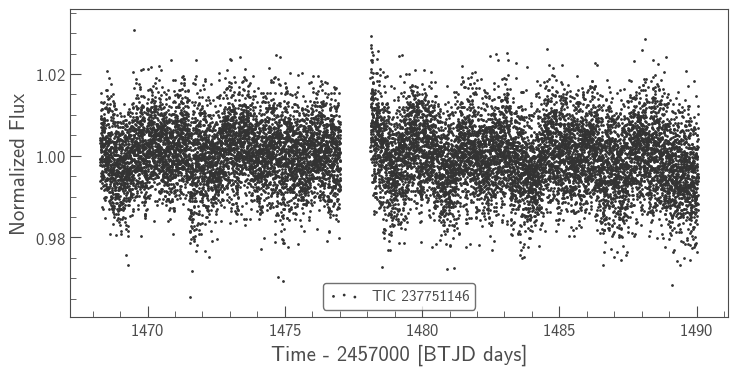

In [4]:
# Download the target pixel files
sr = lk.search_targetpixelfile('TIC %i' % tic)
tpf_collection = sr.download_all()
if tpf_collection is None or not len(tpf_collection):
    raise ValueError("the TESS atlas only works for TPF files")

# tpf_collection[0].to_lightcurve(aperture_mask="pipeline").plot()
# assert 0
    
# Extract the exposure time associated with the TPF
hdr = tpf_collection[0].hdu[1].header
texp = hdr["FRAMETIM"] * hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0

# This function can be used to estimate which data points are in transit
# for known phase, period, and duration
def get_transit_mask(t, t0, period, duration):
    hp = 0.5*period
    return np.abs((t-t0+hp) % period - hp) < 0.5*duration

# Run PLD on each TPF to extract the light curves
lc_collection = []
for tpf in tpf_collection:
    mask = np.zeros_like(tpf.time, dtype=bool)
    for i in range(len(periods)):
        mask |= get_transit_mask(tpf.time, t0s[i], periods[i], 5*durations[i])    
    pld = tpf.to_corrector("pld")
    try:
        lc = pld.correct(aperture_mask="pipeline", cadence_mask=~mask, use_gp=False, pld_order=2)
    except ValueError:
        lc = pld.correct(aperture_mask="pipeline", cadence_mask=~mask, use_gp=False, pld_order=1)
    lc_collection.append(lc.normalize())

# Normalize and stitch the sectors
lc = lc_collection[0]
if len(lc_collection) > 1:
    lc = lc.append([next_lc for next_lc in lc_collection[1:]])
lc = lc.remove_outliers()
    
lc.scatter();

# Removing stellar variability

Next up, we remove stellar variability using a Gaussian Processes model fit to the out of transit data.

In [5]:
# Extract the data and convert to parts per thousand
x = np.ascontiguousarray(lc.time, dtype=np.float64)
y = np.ascontiguousarray((lc.flux - 1.0) * 1e3, dtype=np.float64)
yerr = np.ascontiguousarray(lc.flux_err * 1e3, dtype=np.float64)

# Compute the transit mask
mask = np.zeros_like(x, dtype=bool)
for i in range(len(periods)):
    mask |= get_transit_mask(x, t0s[i], periods[i], 5*durations[i])

# Temporarily increase the in transit error bars substantially
diag = np.array(yerr**2)
diag[mask] *= 1000.0

# Build a GP model
with pm.Model() as model:
    logs2 = pm.Normal("logs2", mu=np.log(1e-4*np.var(y)), sd=10)
    logsigma = pm.Normal("logsigma", mu=np.log(np.std(y)), sd=10)
    logrho = pm.Normal("logrho", mu=np.log(10.0), sd=10.0)
    
    kernel = xo.gp.terms.Matern32Term(log_sigma=logsigma, log_rho=logrho)
    gp = xo.gp.GP(kernel, x, diag + tt.exp(logs2), J=2)
    pm.Potential("loglike", gp.log_likelihood(y))
    
    map_soln = xo.optimize()
    pred = xo.utils.eval_in_model(gp.predict(), map_soln)

# Flatten the light curve
y -= pred

optimizing logp for variables: ['logrho', 'logsigma', 'logs2']


message: Optimization terminated successfully.
logp: -66202.95430582605 -> -65988.06351986133


## Transit model in PyMC3 & exoplanet

Here's how we set up the transit model using [exoplanet](https://exoplanet.dfm.io) and [PyMC3](https://docs.pymc.io).
For more information about how to use these libraries take a look at the docs that are linked above.
In this model, the parameters that we're fitting are:

* `mean`: the mean (out-of-transit) flux of the star,
* `r_star`: the radius of the star (with the prior from the TOI list),
* `logg_star`: the surface gravity of the star (with the prior from the TOI list),
* `u`: the quadratic limb darkening parameters, parameterized following [Kipping (2013)](https://arxiv.org/abs/1308.0009)
* `t0`: the time of a reference transit for each planet,
* `logP`: the log of the obribatl periods,
* `r`: the planet radius ratios (relative to the star),
* `b`: the impact parameter in units of the stellar radius, `b` and `r` are both parameterized following [Espinoza (2018)](https://iopscience.iop.org/article/10.3847/2515-5172/aaef38/meta), and
* `logs2`: a jitter parameter that captures excess noise or underrestimated error bars.

A few key assumptions include:

* The orbits are assumed to be circular so the constraints on impact parameter (which would be severely degenerate with eccentricity) will be tighter than they should be.
* The noise is assumed to be Gaussian and independent. This means that all correlated noise should be removed in advance. Since we flattened the light curve using a Gaussian process above, this should be not totally unreasonable.
* We are neglecting transit times (the ephemeris is assumed to be linear) which should be sufficient for most cases with the short TESS baseline, but transit timing variations could be important for some targets.

In [6]:
# factor * 10**logg / r_star = rho
factor = 5.141596357654149e-05

def build_model(x, y, yerr, periods, t0s, depths, mask=None, start=None):
    """Build an exoplanet model for a dataset and set of planets
    
    Args:
        x: The time series (in days); this should probably be centered
        y: The relative fluxes (in parts per thousand)
        yerr: The uncertainties on ``y``
        periods: The periods of the planets (in days)
        t0s: The phases of the planets in the same coordinates as ``x``
        depths: The depths of the transits in parts per thousand
        mask: A boolean mask with the same shape as ``x`` indicating which
            data points should be included in the fit
        start: A dictionary of model parameters where the optimization
            should be initialized
            
    Returns:
        A PyMC3 model specifying the probabilistic model for the light curve

    """
    if mask is None:
        mask = np.ones(len(x), dtype=bool)
    
    periods = np.atleast_1d(periods)
    t0s = np.atleast_1d(t0s)
    depths = np.atleast_1d(depths)
    n_planets = len(periods)
    
    with pm.Model() as model:
        
        # Extract the un-masked data points
        model.x = x[mask]
        model.y = y[mask]
        model.yerr = (yerr + np.zeros_like(x))[mask]
        model.mask = mask

        # The baseline (out-of-transit) flux for the star in ppt. This
        # should be close to one because of how we normalized the data
        mean = pm.Normal("mean", mu=0.0, sd=10.0)
        
        logg_star = pm.Normal("logg_star", mu=toi_logg_star, sd=toi_logg_star_err)
        r_star = pm.Bound(pm.Normal, lower=0.0)("r_star", mu=toi_r_star, sd=toi_r_star_err)
        rho_star = pm.Deterministic("rho_star", factor * 10**logg_star / r_star)

        # The time of a reference transit for each planet
        t0 = pm.Normal("t0", mu=t0s, sd=1.0, shape=n_planets)

        # The log period; also tracking the period itself
        logP = pm.Normal("logP", mu=np.log(periods), sd=0.1, shape=n_planets)
        period = pm.Deterministic("period", tt.exp(logP))

        # The Kipping (2013) parameterization for quadratic limb darkening paramters
        u = xo.distributions.QuadLimbDark("u")

        # The Espinoza (2018) parameterization for the joint radius ratio and
        # impact parameter distribution
        r, b = xo.distributions.get_joint_radius_impact(
            min_radius=0.001, max_radius=1.0,
            testval_r=np.sqrt(1e-3*np.array(depths)),
            testval_b=0.5+np.zeros(n_planets)
        )
        r_pl = pm.Deterministic("r_pl", r * r_star)

        # This shouldn't make a huge difference, but I like to put a uniform
        # prior on the *log* of the radius ratio instead of the value. This
        # can be implemented by adding a custom "potential" (log probability).
        pm.Potential("r_prior", -pm.math.log(r))

        # Set up a Keplerian orbit for the planets
        model.orbit = xo.orbits.KeplerianOrbit(
            period=period, t0=t0, b=b, r_star=r_star, rho_star=rho_star)
        
        # Compute the model light curve using starry
        model.light_curves = xo.StarryLightCurve(u).get_light_curve(
            orbit=model.orbit, r=r_pl, t=model.x)
        model.light_curve = pm.math.sum(model.light_curves, axis=-1) * 1e3 + mean

        # Jitter and likelihood function
        logs2 = pm.Normal("logs2", mu=np.log(np.mean(model.yerr)), sd=10)
        pm.Normal("obs", mu=model.light_curve, sd=tt.sqrt(model.yerr**2+tt.exp(logs2)),
                  observed=model.y)

        # Fit for the maximum a posteriori parameters, I've found that I can get
        # a better solution by trying different combinations of parameters in turn
        if start is None:
            start = model.test_point
        map_soln = start        
        map_soln = xo.optimize(start=map_soln, vars=[logs2, mean])
        map_soln = xo.optimize(start=map_soln, vars=[model.rb, mean])
        map_soln = xo.optimize(start=map_soln, vars=[logg_star])
        map_soln = xo.optimize(start=map_soln, vars=[logP, t0, mean])
        map_soln = xo.optimize(start=map_soln, vars=[model.rb, mean])
        map_soln = xo.optimize(start=map_soln)
        model.map_soln = map_soln
        
    return model

Using the above function, we'll generate a probabilistic model for the light curve and plot the maximum a posteriori fit.

optimizing logp for variables: ['mean', 'logs2']


message: Optimization terminated successfully.
logp: -52418.01338882044 -> -52292.33069432065


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Optimization terminated successfully.
logp: -52292.33069432065 -> -50852.61223155827


optimizing logp for variables: ['logg_star']


message: Desired error not necessarily achieved due to precision loss.
logp: -50852.61223155827 -> -50837.507012243244


optimizing logp for variables: ['mean', 't0', 'logP']


message: Desired error not necessarily achieved due to precision loss.
logp: -50837.507012243244 -> -50836.22389414664


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Optimization terminated successfully.
logp: -50836.22389414664 -> -50835.97547430243


optimizing logp for variables: ['logs2', 'rb_radiusimpact__', 'u_quadlimbdark__', 'logP', 't0', 'r_star_lowerbound__', 'logg_star', 'mean']


message: Desired error not necessarily achieved due to precision loss.
logp: -50835.97547430243 -> -50698.98200278951


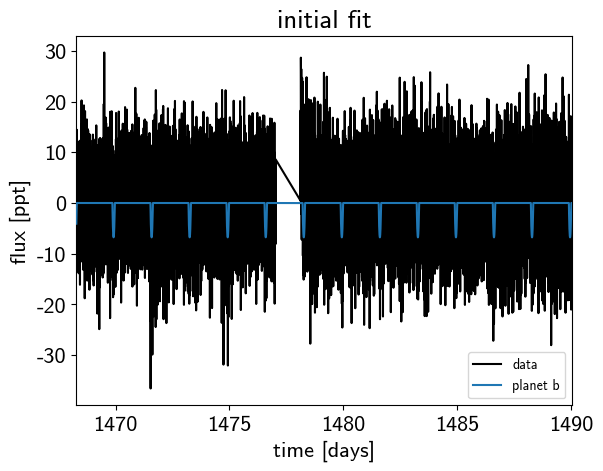

In [7]:
model = build_model(x, y, yerr, periods, t0s, depths)

with model:
    mean = model.map_soln["mean"]
    light_curves = xo.utils.eval_in_model(model.light_curves, model.map_soln)

plt.plot(model.x, model.y - mean, "k", label="data")
for n, l in enumerate(letters):
    plt.plot(model.x, 1e3 * light_curves[:, n], label="planet {0}".format(l), zorder=100-n)

plt.xlabel("time [days]")
plt.ylabel("flux [ppt]")
plt.title("initial fit")
plt.xlim(model.x.min(), model.x.max())
plt.legend(fontsize=10);

## Sampling

Now we use PyMC3 to sample the posterior density for the parameters of this model.

In [8]:
np.random.seed(123)
sampler = xo.PyMC3Sampler(window=50, start=50, finish=500)
with model:
    burnin = sampler.tune(tune=3000, start=model.map_soln,
                          step_kwargs=dict(target_accept=0.9),
                          chains=2, cores=2)
    trace = sampler.sample(draws=1000, chains=2, cores=2)

Sampling 2 chains:   0%|          | 0/104 [00:00<?, ?draws/s]

Sampling 2 chains:   9%|▊         | 9/104 [00:00<00:05, 16.91draws/s]

Sampling 2 chains:  11%|█         | 11/104 [00:01<00:10,  8.54draws/s]

Sampling 2 chains:  12%|█▎        | 13/104 [00:01<00:13,  6.51draws/s]

Sampling 2 chains:  14%|█▍        | 15/104 [00:01<00:16,  5.55draws/s]

Sampling 2 chains:  16%|█▋        | 17/104 [00:02<00:17,  5.05draws/s]

Sampling 2 chains:  17%|█▋        | 18/104 [00:02<00:15,  5.72draws/s]

Sampling 2 chains:  18%|█▊        | 19/104 [00:02<00:20,  4.15draws/s]

Sampling 2 chains:  19%|█▉        | 20/104 [00:03<00:16,  4.97draws/s]

Sampling 2 chains:  20%|██        | 21/104 [00:03<00:20,  3.97draws/s]

Sampling 2 chains:  21%|██        | 22/104 [00:03<00:18,  4.33draws/s]

Sampling 2 chains:  22%|██▏       | 23/104 [00:03<00:21,  3.81draws/s]

Sampling 2 chains:  23%|██▎       | 24/104 [00:04<00:18,  4.31draws/s]

Sampling 2 chains:  24%|██▍       | 25/104 [00:04<00:20,  3.88draws/s]

Sampling 2 chains:  25%|██▌       | 26/104 [00:04<00:19,  4.09draws/s]

Sampling 2 chains:  26%|██▌       | 27/104 [00:04<00:19,  3.87draws/s]

Sampling 2 chains:  27%|██▋       | 28/104 [00:05<00:20,  3.76draws/s]

Sampling 2 chains:  28%|██▊       | 29/104 [00:05<00:18,  4.08draws/s]

Sampling 2 chains:  29%|██▉       | 30/104 [00:05<00:19,  3.82draws/s]

Sampling 2 chains:  30%|██▉       | 31/104 [00:05<00:17,  4.19draws/s]

Sampling 2 chains:  31%|███       | 32/104 [00:06<00:18,  3.90draws/s]

Sampling 2 chains:  32%|███▏      | 33/104 [00:06<00:17,  4.06draws/s]

Sampling 2 chains:  33%|███▎      | 34/104 [00:06<00:19,  3.68draws/s]

Sampling 2 chains:  34%|███▎      | 35/104 [00:06<00:16,  4.24draws/s]

Sampling 2 chains:  35%|███▍      | 36/104 [00:07<00:18,  3.60draws/s]

Sampling 2 chains:  36%|███▌      | 37/104 [00:07<00:15,  4.39draws/s]

Sampling 2 chains:  37%|███▋      | 38/104 [00:07<00:17,  3.71draws/s]

Sampling 2 chains:  38%|███▊      | 39/104 [00:07<00:14,  4.50draws/s]

Sampling 2 chains:  38%|███▊      | 40/104 [00:08<00:17,  3.60draws/s]

Sampling 2 chains:  40%|████      | 42/104 [00:08<00:16,  3.74draws/s]

Sampling 2 chains:  42%|████▏     | 44/104 [00:09<00:16,  3.68draws/s]

Sampling 2 chains:  44%|████▍     | 46/104 [00:09<00:15,  3.72draws/s]

Sampling 2 chains:  46%|████▌     | 48/104 [00:10<00:14,  3.80draws/s]

Sampling 2 chains:  48%|████▊     | 50/104 [00:10<00:13,  3.89draws/s]

Sampling 2 chains:  50%|█████     | 52/104 [00:11<00:13,  3.95draws/s]

Sampling 2 chains:  52%|█████▏    | 54/104 [00:11<00:12,  3.98draws/s]

Sampling 2 chains:  54%|█████▍    | 56/104 [00:12<00:12,  3.91draws/s]

Sampling 2 chains:  56%|█████▌    | 58/104 [00:12<00:11,  3.89draws/s]

Sampling 2 chains:  58%|█████▊    | 60/104 [00:13<00:11,  3.93draws/s]

Sampling 2 chains:  60%|█████▉    | 62/104 [00:13<00:10,  3.88draws/s]

Sampling 2 chains:  62%|██████▏   | 64/104 [00:14<00:10,  3.87draws/s]

Sampling 2 chains:  63%|██████▎   | 66/104 [00:14<00:09,  3.88draws/s]

Sampling 2 chains:  65%|██████▌   | 68/104 [00:15<00:09,  3.81draws/s]

Sampling 2 chains:  67%|██████▋   | 70/104 [00:16<00:09,  3.66draws/s]

Sampling 2 chains:  69%|██████▉   | 72/104 [00:16<00:08,  3.71draws/s]

Sampling 2 chains:  71%|███████   | 74/104 [00:17<00:08,  3.74draws/s]

Sampling 2 chains:  72%|███████▏  | 75/104 [00:17<00:07,  4.11draws/s]

Sampling 2 chains:  73%|███████▎  | 76/104 [00:17<00:07,  3.72draws/s]

Sampling 2 chains:  74%|███████▍  | 77/104 [00:17<00:07,  3.81draws/s]

Sampling 2 chains:  75%|███████▌  | 78/104 [00:18<00:06,  3.80draws/s]

Sampling 2 chains:  76%|███████▌  | 79/104 [00:18<00:06,  3.74draws/s]

Sampling 2 chains:  77%|███████▋  | 80/104 [00:18<00:07,  3.41draws/s]

Sampling 2 chains:  78%|███████▊  | 81/104 [00:19<00:06,  3.57draws/s]

Sampling 2 chains:  79%|███████▉  | 82/104 [00:19<00:06,  3.65draws/s]

Sampling 2 chains:  80%|███████▉  | 83/104 [00:19<00:05,  3.65draws/s]

Sampling 2 chains:  81%|████████  | 84/104 [00:19<00:05,  3.91draws/s]

Sampling 2 chains:  82%|████████▏ | 85/104 [00:20<00:05,  3.49draws/s]

Sampling 2 chains:  83%|████████▎ | 86/104 [00:20<00:04,  4.10draws/s]

Sampling 2 chains:  84%|████████▎ | 87/104 [00:20<00:04,  3.41draws/s]

Sampling 2 chains:  85%|████████▍ | 88/104 [00:20<00:03,  4.02draws/s]

Sampling 2 chains:  86%|████████▌ | 89/104 [00:21<00:04,  3.59draws/s]

Sampling 2 chains:  87%|████████▋ | 90/104 [00:21<00:03,  3.89draws/s]

Sampling 2 chains:  88%|████████▊ | 91/104 [00:21<00:03,  3.65draws/s]

Sampling 2 chains:  88%|████████▊ | 92/104 [00:21<00:03,  3.83draws/s]

Sampling 2 chains:  89%|████████▉ | 93/104 [00:22<00:02,  3.68draws/s]

Sampling 2 chains:  90%|█████████ | 94/104 [00:22<00:02,  3.90draws/s]

Sampling 2 chains:  91%|█████████▏| 95/104 [00:22<00:02,  3.67draws/s]

Sampling 2 chains:  92%|█████████▏| 96/104 [00:22<00:01,  4.15draws/s]

Sampling 2 chains:  93%|█████████▎| 97/104 [00:23<00:01,  3.68draws/s]

Sampling 2 chains:  94%|█████████▍| 98/104 [00:23<00:01,  4.33draws/s]

Sampling 2 chains:  95%|█████████▌| 99/104 [00:23<00:01,  3.73draws/s]

Sampling 2 chains:  96%|█████████▌| 100/104 [00:23<00:00,  4.41draws/s]

Sampling 2 chains:  97%|█████████▋| 101/104 [00:24<00:00,  3.77draws/s]

Sampling 2 chains:  98%|█████████▊| 102/104 [00:24<00:00,  2.94draws/s]

Sampling 2 chains:  99%|█████████▉| 103/104 [00:25<00:00,  1.79draws/s]

Sampling 2 chains: 100%|██████████| 104/104 [00:26<00:00,  1.53draws/s]

Sampling 2 chains:   0%|          | 0/104 [00:00<?, ?draws/s]

Sampling 2 chains:   9%|▊         | 9/104 [00:00<00:05, 15.90draws/s]

Sampling 2 chains:  11%|█         | 11/104 [00:01<00:11,  8.16draws/s]

Sampling 2 chains:  12%|█▏        | 12/104 [00:01<00:11,  7.78draws/s]

Sampling 2 chains:  12%|█▎        | 13/104 [00:01<00:19,  4.64draws/s]

Sampling 2 chains:  13%|█▎        | 14/104 [00:01<00:20,  4.49draws/s]

Sampling 2 chains:  14%|█▍        | 15/104 [00:02<00:22,  3.98draws/s]

Sampling 2 chains:  15%|█▌        | 16/104 [00:02<00:22,  3.98draws/s]

Sampling 2 chains:  16%|█▋        | 17/104 [00:02<00:27,  3.20draws/s]

Sampling 2 chains:  17%|█▋        | 18/104 [00:03<00:21,  3.94draws/s]

Sampling 2 chains:  18%|█▊        | 19/104 [00:03<00:26,  3.26draws/s]

Sampling 2 chains:  19%|█▉        | 20/104 [00:03<00:25,  3.25draws/s]

Sampling 2 chains:  20%|██        | 21/104 [00:04<00:24,  3.32draws/s]

Sampling 2 chains:  21%|██        | 22/104 [00:04<00:25,  3.19draws/s]

Sampling 2 chains:  22%|██▏       | 23/104 [00:04<00:25,  3.19draws/s]

Sampling 2 chains:  23%|██▎       | 24/104 [00:05<00:26,  3.04draws/s]

Sampling 2 chains:  24%|██▍       | 25/104 [00:05<00:21,  3.65draws/s]

Sampling 2 chains:  25%|██▌       | 26/104 [00:05<00:26,  2.89draws/s]

Sampling 2 chains:  27%|██▋       | 28/104 [00:06<00:24,  3.05draws/s]

Sampling 2 chains:  29%|██▉       | 30/104 [00:06<00:22,  3.25draws/s]

Sampling 2 chains:  30%|██▉       | 31/104 [00:06<00:18,  3.96draws/s]

Sampling 2 chains:  31%|███       | 32/104 [00:07<00:20,  3.47draws/s]

Sampling 2 chains:  32%|███▏      | 33/104 [00:07<00:21,  3.37draws/s]

Sampling 2 chains:  33%|███▎      | 34/104 [00:07<00:19,  3.51draws/s]

Sampling 2 chains:  34%|███▎      | 35/104 [00:08<00:20,  3.30draws/s]

Sampling 2 chains:  35%|███▍      | 36/104 [00:08<00:16,  4.01draws/s]

Sampling 2 chains:  37%|███▋      | 38/104 [00:08<00:17,  3.87draws/s]

Sampling 2 chains:  38%|███▊      | 39/104 [00:09<00:13,  4.71draws/s]

Sampling 2 chains:  38%|███▊      | 40/104 [00:09<00:18,  3.42draws/s]

Sampling 2 chains:  39%|███▉      | 41/104 [00:09<00:17,  3.51draws/s]

Sampling 2 chains:  41%|████▏     | 43/104 [00:10<00:17,  3.51draws/s]

Sampling 2 chains:  42%|████▏     | 44/104 [00:10<00:13,  4.30draws/s]

Sampling 2 chains:  43%|████▎     | 45/104 [00:10<00:17,  3.39draws/s]

Sampling 2 chains:  44%|████▍     | 46/104 [00:11<00:14,  4.02draws/s]

Sampling 2 chains:  45%|████▌     | 47/104 [00:11<00:16,  3.52draws/s]

Sampling 2 chains:  46%|████▌     | 48/104 [00:11<00:13,  4.18draws/s]

Sampling 2 chains:  47%|████▋     | 49/104 [00:11<00:15,  3.47draws/s]

Sampling 2 chains:  49%|████▉     | 51/104 [00:12<00:14,  3.54draws/s]

Sampling 2 chains:  50%|█████     | 52/104 [00:12<00:14,  3.65draws/s]

Sampling 2 chains:  51%|█████     | 53/104 [00:13<00:14,  3.51draws/s]

Sampling 2 chains:  52%|█████▏    | 54/104 [00:13<00:14,  3.42draws/s]

Sampling 2 chains:  53%|█████▎    | 55/104 [00:13<00:13,  3.70draws/s]

Sampling 2 chains:  54%|█████▍    | 56/104 [00:13<00:13,  3.48draws/s]

Sampling 2 chains:  55%|█████▍    | 57/104 [00:14<00:12,  3.86draws/s]

Sampling 2 chains:  56%|█████▌    | 58/104 [00:14<00:13,  3.41draws/s]

Sampling 2 chains:  57%|█████▋    | 59/104 [00:14<00:11,  3.88draws/s]

Sampling 2 chains:  58%|█████▊    | 60/104 [00:14<00:12,  3.50draws/s]

Sampling 2 chains:  59%|█████▊    | 61/104 [00:15<00:11,  3.88draws/s]

Sampling 2 chains:  60%|█████▉    | 62/104 [00:15<00:11,  3.72draws/s]

Sampling 2 chains:  61%|██████    | 63/104 [00:15<00:10,  3.85draws/s]

Sampling 2 chains:  62%|██████▏   | 64/104 [00:15<00:10,  3.82draws/s]

Sampling 2 chains:  62%|██████▎   | 65/104 [00:16<00:09,  3.90draws/s]

Sampling 2 chains:  63%|██████▎   | 66/104 [00:16<00:09,  3.95draws/s]

Sampling 2 chains:  64%|██████▍   | 67/104 [00:16<00:09,  3.85draws/s]

Sampling 2 chains:  65%|██████▌   | 68/104 [00:16<00:07,  4.60draws/s]

Sampling 2 chains:  66%|██████▋   | 69/104 [00:17<00:09,  3.70draws/s]

Sampling 2 chains:  67%|██████▋   | 70/104 [00:17<00:07,  4.45draws/s]

Sampling 2 chains:  68%|██████▊   | 71/104 [00:17<00:08,  3.69draws/s]

Sampling 2 chains:  69%|██████▉   | 72/104 [00:17<00:07,  4.39draws/s]

Sampling 2 chains:  70%|███████   | 73/104 [00:18<00:08,  3.69draws/s]

Sampling 2 chains:  71%|███████   | 74/104 [00:18<00:07,  4.04draws/s]

Sampling 2 chains:  72%|███████▏  | 75/104 [00:18<00:08,  3.57draws/s]

Sampling 2 chains:  73%|███████▎  | 76/104 [00:18<00:07,  3.98draws/s]

Sampling 2 chains:  74%|███████▍  | 77/104 [00:19<00:07,  3.68draws/s]

Sampling 2 chains:  75%|███████▌  | 78/104 [00:19<00:06,  4.00draws/s]

Sampling 2 chains:  76%|███████▌  | 79/104 [00:19<00:07,  3.54draws/s]

Sampling 2 chains:  77%|███████▋  | 80/104 [00:20<00:05,  4.05draws/s]

Sampling 2 chains:  78%|███████▊  | 81/104 [00:20<00:06,  3.49draws/s]

Sampling 2 chains:  80%|███████▉  | 83/104 [00:20<00:04,  4.29draws/s]

Sampling 2 chains:  81%|████████  | 84/104 [00:20<00:05,  3.67draws/s]

Sampling 2 chains:  82%|████████▏ | 85/104 [00:21<00:04,  4.28draws/s]

Sampling 2 chains:  83%|████████▎ | 86/104 [00:21<00:05,  3.27draws/s]

Sampling 2 chains:  85%|████████▍ | 88/104 [00:22<00:04,  3.38draws/s]

Sampling 2 chains:  87%|████████▋ | 90/104 [00:22<00:04,  3.49draws/s]

Sampling 2 chains:  88%|████████▊ | 92/104 [00:23<00:03,  3.69draws/s]

Sampling 2 chains:  89%|████████▉ | 93/104 [00:23<00:02,  4.27draws/s]

Sampling 2 chains:  90%|█████████ | 94/104 [00:23<00:02,  3.83draws/s]

Sampling 2 chains:  91%|█████████▏| 95/104 [00:23<00:02,  4.12draws/s]

Sampling 2 chains:  92%|█████████▏| 96/104 [00:24<00:02,  3.86draws/s]

Sampling 2 chains:  93%|█████████▎| 97/104 [00:24<00:01,  3.98draws/s]

Sampling 2 chains:  94%|█████████▍| 98/104 [00:24<00:01,  4.04draws/s]

Sampling 2 chains:  95%|█████████▌| 99/104 [00:24<00:01,  3.83draws/s]

Sampling 2 chains:  96%|█████████▌| 100/104 [00:25<00:00,  4.21draws/s]

Sampling 2 chains:  97%|█████████▋| 101/104 [00:25<00:00,  3.60draws/s]

Sampling 2 chains:  98%|█████████▊| 102/104 [00:25<00:00,  4.42draws/s]

Sampling 2 chains:  99%|█████████▉| 103/104 [00:27<00:00,  1.34draws/s]

Sampling 2 chains: 100%|██████████| 104/104 [00:27<00:00,  1.77draws/s]

Sampling 2 chains:   0%|          | 0/204 [00:00<?, ?draws/s]

Sampling 2 chains:   3%|▎         | 7/204 [00:00<00:02, 67.00draws/s]

Sampling 2 chains:   5%|▍         | 10/204 [00:00<00:08, 24.21draws/s]

Sampling 2 chains:   6%|▌         | 12/204 [00:00<00:16, 11.49draws/s]

Sampling 2 chains:   7%|▋         | 14/204 [00:01<00:23,  8.07draws/s]

Sampling 2 chains:   8%|▊         | 16/204 [00:01<00:23,  8.02draws/s]

Sampling 2 chains:   8%|▊         | 17/204 [00:01<00:44,  4.19draws/s]

Sampling 2 chains:   9%|▉         | 19/204 [00:02<00:45,  4.05draws/s]

Sampling 2 chains:  10%|█         | 21/204 [00:02<00:44,  4.10draws/s]

Sampling 2 chains:  11%|█         | 22/204 [00:03<00:37,  4.79draws/s]

Sampling 2 chains:  11%|█▏        | 23/204 [00:03<00:49,  3.64draws/s]

Sampling 2 chains:  12%|█▏        | 24/204 [00:03<00:41,  4.34draws/s]

Sampling 2 chains:  12%|█▏        | 25/204 [00:04<00:54,  3.31draws/s]

Sampling 2 chains:  13%|█▎        | 27/204 [00:04<00:40,  4.39draws/s]

Sampling 2 chains:  14%|█▎        | 28/204 [00:04<00:55,  3.16draws/s]

Sampling 2 chains:  15%|█▍        | 30/204 [00:05<00:53,  3.23draws/s]

Sampling 2 chains:  16%|█▌        | 32/204 [00:05<00:45,  3.80draws/s]

Sampling 2 chains:  17%|█▋        | 34/204 [00:05<00:37,  4.54draws/s]

Sampling 2 chains:  18%|█▊        | 36/204 [00:06<00:39,  4.22draws/s]

Sampling 2 chains:  19%|█▊        | 38/204 [00:06<00:31,  5.29draws/s]

Sampling 2 chains:  19%|█▉        | 39/204 [00:07<00:48,  3.43draws/s]

Sampling 2 chains:  20%|██        | 41/204 [00:07<00:46,  3.50draws/s]

Sampling 2 chains:  21%|██        | 43/204 [00:08<00:40,  3.94draws/s]

Sampling 2 chains:  22%|██▏       | 44/204 [00:08<00:33,  4.74draws/s]

Sampling 2 chains:  22%|██▏       | 45/204 [00:08<00:34,  4.58draws/s]

Sampling 2 chains:  23%|██▎       | 46/204 [00:08<00:36,  4.28draws/s]

Sampling 2 chains:  23%|██▎       | 47/204 [00:08<00:37,  4.18draws/s]

Sampling 2 chains:  24%|██▎       | 48/204 [00:09<00:30,  5.03draws/s]

Sampling 2 chains:  24%|██▍       | 49/204 [00:09<00:30,  5.01draws/s]

Sampling 2 chains:  25%|██▍       | 50/204 [00:09<00:40,  3.82draws/s]

Sampling 2 chains:  25%|██▌       | 52/204 [00:10<00:37,  4.03draws/s]

Sampling 2 chains:  26%|██▋       | 54/204 [00:10<00:29,  5.03draws/s]

Sampling 2 chains:  27%|██▋       | 55/204 [00:10<00:27,  5.52draws/s]

Sampling 2 chains:  28%|██▊       | 57/204 [00:10<00:21,  6.78draws/s]

Sampling 2 chains:  28%|██▊       | 58/204 [00:10<00:35,  4.15draws/s]

Sampling 2 chains:  29%|██▉       | 60/204 [00:11<00:35,  4.08draws/s]

Sampling 2 chains:  30%|███       | 62/204 [00:12<00:36,  3.86draws/s]

Sampling 2 chains:  31%|███▏      | 64/204 [00:12<00:33,  4.14draws/s]

Sampling 2 chains:  32%|███▏      | 65/204 [00:12<00:34,  4.01draws/s]

Sampling 2 chains:  32%|███▏      | 66/204 [00:12<00:34,  4.00draws/s]

Sampling 2 chains:  33%|███▎      | 67/204 [00:13<00:36,  3.74draws/s]

Sampling 2 chains:  33%|███▎      | 68/204 [00:13<00:38,  3.51draws/s]

Sampling 2 chains:  34%|███▍      | 70/204 [00:14<00:34,  3.87draws/s]

Sampling 2 chains:  35%|███▍      | 71/204 [00:14<00:32,  4.09draws/s]

Sampling 2 chains:  35%|███▌      | 72/204 [00:14<00:41,  3.15draws/s]

Sampling 2 chains:  36%|███▋      | 74/204 [00:14<00:34,  3.76draws/s]

Sampling 2 chains:  37%|███▋      | 76/204 [00:15<00:33,  3.76draws/s]

Sampling 2 chains:  38%|███▊      | 78/204 [00:15<00:29,  4.21draws/s]

Sampling 2 chains:  39%|███▊      | 79/204 [00:16<00:30,  4.13draws/s]

Sampling 2 chains:  39%|███▉      | 80/204 [00:16<00:28,  4.36draws/s]

Sampling 2 chains:  40%|███▉      | 81/204 [00:16<00:25,  4.87draws/s]

Sampling 2 chains:  41%|████      | 83/204 [00:16<00:26,  4.60draws/s]

Sampling 2 chains:  42%|████▏     | 85/204 [00:17<00:19,  5.98draws/s]

Sampling 2 chains:  42%|████▏     | 86/204 [00:17<00:33,  3.48draws/s]

Sampling 2 chains:  43%|████▎     | 88/204 [00:18<00:32,  3.54draws/s]

Sampling 2 chains:  44%|████▎     | 89/204 [00:18<00:27,  4.13draws/s]

Sampling 2 chains:  44%|████▍     | 90/204 [00:18<00:32,  3.46draws/s]

Sampling 2 chains:  45%|████▍     | 91/204 [00:18<00:28,  3.93draws/s]

Sampling 2 chains:  45%|████▌     | 92/204 [00:19<00:32,  3.40draws/s]

Sampling 2 chains:  46%|████▌     | 93/204 [00:19<00:27,  4.01draws/s]

Sampling 2 chains:  46%|████▌     | 94/204 [00:19<00:34,  3.23draws/s]

Sampling 2 chains:  47%|████▋     | 95/204 [00:20<00:28,  3.88draws/s]

Sampling 2 chains:  47%|████▋     | 96/204 [00:20<00:33,  3.25draws/s]

Sampling 2 chains:  48%|████▊     | 97/204 [00:20<00:26,  3.98draws/s]

Sampling 2 chains:  48%|████▊     | 98/204 [00:21<00:35,  3.03draws/s]

Sampling 2 chains:  49%|████▉     | 100/204 [00:21<00:29,  3.48draws/s]

Sampling 2 chains:  50%|████▉     | 101/204 [00:21<00:28,  3.64draws/s]

Sampling 2 chains:  50%|█████     | 102/204 [00:21<00:24,  4.23draws/s]

Sampling 2 chains:  50%|█████     | 103/204 [00:22<00:28,  3.58draws/s]

Sampling 2 chains:  51%|█████     | 104/204 [00:22<00:26,  3.77draws/s]

Sampling 2 chains:  52%|█████▏    | 107/204 [00:22<00:20,  4.62draws/s]

Sampling 2 chains:  53%|█████▎    | 109/204 [00:23<00:21,  4.41draws/s]

Sampling 2 chains:  55%|█████▍    | 112/204 [00:23<00:18,  4.89draws/s]

Sampling 2 chains:  56%|█████▌    | 114/204 [00:24<00:17,  5.04draws/s]

Sampling 2 chains:  56%|█████▋    | 115/204 [00:24<00:19,  4.65draws/s]

Sampling 2 chains:  57%|█████▋    | 117/204 [00:24<00:20,  4.28draws/s]

Sampling 2 chains:  59%|█████▉    | 120/204 [00:25<00:15,  5.56draws/s]

Sampling 2 chains:  60%|█████▉    | 122/204 [00:25<00:12,  6.50draws/s]

Sampling 2 chains:  60%|██████    | 123/204 [00:25<00:13,  6.06draws/s]

Sampling 2 chains:  61%|██████▏   | 125/204 [00:25<00:12,  6.22draws/s]

Sampling 2 chains:  62%|██████▏   | 126/204 [00:25<00:11,  6.65draws/s]

Sampling 2 chains:  63%|██████▎   | 128/204 [00:26<00:09,  7.75draws/s]

Sampling 2 chains:  63%|██████▎   | 129/204 [00:26<00:16,  4.47draws/s]

Sampling 2 chains:  65%|██████▍   | 132/204 [00:26<00:12,  5.58draws/s]

Sampling 2 chains:  65%|██████▌   | 133/204 [00:26<00:13,  5.19draws/s]

Sampling 2 chains:  66%|██████▌   | 135/204 [00:27<00:13,  5.08draws/s]

Sampling 2 chains:  67%|██████▋   | 136/204 [00:27<00:12,  5.46draws/s]

Sampling 2 chains:  67%|██████▋   | 137/204 [00:27<00:12,  5.47draws/s]

Sampling 2 chains:  68%|██████▊   | 138/204 [00:27<00:14,  4.64draws/s]

Sampling 2 chains:  68%|██████▊   | 139/204 [00:28<00:13,  4.84draws/s]

Sampling 2 chains:  69%|██████▊   | 140/204 [00:28<00:14,  4.29draws/s]

Sampling 2 chains:  70%|██████▉   | 142/204 [00:28<00:14,  4.23draws/s]

Sampling 2 chains:  71%|███████   | 145/204 [00:29<00:10,  5.58draws/s]

Sampling 2 chains:  72%|███████▏  | 146/204 [00:29<00:14,  3.90draws/s]

Sampling 2 chains:  73%|███████▎  | 148/204 [00:29<00:11,  5.05draws/s]

Sampling 2 chains:  74%|███████▎  | 150/204 [00:29<00:09,  5.85draws/s]

Sampling 2 chains:  74%|███████▍  | 151/204 [00:30<00:10,  4.98draws/s]

Sampling 2 chains:  75%|███████▍  | 152/204 [00:30<00:10,  4.82draws/s]

Sampling 2 chains:  75%|███████▌  | 154/204 [00:30<00:09,  5.46draws/s]

Sampling 2 chains:  76%|███████▌  | 155/204 [00:30<00:10,  4.77draws/s]

Sampling 2 chains:  76%|███████▋  | 156/204 [00:31<00:10,  4.67draws/s]

Sampling 2 chains:  77%|███████▋  | 157/204 [00:31<00:10,  4.42draws/s]

Sampling 2 chains:  78%|███████▊  | 160/204 [00:31<00:07,  5.87draws/s]

Sampling 2 chains:  79%|███████▉  | 162/204 [00:31<00:07,  5.49draws/s]

Sampling 2 chains:  80%|████████  | 164/204 [00:32<00:07,  5.02draws/s]

Sampling 2 chains:  81%|████████▏ | 166/204 [00:32<00:08,  4.74draws/s]

Sampling 2 chains:  82%|████████▏ | 168/204 [00:33<00:07,  4.58draws/s]

Sampling 2 chains:  83%|████████▎ | 170/204 [00:33<00:05,  5.75draws/s]

Sampling 2 chains:  84%|████████▍ | 171/204 [00:33<00:08,  4.07draws/s]

Sampling 2 chains:  85%|████████▍ | 173/204 [00:33<00:06,  5.16draws/s]

Sampling 2 chains:  85%|████████▌ | 174/204 [00:34<00:07,  4.26draws/s]

Sampling 2 chains:  86%|████████▌ | 175/204 [00:34<00:05,  4.84draws/s]

Sampling 2 chains:  86%|████████▋ | 176/204 [00:34<00:05,  5.56draws/s]

Sampling 2 chains:  87%|████████▋ | 177/204 [00:34<00:05,  5.21draws/s]

Sampling 2 chains:  88%|████████▊ | 179/204 [00:35<00:04,  5.82draws/s]

Sampling 2 chains:  89%|████████▊ | 181/204 [00:35<00:04,  5.25draws/s]

Sampling 2 chains:  90%|████████▉ | 183/204 [00:35<00:03,  5.94draws/s]

Sampling 2 chains:  90%|█████████ | 184/204 [00:36<00:04,  4.72draws/s]

Sampling 2 chains:  91%|█████████ | 186/204 [00:36<00:03,  5.47draws/s]

Sampling 2 chains:  92%|█████████▏| 187/204 [00:36<00:03,  4.90draws/s]

Sampling 2 chains:  93%|█████████▎| 189/204 [00:36<00:02,  6.00draws/s]

Sampling 2 chains:  93%|█████████▎| 190/204 [00:37<00:02,  4.85draws/s]

Sampling 2 chains:  94%|█████████▎| 191/204 [00:37<00:02,  5.51draws/s]

Sampling 2 chains:  94%|█████████▍| 192/204 [00:37<00:02,  5.88draws/s]

Sampling 2 chains:  95%|█████████▌| 194/204 [00:37<00:01,  5.24draws/s]

Sampling 2 chains:  96%|█████████▌| 195/204 [00:38<00:02,  3.62draws/s]

Sampling 2 chains:  96%|█████████▌| 196/204 [00:38<00:02,  2.98draws/s]

Sampling 2 chains:  97%|█████████▋| 197/204 [00:39<00:02,  2.65draws/s]

Sampling 2 chains:  97%|█████████▋| 198/204 [00:39<00:02,  2.45draws/s]

Sampling 2 chains:  98%|█████████▊| 199/204 [00:39<00:01,  2.77draws/s]

Sampling 2 chains:  98%|█████████▊| 200/204 [00:40<00:01,  2.95draws/s]

Sampling 2 chains:  99%|█████████▊| 201/204 [00:40<00:01,  2.39draws/s]

Sampling 2 chains:  99%|█████████▉| 202/204 [00:41<00:00,  2.01draws/s]

Sampling 2 chains: 100%|█████████▉| 203/204 [00:41<00:00,  2.18draws/s]

Sampling 2 chains: 100%|██████████| 204/204 [00:42<00:00,  2.35draws/s]

Sampling 2 chains:   0%|          | 0/404 [00:00<?, ?draws/s]

Sampling 2 chains:   1%|▏         | 6/404 [00:00<00:08, 48.68draws/s]

Sampling 2 chains:   2%|▏         | 8/404 [00:00<00:45,  8.73draws/s]

Sampling 2 chains:   2%|▏         | 10/404 [00:01<01:11,  5.54draws/s]

Sampling 2 chains:   3%|▎         | 12/404 [00:02<01:24,  4.63draws/s]

Sampling 2 chains:   3%|▎         | 13/404 [00:02<01:18,  4.96draws/s]

Sampling 2 chains:   3%|▎         | 14/404 [00:02<02:01,  3.22draws/s]

Sampling 2 chains:   4%|▍         | 16/404 [00:03<02:02,  3.18draws/s]

Sampling 2 chains:   4%|▍         | 18/404 [00:04<01:59,  3.24draws/s]

Sampling 2 chains:   5%|▍         | 20/404 [00:04<01:59,  3.21draws/s]

Sampling 2 chains:   5%|▌         | 21/404 [00:04<01:39,  3.86draws/s]

Sampling 2 chains:   5%|▌         | 22/404 [00:05<02:12,  2.89draws/s]

Sampling 2 chains:   6%|▌         | 24/404 [00:05<02:00,  3.15draws/s]

Sampling 2 chains:   6%|▋         | 26/404 [00:06<01:53,  3.32draws/s]

Sampling 2 chains:   7%|▋         | 28/404 [00:06<01:49,  3.45draws/s]

Sampling 2 chains:   7%|▋         | 29/404 [00:07<01:31,  4.10draws/s]

Sampling 2 chains:   7%|▋         | 30/404 [00:07<01:48,  3.45draws/s]

Sampling 2 chains:   8%|▊         | 31/404 [00:07<01:31,  4.08draws/s]

Sampling 2 chains:   8%|▊         | 33/404 [00:08<01:32,  4.00draws/s]

Sampling 2 chains:   8%|▊         | 34/404 [00:08<01:17,  4.76draws/s]

Sampling 2 chains:   9%|▊         | 35/404 [00:08<01:39,  3.71draws/s]

Sampling 2 chains:   9%|▉         | 36/404 [00:08<01:21,  4.52draws/s]

Sampling 2 chains:   9%|▉         | 37/404 [00:09<01:44,  3.52draws/s]

Sampling 2 chains:  10%|▉         | 39/404 [00:09<01:36,  3.78draws/s]

Sampling 2 chains:  10%|█         | 41/404 [00:10<01:37,  3.74draws/s]

Sampling 2 chains:  11%|█         | 43/404 [00:10<01:36,  3.76draws/s]

Sampling 2 chains:  11%|█         | 45/404 [00:11<01:27,  4.12draws/s]

Sampling 2 chains:  11%|█▏        | 46/404 [00:11<01:17,  4.63draws/s]

Sampling 2 chains:  12%|█▏        | 48/404 [00:11<01:20,  4.41draws/s]

Sampling 2 chains:  12%|█▏        | 50/404 [00:12<01:29,  3.94draws/s]

Sampling 2 chains:  13%|█▎        | 52/404 [00:12<01:17,  4.55draws/s]

Sampling 2 chains:  13%|█▎        | 54/404 [00:12<01:09,  5.05draws/s]

Sampling 2 chains:  14%|█▎        | 55/404 [00:13<01:02,  5.59draws/s]

Sampling 2 chains:  14%|█▍        | 56/404 [00:13<00:57,  6.03draws/s]

Sampling 2 chains:  14%|█▍        | 57/404 [00:13<00:51,  6.68draws/s]

Sampling 2 chains:  15%|█▍        | 60/404 [00:13<00:40,  8.47draws/s]

Sampling 2 chains:  15%|█▌        | 62/404 [00:13<00:34,  9.88draws/s]

Sampling 2 chains:  16%|█▌        | 65/404 [00:13<00:29, 11.69draws/s]

Sampling 2 chains:  17%|█▋        | 68/404 [00:13<00:23, 14.20draws/s]

Sampling 2 chains:  17%|█▋        | 70/404 [00:13<00:22, 15.16draws/s]

Sampling 2 chains:  18%|█▊        | 72/404 [00:14<00:22, 14.50draws/s]

Sampling 2 chains:  19%|█▊        | 75/404 [00:14<00:20, 16.33draws/s]

Sampling 2 chains:  19%|█▉        | 77/404 [00:14<00:21, 15.29draws/s]

Sampling 2 chains:  20%|█▉        | 80/404 [00:14<00:18, 17.18draws/s]

Sampling 2 chains:  21%|██        | 83/404 [00:14<00:17, 17.92draws/s]

Sampling 2 chains:  21%|██▏       | 86/404 [00:14<00:17, 18.22draws/s]

Sampling 2 chains:  22%|██▏       | 89/404 [00:14<00:16, 19.47draws/s]

Sampling 2 chains:  23%|██▎       | 92/404 [00:15<00:28, 11.05draws/s]

Sampling 2 chains:  23%|██▎       | 94/404 [00:15<00:28, 10.78draws/s]

Sampling 2 chains:  24%|██▍       | 96/404 [00:16<00:38,  7.97draws/s]

Sampling 2 chains:  24%|██▍       | 98/404 [00:16<00:44,  6.83draws/s]

Sampling 2 chains:  25%|██▍       | 100/404 [00:16<00:38,  7.91draws/s]

Sampling 2 chains:  25%|██▌       | 102/404 [00:16<00:38,  7.88draws/s]

Sampling 2 chains:  26%|██▌       | 104/404 [00:17<00:32,  9.22draws/s]

Sampling 2 chains:  27%|██▋       | 108/404 [00:17<00:25, 11.78draws/s]

Sampling 2 chains:  27%|██▋       | 110/404 [00:17<00:24, 11.95draws/s]

Sampling 2 chains:  28%|██▊       | 112/404 [00:17<00:27, 10.67draws/s]

Sampling 2 chains:  28%|██▊       | 114/404 [00:17<00:26, 10.90draws/s]

Sampling 2 chains:  29%|██▊       | 116/404 [00:17<00:29,  9.68draws/s]

Sampling 2 chains:  29%|██▉       | 118/404 [00:18<00:33,  8.48draws/s]

Sampling 2 chains:  30%|██▉       | 120/404 [00:18<00:29,  9.62draws/s]

Sampling 2 chains:  30%|███       | 122/404 [00:18<00:28,  9.75draws/s]

Sampling 2 chains:  31%|███       | 124/404 [00:18<00:26, 10.59draws/s]

Sampling 2 chains:  31%|███       | 126/404 [00:18<00:23, 11.73draws/s]

Sampling 2 chains:  32%|███▏      | 128/404 [00:19<00:30,  9.05draws/s]

Sampling 2 chains:  32%|███▏      | 130/404 [00:19<00:36,  7.53draws/s]

Sampling 2 chains:  33%|███▎      | 132/404 [00:19<00:30,  8.79draws/s]

Sampling 2 chains:  33%|███▎      | 134/404 [00:19<00:26, 10.27draws/s]

Sampling 2 chains:  34%|███▎      | 136/404 [00:20<00:25, 10.38draws/s]

Sampling 2 chains:  34%|███▍      | 138/404 [00:20<00:26, 10.12draws/s]

Sampling 2 chains:  35%|███▍      | 140/404 [00:20<00:24, 10.93draws/s]

Sampling 2 chains:  35%|███▌      | 142/404 [00:20<00:26,  9.95draws/s]

Sampling 2 chains:  36%|███▌      | 144/404 [00:20<00:24, 10.46draws/s]

Sampling 2 chains:  36%|███▌      | 146/404 [00:21<00:28,  9.11draws/s]

Sampling 2 chains:  37%|███▋      | 148/404 [00:21<00:24, 10.37draws/s]

Sampling 2 chains:  37%|███▋      | 150/404 [00:21<00:22, 11.16draws/s]

Sampling 2 chains:  38%|███▊      | 154/404 [00:21<00:18, 13.34draws/s]

Sampling 2 chains:  39%|███▊      | 156/404 [00:21<00:16, 14.76draws/s]

Sampling 2 chains:  39%|███▉      | 158/404 [00:21<00:16, 15.27draws/s]

Sampling 2 chains:  40%|███▉      | 160/404 [00:21<00:19, 12.66draws/s]

Sampling 2 chains:  40%|████      | 162/404 [00:22<00:19, 12.50draws/s]

Sampling 2 chains:  41%|████      | 164/404 [00:22<00:18, 12.87draws/s]

Sampling 2 chains:  41%|████      | 166/404 [00:22<00:17, 13.79draws/s]

Sampling 2 chains:  42%|████▏     | 168/404 [00:22<00:18, 13.09draws/s]

Sampling 2 chains:  42%|████▏     | 170/404 [00:22<00:16, 14.45draws/s]

Sampling 2 chains:  43%|████▎     | 172/404 [00:22<00:14, 15.51draws/s]

Sampling 2 chains:  43%|████▎     | 174/404 [00:22<00:14, 15.73draws/s]

Sampling 2 chains:  44%|████▎     | 176/404 [00:23<00:15, 15.00draws/s]

Sampling 2 chains:  44%|████▍     | 179/404 [00:23<00:14, 16.02draws/s]

Sampling 2 chains:  45%|████▌     | 182/404 [00:23<00:12, 17.35draws/s]

Sampling 2 chains:  46%|████▌     | 184/404 [00:23<00:15, 14.60draws/s]

Sampling 2 chains:  46%|████▌     | 186/404 [00:23<00:17, 12.82draws/s]

Sampling 2 chains:  47%|████▋     | 188/404 [00:23<00:16, 12.81draws/s]

Sampling 2 chains:  47%|████▋     | 190/404 [00:24<00:16, 12.79draws/s]

Sampling 2 chains:  48%|████▊     | 192/404 [00:24<00:15, 13.35draws/s]

Sampling 2 chains:  48%|████▊     | 194/404 [00:24<00:14, 14.08draws/s]

Sampling 2 chains:  49%|████▉     | 198/404 [00:24<00:12, 16.42draws/s]

Sampling 2 chains:  50%|████▉     | 200/404 [00:24<00:12, 15.90draws/s]

Sampling 2 chains:  50%|█████     | 202/404 [00:24<00:12, 16.57draws/s]

Sampling 2 chains:  50%|█████     | 204/404 [00:24<00:11, 16.91draws/s]

Sampling 2 chains:  51%|█████     | 206/404 [00:24<00:11, 17.18draws/s]

Sampling 2 chains:  52%|█████▏    | 209/404 [00:25<00:11, 16.57draws/s]

Sampling 2 chains:  52%|█████▏    | 211/404 [00:25<00:12, 14.96draws/s]

Sampling 2 chains:  53%|█████▎    | 214/404 [00:25<00:11, 16.39draws/s]

Sampling 2 chains:  54%|█████▍    | 218/404 [00:25<00:09, 19.89draws/s]

Sampling 2 chains:  55%|█████▍    | 221/404 [00:25<00:08, 20.49draws/s]

Sampling 2 chains:  55%|█████▌    | 224/404 [00:25<00:09, 19.10draws/s]

Sampling 2 chains:  56%|█████▌    | 227/404 [00:26<00:12, 14.05draws/s]

Sampling 2 chains:  57%|█████▋    | 229/404 [00:26<00:16, 10.88draws/s]

Sampling 2 chains:  57%|█████▋    | 231/404 [00:26<00:15, 10.94draws/s]

Sampling 2 chains:  58%|█████▊    | 233/404 [00:26<00:14, 11.84draws/s]

Sampling 2 chains:  58%|█████▊    | 235/404 [00:26<00:14, 11.55draws/s]

Sampling 2 chains:  59%|█████▉    | 238/404 [00:27<00:12, 13.15draws/s]

Sampling 2 chains:  59%|█████▉    | 240/404 [00:27<00:12, 13.32draws/s]

Sampling 2 chains:  60%|█████▉    | 242/404 [00:27<00:12, 13.36draws/s]

Sampling 2 chains:  61%|██████    | 245/404 [00:27<00:10, 15.32draws/s]

Sampling 2 chains:  61%|██████    | 247/404 [00:27<00:10, 15.28draws/s]

Sampling 2 chains:  62%|██████▏   | 250/404 [00:27<00:09, 15.59draws/s]

Sampling 2 chains:  62%|██████▏   | 252/404 [00:28<00:09, 15.42draws/s]

Sampling 2 chains:  63%|██████▎   | 254/404 [00:28<00:09, 15.03draws/s]

Sampling 2 chains:  63%|██████▎   | 256/404 [00:28<00:11, 13.16draws/s]

Sampling 2 chains:  64%|██████▍   | 258/404 [00:29<00:23,  6.22draws/s]

Sampling 2 chains:  64%|██████▍   | 260/404 [00:29<00:35,  4.05draws/s]

Sampling 2 chains:  65%|██████▍   | 261/404 [00:30<00:36,  3.93draws/s]

Sampling 2 chains:  65%|██████▍   | 262/404 [00:30<00:38,  3.72draws/s]

Sampling 2 chains:  65%|██████▌   | 263/404 [00:30<00:45,  3.08draws/s]

Sampling 2 chains:  65%|██████▌   | 264/404 [00:31<00:37,  3.76draws/s]

Sampling 2 chains:  66%|██████▌   | 265/404 [00:31<00:32,  4.23draws/s]

Sampling 2 chains:  66%|██████▌   | 266/404 [00:31<00:31,  4.35draws/s]

Sampling 2 chains:  66%|██████▌   | 267/404 [00:31<00:30,  4.52draws/s]

Sampling 2 chains:  66%|██████▋   | 268/404 [00:31<00:31,  4.38draws/s]

Sampling 2 chains:  67%|██████▋   | 269/404 [00:32<00:31,  4.28draws/s]

Sampling 2 chains:  67%|██████▋   | 270/404 [00:32<00:26,  5.00draws/s]

Sampling 2 chains:  68%|██████▊   | 273/404 [00:32<00:20,  6.29draws/s]

Sampling 2 chains:  68%|██████▊   | 274/404 [00:32<00:23,  5.43draws/s]

Sampling 2 chains:  68%|██████▊   | 276/404 [00:32<00:20,  6.40draws/s]

Sampling 2 chains:  69%|██████▊   | 277/404 [00:33<00:18,  6.86draws/s]

Sampling 2 chains:  69%|██████▉   | 278/404 [00:33<00:17,  7.22draws/s]

Sampling 2 chains:  69%|██████▉   | 280/404 [00:33<00:14,  8.54draws/s]

Sampling 2 chains:  70%|██████▉   | 282/404 [00:33<00:13,  9.11draws/s]

Sampling 2 chains:  70%|███████   | 284/404 [00:33<00:11, 10.43draws/s]

Sampling 2 chains:  71%|███████   | 286/404 [00:33<00:11, 10.02draws/s]

Sampling 2 chains:  71%|███████▏  | 288/404 [00:33<00:10, 10.72draws/s]

Sampling 2 chains:  72%|███████▏  | 291/404 [00:34<00:09, 12.26draws/s]

Sampling 2 chains:  73%|███████▎  | 295/404 [00:34<00:07, 15.31draws/s]

Sampling 2 chains:  74%|███████▍  | 299/404 [00:34<00:05, 17.58draws/s]

Sampling 2 chains:  75%|███████▍  | 302/404 [00:34<00:07, 13.61draws/s]

Sampling 2 chains:  75%|███████▌  | 304/404 [00:34<00:08, 12.40draws/s]

Sampling 2 chains:  76%|███████▌  | 306/404 [00:35<00:08, 12.10draws/s]

Sampling 2 chains:  76%|███████▋  | 309/404 [00:35<00:06, 14.46draws/s]

Sampling 2 chains:  77%|███████▋  | 311/404 [00:35<00:06, 14.81draws/s]

Sampling 2 chains:  78%|███████▊  | 314/404 [00:35<00:05, 16.62draws/s]

Sampling 2 chains:  78%|███████▊  | 316/404 [00:35<00:05, 16.57draws/s]

Sampling 2 chains:  79%|███████▊  | 318/404 [00:35<00:05, 14.58draws/s]

Sampling 2 chains:  79%|███████▉  | 320/404 [00:35<00:06, 13.60draws/s]

Sampling 2 chains:  80%|███████▉  | 323/404 [00:36<00:06, 12.75draws/s]

Sampling 2 chains:  80%|████████  | 325/404 [00:36<00:11,  7.01draws/s]

Sampling 2 chains:  81%|████████  | 327/404 [00:37<00:13,  5.81draws/s]

Sampling 2 chains:  81%|████████  | 328/404 [00:37<00:16,  4.64draws/s]

Sampling 2 chains:  81%|████████▏ | 329/404 [00:37<00:16,  4.55draws/s]

Sampling 2 chains:  82%|████████▏ | 330/404 [00:38<00:25,  2.86draws/s]

Sampling 2 chains:  82%|████████▏ | 331/404 [00:38<00:24,  2.99draws/s]

Sampling 2 chains:  82%|████████▏ | 332/404 [00:39<00:22,  3.19draws/s]

Sampling 2 chains:  82%|████████▏ | 333/404 [00:39<00:26,  2.65draws/s]

Sampling 2 chains:  83%|████████▎ | 334/404 [00:39<00:24,  2.85draws/s]

Sampling 2 chains:  83%|████████▎ | 335/404 [00:40<00:20,  3.31draws/s]

Sampling 2 chains:  83%|████████▎ | 336/404 [00:40<00:19,  3.42draws/s]

Sampling 2 chains:  83%|████████▎ | 337/404 [00:40<00:18,  3.64draws/s]

Sampling 2 chains:  84%|████████▎ | 338/404 [00:40<00:15,  4.32draws/s]

Sampling 2 chains:  84%|████████▍ | 339/404 [00:41<00:18,  3.43draws/s]

Sampling 2 chains:  84%|████████▍ | 340/404 [00:41<00:15,  4.03draws/s]

Sampling 2 chains:  84%|████████▍ | 341/404 [00:41<00:13,  4.66draws/s]

Sampling 2 chains:  85%|████████▍ | 342/404 [00:41<00:12,  5.14draws/s]

Sampling 2 chains:  85%|████████▌ | 345/404 [00:41<00:08,  6.69draws/s]

Sampling 2 chains:  86%|████████▌ | 347/404 [00:41<00:07,  7.34draws/s]

Sampling 2 chains:  86%|████████▋ | 349/404 [00:42<00:09,  5.67draws/s]

Sampling 2 chains:  87%|████████▋ | 350/404 [00:42<00:09,  5.68draws/s]

Sampling 2 chains:  87%|████████▋ | 351/404 [00:42<00:08,  6.01draws/s]

Sampling 2 chains:  87%|████████▋ | 352/404 [00:42<00:08,  6.32draws/s]

Sampling 2 chains:  87%|████████▋ | 353/404 [00:43<00:07,  6.59draws/s]

Sampling 2 chains:  88%|████████▊ | 355/404 [00:43<00:06,  7.79draws/s]

Sampling 2 chains:  88%|████████▊ | 357/404 [00:43<00:05,  9.25draws/s]

Sampling 2 chains:  89%|████████▉ | 360/404 [00:43<00:03, 11.09draws/s]

Sampling 2 chains:  90%|████████▉ | 362/404 [00:43<00:04, 10.05draws/s]

Sampling 2 chains:  90%|█████████ | 364/404 [00:43<00:03, 10.09draws/s]

Sampling 2 chains:  91%|█████████ | 366/404 [00:44<00:03, 10.83draws/s]

Sampling 2 chains:  91%|█████████ | 368/404 [00:44<00:03, 11.43draws/s]

Sampling 2 chains:  92%|█████████▏| 370/404 [00:44<00:02, 12.21draws/s]

Sampling 2 chains:  92%|█████████▏| 372/404 [00:44<00:02, 13.12draws/s]

Sampling 2 chains:  93%|█████████▎| 374/404 [00:44<00:02, 12.67draws/s]

Sampling 2 chains:  93%|█████████▎| 376/404 [00:44<00:02, 13.60draws/s]

Sampling 2 chains:  94%|█████████▎| 378/404 [00:44<00:01, 14.49draws/s]

Sampling 2 chains:  94%|█████████▍| 381/404 [00:45<00:01, 15.76draws/s]

Sampling 2 chains:  95%|█████████▌| 384/404 [00:45<00:01, 18.02draws/s]

Sampling 2 chains:  96%|█████████▌| 386/404 [00:45<00:01, 15.11draws/s]

Sampling 2 chains:  96%|█████████▌| 388/404 [00:45<00:01, 10.52draws/s]

Sampling 2 chains:  97%|█████████▋| 390/404 [00:45<00:01, 10.92draws/s]

Sampling 2 chains:  97%|█████████▋| 392/404 [00:45<00:01, 11.81draws/s]

Sampling 2 chains:  98%|█████████▊| 394/404 [00:46<00:00, 10.80draws/s]

Sampling 2 chains:  98%|█████████▊| 396/404 [00:46<00:00, 10.25draws/s]

Sampling 2 chains:  99%|█████████▊| 398/404 [00:46<00:00, 11.68draws/s]

Sampling 2 chains:  99%|█████████▉| 400/404 [00:46<00:00, 12.79draws/s]

Sampling 2 chains: 100%|█████████▉| 402/404 [00:46<00:00, 13.54draws/s]

Sampling 2 chains: 100%|██████████| 404/404 [00:46<00:00, 14.13draws/s]

The chain contains only diverging samples. The model is probably misspecified.


Sampling 2 chains:   0%|          | 0/804 [00:00<?, ?draws/s]

Sampling 2 chains:   1%|          | 7/804 [00:00<00:30, 26.45draws/s]

Sampling 2 chains:   1%|          | 8/804 [00:00<01:33,  8.54draws/s]

Sampling 2 chains:   1%|          | 9/804 [00:00<02:28,  5.36draws/s]

Sampling 2 chains:   1%|          | 10/804 [00:01<02:41,  4.91draws/s]

Sampling 2 chains:   1%|▏         | 11/804 [00:01<03:13,  4.11draws/s]

Sampling 2 chains:   1%|▏         | 12/804 [00:01<02:59,  4.42draws/s]

Sampling 2 chains:   2%|▏         | 13/804 [00:02<03:28,  3.79draws/s]

Sampling 2 chains:   2%|▏         | 14/804 [00:02<03:16,  4.02draws/s]

Sampling 2 chains:   2%|▏         | 15/804 [00:02<03:42,  3.54draws/s]

Sampling 2 chains:   2%|▏         | 16/804 [00:02<04:05,  3.21draws/s]

Sampling 2 chains:   2%|▏         | 17/804 [00:03<03:38,  3.59draws/s]

Sampling 2 chains:   2%|▏         | 18/804 [00:03<04:11,  3.13draws/s]

Sampling 2 chains:   2%|▏         | 19/804 [00:03<03:24,  3.84draws/s]

Sampling 2 chains:   2%|▏         | 20/804 [00:04<04:36,  2.84draws/s]

Sampling 2 chains:   3%|▎         | 22/804 [00:04<04:21,  2.99draws/s]

Sampling 2 chains:   3%|▎         | 24/804 [00:05<04:08,  3.13draws/s]

Sampling 2 chains:   3%|▎         | 26/804 [00:05<03:43,  3.48draws/s]

Sampling 2 chains:   3%|▎         | 27/804 [00:06<03:31,  3.67draws/s]

Sampling 2 chains:   3%|▎         | 28/804 [00:06<03:41,  3.51draws/s]

Sampling 2 chains:   4%|▎         | 29/804 [00:06<03:43,  3.46draws/s]

Sampling 2 chains:   4%|▎         | 30/804 [00:06<03:01,  4.27draws/s]

Sampling 2 chains:   4%|▍         | 31/804 [00:07<03:21,  3.83draws/s]

Sampling 2 chains:   4%|▍         | 32/804 [00:07<02:52,  4.47draws/s]

Sampling 2 chains:   4%|▍         | 34/804 [00:07<02:16,  5.66draws/s]

Sampling 2 chains:   4%|▍         | 35/804 [00:07<02:03,  6.24draws/s]

Sampling 2 chains:   5%|▍         | 37/804 [00:07<02:13,  5.75draws/s]

Sampling 2 chains:   5%|▍         | 38/804 [00:08<02:03,  6.19draws/s]

Sampling 2 chains:   5%|▍         | 39/804 [00:08<02:20,  5.46draws/s]

Sampling 2 chains:   5%|▍         | 40/804 [00:08<02:33,  4.97draws/s]

Sampling 2 chains:   5%|▌         | 41/804 [00:08<02:53,  4.39draws/s]

Sampling 2 chains:   5%|▌         | 42/804 [00:09<03:03,  4.16draws/s]

Sampling 2 chains:   5%|▌         | 43/804 [00:09<03:20,  3.79draws/s]

Sampling 2 chains:   5%|▌         | 44/804 [00:09<03:50,  3.30draws/s]

Sampling 2 chains:   6%|▌         | 45/804 [00:09<03:09,  4.01draws/s]

Sampling 2 chains:   6%|▌         | 46/804 [00:10<03:41,  3.43draws/s]

Sampling 2 chains:   6%|▌         | 48/804 [00:10<03:02,  4.15draws/s]

Sampling 2 chains:   6%|▌         | 49/804 [00:10<03:04,  4.09draws/s]

Sampling 2 chains:   6%|▌         | 50/804 [00:11<03:07,  4.02draws/s]

Sampling 2 chains:   6%|▋         | 52/804 [00:11<02:40,  4.68draws/s]

Sampling 2 chains:   7%|▋         | 53/804 [00:11<02:19,  5.38draws/s]

Sampling 2 chains:   7%|▋         | 54/804 [00:11<02:00,  6.23draws/s]

Sampling 2 chains:   7%|▋         | 55/804 [00:11<01:47,  6.97draws/s]

Sampling 2 chains:   7%|▋         | 56/804 [00:11<01:51,  6.69draws/s]

Sampling 2 chains:   7%|▋         | 57/804 [00:12<02:17,  5.45draws/s]

Sampling 2 chains:   7%|▋         | 58/804 [00:12<02:18,  5.39draws/s]

Sampling 2 chains:   7%|▋         | 60/804 [00:12<01:55,  6.44draws/s]

Sampling 2 chains:   8%|▊         | 61/804 [00:12<02:03,  6.01draws/s]

Sampling 2 chains:   8%|▊         | 62/804 [00:12<02:08,  5.76draws/s]

Sampling 2 chains:   8%|▊         | 64/804 [00:12<01:41,  7.30draws/s]

Sampling 2 chains:   8%|▊         | 66/804 [00:13<01:35,  7.73draws/s]

Sampling 2 chains:   8%|▊         | 67/804 [00:13<01:40,  7.33draws/s]

Sampling 2 chains:   9%|▊         | 69/804 [00:13<01:24,  8.66draws/s]

Sampling 2 chains:   9%|▉         | 73/804 [00:13<01:06, 11.01draws/s]

Sampling 2 chains:  10%|▉         | 77/804 [00:13<00:52, 13.79draws/s]

Sampling 2 chains:  10%|▉         | 80/804 [00:13<00:48, 14.80draws/s]

Sampling 2 chains:  10%|█         | 83/804 [00:14<00:42, 17.06draws/s]

Sampling 2 chains:  11%|█         | 86/804 [00:14<00:49, 14.63draws/s]

Sampling 2 chains:  11%|█         | 88/804 [00:14<00:51, 13.78draws/s]

Sampling 2 chains:  11%|█         | 90/804 [00:14<01:05, 10.90draws/s]

Sampling 2 chains:  11%|█▏        | 92/804 [00:14<00:58, 12.24draws/s]

Sampling 2 chains:  12%|█▏        | 94/804 [00:15<01:02, 11.44draws/s]

Sampling 2 chains:  12%|█▏        | 96/804 [00:15<01:42,  6.92draws/s]

Sampling 2 chains:  12%|█▏        | 98/804 [00:15<01:45,  6.72draws/s]

Sampling 2 chains:  12%|█▏        | 100/804 [00:16<01:32,  7.59draws/s]

Sampling 2 chains:  13%|█▎        | 101/804 [00:16<01:33,  7.49draws/s]

Sampling 2 chains:  13%|█▎        | 102/804 [00:16<01:33,  7.53draws/s]

Sampling 2 chains:  13%|█▎        | 103/804 [00:16<02:06,  5.54draws/s]

Sampling 2 chains:  13%|█▎        | 107/804 [00:16<01:33,  7.42draws/s]

Sampling 2 chains:  14%|█▎        | 109/804 [00:16<01:26,  8.08draws/s]

Sampling 2 chains:  14%|█▍        | 111/804 [00:17<01:53,  6.10draws/s]

Sampling 2 chains:  14%|█▍        | 113/804 [00:18<02:39,  4.32draws/s]

Sampling 2 chains:  14%|█▍        | 114/804 [00:18<02:20,  4.90draws/s]

Sampling 2 chains:  14%|█▍        | 115/804 [00:18<03:30,  3.27draws/s]

Sampling 2 chains:  14%|█▍        | 116/804 [00:19<02:49,  4.05draws/s]

Sampling 2 chains:  15%|█▍        | 118/804 [00:19<02:33,  4.46draws/s]

Sampling 2 chains:  15%|█▍        | 119/804 [00:19<02:44,  4.16draws/s]

Sampling 2 chains:  15%|█▍        | 120/804 [00:19<02:35,  4.41draws/s]

Sampling 2 chains:  15%|█▌        | 121/804 [00:20<02:57,  3.85draws/s]

Sampling 2 chains:  15%|█▌        | 122/804 [00:20<03:01,  3.76draws/s]

Sampling 2 chains:  15%|█▌        | 123/804 [00:20<02:57,  3.84draws/s]

Sampling 2 chains:  15%|█▌        | 124/804 [00:20<02:29,  4.54draws/s]

Sampling 2 chains:  16%|█▌        | 125/804 [00:21<02:35,  4.37draws/s]

Sampling 2 chains:  16%|█▌        | 126/804 [00:21<02:13,  5.10draws/s]

Sampling 2 chains:  16%|█▌        | 128/804 [00:21<01:47,  6.29draws/s]

Sampling 2 chains:  16%|█▌        | 129/804 [00:21<01:40,  6.70draws/s]

Sampling 2 chains:  16%|█▌        | 130/804 [00:21<01:37,  6.93draws/s]

Sampling 2 chains:  17%|█▋        | 133/804 [00:21<01:22,  8.13draws/s]

Sampling 2 chains:  17%|█▋        | 134/804 [00:21<01:25,  7.81draws/s]

Sampling 2 chains:  17%|█▋        | 136/804 [00:22<01:16,  8.74draws/s]

Sampling 2 chains:  17%|█▋        | 138/804 [00:22<01:26,  7.70draws/s]

Sampling 2 chains:  17%|█▋        | 139/804 [00:22<01:27,  7.63draws/s]

Sampling 2 chains:  18%|█▊        | 141/804 [00:22<01:14,  8.92draws/s]

Sampling 2 chains:  18%|█▊        | 143/804 [00:23<01:20,  8.24draws/s]

Sampling 2 chains:  18%|█▊        | 144/804 [00:23<01:20,  8.19draws/s]

Sampling 2 chains:  18%|█▊        | 145/804 [00:23<01:17,  8.48draws/s]

Sampling 2 chains:  18%|█▊        | 147/804 [00:23<01:08,  9.57draws/s]

Sampling 2 chains:  19%|█▊        | 149/804 [00:23<01:11,  9.10draws/s]

Sampling 2 chains:  19%|█▊        | 150/804 [00:23<01:24,  7.77draws/s]

Sampling 2 chains:  19%|█▉        | 152/804 [00:24<01:30,  7.20draws/s]

Sampling 2 chains:  19%|█▉        | 153/804 [00:24<01:43,  6.26draws/s]

Sampling 2 chains:  19%|█▉        | 154/804 [00:24<01:33,  6.94draws/s]

Sampling 2 chains:  19%|█▉        | 155/804 [00:24<01:31,  7.10draws/s]

Sampling 2 chains:  19%|█▉        | 156/804 [00:24<01:52,  5.75draws/s]

Sampling 2 chains:  20%|█▉        | 158/804 [00:24<01:29,  7.22draws/s]

Sampling 2 chains:  20%|█▉        | 159/804 [00:25<01:27,  7.33draws/s]

Sampling 2 chains:  20%|█▉        | 160/804 [00:25<01:26,  7.43draws/s]

Sampling 2 chains:  20%|██        | 162/804 [00:25<01:13,  8.72draws/s]

Sampling 2 chains:  20%|██        | 164/804 [00:25<01:15,  8.50draws/s]

Sampling 2 chains:  21%|██        | 165/804 [00:25<01:18,  8.17draws/s]

Sampling 2 chains:  21%|██        | 167/804 [00:25<01:08,  9.26draws/s]

Sampling 2 chains:  21%|██        | 169/804 [00:26<01:21,  7.80draws/s]

Sampling 2 chains:  21%|██        | 170/804 [00:26<01:43,  6.13draws/s]

Sampling 2 chains:  21%|██▏       | 171/804 [00:26<01:46,  5.93draws/s]

Sampling 2 chains:  22%|██▏       | 173/804 [00:26<01:31,  6.89draws/s]

Sampling 2 chains:  22%|██▏       | 174/804 [00:26<01:26,  7.25draws/s]

Sampling 2 chains:  22%|██▏       | 175/804 [00:27<01:23,  7.52draws/s]

Sampling 2 chains:  22%|██▏       | 176/804 [00:27<01:21,  7.74draws/s]

Sampling 2 chains:  22%|██▏       | 178/804 [00:27<01:08,  9.19draws/s]

Sampling 2 chains:  22%|██▏       | 180/804 [00:27<01:04,  9.65draws/s]

Sampling 2 chains:  23%|██▎       | 182/804 [00:27<01:05,  9.48draws/s]

Sampling 2 chains:  23%|██▎       | 184/804 [00:28<01:10,  8.81draws/s]

Sampling 2 chains:  23%|██▎       | 186/804 [00:28<01:22,  7.47draws/s]

Sampling 2 chains:  23%|██▎       | 188/804 [00:28<01:23,  7.42draws/s]

Sampling 2 chains:  24%|██▎       | 189/804 [00:28<01:59,  5.13draws/s]

Sampling 2 chains:  24%|██▍       | 191/804 [00:29<01:40,  6.10draws/s]

Sampling 2 chains:  24%|██▍       | 192/804 [00:29<01:32,  6.64draws/s]

Sampling 2 chains:  24%|██▍       | 193/804 [00:29<01:22,  7.37draws/s]

Sampling 2 chains:  24%|██▍       | 194/804 [00:29<01:25,  7.17draws/s]

Sampling 2 chains:  24%|██▍       | 195/804 [00:29<01:41,  6.02draws/s]

Sampling 2 chains:  24%|██▍       | 196/804 [00:30<02:15,  4.49draws/s]

Sampling 2 chains:  25%|██▍       | 197/804 [00:30<02:39,  3.80draws/s]

Sampling 2 chains:  25%|██▍       | 198/804 [00:30<02:41,  3.75draws/s]

Sampling 2 chains:  25%|██▍       | 200/804 [00:30<02:08,  4.71draws/s]

Sampling 2 chains:  25%|██▌       | 201/804 [00:31<02:19,  4.32draws/s]

Sampling 2 chains:  25%|██▌       | 202/804 [00:31<02:15,  4.45draws/s]

Sampling 2 chains:  25%|██▌       | 204/804 [00:31<01:58,  5.08draws/s]

Sampling 2 chains:  25%|██▌       | 205/804 [00:31<02:06,  4.74draws/s]

Sampling 2 chains:  26%|██▌       | 207/804 [00:32<01:52,  5.30draws/s]

Sampling 2 chains:  26%|██▌       | 208/804 [00:32<02:04,  4.78draws/s]

Sampling 2 chains:  26%|██▌       | 209/804 [00:32<01:49,  5.42draws/s]

Sampling 2 chains:  26%|██▌       | 211/804 [00:32<01:29,  6.61draws/s]

Sampling 2 chains:  26%|██▋       | 212/804 [00:32<01:24,  6.99draws/s]

Sampling 2 chains:  26%|██▋       | 213/804 [00:32<01:23,  7.11draws/s]

Sampling 2 chains:  27%|██▋       | 214/804 [00:33<01:23,  7.07draws/s]

Sampling 2 chains:  27%|██▋       | 216/804 [00:33<01:14,  7.88draws/s]

Sampling 2 chains:  27%|██▋       | 218/804 [00:33<01:11,  8.25draws/s]

Sampling 2 chains:  27%|██▋       | 219/804 [00:33<01:23,  7.02draws/s]

Sampling 2 chains:  27%|██▋       | 221/804 [00:33<01:15,  7.74draws/s]

Sampling 2 chains:  28%|██▊       | 223/804 [00:34<01:01,  9.37draws/s]

Sampling 2 chains:  28%|██▊       | 225/804 [00:34<01:26,  6.68draws/s]

Sampling 2 chains:  28%|██▊       | 226/804 [00:34<01:25,  6.77draws/s]

Sampling 2 chains:  28%|██▊       | 228/804 [00:35<01:30,  6.37draws/s]

Sampling 2 chains:  28%|██▊       | 229/804 [00:35<01:28,  6.50draws/s]

Sampling 2 chains:  29%|██▊       | 231/804 [00:35<01:15,  7.63draws/s]

Sampling 2 chains:  29%|██▉       | 232/804 [00:35<01:15,  7.56draws/s]

Sampling 2 chains:  29%|██▉       | 233/804 [00:35<01:15,  7.54draws/s]

Sampling 2 chains:  29%|██▉       | 234/804 [00:35<01:16,  7.43draws/s]

Sampling 2 chains:  29%|██▉       | 235/804 [00:35<01:15,  7.53draws/s]

Sampling 2 chains:  29%|██▉       | 237/804 [00:36<01:05,  8.64draws/s]

Sampling 2 chains:  30%|██▉       | 238/804 [00:36<01:09,  8.19draws/s]

Sampling 2 chains:  30%|██▉       | 240/804 [00:36<00:59,  9.52draws/s]

Sampling 2 chains:  30%|███       | 242/804 [00:36<00:51, 10.82draws/s]

Sampling 2 chains:  30%|███       | 245/804 [00:36<00:43, 12.73draws/s]

Sampling 2 chains:  31%|███       | 247/804 [00:36<00:40, 13.77draws/s]

Sampling 2 chains:  31%|███       | 249/804 [00:36<00:51, 10.68draws/s]

Sampling 2 chains:  31%|███▏      | 252/804 [00:37<00:45, 12.22draws/s]

Sampling 2 chains:  32%|███▏      | 254/804 [00:37<00:41, 13.27draws/s]

Sampling 2 chains:  32%|███▏      | 256/804 [00:37<01:00,  9.03draws/s]

Sampling 2 chains:  32%|███▏      | 258/804 [00:37<01:11,  7.62draws/s]

Sampling 2 chains:  32%|███▏      | 260/804 [00:38<01:11,  7.60draws/s]

Sampling 2 chains:  33%|███▎      | 262/804 [00:38<01:07,  8.01draws/s]

Sampling 2 chains:  33%|███▎      | 263/804 [00:38<01:40,  5.37draws/s]

Sampling 2 chains:  33%|███▎      | 265/804 [00:39<01:37,  5.54draws/s]

Sampling 2 chains:  33%|███▎      | 266/804 [00:39<01:33,  5.77draws/s]

Sampling 2 chains:  33%|███▎      | 267/804 [00:39<01:22,  6.53draws/s]

Sampling 2 chains:  33%|███▎      | 269/804 [00:39<01:10,  7.63draws/s]

Sampling 2 chains:  34%|███▎      | 270/804 [00:39<01:10,  7.53draws/s]

Sampling 2 chains:  34%|███▎      | 271/804 [00:39<01:14,  7.18draws/s]

Sampling 2 chains:  34%|███▍      | 272/804 [00:40<01:32,  5.77draws/s]

Sampling 2 chains:  34%|███▍      | 274/804 [00:40<01:25,  6.18draws/s]

Sampling 2 chains:  34%|███▍      | 275/804 [00:40<01:48,  4.88draws/s]

Sampling 2 chains:  34%|███▍      | 277/804 [00:41<01:44,  5.02draws/s]

Sampling 2 chains:  35%|███▍      | 278/804 [00:41<01:42,  5.12draws/s]

Sampling 2 chains:  35%|███▍      | 280/804 [00:41<01:26,  6.04draws/s]

Sampling 2 chains:  35%|███▍      | 281/804 [00:41<02:01,  4.32draws/s]

Sampling 2 chains:  35%|███▌      | 283/804 [00:41<01:39,  5.25draws/s]

Sampling 2 chains:  35%|███▌      | 284/804 [00:42<01:37,  5.36draws/s]

Sampling 2 chains:  35%|███▌      | 285/804 [00:42<01:30,  5.74draws/s]

Sampling 2 chains:  36%|███▌      | 286/804 [00:42<01:24,  6.17draws/s]

Sampling 2 chains:  36%|███▌      | 289/804 [00:42<01:07,  7.63draws/s]

Sampling 2 chains:  36%|███▌      | 291/804 [00:42<01:02,  8.15draws/s]

Sampling 2 chains:  36%|███▋      | 292/804 [00:42<01:03,  8.11draws/s]

Sampling 2 chains:  36%|███▋      | 293/804 [00:43<01:05,  7.82draws/s]

Sampling 2 chains:  37%|███▋      | 294/804 [00:43<01:07,  7.50draws/s]

Sampling 2 chains:  37%|███▋      | 296/804 [00:43<00:57,  8.77draws/s]

Sampling 2 chains:  37%|███▋      | 298/804 [00:43<00:54,  9.26draws/s]

Sampling 2 chains:  37%|███▋      | 300/804 [00:43<01:00,  8.36draws/s]

Sampling 2 chains:  38%|███▊      | 302/804 [00:43<00:52,  9.62draws/s]

Sampling 2 chains:  38%|███▊      | 304/804 [00:44<00:55,  9.08draws/s]

Sampling 2 chains:  38%|███▊      | 306/804 [00:44<00:58,  8.52draws/s]

Sampling 2 chains:  38%|███▊      | 309/804 [00:44<00:46, 10.56draws/s]

Sampling 2 chains:  39%|███▊      | 311/804 [00:44<00:46, 10.51draws/s]

Sampling 2 chains:  39%|███▉      | 313/804 [00:45<00:53,  9.16draws/s]

Sampling 2 chains:  39%|███▉      | 315/804 [00:45<01:03,  7.75draws/s]

Sampling 2 chains:  39%|███▉      | 317/804 [00:45<00:58,  8.26draws/s]

Sampling 2 chains:  40%|███▉      | 320/804 [00:45<00:49,  9.77draws/s]

Sampling 2 chains:  40%|████      | 322/804 [00:46<01:06,  7.25draws/s]

Sampling 2 chains:  40%|████      | 323/804 [00:46<01:30,  5.34draws/s]

Sampling 2 chains:  40%|████      | 324/804 [00:46<01:46,  4.49draws/s]

Sampling 2 chains:  41%|████      | 326/804 [00:47<01:57,  4.07draws/s]

Sampling 2 chains:  41%|████      | 328/804 [00:48<02:01,  3.93draws/s]

Sampling 2 chains:  41%|████      | 330/804 [00:48<02:07,  3.73draws/s]

Sampling 2 chains:  41%|████▏     | 332/804 [00:49<01:54,  4.14draws/s]

Sampling 2 chains:  41%|████▏     | 333/804 [00:49<01:45,  4.46draws/s]

Sampling 2 chains:  42%|████▏     | 335/804 [00:49<01:41,  4.60draws/s]

Sampling 2 chains:  42%|████▏     | 337/804 [00:49<01:28,  5.28draws/s]

Sampling 2 chains:  42%|████▏     | 338/804 [00:50<01:29,  5.22draws/s]

Sampling 2 chains:  42%|████▏     | 339/804 [00:50<01:52,  4.12draws/s]

Sampling 2 chains:  42%|████▏     | 341/804 [00:50<01:38,  4.69draws/s]

Sampling 2 chains:  43%|████▎     | 342/804 [00:50<01:47,  4.29draws/s]

Sampling 2 chains:  43%|████▎     | 344/804 [00:51<01:31,  5.03draws/s]

Sampling 2 chains:  43%|████▎     | 345/804 [00:51<01:39,  4.61draws/s]

Sampling 2 chains:  43%|████▎     | 346/804 [00:51<01:36,  4.74draws/s]

Sampling 2 chains:  43%|████▎     | 348/804 [00:51<01:26,  5.26draws/s]

Sampling 2 chains:  43%|████▎     | 349/804 [00:52<01:33,  4.85draws/s]

Sampling 2 chains:  44%|████▎     | 350/804 [00:52<01:21,  5.60draws/s]

Sampling 2 chains:  44%|████▎     | 351/804 [00:52<01:12,  6.29draws/s]

Sampling 2 chains:  44%|████▍     | 352/804 [00:52<01:06,  6.82draws/s]

Sampling 2 chains:  44%|████▍     | 353/804 [00:52<01:03,  7.10draws/s]

Sampling 2 chains:  44%|████▍     | 354/804 [00:52<01:01,  7.37draws/s]

Sampling 2 chains:  44%|████▍     | 356/804 [00:52<00:50,  8.84draws/s]

Sampling 2 chains:  45%|████▍     | 358/804 [00:53<00:52,  8.44draws/s]

Sampling 2 chains:  45%|████▍     | 360/804 [00:53<00:47,  9.41draws/s]

Sampling 2 chains:  45%|████▌     | 362/804 [00:53<00:52,  8.42draws/s]

Sampling 2 chains:  45%|████▌     | 363/804 [00:53<00:55,  7.88draws/s]

Sampling 2 chains:  45%|████▌     | 364/804 [00:53<00:56,  7.74draws/s]

Sampling 2 chains:  46%|████▌     | 366/804 [00:54<00:49,  8.92draws/s]

Sampling 2 chains:  46%|████▌     | 367/804 [00:54<00:58,  7.48draws/s]

Sampling 2 chains:  46%|████▌     | 369/804 [00:54<00:51,  8.44draws/s]

Sampling 2 chains:  46%|████▌     | 370/804 [00:54<00:54,  8.02draws/s]

Sampling 2 chains:  46%|████▋     | 373/804 [00:54<00:44,  9.76draws/s]

Sampling 2 chains:  47%|████▋     | 375/804 [00:55<00:51,  8.39draws/s]

Sampling 2 chains:  47%|████▋     | 377/804 [00:55<00:56,  7.59draws/s]

Sampling 2 chains:  47%|████▋     | 378/804 [00:55<01:12,  5.86draws/s]

Sampling 2 chains:  47%|████▋     | 380/804 [00:55<01:07,  6.26draws/s]

Sampling 2 chains:  48%|████▊     | 382/804 [00:56<00:58,  7.26draws/s]

Sampling 2 chains:  48%|████▊     | 383/804 [00:56<01:06,  6.37draws/s]

Sampling 2 chains:  48%|████▊     | 385/804 [00:56<00:54,  7.75draws/s]

Sampling 2 chains:  48%|████▊     | 387/804 [00:56<00:45,  9.12draws/s]

Sampling 2 chains:  48%|████▊     | 389/804 [00:56<00:43,  9.58draws/s]

Sampling 2 chains:  49%|████▊     | 391/804 [00:56<00:36, 11.20draws/s]

Sampling 2 chains:  49%|████▉     | 393/804 [00:56<00:32, 12.79draws/s]

Sampling 2 chains:  49%|████▉     | 395/804 [00:57<00:34, 12.02draws/s]

Sampling 2 chains:  49%|████▉     | 397/804 [00:57<00:31, 12.94draws/s]

Sampling 2 chains:  50%|████▉     | 399/804 [00:57<00:29, 13.73draws/s]

Sampling 2 chains:  50%|████▉     | 401/804 [00:57<00:29, 13.68draws/s]

Sampling 2 chains:  50%|█████     | 403/804 [00:57<00:28, 14.15draws/s]

Sampling 2 chains:  50%|█████     | 405/804 [00:57<00:27, 14.64draws/s]

Sampling 2 chains:  51%|█████     | 407/804 [00:57<00:28, 13.86draws/s]

Sampling 2 chains:  51%|█████     | 410/804 [00:58<00:24, 15.79draws/s]

Sampling 2 chains:  51%|█████     | 412/804 [00:58<00:26, 14.78draws/s]

Sampling 2 chains:  51%|█████▏    | 414/804 [00:58<00:28, 13.90draws/s]

Sampling 2 chains:  52%|█████▏    | 416/804 [00:58<00:26, 14.91draws/s]

Sampling 2 chains:  52%|█████▏    | 418/804 [00:58<00:28, 13.42draws/s]

Sampling 2 chains:  52%|█████▏    | 420/804 [00:58<00:27, 13.73draws/s]

Sampling 2 chains:  52%|█████▏    | 422/804 [00:58<00:27, 14.06draws/s]

Sampling 2 chains:  53%|█████▎    | 424/804 [00:59<00:26, 14.28draws/s]

Sampling 2 chains:  53%|█████▎    | 426/804 [00:59<00:26, 14.27draws/s]

Sampling 2 chains:  53%|█████▎    | 428/804 [00:59<00:28, 13.25draws/s]

Sampling 2 chains:  53%|█████▎    | 430/804 [00:59<00:26, 14.02draws/s]

Sampling 2 chains:  54%|█████▎    | 432/804 [00:59<00:26, 14.16draws/s]

Sampling 2 chains:  54%|█████▍    | 434/804 [00:59<00:31, 11.68draws/s]

Sampling 2 chains:  54%|█████▍    | 436/804 [01:00<00:30, 12.16draws/s]

Sampling 2 chains:  55%|█████▍    | 439/804 [01:00<00:26, 13.77draws/s]

Sampling 2 chains:  55%|█████▍    | 441/804 [01:00<00:25, 14.12draws/s]

Sampling 2 chains:  55%|█████▌    | 443/804 [01:00<00:23, 15.08draws/s]

Sampling 2 chains:  56%|█████▌    | 447/804 [01:00<00:21, 16.61draws/s]

Sampling 2 chains:  56%|█████▌    | 450/804 [01:00<00:19, 17.71draws/s]

Sampling 2 chains:  56%|█████▋    | 454/804 [01:00<00:16, 20.62draws/s]

Sampling 2 chains:  57%|█████▋    | 457/804 [01:01<00:20, 16.90draws/s]

Sampling 2 chains:  57%|█████▋    | 459/804 [01:01<00:22, 15.42draws/s]

Sampling 2 chains:  57%|█████▋    | 461/804 [01:01<00:22, 15.03draws/s]

Sampling 2 chains:  58%|█████▊    | 464/804 [01:01<00:19, 17.20draws/s]

Sampling 2 chains:  58%|█████▊    | 466/804 [01:01<00:22, 15.36draws/s]

Sampling 2 chains:  58%|█████▊    | 468/804 [01:01<00:23, 14.06draws/s]

Sampling 2 chains:  58%|█████▊    | 470/804 [01:02<00:31, 10.73draws/s]

Sampling 2 chains:  59%|█████▊    | 472/804 [01:02<00:31, 10.52draws/s]

Sampling 2 chains:  59%|█████▉    | 474/804 [01:02<00:29, 11.18draws/s]

Sampling 2 chains:  59%|█████▉    | 476/804 [01:02<00:31, 10.33draws/s]

Sampling 2 chains:  59%|█████▉    | 478/804 [01:02<00:33,  9.87draws/s]

Sampling 2 chains:  60%|█████▉    | 480/804 [01:03<00:30, 10.55draws/s]

Sampling 2 chains:  60%|██████    | 483/804 [01:03<00:27, 11.75draws/s]

Sampling 2 chains:  60%|██████    | 485/804 [01:03<00:31, 10.21draws/s]

Sampling 2 chains:  61%|██████    | 487/804 [01:03<00:34,  9.17draws/s]

Sampling 2 chains:  61%|██████    | 489/804 [01:04<00:37,  8.44draws/s]

Sampling 2 chains:  61%|██████    | 490/804 [01:04<00:35,  8.77draws/s]

Sampling 2 chains:  61%|██████    | 492/804 [01:04<00:31,  9.80draws/s]

Sampling 2 chains:  61%|██████▏   | 494/804 [01:04<00:31,  9.99draws/s]

Sampling 2 chains:  62%|██████▏   | 496/804 [01:04<00:29, 10.57draws/s]

Sampling 2 chains:  62%|██████▏   | 498/804 [01:04<00:33,  9.02draws/s]

Sampling 2 chains:  62%|██████▏   | 499/804 [01:05<00:39,  7.76draws/s]

Sampling 2 chains:  62%|██████▏   | 500/804 [01:05<00:40,  7.52draws/s]

Sampling 2 chains:  62%|██████▏   | 502/804 [01:05<00:34,  8.76draws/s]

Sampling 2 chains:  63%|██████▎   | 503/804 [01:05<00:38,  7.90draws/s]

Sampling 2 chains:  63%|██████▎   | 504/804 [01:05<00:41,  7.32draws/s]

Sampling 2 chains:  63%|██████▎   | 505/804 [01:05<00:39,  7.55draws/s]

Sampling 2 chains:  63%|██████▎   | 507/804 [01:06<00:34,  8.70draws/s]

Sampling 2 chains:  63%|██████▎   | 509/804 [01:06<00:31,  9.30draws/s]

Sampling 2 chains:  64%|██████▎   | 511/804 [01:06<00:28, 10.22draws/s]

Sampling 2 chains:  64%|██████▍   | 513/804 [01:06<00:31,  9.20draws/s]

Sampling 2 chains:  64%|██████▍   | 514/804 [01:06<00:34,  8.44draws/s]

Sampling 2 chains:  64%|██████▍   | 516/804 [01:06<00:29,  9.73draws/s]

Sampling 2 chains:  64%|██████▍   | 518/804 [01:07<00:26, 10.83draws/s]

Sampling 2 chains:  65%|██████▍   | 520/804 [01:07<00:24, 11.57draws/s]

Sampling 2 chains:  65%|██████▍   | 522/804 [01:07<00:22, 12.41draws/s]

Sampling 2 chains:  65%|██████▌   | 524/804 [01:07<00:25, 11.05draws/s]

Sampling 2 chains:  65%|██████▌   | 526/804 [01:07<00:23, 12.03draws/s]

Sampling 2 chains:  66%|██████▌   | 528/804 [01:07<00:22, 12.39draws/s]

Sampling 2 chains:  66%|██████▌   | 530/804 [01:08<00:24, 11.36draws/s]

Sampling 2 chains:  66%|██████▌   | 532/804 [01:08<00:23, 11.74draws/s]

Sampling 2 chains:  66%|██████▋   | 534/804 [01:08<00:23, 11.69draws/s]

Sampling 2 chains:  67%|██████▋   | 536/804 [01:08<00:25, 10.46draws/s]

Sampling 2 chains:  67%|██████▋   | 538/804 [01:08<00:28,  9.29draws/s]

Sampling 2 chains:  67%|██████▋   | 540/804 [01:09<00:25, 10.20draws/s]

Sampling 2 chains:  67%|██████▋   | 542/804 [01:09<00:25, 10.16draws/s]

Sampling 2 chains:  68%|██████▊   | 544/804 [01:09<00:23, 11.21draws/s]

Sampling 2 chains:  68%|██████▊   | 546/804 [01:09<00:25, 10.21draws/s]

Sampling 2 chains:  68%|██████▊   | 548/804 [01:09<00:23, 10.73draws/s]

Sampling 2 chains:  68%|██████▊   | 550/804 [01:09<00:22, 11.52draws/s]

Sampling 2 chains:  69%|██████▊   | 552/804 [01:10<00:23, 10.62draws/s]

Sampling 2 chains:  69%|██████▉   | 554/804 [01:10<00:22, 11.24draws/s]

Sampling 2 chains:  69%|██████▉   | 556/804 [01:10<00:19, 12.46draws/s]

Sampling 2 chains:  69%|██████▉   | 558/804 [01:10<00:19, 12.32draws/s]

Sampling 2 chains:  70%|██████▉   | 560/804 [01:10<00:18, 13.13draws/s]

Sampling 2 chains:  70%|███████   | 563/804 [01:10<00:15, 15.73draws/s]

Sampling 2 chains:  70%|███████   | 565/804 [01:11<00:19, 11.98draws/s]

Sampling 2 chains:  71%|███████   | 568/804 [01:11<00:17, 13.79draws/s]

Sampling 2 chains:  71%|███████   | 570/804 [01:11<00:18, 12.50draws/s]

Sampling 2 chains:  71%|███████   | 572/804 [01:11<00:22, 10.16draws/s]

Sampling 2 chains:  71%|███████▏  | 574/804 [01:11<00:20, 11.17draws/s]

Sampling 2 chains:  72%|███████▏  | 576/804 [01:11<00:18, 12.18draws/s]

Sampling 2 chains:  72%|███████▏  | 578/804 [01:12<00:17, 12.76draws/s]

Sampling 2 chains:  72%|███████▏  | 580/804 [01:12<00:17, 13.07draws/s]

Sampling 2 chains:  72%|███████▏  | 582/804 [01:12<00:16, 13.36draws/s]

Sampling 2 chains:  73%|███████▎  | 584/804 [01:12<00:14, 14.81draws/s]

Sampling 2 chains:  73%|███████▎  | 586/804 [01:12<00:14, 14.60draws/s]

Sampling 2 chains:  73%|███████▎  | 588/804 [01:12<00:15, 14.37draws/s]

Sampling 2 chains:  74%|███████▎  | 592/804 [01:12<00:13, 15.58draws/s]

Sampling 2 chains:  74%|███████▍  | 594/804 [01:13<00:14, 14.90draws/s]

Sampling 2 chains:  74%|███████▍  | 597/804 [01:13<00:12, 16.27draws/s]

Sampling 2 chains:  75%|███████▍  | 600/804 [01:13<00:11, 18.25draws/s]

Sampling 2 chains:  75%|███████▌  | 603/804 [01:13<00:11, 17.28draws/s]

Sampling 2 chains:  75%|███████▌  | 605/804 [01:13<00:12, 16.07draws/s]

Sampling 2 chains:  75%|███████▌  | 607/804 [01:14<00:22,  8.84draws/s]

Sampling 2 chains:  76%|███████▌  | 609/804 [01:14<00:22,  8.60draws/s]

Sampling 2 chains:  76%|███████▌  | 611/804 [01:15<00:42,  4.58draws/s]

Sampling 2 chains:  76%|███████▌  | 612/804 [01:16<01:57,  1.64draws/s]

Sampling 2 chains:  76%|███████▌  | 613/804 [01:19<03:48,  1.20s/draws]

Sampling 2 chains:  76%|███████▋  | 614/804 [01:21<04:26,  1.40s/draws]

Sampling 2 chains:  76%|███████▋  | 615/804 [01:22<04:11,  1.33s/draws]

Sampling 2 chains:  77%|███████▋  | 616/804 [01:23<03:31,  1.12s/draws]

Sampling 2 chains:  77%|███████▋  | 617/804 [01:23<02:46,  1.12draws/s]

Sampling 2 chains:  77%|███████▋  | 618/804 [01:23<02:18,  1.34draws/s]

Sampling 2 chains:  77%|███████▋  | 619/804 [01:24<02:23,  1.29draws/s]

Sampling 2 chains:  77%|███████▋  | 620/804 [01:25<02:44,  1.12draws/s]

Sampling 2 chains:  77%|███████▋  | 621/804 [01:27<03:02,  1.00draws/s]

Sampling 2 chains:  77%|███████▋  | 622/804 [01:28<03:22,  1.11s/draws]

Sampling 2 chains:  77%|███████▋  | 623/804 [01:29<02:56,  1.02draws/s]

Sampling 2 chains:  78%|███████▊  | 624/804 [01:29<02:43,  1.10draws/s]

Sampling 2 chains:  78%|███████▊  | 625/804 [01:31<02:59,  1.01s/draws]

Sampling 2 chains:  78%|███████▊  | 626/804 [01:32<03:10,  1.07s/draws]

Sampling 2 chains:  78%|███████▊  | 627/804 [01:33<03:10,  1.08s/draws]

Sampling 2 chains:  78%|███████▊  | 628/804 [01:33<02:30,  1.17draws/s]

Sampling 2 chains:  78%|███████▊  | 629/804 [01:34<02:17,  1.27draws/s]

Sampling 2 chains:  78%|███████▊  | 630/804 [01:35<02:08,  1.36draws/s]

Sampling 2 chains:  78%|███████▊  | 631/804 [01:35<01:58,  1.46draws/s]

Sampling 2 chains:  79%|███████▊  | 632/804 [01:36<01:50,  1.55draws/s]

Sampling 2 chains:  79%|███████▊  | 633/804 [01:37<02:14,  1.27draws/s]

Sampling 2 chains:  79%|███████▉  | 634/804 [01:37<02:02,  1.38draws/s]

Sampling 2 chains:  79%|███████▉  | 635/804 [01:38<01:53,  1.50draws/s]

Sampling 2 chains:  79%|███████▉  | 636/804 [01:38<01:44,  1.60draws/s]

Sampling 2 chains:  79%|███████▉  | 637/804 [01:39<01:27,  1.90draws/s]

Sampling 2 chains:  79%|███████▉  | 638/804 [01:39<01:26,  1.91draws/s]

Sampling 2 chains:  79%|███████▉  | 639/804 [01:39<01:12,  2.27draws/s]

Sampling 2 chains:  80%|███████▉  | 640/804 [01:40<00:56,  2.88draws/s]

Sampling 2 chains:  80%|███████▉  | 641/804 [01:40<00:52,  3.09draws/s]

Sampling 2 chains:  80%|███████▉  | 642/804 [01:40<00:48,  3.32draws/s]

Sampling 2 chains:  80%|███████▉  | 643/804 [01:40<00:42,  3.79draws/s]

Sampling 2 chains:  80%|████████  | 644/804 [01:41<00:42,  3.78draws/s]

Sampling 2 chains:  80%|████████  | 645/804 [01:41<00:41,  3.83draws/s]

Sampling 2 chains:  81%|████████  | 648/804 [01:41<00:31,  5.00draws/s]

Sampling 2 chains:  81%|████████  | 650/804 [01:42<00:34,  4.52draws/s]

Sampling 2 chains:  81%|████████  | 651/804 [01:42<00:35,  4.30draws/s]

Sampling 2 chains:  81%|████████  | 652/804 [01:42<00:30,  4.93draws/s]

Sampling 2 chains:  81%|████████  | 653/804 [01:42<00:26,  5.70draws/s]

Sampling 2 chains:  81%|████████▏ | 654/804 [01:42<00:23,  6.26draws/s]

Sampling 2 chains:  81%|████████▏ | 655/804 [01:43<00:36,  4.04draws/s]

Sampling 2 chains:  82%|████████▏ | 656/804 [01:43<00:49,  2.97draws/s]

Sampling 2 chains:  82%|████████▏ | 657/804 [01:45<02:04,  1.18draws/s]

Sampling 2 chains:  82%|████████▏ | 658/804 [01:46<02:03,  1.18draws/s]

Sampling 2 chains:  82%|████████▏ | 659/804 [01:47<01:59,  1.21draws/s]

Sampling 2 chains:  82%|████████▏ | 660/804 [01:47<01:39,  1.45draws/s]

Sampling 2 chains:  82%|████████▏ | 661/804 [01:48<01:26,  1.66draws/s]

Sampling 2 chains:  82%|████████▏ | 662/804 [01:48<01:29,  1.59draws/s]

Sampling 2 chains:  82%|████████▏ | 663/804 [01:50<02:00,  1.17draws/s]

Sampling 2 chains:  83%|████████▎ | 664/804 [01:51<02:31,  1.08s/draws]

Sampling 2 chains:  83%|████████▎ | 665/804 [01:53<02:36,  1.13s/draws]

Sampling 2 chains:  83%|████████▎ | 666/804 [01:53<02:13,  1.03draws/s]

Sampling 2 chains:  83%|████████▎ | 667/804 [01:55<03:05,  1.35s/draws]

Sampling 2 chains:  83%|████████▎ | 668/804 [01:57<03:33,  1.57s/draws]

Sampling 2 chains:  83%|████████▎ | 669/804 [02:00<04:01,  1.79s/draws]

Sampling 2 chains:  83%|████████▎ | 670/804 [02:02<04:15,  1.90s/draws]

Sampling 2 chains:  83%|████████▎ | 671/804 [02:03<03:46,  1.70s/draws]

Sampling 2 chains:  84%|████████▎ | 672/804 [02:04<03:23,  1.54s/draws]

Sampling 2 chains:  84%|████████▎ | 673/804 [02:05<03:07,  1.43s/draws]

Sampling 2 chains:  84%|████████▍ | 674/804 [02:07<03:01,  1.39s/draws]

Sampling 2 chains:  84%|████████▍ | 675/804 [02:08<02:54,  1.35s/draws]

Sampling 2 chains:  84%|████████▍ | 676/804 [02:09<02:21,  1.11s/draws]

Sampling 2 chains:  84%|████████▍ | 677/804 [02:09<02:01,  1.05draws/s]

Sampling 2 chains:  84%|████████▍ | 678/804 [02:10<02:07,  1.02s/draws]

Sampling 2 chains:  84%|████████▍ | 679/804 [02:11<01:47,  1.17draws/s]

Sampling 2 chains:  85%|████████▍ | 680/804 [02:11<01:36,  1.29draws/s]

Sampling 2 chains:  85%|████████▍ | 681/804 [02:12<01:29,  1.37draws/s]

Sampling 2 chains:  85%|████████▍ | 682/804 [02:13<01:23,  1.46draws/s]

Sampling 2 chains:  85%|████████▍ | 683/804 [02:13<01:13,  1.65draws/s]

Sampling 2 chains:  85%|████████▌ | 684/804 [02:14<01:10,  1.70draws/s]

Sampling 2 chains:  85%|████████▌ | 685/804 [02:14<00:59,  1.98draws/s]

Sampling 2 chains:  85%|████████▌ | 686/804 [02:15<01:06,  1.78draws/s]

Sampling 2 chains:  85%|████████▌ | 687/804 [02:15<00:56,  2.09draws/s]

Sampling 2 chains:  86%|████████▌ | 688/804 [02:15<00:58,  1.99draws/s]

Sampling 2 chains:  86%|████████▌ | 689/804 [02:16<00:53,  2.17draws/s]

Sampling 2 chains:  86%|████████▌ | 690/804 [02:16<00:46,  2.45draws/s]

Sampling 2 chains:  86%|████████▌ | 691/804 [02:16<00:37,  3.03draws/s]

Sampling 2 chains:  86%|████████▌ | 692/804 [02:17<00:35,  3.15draws/s]

Sampling 2 chains:  86%|████████▌ | 693/804 [02:17<00:36,  3.05draws/s]

Sampling 2 chains:  86%|████████▋ | 694/804 [02:17<00:31,  3.48draws/s]

Sampling 2 chains:  86%|████████▋ | 695/804 [02:17<00:27,  4.01draws/s]

Sampling 2 chains:  87%|████████▋ | 696/804 [02:17<00:24,  4.42draws/s]

Sampling 2 chains:  87%|████████▋ | 697/804 [02:18<00:22,  4.85draws/s]

Sampling 2 chains:  87%|████████▋ | 698/804 [02:18<00:20,  5.17draws/s]

Sampling 2 chains:  87%|████████▋ | 699/804 [02:18<00:19,  5.52draws/s]

Sampling 2 chains:  87%|████████▋ | 701/804 [02:18<00:15,  6.61draws/s]

Sampling 2 chains:  87%|████████▋ | 702/804 [02:18<00:14,  6.94draws/s]

Sampling 2 chains:  87%|████████▋ | 703/804 [02:18<00:14,  7.12draws/s]

Sampling 2 chains:  88%|████████▊ | 704/804 [02:18<00:14,  6.95draws/s]

Sampling 2 chains:  88%|████████▊ | 705/804 [02:19<00:15,  6.51draws/s]

Sampling 2 chains:  88%|████████▊ | 706/804 [02:19<00:15,  6.31draws/s]

Sampling 2 chains:  88%|████████▊ | 707/804 [02:19<00:17,  5.59draws/s]

Sampling 2 chains:  88%|████████▊ | 708/804 [02:19<00:15,  6.05draws/s]

Sampling 2 chains:  88%|████████▊ | 710/804 [02:20<00:16,  5.64draws/s]

Sampling 2 chains:  88%|████████▊ | 711/804 [02:20<00:18,  4.98draws/s]

Sampling 2 chains:  89%|████████▊ | 712/804 [02:20<00:16,  5.46draws/s]

Sampling 2 chains:  89%|████████▊ | 713/804 [02:20<00:19,  4.61draws/s]

Sampling 2 chains:  89%|████████▉ | 714/804 [02:20<00:17,  5.19draws/s]

Sampling 2 chains:  89%|████████▉ | 715/804 [02:21<00:15,  5.63draws/s]

Sampling 2 chains:  89%|████████▉ | 716/804 [02:21<00:14,  5.96draws/s]

Sampling 2 chains:  89%|████████▉ | 717/804 [02:21<00:13,  6.27draws/s]

Sampling 2 chains:  89%|████████▉ | 718/804 [02:21<00:13,  6.51draws/s]

Sampling 2 chains:  90%|████████▉ | 720/804 [02:21<00:11,  7.07draws/s]

Sampling 2 chains:  90%|████████▉ | 721/804 [02:21<00:11,  7.06draws/s]

Sampling 2 chains:  90%|████████▉ | 723/804 [02:21<00:10,  8.08draws/s]

Sampling 2 chains:  90%|█████████ | 724/804 [02:22<00:10,  7.36draws/s]

Sampling 2 chains:  90%|█████████ | 725/804 [02:22<00:09,  7.95draws/s]

Sampling 2 chains:  90%|█████████ | 727/804 [02:22<00:11,  6.74draws/s]

Sampling 2 chains:  91%|█████████ | 728/804 [02:22<00:11,  6.36draws/s]

Sampling 2 chains:  91%|█████████ | 729/804 [02:22<00:11,  6.52draws/s]

Sampling 2 chains:  91%|█████████ | 730/804 [02:23<00:11,  6.18draws/s]

Sampling 2 chains:  91%|█████████ | 731/804 [02:23<00:12,  6.05draws/s]

Sampling 2 chains:  91%|█████████ | 732/804 [02:23<00:12,  5.94draws/s]

Sampling 2 chains:  91%|█████████▏| 734/804 [02:23<00:09,  7.53draws/s]

Sampling 2 chains:  92%|█████████▏| 736/804 [02:23<00:08,  7.72draws/s]

Sampling 2 chains:  92%|█████████▏| 737/804 [02:24<00:10,  6.39draws/s]

Sampling 2 chains:  92%|█████████▏| 738/804 [02:24<00:12,  5.09draws/s]

Sampling 2 chains:  92%|█████████▏| 739/804 [02:24<00:14,  4.47draws/s]

Sampling 2 chains:  92%|█████████▏| 740/804 [02:24<00:15,  4.09draws/s]

Sampling 2 chains:  92%|█████████▏| 741/804 [02:25<00:22,  2.86draws/s]

Sampling 2 chains:  92%|█████████▏| 742/804 [02:25<00:19,  3.12draws/s]

Sampling 2 chains:  92%|█████████▏| 743/804 [02:26<00:18,  3.23draws/s]

Sampling 2 chains:  93%|█████████▎| 744/804 [02:26<00:18,  3.19draws/s]

Sampling 2 chains:  93%|█████████▎| 745/804 [02:26<00:23,  2.51draws/s]

Sampling 2 chains:  93%|█████████▎| 746/804 [02:27<00:25,  2.31draws/s]

Sampling 2 chains:  93%|█████████▎| 747/804 [02:27<00:22,  2.57draws/s]

Sampling 2 chains:  93%|█████████▎| 748/804 [02:28<00:20,  2.78draws/s]

Sampling 2 chains:  93%|█████████▎| 749/804 [02:28<00:18,  2.97draws/s]

Sampling 2 chains:  93%|█████████▎| 750/804 [02:28<00:17,  3.08draws/s]

Sampling 2 chains:  93%|█████████▎| 751/804 [02:28<00:16,  3.16draws/s]

Sampling 2 chains:  94%|█████████▎| 752/804 [02:29<00:15,  3.31draws/s]

Sampling 2 chains:  94%|█████████▎| 753/804 [02:29<00:12,  4.01draws/s]

Sampling 2 chains:  94%|█████████▍| 754/804 [02:29<00:10,  4.63draws/s]

Sampling 2 chains:  94%|█████████▍| 755/804 [02:29<00:09,  4.99draws/s]

Sampling 2 chains:  94%|█████████▍| 756/804 [02:29<00:08,  5.41draws/s]

Sampling 2 chains:  94%|█████████▍| 758/804 [02:30<00:08,  5.42draws/s]

Sampling 2 chains:  94%|█████████▍| 759/804 [02:30<00:07,  5.85draws/s]

Sampling 2 chains:  95%|█████████▍| 760/804 [02:30<00:07,  6.18draws/s]

Sampling 2 chains:  95%|█████████▍| 761/804 [02:30<00:06,  6.40draws/s]

Sampling 2 chains:  95%|█████████▍| 762/804 [02:30<00:06,  6.61draws/s]

Sampling 2 chains:  95%|█████████▍| 763/804 [02:30<00:05,  7.27draws/s]

Sampling 2 chains:  95%|█████████▌| 764/804 [02:30<00:05,  7.50draws/s]

Sampling 2 chains:  95%|█████████▌| 765/804 [02:31<00:04,  7.99draws/s]

Sampling 2 chains:  95%|█████████▌| 766/804 [02:31<00:05,  7.52draws/s]

Sampling 2 chains:  96%|█████████▌| 768/804 [02:31<00:04,  8.02draws/s]

Sampling 2 chains:  96%|█████████▌| 770/804 [02:31<00:03,  8.81draws/s]

Sampling 2 chains:  96%|█████████▌| 771/804 [02:31<00:05,  6.28draws/s]

Sampling 2 chains:  96%|█████████▌| 772/804 [02:32<00:05,  5.87draws/s]

Sampling 2 chains:  96%|█████████▌| 773/804 [02:32<00:04,  6.21draws/s]

Sampling 2 chains:  96%|█████████▋| 775/804 [02:32<00:04,  6.72draws/s]

Sampling 2 chains:  97%|█████████▋| 776/804 [02:32<00:04,  6.97draws/s]

Sampling 2 chains:  97%|█████████▋| 777/804 [02:32<00:03,  7.13draws/s]

Sampling 2 chains:  97%|█████████▋| 778/804 [02:32<00:03,  7.28draws/s]

Sampling 2 chains:  97%|█████████▋| 779/804 [02:32<00:03,  7.39draws/s]

Sampling 2 chains:  97%|█████████▋| 780/804 [02:33<00:03,  7.48draws/s]

Sampling 2 chains:  97%|█████████▋| 782/804 [02:33<00:02,  8.21draws/s]

Sampling 2 chains:  98%|█████████▊| 784/804 [02:33<00:02,  7.61draws/s]

Sampling 2 chains:  98%|█████████▊| 785/804 [02:33<00:03,  4.77draws/s]

Sampling 2 chains:  98%|█████████▊| 787/804 [02:34<00:03,  5.59draws/s]

Sampling 2 chains:  98%|█████████▊| 788/804 [02:34<00:02,  5.88draws/s]

Sampling 2 chains:  98%|█████████▊| 789/804 [02:34<00:02,  6.42draws/s]

Sampling 2 chains:  98%|█████████▊| 790/804 [02:34<00:02,  6.86draws/s]

Sampling 2 chains:  99%|█████████▊| 792/804 [02:34<00:01,  7.39draws/s]

Sampling 2 chains:  99%|█████████▊| 793/804 [02:35<00:01,  5.71draws/s]

Sampling 2 chains:  99%|█████████▉| 794/804 [02:35<00:02,  4.69draws/s]

Sampling 2 chains:  99%|█████████▉| 795/804 [02:35<00:01,  5.23draws/s]

Sampling 2 chains:  99%|█████████▉| 797/804 [02:35<00:01,  6.27draws/s]

Sampling 2 chains:  99%|█████████▉| 799/804 [02:36<00:00,  6.19draws/s]

Sampling 2 chains: 100%|█████████▉| 800/804 [02:36<00:00,  6.00draws/s]

Sampling 2 chains: 100%|█████████▉| 801/804 [02:37<00:01,  2.08draws/s]

Sampling 2 chains: 100%|█████████▉| 802/804 [02:37<00:01,  1.97draws/s]

Sampling 2 chains: 100%|█████████▉| 803/804 [02:38<00:00,  1.88draws/s]

Sampling 2 chains: 100%|██████████| 804/804 [02:38<00:00,  2.09draws/s]

Sampling 2 chains:   0%|          | 0/4404 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 8/4404 [00:00<01:19, 55.31draws/s]

Sampling 2 chains:   0%|          | 10/4404 [00:00<04:41, 15.61draws/s]

Sampling 2 chains:   0%|          | 12/4404 [00:01<10:38,  6.88draws/s]

Sampling 2 chains:   0%|          | 14/4404 [00:01<12:37,  5.79draws/s]

Sampling 2 chains:   0%|          | 16/4404 [00:01<12:47,  5.71draws/s]

Sampling 2 chains:   0%|          | 17/4404 [00:02<14:49,  4.93draws/s]

Sampling 2 chains:   0%|          | 19/4404 [00:02<13:37,  5.36draws/s]

Sampling 2 chains:   0%|          | 20/4404 [00:02<12:00,  6.09draws/s]

Sampling 2 chains:   0%|          | 21/4404 [00:02<14:56,  4.89draws/s]

Sampling 2 chains:   1%|          | 23/4404 [00:03<12:07,  6.02draws/s]

Sampling 2 chains:   1%|          | 24/4404 [00:03<12:01,  6.07draws/s]

Sampling 2 chains:   1%|          | 25/4404 [00:03<12:05,  6.04draws/s]

Sampling 2 chains:   1%|          | 26/4404 [00:03<12:04,  6.04draws/s]

Sampling 2 chains:   1%|          | 27/4404 [00:03<11:26,  6.38draws/s]

Sampling 2 chains:   1%|          | 28/4404 [00:04<19:52,  3.67draws/s]

Sampling 2 chains:   1%|          | 29/4404 [00:04<16:15,  4.49draws/s]

Sampling 2 chains:   1%|          | 30/4404 [00:04<14:32,  5.01draws/s]

Sampling 2 chains:   1%|          | 31/4404 [00:04<16:53,  4.31draws/s]

Sampling 2 chains:   1%|          | 33/4404 [00:05<17:31,  4.16draws/s]

Sampling 2 chains:   1%|          | 35/4404 [00:05<15:27,  4.71draws/s]

Sampling 2 chains:   1%|          | 36/4404 [00:05<16:32,  4.40draws/s]

Sampling 2 chains:   1%|          | 39/4404 [00:06<13:13,  5.50draws/s]

Sampling 2 chains:   1%|          | 40/4404 [00:06<15:48,  4.60draws/s]

Sampling 2 chains:   1%|          | 42/4404 [00:06<16:29,  4.41draws/s]

Sampling 2 chains:   1%|          | 44/4404 [00:07<15:39,  4.64draws/s]

Sampling 2 chains:   1%|          | 45/4404 [00:07<13:51,  5.24draws/s]

Sampling 2 chains:   1%|          | 46/4404 [00:07<13:20,  5.44draws/s]

Sampling 2 chains:   1%|          | 47/4404 [00:07<15:43,  4.62draws/s]

Sampling 2 chains:   1%|          | 49/4404 [00:08<12:51,  5.65draws/s]

Sampling 2 chains:   1%|          | 51/4404 [00:08<12:56,  5.60draws/s]

Sampling 2 chains:   1%|          | 52/4404 [00:08<14:44,  4.92draws/s]

Sampling 2 chains:   1%|          | 54/4404 [00:08<12:27,  5.82draws/s]

Sampling 2 chains:   1%|▏         | 57/4404 [00:09<11:40,  6.21draws/s]

Sampling 2 chains:   1%|▏         | 59/4404 [00:09<09:41,  7.48draws/s]

Sampling 2 chains:   1%|▏         | 61/4404 [00:09<08:29,  8.52draws/s]

Sampling 2 chains:   1%|▏         | 63/4404 [00:09<08:23,  8.63draws/s]

Sampling 2 chains:   1%|▏         | 65/4404 [00:10<08:30,  8.50draws/s]

Sampling 2 chains:   2%|▏         | 68/4404 [00:10<07:37,  9.49draws/s]

Sampling 2 chains:   2%|▏         | 70/4404 [00:10<08:35,  8.40draws/s]

Sampling 2 chains:   2%|▏         | 72/4404 [00:10<09:01,  8.01draws/s]

Sampling 2 chains:   2%|▏         | 73/4404 [00:11<09:19,  7.74draws/s]

Sampling 2 chains:   2%|▏         | 75/4404 [00:11<08:05,  8.91draws/s]

Sampling 2 chains:   2%|▏         | 77/4404 [00:11<07:24,  9.74draws/s]

Sampling 2 chains:   2%|▏         | 80/4404 [00:11<06:05, 11.84draws/s]

Sampling 2 chains:   2%|▏         | 82/4404 [00:11<05:50, 12.34draws/s]

Sampling 2 chains:   2%|▏         | 84/4404 [00:11<05:43, 12.56draws/s]

Sampling 2 chains:   2%|▏         | 86/4404 [00:11<05:27, 13.17draws/s]

Sampling 2 chains:   2%|▏         | 88/4404 [00:12<04:56, 14.55draws/s]

Sampling 2 chains:   2%|▏         | 90/4404 [00:12<06:34, 10.93draws/s]

Sampling 2 chains:   2%|▏         | 92/4404 [00:12<07:39,  9.38draws/s]

Sampling 2 chains:   2%|▏         | 94/4404 [00:12<06:55, 10.37draws/s]

Sampling 2 chains:   2%|▏         | 96/4404 [00:12<06:22, 11.27draws/s]

Sampling 2 chains:   2%|▏         | 99/4404 [00:12<05:21, 13.40draws/s]

Sampling 2 chains:   2%|▏         | 102/4404 [00:13<04:57, 14.44draws/s]

Sampling 2 chains:   2%|▏         | 106/4404 [00:13<05:20, 13.42draws/s]

Sampling 2 chains:   2%|▏         | 108/4404 [00:13<06:46, 10.58draws/s]

Sampling 2 chains:   3%|▎         | 111/4404 [00:13<05:44, 12.46draws/s]

Sampling 2 chains:   3%|▎         | 113/4404 [00:14<05:31, 12.94draws/s]

Sampling 2 chains:   3%|▎         | 115/4404 [00:14<06:07, 11.68draws/s]

Sampling 2 chains:   3%|▎         | 118/4404 [00:14<05:28, 13.05draws/s]

Sampling 2 chains:   3%|▎         | 120/4404 [00:14<05:19, 13.40draws/s]

Sampling 2 chains:   3%|▎         | 122/4404 [00:14<05:59, 11.92draws/s]

Sampling 2 chains:   3%|▎         | 124/4404 [00:14<05:41, 12.55draws/s]

Sampling 2 chains:   3%|▎         | 126/4404 [00:15<07:00, 10.18draws/s]

Sampling 2 chains:   3%|▎         | 128/4404 [00:15<07:33,  9.43draws/s]

Sampling 2 chains:   3%|▎         | 130/4404 [00:15<07:03, 10.08draws/s]

Sampling 2 chains:   3%|▎         | 132/4404 [00:15<07:07,  9.98draws/s]

Sampling 2 chains:   3%|▎         | 134/4404 [00:16<08:51,  8.03draws/s]

Sampling 2 chains:   3%|▎         | 136/4404 [00:16<10:05,  7.04draws/s]

Sampling 2 chains:   3%|▎         | 137/4404 [00:16<11:19,  6.28draws/s]

Sampling 2 chains:   3%|▎         | 138/4404 [00:17<13:25,  5.29draws/s]

Sampling 2 chains:   3%|▎         | 140/4404 [00:17<10:32,  6.74draws/s]

Sampling 2 chains:   3%|▎         | 141/4404 [00:17<11:04,  6.41draws/s]

Sampling 2 chains:   3%|▎         | 142/4404 [00:17<14:06,  5.03draws/s]

Sampling 2 chains:   3%|▎         | 144/4404 [00:18<15:55,  4.46draws/s]

Sampling 2 chains:   3%|▎         | 146/4404 [00:18<14:28,  4.91draws/s]

Sampling 2 chains:   3%|▎         | 147/4404 [00:18<14:47,  4.80draws/s]

Sampling 2 chains:   3%|▎         | 148/4404 [00:19<18:52,  3.76draws/s]

Sampling 2 chains:   3%|▎         | 149/4404 [00:19<16:17,  4.36draws/s]

Sampling 2 chains:   3%|▎         | 150/4404 [00:19<14:24,  4.92draws/s]

Sampling 2 chains:   3%|▎         | 151/4404 [00:19<16:12,  4.37draws/s]

Sampling 2 chains:   3%|▎         | 153/4404 [00:19<12:58,  5.46draws/s]

Sampling 2 chains:   3%|▎         | 154/4404 [00:20<13:32,  5.23draws/s]

Sampling 2 chains:   4%|▎         | 155/4404 [00:20<15:35,  4.54draws/s]

Sampling 2 chains:   4%|▎         | 157/4404 [00:20<12:26,  5.69draws/s]

Sampling 2 chains:   4%|▎         | 158/4404 [00:20<11:46,  6.01draws/s]

Sampling 2 chains:   4%|▎         | 160/4404 [00:20<09:47,  7.22draws/s]

Sampling 2 chains:   4%|▎         | 162/4404 [00:20<09:14,  7.65draws/s]

Sampling 2 chains:   4%|▎         | 165/4404 [00:21<07:46,  9.09draws/s]

Sampling 2 chains:   4%|▍         | 167/4404 [00:21<08:47,  8.04draws/s]

Sampling 2 chains:   4%|▍         | 170/4404 [00:21<07:56,  8.89draws/s]

Sampling 2 chains:   4%|▍         | 173/4404 [00:21<07:14,  9.74draws/s]

Sampling 2 chains:   4%|▍         | 175/4404 [00:22<08:03,  8.75draws/s]

Sampling 2 chains:   4%|▍         | 176/4404 [00:22<09:04,  7.77draws/s]

Sampling 2 chains:   4%|▍         | 178/4404 [00:22<09:03,  7.78draws/s]

Sampling 2 chains:   4%|▍         | 180/4404 [00:22<08:47,  8.01draws/s]

Sampling 2 chains:   4%|▍         | 182/4404 [00:23<08:05,  8.69draws/s]

Sampling 2 chains:   4%|▍         | 183/4404 [00:23<07:48,  9.01draws/s]

Sampling 2 chains:   4%|▍         | 184/4404 [00:23<07:51,  8.96draws/s]

Sampling 2 chains:   4%|▍         | 185/4404 [00:23<07:49,  8.99draws/s]

Sampling 2 chains:   4%|▍         | 186/4404 [00:23<07:51,  8.94draws/s]

Sampling 2 chains:   4%|▍         | 189/4404 [00:23<06:33, 10.72draws/s]

Sampling 2 chains:   4%|▍         | 191/4404 [00:23<07:10,  9.78draws/s]

Sampling 2 chains:   4%|▍         | 193/4404 [00:24<08:23,  8.37draws/s]

Sampling 2 chains:   4%|▍         | 195/4404 [00:24<07:50,  8.95draws/s]

Sampling 2 chains:   4%|▍         | 196/4404 [00:24<08:50,  7.94draws/s]

Sampling 2 chains:   4%|▍         | 198/4404 [00:24<07:15,  9.66draws/s]

Sampling 2 chains:   5%|▍         | 200/4404 [00:25<08:27,  8.28draws/s]

Sampling 2 chains:   5%|▍         | 202/4404 [00:25<09:30,  7.36draws/s]

Sampling 2 chains:   5%|▍         | 204/4404 [00:25<09:42,  7.21draws/s]

Sampling 2 chains:   5%|▍         | 206/4404 [00:25<08:28,  8.25draws/s]

Sampling 2 chains:   5%|▍         | 207/4404 [00:25<09:08,  7.65draws/s]

Sampling 2 chains:   5%|▍         | 210/4404 [00:26<08:02,  8.69draws/s]

Sampling 2 chains:   5%|▍         | 212/4404 [00:26<07:12,  9.69draws/s]

Sampling 2 chains:   5%|▍         | 214/4404 [00:26<07:36,  9.18draws/s]

Sampling 2 chains:   5%|▍         | 216/4404 [00:26<06:32, 10.66draws/s]

Sampling 2 chains:   5%|▍         | 219/4404 [00:26<05:38, 12.37draws/s]

Sampling 2 chains:   5%|▌         | 221/4404 [00:26<04:59, 13.97draws/s]

Sampling 2 chains:   5%|▌         | 223/4404 [00:27<05:08, 13.57draws/s]

Sampling 2 chains:   5%|▌         | 225/4404 [00:27<05:23, 12.92draws/s]

Sampling 2 chains:   5%|▌         | 227/4404 [00:27<05:27, 12.76draws/s]

Sampling 2 chains:   5%|▌         | 229/4404 [00:27<06:14, 11.16draws/s]

Sampling 2 chains:   5%|▌         | 231/4404 [00:27<06:16, 11.09draws/s]

Sampling 2 chains:   5%|▌         | 233/4404 [00:28<06:03, 11.47draws/s]

Sampling 2 chains:   5%|▌         | 235/4404 [00:28<07:48,  8.89draws/s]

Sampling 2 chains:   5%|▌         | 237/4404 [00:28<08:16,  8.39draws/s]

Sampling 2 chains:   5%|▌         | 238/4404 [00:28<10:26,  6.65draws/s]

Sampling 2 chains:   5%|▌         | 239/4404 [00:29<10:24,  6.67draws/s]

Sampling 2 chains:   5%|▌         | 240/4404 [00:29<10:13,  6.79draws/s]

Sampling 2 chains:   5%|▌         | 242/4404 [00:29<08:55,  7.77draws/s]

Sampling 2 chains:   6%|▌         | 243/4404 [00:29<09:26,  7.35draws/s]

Sampling 2 chains:   6%|▌         | 244/4404 [00:29<09:52,  7.02draws/s]

Sampling 2 chains:   6%|▌         | 245/4404 [00:29<10:37,  6.52draws/s]

Sampling 2 chains:   6%|▌         | 247/4404 [00:30<10:42,  6.47draws/s]

Sampling 2 chains:   6%|▌         | 248/4404 [00:30<14:04,  4.92draws/s]

Sampling 2 chains:   6%|▌         | 250/4404 [00:30<12:49,  5.40draws/s]

Sampling 2 chains:   6%|▌         | 251/4404 [00:30<11:56,  5.80draws/s]

Sampling 2 chains:   6%|▌         | 252/4404 [00:31<11:17,  6.13draws/s]

Sampling 2 chains:   6%|▌         | 255/4404 [00:31<08:47,  7.87draws/s]

Sampling 2 chains:   6%|▌         | 257/4404 [00:31<11:22,  6.08draws/s]

Sampling 2 chains:   6%|▌         | 259/4404 [00:31<09:10,  7.52draws/s]

Sampling 2 chains:   6%|▌         | 261/4404 [00:32<08:45,  7.89draws/s]

Sampling 2 chains:   6%|▌         | 263/4404 [00:32<13:24,  5.15draws/s]

Sampling 2 chains:   6%|▌         | 264/4404 [00:33<15:53,  4.34draws/s]

Sampling 2 chains:   6%|▌         | 266/4404 [00:33<14:10,  4.87draws/s]

Sampling 2 chains:   6%|▌         | 267/4404 [00:33<15:52,  4.34draws/s]

Sampling 2 chains:   6%|▌         | 269/4404 [00:33<14:04,  4.90draws/s]

Sampling 2 chains:   6%|▌         | 270/4404 [00:34<12:47,  5.38draws/s]

Sampling 2 chains:   6%|▌         | 271/4404 [00:34<11:55,  5.78draws/s]

Sampling 2 chains:   6%|▌         | 273/4404 [00:34<09:49,  7.01draws/s]

Sampling 2 chains:   6%|▌         | 275/4404 [00:34<09:20,  7.37draws/s]

Sampling 2 chains:   6%|▋         | 277/4404 [00:34<08:32,  8.06draws/s]

Sampling 2 chains:   6%|▋         | 280/4404 [00:34<07:26,  9.24draws/s]

Sampling 2 chains:   6%|▋         | 282/4404 [00:35<06:42, 10.24draws/s]

Sampling 2 chains:   6%|▋         | 284/4404 [00:35<07:52,  8.72draws/s]

Sampling 2 chains:   6%|▋         | 286/4404 [00:35<09:53,  6.94draws/s]

Sampling 2 chains:   7%|▋         | 287/4404 [00:35<09:36,  7.14draws/s]

Sampling 2 chains:   7%|▋         | 288/4404 [00:36<09:58,  6.88draws/s]

Sampling 2 chains:   7%|▋         | 289/4404 [00:36<12:54,  5.31draws/s]

Sampling 2 chains:   7%|▋         | 290/4404 [00:36<11:06,  6.17draws/s]

Sampling 2 chains:   7%|▋         | 292/4404 [00:36<11:11,  6.12draws/s]

Sampling 2 chains:   7%|▋         | 293/4404 [00:37<10:47,  6.35draws/s]

Sampling 2 chains:   7%|▋         | 296/4404 [00:37<08:57,  7.65draws/s]

Sampling 2 chains:   7%|▋         | 297/4404 [00:37<09:12,  7.43draws/s]

Sampling 2 chains:   7%|▋         | 298/4404 [00:37<08:47,  7.79draws/s]

Sampling 2 chains:   7%|▋         | 299/4404 [00:37<09:55,  6.89draws/s]

Sampling 2 chains:   7%|▋         | 300/4404 [00:37<09:29,  7.20draws/s]

Sampling 2 chains:   7%|▋         | 301/4404 [00:37<09:05,  7.52draws/s]

Sampling 2 chains:   7%|▋         | 302/4404 [00:38<09:28,  7.21draws/s]

Sampling 2 chains:   7%|▋         | 303/4404 [00:38<09:37,  7.10draws/s]

Sampling 2 chains:   7%|▋         | 304/4404 [00:38<09:25,  7.25draws/s]

Sampling 2 chains:   7%|▋         | 306/4404 [00:38<08:40,  7.87draws/s]

Sampling 2 chains:   7%|▋         | 307/4404 [00:38<09:11,  7.43draws/s]

Sampling 2 chains:   7%|▋         | 308/4404 [00:38<09:28,  7.21draws/s]

Sampling 2 chains:   7%|▋         | 309/4404 [00:38<09:37,  7.09draws/s]

Sampling 2 chains:   7%|▋         | 310/4404 [00:39<10:26,  6.53draws/s]

Sampling 2 chains:   7%|▋         | 312/4404 [00:39<09:17,  7.35draws/s]

Sampling 2 chains:   7%|▋         | 314/4404 [00:39<08:40,  7.85draws/s]

Sampling 2 chains:   7%|▋         | 316/4404 [00:39<08:23,  8.12draws/s]

Sampling 2 chains:   7%|▋         | 317/4404 [00:39<08:05,  8.42draws/s]

Sampling 2 chains:   7%|▋         | 318/4404 [00:40<10:05,  6.75draws/s]

Sampling 2 chains:   7%|▋         | 319/4404 [00:40<09:56,  6.85draws/s]

Sampling 2 chains:   7%|▋         | 320/4404 [00:40<13:42,  4.97draws/s]

Sampling 2 chains:   7%|▋         | 321/4404 [00:40<13:27,  5.06draws/s]

Sampling 2 chains:   7%|▋         | 323/4404 [00:40<11:30,  5.91draws/s]

Sampling 2 chains:   7%|▋         | 324/4404 [00:41<11:01,  6.16draws/s]

Sampling 2 chains:   7%|▋         | 325/4404 [00:41<10:58,  6.19draws/s]

Sampling 2 chains:   7%|▋         | 327/4404 [00:41<09:11,  7.39draws/s]

Sampling 2 chains:   7%|▋         | 329/4404 [00:41<07:52,  8.62draws/s]

Sampling 2 chains:   8%|▊         | 331/4404 [00:41<07:41,  8.82draws/s]

Sampling 2 chains:   8%|▊         | 333/4404 [00:42<07:38,  8.87draws/s]

Sampling 2 chains:   8%|▊         | 336/4404 [00:42<06:46, 10.01draws/s]

Sampling 2 chains:   8%|▊         | 338/4404 [00:42<08:26,  8.03draws/s]

Sampling 2 chains:   8%|▊         | 339/4404 [00:42<09:57,  6.80draws/s]

Sampling 2 chains:   8%|▊         | 340/4404 [00:43<11:27,  5.92draws/s]

Sampling 2 chains:   8%|▊         | 341/4404 [00:43<12:08,  5.58draws/s]

Sampling 2 chains:   8%|▊         | 343/4404 [00:43<10:31,  6.43draws/s]

Sampling 2 chains:   8%|▊         | 344/4404 [00:43<15:00,  4.51draws/s]

Sampling 2 chains:   8%|▊         | 345/4404 [00:43<12:40,  5.34draws/s]

Sampling 2 chains:   8%|▊         | 347/4404 [00:44<11:13,  6.02draws/s]

Sampling 2 chains:   8%|▊         | 348/4404 [00:44<12:06,  5.58draws/s]

Sampling 2 chains:   8%|▊         | 349/4404 [00:44<12:12,  5.54draws/s]

Sampling 2 chains:   8%|▊         | 352/4404 [00:44<09:42,  6.96draws/s]

Sampling 2 chains:   8%|▊         | 353/4404 [00:44<10:26,  6.46draws/s]

Sampling 2 chains:   8%|▊         | 354/4404 [00:45<10:44,  6.28draws/s]

Sampling 2 chains:   8%|▊         | 355/4404 [00:45<11:01,  6.12draws/s]

Sampling 2 chains:   8%|▊         | 356/4404 [00:45<10:38,  6.34draws/s]

Sampling 2 chains:   8%|▊         | 357/4404 [00:45<10:40,  6.32draws/s]

Sampling 2 chains:   8%|▊         | 359/4404 [00:45<09:01,  7.47draws/s]

Sampling 2 chains:   8%|▊         | 361/4404 [00:45<07:41,  8.75draws/s]

Sampling 2 chains:   8%|▊         | 363/4404 [00:46<08:10,  8.24draws/s]

Sampling 2 chains:   8%|▊         | 364/4404 [00:46<08:56,  7.53draws/s]

Sampling 2 chains:   8%|▊         | 365/4404 [00:46<09:43,  6.92draws/s]

Sampling 2 chains:   8%|▊         | 367/4404 [00:46<08:36,  7.82draws/s]

Sampling 2 chains:   8%|▊         | 369/4404 [00:46<07:33,  8.89draws/s]

Sampling 2 chains:   8%|▊         | 371/4404 [00:47<08:26,  7.97draws/s]

Sampling 2 chains:   8%|▊         | 373/4404 [00:47<07:40,  8.76draws/s]

Sampling 2 chains:   8%|▊         | 374/4404 [00:47<08:31,  7.87draws/s]

Sampling 2 chains:   9%|▊         | 375/4404 [00:47<09:25,  7.12draws/s]

Sampling 2 chains:   9%|▊         | 376/4404 [00:47<09:04,  7.39draws/s]

Sampling 2 chains:   9%|▊         | 378/4404 [00:47<09:20,  7.18draws/s]

Sampling 2 chains:   9%|▊         | 379/4404 [00:48<10:26,  6.43draws/s]

Sampling 2 chains:   9%|▊         | 380/4404 [00:48<11:19,  5.92draws/s]

Sampling 2 chains:   9%|▊         | 382/4404 [00:48<09:49,  6.83draws/s]

Sampling 2 chains:   9%|▊         | 383/4404 [00:48<13:53,  4.82draws/s]

Sampling 2 chains:   9%|▊         | 385/4404 [00:49<12:19,  5.43draws/s]

Sampling 2 chains:   9%|▉         | 387/4404 [00:49<10:26,  6.41draws/s]

Sampling 2 chains:   9%|▉         | 389/4404 [00:49<08:22,  7.99draws/s]

Sampling 2 chains:   9%|▉         | 391/4404 [00:49<07:03,  9.48draws/s]

Sampling 2 chains:   9%|▉         | 393/4404 [00:49<07:05,  9.42draws/s]

Sampling 2 chains:   9%|▉         | 395/4404 [00:50<07:59,  8.37draws/s]

Sampling 2 chains:   9%|▉         | 397/4404 [00:50<10:04,  6.63draws/s]

Sampling 2 chains:   9%|▉         | 398/4404 [00:50<10:52,  6.14draws/s]

Sampling 2 chains:   9%|▉         | 399/4404 [00:50<10:34,  6.31draws/s]

Sampling 2 chains:   9%|▉         | 400/4404 [00:51<10:19,  6.46draws/s]

Sampling 2 chains:   9%|▉         | 402/4404 [00:51<08:41,  7.68draws/s]

Sampling 2 chains:   9%|▉         | 403/4404 [00:51<09:08,  7.29draws/s]

Sampling 2 chains:   9%|▉         | 406/4404 [00:51<07:32,  8.84draws/s]

Sampling 2 chains:   9%|▉         | 408/4404 [00:51<06:28, 10.29draws/s]

Sampling 2 chains:   9%|▉         | 410/4404 [00:51<06:21, 10.47draws/s]

Sampling 2 chains:   9%|▉         | 412/4404 [00:52<08:07,  8.19draws/s]

Sampling 2 chains:   9%|▉         | 414/4404 [00:52<06:42,  9.91draws/s]

Sampling 2 chains:   9%|▉         | 416/4404 [00:52<08:15,  8.05draws/s]

Sampling 2 chains:   9%|▉         | 418/4404 [00:52<08:35,  7.73draws/s]

Sampling 2 chains:  10%|▉         | 419/4404 [00:53<11:18,  5.87draws/s]

Sampling 2 chains:  10%|▉         | 421/4404 [00:53<11:14,  5.90draws/s]

Sampling 2 chains:  10%|▉         | 422/4404 [00:53<11:51,  5.60draws/s]

Sampling 2 chains:  10%|▉         | 423/4404 [00:53<11:53,  5.58draws/s]

Sampling 2 chains:  10%|▉         | 424/4404 [00:54<11:14,  5.90draws/s]

Sampling 2 chains:  10%|▉         | 426/4404 [00:54<09:20,  7.10draws/s]

Sampling 2 chains:  10%|▉         | 427/4404 [00:54<19:11,  3.45draws/s]

Sampling 2 chains:  10%|▉         | 428/4404 [00:55<20:48,  3.18draws/s]

Sampling 2 chains:  10%|▉         | 429/4404 [00:55<24:19,  2.72draws/s]

Sampling 2 chains:  10%|▉         | 430/4404 [00:56<23:36,  2.81draws/s]

Sampling 2 chains:  10%|▉         | 432/4404 [00:56<24:57,  2.65draws/s]

Sampling 2 chains:  10%|▉         | 433/4404 [00:57<26:19,  2.51draws/s]

Sampling 2 chains:  10%|▉         | 434/4404 [00:58<50:55,  1.30draws/s]

Sampling 2 chains:  10%|▉         | 435/4404 [00:59<49:39,  1.33draws/s]

Sampling 2 chains:  10%|▉         | 436/4404 [01:01<1:07:18,  1.02s/draws]

Sampling 2 chains:  10%|▉         | 437/4404 [01:02<1:01:23,  1.08draws/s]

Sampling 2 chains:  10%|▉         | 438/4404 [01:03<1:08:39,  1.04s/draws]

Sampling 2 chains:  10%|▉         | 439/4404 [01:03<56:08,  1.18draws/s]  

Sampling 2 chains:  10%|▉         | 440/4404 [01:06<1:26:25,  1.31s/draws]

Sampling 2 chains:  10%|█         | 441/4404 [01:06<1:05:55,  1.00draws/s]

Sampling 2 chains:  10%|█         | 442/4404 [01:08<1:35:22,  1.44s/draws]

Sampling 2 chains:  10%|█         | 443/4404 [01:09<1:16:07,  1.15s/draws]

Sampling 2 chains:  10%|█         | 444/4404 [01:11<1:33:47,  1.42s/draws]

Sampling 2 chains:  10%|█         | 446/4404 [01:12<1:16:54,  1.17s/draws]

Sampling 2 chains:  10%|█         | 447/4404 [01:14<1:26:17,  1.31s/draws]

Sampling 2 chains:  10%|█         | 448/4404 [01:15<1:17:31,  1.18s/draws]

Sampling 2 chains:  10%|█         | 449/4404 [01:16<1:18:57,  1.20s/draws]

Sampling 2 chains:  10%|█         | 450/4404 [01:17<1:17:37,  1.18s/draws]

Sampling 2 chains:  10%|█         | 451/4404 [01:18<1:09:49,  1.06s/draws]

Sampling 2 chains:  10%|█         | 452/4404 [01:19<1:17:11,  1.17s/draws]

Sampling 2 chains:  10%|█         | 453/4404 [01:19<59:29,  1.11draws/s]  

Sampling 2 chains:  10%|█         | 454/4404 [01:21<1:16:40,  1.16s/draws]

Sampling 2 chains:  10%|█         | 455/4404 [01:22<1:00:05,  1.10draws/s]

Sampling 2 chains:  10%|█         | 456/4404 [01:23<1:16:03,  1.16s/draws]

Sampling 2 chains:  10%|█         | 457/4404 [01:24<1:12:22,  1.10s/draws]

Sampling 2 chains:  10%|█         | 458/4404 [01:25<1:14:29,  1.13s/draws]

Sampling 2 chains:  10%|█         | 459/4404 [01:27<1:17:48,  1.18s/draws]

Sampling 2 chains:  10%|█         | 460/4404 [01:27<1:09:05,  1.05s/draws]

Sampling 2 chains:  10%|█         | 461/4404 [01:30<1:32:34,  1.41s/draws]

Sampling 2 chains:  10%|█         | 462/4404 [01:30<1:07:00,  1.02s/draws]

Sampling 2 chains:  11%|█         | 463/4404 [01:32<1:20:16,  1.22s/draws]

Sampling 2 chains:  11%|█         | 464/4404 [01:33<1:23:56,  1.28s/draws]

Sampling 2 chains:  11%|█         | 465/4404 [01:34<1:14:40,  1.14s/draws]

Sampling 2 chains:  11%|█         | 466/4404 [01:36<1:27:10,  1.33s/draws]

Sampling 2 chains:  11%|█         | 467/4404 [01:36<1:03:36,  1.03draws/s]

Sampling 2 chains:  11%|█         | 468/4404 [01:38<1:22:37,  1.26s/draws]

Sampling 2 chains:  11%|█         | 470/4404 [01:39<1:11:15,  1.09s/draws]

Sampling 2 chains:  11%|█         | 471/4404 [01:40<1:16:07,  1.16s/draws]

Sampling 2 chains:  11%|█         | 472/4404 [01:41<1:13:31,  1.12s/draws]

Sampling 2 chains:  11%|█         | 473/4404 [01:43<1:25:30,  1.31s/draws]

Sampling 2 chains:  11%|█         | 474/4404 [01:43<1:06:19,  1.01s/draws]

Sampling 2 chains:  11%|█         | 475/4404 [01:45<1:24:51,  1.30s/draws]

Sampling 2 chains:  11%|█         | 476/4404 [01:46<1:14:57,  1.15s/draws]

Sampling 2 chains:  11%|█         | 477/4404 [01:47<1:17:43,  1.19s/draws]

Sampling 2 chains:  11%|█         | 478/4404 [01:49<1:19:11,  1.21s/draws]

Sampling 2 chains:  11%|█         | 479/4404 [01:49<1:10:54,  1.08s/draws]

Sampling 2 chains:  11%|█         | 480/4404 [01:51<1:20:14,  1.23s/draws]

Sampling 2 chains:  11%|█         | 481/4404 [01:52<1:06:01,  1.01s/draws]

Sampling 2 chains:  11%|█         | 482/4404 [01:54<1:28:32,  1.35s/draws]

Sampling 2 chains:  11%|█         | 484/4404 [01:56<1:20:49,  1.24s/draws]

Sampling 2 chains:  11%|█         | 485/4404 [01:57<1:19:04,  1.21s/draws]

Sampling 2 chains:  11%|█         | 486/4404 [01:57<1:07:38,  1.04s/draws]

Sampling 2 chains:  11%|█         | 487/4404 [02:00<1:34:24,  1.45s/draws]

Sampling 2 chains:  11%|█         | 488/4404 [02:00<1:16:59,  1.18s/draws]

Sampling 2 chains:  11%|█         | 489/4404 [02:02<1:27:13,  1.34s/draws]

Sampling 2 chains:  11%|█         | 490/4404 [02:03<1:22:12,  1.26s/draws]

Sampling 2 chains:  11%|█         | 491/4404 [02:04<1:15:47,  1.16s/draws]

Sampling 2 chains:  11%|█         | 492/4404 [02:06<1:27:47,  1.35s/draws]

Sampling 2 chains:  11%|█         | 493/4404 [02:06<1:08:11,  1.05s/draws]

Sampling 2 chains:  11%|█         | 494/4404 [02:08<1:29:27,  1.37s/draws]

Sampling 2 chains:  11%|█▏        | 496/4404 [02:10<1:22:36,  1.27s/draws]

Sampling 2 chains:  11%|█▏        | 497/4404 [02:11<1:12:38,  1.12s/draws]

Sampling 2 chains:  11%|█▏        | 498/4404 [02:13<1:21:24,  1.25s/draws]

Sampling 2 chains:  11%|█▏        | 499/4404 [02:14<1:21:11,  1.25s/draws]

Sampling 2 chains:  11%|█▏        | 500/4404 [02:15<1:15:13,  1.16s/draws]

Sampling 2 chains:  11%|█▏        | 501/4404 [02:17<1:28:22,  1.36s/draws]

Sampling 2 chains:  11%|█▏        | 502/4404 [02:17<1:04:40,  1.01draws/s]

Sampling 2 chains:  11%|█▏        | 503/4404 [02:19<1:24:06,  1.29s/draws]

Sampling 2 chains:  11%|█▏        | 504/4404 [02:19<1:11:27,  1.10s/draws]

Sampling 2 chains:  11%|█▏        | 505/4404 [02:21<1:16:34,  1.18s/draws]

Sampling 2 chains:  11%|█▏        | 506/4404 [02:22<1:22:15,  1.27s/draws]

Sampling 2 chains:  12%|█▏        | 507/4404 [02:23<1:10:31,  1.09s/draws]

Sampling 2 chains:  12%|█▏        | 508/4404 [02:25<1:29:59,  1.39s/draws]

Sampling 2 chains:  12%|█▏        | 509/4404 [02:25<1:07:57,  1.05s/draws]

Sampling 2 chains:  12%|█▏        | 510/4404 [02:27<1:21:45,  1.26s/draws]

Sampling 2 chains:  12%|█▏        | 511/4404 [02:28<1:19:23,  1.22s/draws]

Sampling 2 chains:  12%|█▏        | 512/4404 [02:29<1:13:16,  1.13s/draws]

Sampling 2 chains:  12%|█▏        | 513/4404 [02:31<1:31:24,  1.41s/draws]

Sampling 2 chains:  12%|█▏        | 514/4404 [02:31<1:07:34,  1.04s/draws]

Sampling 2 chains:  12%|█▏        | 515/4404 [02:34<1:33:43,  1.45s/draws]

Sampling 2 chains:  12%|█▏        | 516/4404 [02:34<1:15:07,  1.16s/draws]

Sampling 2 chains:  12%|█▏        | 517/4404 [02:36<1:32:10,  1.42s/draws]

Sampling 2 chains:  12%|█▏        | 518/4404 [02:37<1:11:25,  1.10s/draws]

Sampling 2 chains:  12%|█▏        | 519/4404 [02:39<1:27:19,  1.35s/draws]

Sampling 2 chains:  12%|█▏        | 520/4404 [02:39<1:04:09,  1.01draws/s]

Sampling 2 chains:  12%|█▏        | 521/4404 [02:40<1:18:54,  1.22s/draws]

Sampling 2 chains:  12%|█▏        | 522/4404 [02:41<1:05:34,  1.01s/draws]

Sampling 2 chains:  12%|█▏        | 523/4404 [02:43<1:15:13,  1.16s/draws]

Sampling 2 chains:  12%|█▏        | 524/4404 [02:43<1:11:03,  1.10s/draws]

Sampling 2 chains:  12%|█▏        | 525/4404 [02:45<1:20:10,  1.24s/draws]

Sampling 2 chains:  12%|█▏        | 526/4404 [02:46<1:14:13,  1.15s/draws]

Sampling 2 chains:  12%|█▏        | 527/4404 [02:47<1:18:49,  1.22s/draws]

Sampling 2 chains:  12%|█▏        | 528/4404 [02:48<1:14:53,  1.16s/draws]

Sampling 2 chains:  12%|█▏        | 529/4404 [02:49<1:11:28,  1.11s/draws]

Sampling 2 chains:  12%|█▏        | 530/4404 [02:51<1:20:24,  1.25s/draws]

Sampling 2 chains:  12%|█▏        | 531/4404 [02:51<1:06:11,  1.03s/draws]

Sampling 2 chains:  12%|█▏        | 532/4404 [02:53<1:23:05,  1.29s/draws]

Sampling 2 chains:  12%|█▏        | 533/4404 [02:54<1:06:40,  1.03s/draws]

Sampling 2 chains:  12%|█▏        | 534/4404 [02:56<1:24:09,  1.30s/draws]

Sampling 2 chains:  12%|█▏        | 535/4404 [02:56<1:03:18,  1.02draws/s]

Sampling 2 chains:  12%|█▏        | 536/4404 [02:58<1:26:44,  1.35s/draws]

Sampling 2 chains:  12%|█▏        | 538/4404 [03:00<1:20:48,  1.25s/draws]

Sampling 2 chains:  12%|█▏        | 539/4404 [03:01<1:04:03,  1.01draws/s]

Sampling 2 chains:  12%|█▏        | 540/4404 [03:02<1:17:34,  1.20s/draws]

Sampling 2 chains:  12%|█▏        | 541/4404 [03:03<1:08:59,  1.07s/draws]

Sampling 2 chains:  12%|█▏        | 542/4404 [03:05<1:17:34,  1.21s/draws]

Sampling 2 chains:  12%|█▏        | 543/4404 [03:05<1:04:37,  1.00s/draws]

Sampling 2 chains:  12%|█▏        | 544/4404 [03:07<1:15:40,  1.18s/draws]

Sampling 2 chains:  12%|█▏        | 545/4404 [03:08<1:13:01,  1.14s/draws]

Sampling 2 chains:  12%|█▏        | 546/4404 [03:09<1:07:52,  1.06s/draws]

Sampling 2 chains:  12%|█▏        | 547/4404 [03:10<1:18:44,  1.22s/draws]

Sampling 2 chains:  12%|█▏        | 548/4404 [03:11<1:01:18,  1.05draws/s]

Sampling 2 chains:  12%|█▏        | 549/4404 [03:12<1:13:51,  1.15s/draws]

Sampling 2 chains:  12%|█▏        | 550/4404 [03:13<1:03:22,  1.01draws/s]

Sampling 2 chains:  13%|█▎        | 551/4404 [03:14<1:16:37,  1.19s/draws]

Sampling 2 chains:  13%|█▎        | 552/4404 [03:15<1:03:10,  1.02draws/s]

Sampling 2 chains:  13%|█▎        | 553/4404 [03:17<1:24:03,  1.31s/draws]

Sampling 2 chains:  13%|█▎        | 555/4404 [03:19<1:20:19,  1.25s/draws]

Sampling 2 chains:  13%|█▎        | 556/4404 [03:20<1:02:27,  1.03draws/s]

Sampling 2 chains:  13%|█▎        | 557/4404 [03:21<1:20:36,  1.26s/draws]

Sampling 2 chains:  13%|█▎        | 558/4404 [03:22<1:10:02,  1.09s/draws]

Sampling 2 chains:  13%|█▎        | 559/4404 [03:24<1:15:22,  1.18s/draws]

Sampling 2 chains:  13%|█▎        | 560/4404 [03:25<1:19:33,  1.24s/draws]

Sampling 2 chains:  13%|█▎        | 561/4404 [03:26<1:07:52,  1.06s/draws]

Sampling 2 chains:  13%|█▎        | 562/4404 [03:28<1:25:16,  1.33s/draws]

Sampling 2 chains:  13%|█▎        | 564/4404 [03:30<1:21:27,  1.27s/draws]

Sampling 2 chains:  13%|█▎        | 565/4404 [03:30<1:06:33,  1.04s/draws]

Sampling 2 chains:  13%|█▎        | 566/4404 [03:33<1:28:29,  1.38s/draws]

Sampling 2 chains:  13%|█▎        | 567/4404 [03:33<1:10:06,  1.10s/draws]

Sampling 2 chains:  13%|█▎        | 568/4404 [03:35<1:22:51,  1.30s/draws]

Sampling 2 chains:  13%|█▎        | 569/4404 [03:35<1:12:45,  1.14s/draws]

Sampling 2 chains:  13%|█▎        | 570/4404 [03:37<1:15:41,  1.18s/draws]

Sampling 2 chains:  13%|█▎        | 571/4404 [03:38<1:24:57,  1.33s/draws]

Sampling 2 chains:  13%|█▎        | 572/4404 [03:39<1:12:10,  1.13s/draws]

Sampling 2 chains:  13%|█▎        | 573/4404 [03:41<1:25:45,  1.34s/draws]

Sampling 2 chains:  13%|█▎        | 574/4404 [03:41<1:05:37,  1.03s/draws]

Sampling 2 chains:  13%|█▎        | 575/4404 [03:44<1:29:52,  1.41s/draws]

Sampling 2 chains:  13%|█▎        | 577/4404 [03:46<1:23:35,  1.31s/draws]

Sampling 2 chains:  13%|█▎        | 578/4404 [03:46<1:07:22,  1.06s/draws]

Sampling 2 chains:  13%|█▎        | 579/4404 [03:48<1:20:22,  1.26s/draws]

Sampling 2 chains:  13%|█▎        | 580/4404 [03:49<1:15:15,  1.18s/draws]

Sampling 2 chains:  13%|█▎        | 581/4404 [03:50<1:15:03,  1.18s/draws]

Sampling 2 chains:  13%|█▎        | 582/4404 [03:50<57:05,  1.12draws/s]  

Sampling 2 chains:  13%|█▎        | 583/4404 [03:52<1:02:57,  1.01draws/s]

Sampling 2 chains:  13%|█▎        | 584/4404 [03:52<56:47,  1.12draws/s]  

Sampling 2 chains:  13%|█▎        | 585/4404 [03:54<1:16:57,  1.21s/draws]

Sampling 2 chains:  13%|█▎        | 587/4404 [03:55<1:05:58,  1.04s/draws]

Sampling 2 chains:  13%|█▎        | 588/4404 [03:56<58:59,  1.08draws/s]  

Sampling 2 chains:  13%|█▎        | 589/4404 [03:57<53:48,  1.18draws/s]

Sampling 2 chains:  13%|█▎        | 590/4404 [03:58<1:05:24,  1.03s/draws]

Sampling 2 chains:  13%|█▎        | 591/4404 [03:58<50:39,  1.25draws/s]  

Sampling 2 chains:  13%|█▎        | 592/4404 [03:59<53:57,  1.18draws/s]

Sampling 2 chains:  13%|█▎        | 593/4404 [04:00<50:01,  1.27draws/s]

Sampling 2 chains:  13%|█▎        | 594/4404 [04:00<41:34,  1.53draws/s]

Sampling 2 chains:  14%|█▎        | 595/4404 [04:01<43:27,  1.46draws/s]

Sampling 2 chains:  14%|█▎        | 596/4404 [04:02<43:54,  1.45draws/s]

Sampling 2 chains:  14%|█▎        | 597/4404 [04:02<39:09,  1.62draws/s]

Sampling 2 chains:  14%|█▎        | 598/4404 [04:03<39:16,  1.62draws/s]

Sampling 2 chains:  14%|█▎        | 599/4404 [04:03<32:23,  1.96draws/s]

Sampling 2 chains:  14%|█▎        | 600/4404 [04:04<35:56,  1.76draws/s]

Sampling 2 chains:  14%|█▎        | 601/4404 [04:04<33:57,  1.87draws/s]

Sampling 2 chains:  14%|█▎        | 602/4404 [04:05<28:28,  2.23draws/s]

Sampling 2 chains:  14%|█▎        | 603/4404 [04:05<32:46,  1.93draws/s]

Sampling 2 chains:  14%|█▎        | 604/4404 [04:06<30:53,  2.05draws/s]

Sampling 2 chains:  14%|█▎        | 605/4404 [04:06<34:30,  1.83draws/s]

Sampling 2 chains:  14%|█▍        | 607/4404 [04:07<27:21,  2.31draws/s]

Sampling 2 chains:  14%|█▍        | 608/4404 [04:07<28:53,  2.19draws/s]

Sampling 2 chains:  14%|█▍        | 609/4404 [04:08<27:57,  2.26draws/s]

Sampling 2 chains:  14%|█▍        | 610/4404 [04:08<31:51,  1.98draws/s]

Sampling 2 chains:  14%|█▍        | 611/4404 [04:08<24:27,  2.58draws/s]

Sampling 2 chains:  14%|█▍        | 614/4404 [04:09<19:39,  3.21draws/s]

Sampling 2 chains:  14%|█▍        | 615/4404 [04:09<25:24,  2.49draws/s]

Sampling 2 chains:  14%|█▍        | 616/4404 [04:10<30:23,  2.08draws/s]

Sampling 2 chains:  14%|█▍        | 617/4404 [04:10<27:35,  2.29draws/s]

Sampling 2 chains:  14%|█▍        | 619/4404 [04:11<21:49,  2.89draws/s]

Sampling 2 chains:  14%|█▍        | 620/4404 [04:11<17:34,  3.59draws/s]

Sampling 2 chains:  14%|█▍        | 621/4404 [04:11<17:44,  3.55draws/s]

Sampling 2 chains:  14%|█▍        | 622/4404 [04:12<26:45,  2.36draws/s]

Sampling 2 chains:  14%|█▍        | 623/4404 [04:13<32:46,  1.92draws/s]

Sampling 2 chains:  14%|█▍        | 625/4404 [04:13<25:25,  2.48draws/s]

Sampling 2 chains:  14%|█▍        | 626/4404 [04:13<23:38,  2.66draws/s]

Sampling 2 chains:  14%|█▍        | 627/4404 [04:13<21:37,  2.91draws/s]

Sampling 2 chains:  14%|█▍        | 628/4404 [04:14<17:31,  3.59draws/s]

Sampling 2 chains:  14%|█▍        | 629/4404 [04:14<23:44,  2.65draws/s]

Sampling 2 chains:  14%|█▍        | 630/4404 [04:14<20:15,  3.10draws/s]

Sampling 2 chains:  14%|█▍        | 631/4404 [04:15<21:24,  2.94draws/s]

Sampling 2 chains:  14%|█▍        | 632/4404 [04:15<18:08,  3.46draws/s]

Sampling 2 chains:  14%|█▍        | 633/4404 [04:16<24:18,  2.59draws/s]

Sampling 2 chains:  14%|█▍        | 634/4404 [04:16<25:45,  2.44draws/s]

Sampling 2 chains:  14%|█▍        | 635/4404 [04:17<30:02,  2.09draws/s]

Sampling 2 chains:  14%|█▍        | 636/4404 [04:17<24:56,  2.52draws/s]

Sampling 2 chains:  14%|█▍        | 637/4404 [04:17<25:00,  2.51draws/s]

Sampling 2 chains:  14%|█▍        | 638/4404 [04:18<29:17,  2.14draws/s]

Sampling 2 chains:  15%|█▍        | 639/4404 [04:18<25:05,  2.50draws/s]

Sampling 2 chains:  15%|█▍        | 640/4404 [04:18<23:52,  2.63draws/s]

Sampling 2 chains:  15%|█▍        | 641/4404 [04:19<22:20,  2.81draws/s]

Sampling 2 chains:  15%|█▍        | 642/4404 [04:19<17:52,  3.51draws/s]

Sampling 2 chains:  15%|█▍        | 643/4404 [04:19<16:12,  3.87draws/s]

Sampling 2 chains:  15%|█▍        | 644/4404 [04:19<15:50,  3.96draws/s]

Sampling 2 chains:  15%|█▍        | 645/4404 [04:19<14:56,  4.19draws/s]

Sampling 2 chains:  15%|█▍        | 646/4404 [04:20<16:06,  3.89draws/s]

Sampling 2 chains:  15%|█▍        | 647/4404 [04:20<17:40,  3.54draws/s]

Sampling 2 chains:  15%|█▍        | 648/4404 [04:20<17:51,  3.50draws/s]

Sampling 2 chains:  15%|█▍        | 649/4404 [04:21<17:58,  3.48draws/s]

Sampling 2 chains:  15%|█▍        | 650/4404 [04:21<15:18,  4.09draws/s]

Sampling 2 chains:  15%|█▍        | 651/4404 [04:21<13:36,  4.60draws/s]

Sampling 2 chains:  15%|█▍        | 652/4404 [04:21<12:56,  4.83draws/s]

Sampling 2 chains:  15%|█▍        | 654/4404 [04:21<10:15,  6.10draws/s]

Sampling 2 chains:  15%|█▍        | 656/4404 [04:22<09:24,  6.64draws/s]

Sampling 2 chains:  15%|█▍        | 658/4404 [04:22<07:57,  7.84draws/s]

Sampling 2 chains:  15%|█▍        | 660/4404 [04:22<08:28,  7.36draws/s]

Sampling 2 chains:  15%|█▌        | 661/4404 [04:22<11:26,  5.45draws/s]

Sampling 2 chains:  15%|█▌        | 663/4404 [04:23<10:27,  5.96draws/s]

Sampling 2 chains:  15%|█▌        | 664/4404 [04:23<10:04,  6.19draws/s]

Sampling 2 chains:  15%|█▌        | 665/4404 [04:23<09:46,  6.38draws/s]

Sampling 2 chains:  15%|█▌        | 666/4404 [04:23<09:35,  6.50draws/s]

Sampling 2 chains:  15%|█▌        | 667/4404 [04:23<09:28,  6.57draws/s]

Sampling 2 chains:  15%|█▌        | 668/4404 [04:23<09:15,  6.72draws/s]

Sampling 2 chains:  15%|█▌        | 670/4404 [04:23<07:54,  7.87draws/s]

Sampling 2 chains:  15%|█▌        | 671/4404 [04:24<08:24,  7.41draws/s]

Sampling 2 chains:  15%|█▌        | 672/4404 [04:24<08:03,  7.71draws/s]

Sampling 2 chains:  15%|█▌        | 674/4404 [04:24<07:01,  8.85draws/s]

Sampling 2 chains:  15%|█▌        | 675/4404 [04:24<07:19,  8.48draws/s]

Sampling 2 chains:  15%|█▌        | 676/4404 [04:24<09:30,  6.53draws/s]

Sampling 2 chains:  15%|█▌        | 677/4404 [04:24<10:12,  6.09draws/s]

Sampling 2 chains:  15%|█▌        | 679/4404 [04:25<08:46,  7.08draws/s]

Sampling 2 chains:  15%|█▌        | 681/4404 [04:25<07:50,  7.92draws/s]

Sampling 2 chains:  16%|█▌        | 683/4404 [04:25<07:13,  8.58draws/s]

Sampling 2 chains:  16%|█▌        | 684/4404 [04:25<08:42,  7.12draws/s]

Sampling 2 chains:  16%|█▌        | 685/4404 [04:25<09:42,  6.39draws/s]

Sampling 2 chains:  16%|█▌        | 688/4404 [04:26<08:33,  7.23draws/s]

Sampling 2 chains:  16%|█▌        | 689/4404 [04:26<09:24,  6.58draws/s]

Sampling 2 chains:  16%|█▌        | 690/4404 [04:26<10:26,  5.93draws/s]

Sampling 2 chains:  16%|█▌        | 691/4404 [04:26<09:09,  6.75draws/s]

Sampling 2 chains:  16%|█▌        | 693/4404 [04:26<08:02,  7.69draws/s]

Sampling 2 chains:  16%|█▌        | 695/4404 [04:27<07:19,  8.44draws/s]

Sampling 2 chains:  16%|█▌        | 697/4404 [04:27<06:43,  9.18draws/s]

Sampling 2 chains:  16%|█▌        | 699/4404 [04:27<07:23,  8.36draws/s]

Sampling 2 chains:  16%|█▌        | 700/4404 [04:27<08:37,  7.16draws/s]

Sampling 2 chains:  16%|█▌        | 701/4404 [04:27<09:30,  6.49draws/s]

Sampling 2 chains:  16%|█▌        | 702/4404 [04:28<10:15,  6.02draws/s]

Sampling 2 chains:  16%|█▌        | 704/4404 [04:28<08:42,  7.09draws/s]

Sampling 2 chains:  16%|█▌        | 706/4404 [04:28<08:08,  7.57draws/s]

Sampling 2 chains:  16%|█▌        | 707/4404 [04:28<08:23,  7.35draws/s]

Sampling 2 chains:  16%|█▌        | 708/4404 [04:28<10:24,  5.92draws/s]

Sampling 2 chains:  16%|█▌        | 709/4404 [04:29<11:38,  5.29draws/s]

Sampling 2 chains:  16%|█▌        | 710/4404 [04:29<12:48,  4.81draws/s]

Sampling 2 chains:  16%|█▌        | 711/4404 [04:29<11:20,  5.42draws/s]

Sampling 2 chains:  16%|█▌        | 712/4404 [04:29<15:28,  3.98draws/s]

Sampling 2 chains:  16%|█▌        | 713/4404 [04:30<13:48,  4.45draws/s]

Sampling 2 chains:  16%|█▌        | 714/4404 [04:30<12:13,  5.03draws/s]

Sampling 2 chains:  16%|█▋        | 716/4404 [04:30<10:07,  6.07draws/s]

Sampling 2 chains:  16%|█▋        | 717/4404 [04:30<10:04,  6.10draws/s]

Sampling 2 chains:  16%|█▋        | 718/4404 [04:30<09:56,  6.18draws/s]

Sampling 2 chains:  16%|█▋        | 719/4404 [04:30<09:55,  6.19draws/s]

Sampling 2 chains:  16%|█▋        | 720/4404 [04:30<09:52,  6.22draws/s]

Sampling 2 chains:  16%|█▋        | 721/4404 [04:31<09:37,  6.38draws/s]

Sampling 2 chains:  16%|█▋        | 722/4404 [04:31<09:42,  6.33draws/s]

Sampling 2 chains:  16%|█▋        | 723/4404 [04:31<09:56,  6.17draws/s]

Sampling 2 chains:  16%|█▋        | 724/4404 [04:31<10:06,  6.07draws/s]

Sampling 2 chains:  16%|█▋        | 725/4404 [04:31<10:23,  5.90draws/s]

Sampling 2 chains:  16%|█▋        | 726/4404 [04:31<10:32,  5.82draws/s]

Sampling 2 chains:  17%|█▋        | 727/4404 [04:32<09:50,  6.22draws/s]

Sampling 2 chains:  17%|█▋        | 729/4404 [04:32<08:37,  7.11draws/s]

Sampling 2 chains:  17%|█▋        | 730/4404 [04:32<08:15,  7.42draws/s]

Sampling 2 chains:  17%|█▋        | 732/4404 [04:32<07:13,  8.47draws/s]

Sampling 2 chains:  17%|█▋        | 733/4404 [04:32<08:21,  7.32draws/s]

Sampling 2 chains:  17%|█▋        | 735/4404 [04:32<07:11,  8.51draws/s]

Sampling 2 chains:  17%|█▋        | 736/4404 [04:33<08:10,  7.48draws/s]

Sampling 2 chains:  17%|█▋        | 737/4404 [04:33<08:52,  6.89draws/s]

Sampling 2 chains:  17%|█▋        | 738/4404 [04:33<09:09,  6.67draws/s]

Sampling 2 chains:  17%|█▋        | 740/4404 [04:33<08:31,  7.16draws/s]

Sampling 2 chains:  17%|█▋        | 741/4404 [04:33<09:00,  6.77draws/s]

Sampling 2 chains:  17%|█▋        | 743/4404 [04:34<08:42,  7.01draws/s]

Sampling 2 chains:  17%|█▋        | 744/4404 [04:34<09:06,  6.70draws/s]

Sampling 2 chains:  17%|█▋        | 747/4404 [04:34<07:53,  7.72draws/s]

Sampling 2 chains:  17%|█▋        | 748/4404 [04:34<11:41,  5.22draws/s]

Sampling 2 chains:  17%|█▋        | 749/4404 [04:35<12:54,  4.72draws/s]

Sampling 2 chains:  17%|█▋        | 750/4404 [04:35<12:10,  5.00draws/s]

Sampling 2 chains:  17%|█▋        | 751/4404 [04:35<14:37,  4.16draws/s]

Sampling 2 chains:  17%|█▋        | 752/4404 [04:35<14:49,  4.11draws/s]

Sampling 2 chains:  17%|█▋        | 753/4404 [04:36<16:51,  3.61draws/s]

Sampling 2 chains:  17%|█▋        | 754/4404 [04:36<15:31,  3.92draws/s]

Sampling 2 chains:  17%|█▋        | 755/4404 [04:36<14:39,  4.15draws/s]

Sampling 2 chains:  17%|█▋        | 756/4404 [04:37<22:57,  2.65draws/s]

Sampling 2 chains:  17%|█▋        | 757/4404 [04:37<28:14,  2.15draws/s]

Sampling 2 chains:  17%|█▋        | 758/4404 [04:38<30:13,  2.01draws/s]

Sampling 2 chains:  17%|█▋        | 759/4404 [04:38<23:01,  2.64draws/s]

Sampling 2 chains:  17%|█▋        | 760/4404 [04:38<20:53,  2.91draws/s]

Sampling 2 chains:  17%|█▋        | 761/4404 [04:39<19:21,  3.14draws/s]

Sampling 2 chains:  17%|█▋        | 762/4404 [04:39<19:29,  3.11draws/s]

Sampling 2 chains:  17%|█▋        | 763/4404 [04:39<16:53,  3.59draws/s]

Sampling 2 chains:  17%|█▋        | 764/4404 [04:39<17:51,  3.40draws/s]

Sampling 2 chains:  17%|█▋        | 765/4404 [04:40<19:02,  3.18draws/s]

Sampling 2 chains:  17%|█▋        | 766/4404 [04:40<24:26,  2.48draws/s]

Sampling 2 chains:  17%|█▋        | 768/4404 [04:41<23:55,  2.53draws/s]

Sampling 2 chains:  17%|█▋        | 769/4404 [04:42<29:06,  2.08draws/s]

Sampling 2 chains:  17%|█▋        | 770/4404 [04:43<32:14,  1.88draws/s]

Sampling 2 chains:  18%|█▊        | 772/4404 [04:43<28:46,  2.10draws/s]

Sampling 2 chains:  18%|█▊        | 773/4404 [04:44<32:04,  1.89draws/s]

Sampling 2 chains:  18%|█▊        | 774/4404 [04:44<25:40,  2.36draws/s]

Sampling 2 chains:  18%|█▊        | 775/4404 [04:44<21:34,  2.80draws/s]

Sampling 2 chains:  18%|█▊        | 776/4404 [04:45<21:59,  2.75draws/s]

Sampling 2 chains:  18%|█▊        | 777/4404 [04:45<21:47,  2.77draws/s]

Sampling 2 chains:  18%|█▊        | 778/4404 [04:45<23:58,  2.52draws/s]

Sampling 2 chains:  18%|█▊        | 779/4404 [04:46<34:49,  1.73draws/s]

Sampling 2 chains:  18%|█▊        | 780/4404 [04:47<41:48,  1.44draws/s]

Sampling 2 chains:  18%|█▊        | 782/4404 [04:48<32:41,  1.85draws/s]

Sampling 2 chains:  18%|█▊        | 783/4404 [04:48<28:59,  2.08draws/s]

Sampling 2 chains:  18%|█▊        | 784/4404 [04:49<26:59,  2.23draws/s]

Sampling 2 chains:  18%|█▊        | 785/4404 [04:49<25:05,  2.40draws/s]

Sampling 2 chains:  18%|█▊        | 786/4404 [04:49<23:48,  2.53draws/s]

Sampling 2 chains:  18%|█▊        | 787/4404 [04:50<23:20,  2.58draws/s]

Sampling 2 chains:  18%|█▊        | 788/4404 [04:50<19:32,  3.08draws/s]

Sampling 2 chains:  18%|█▊        | 789/4404 [04:50<16:48,  3.59draws/s]

Sampling 2 chains:  18%|█▊        | 790/4404 [04:50<15:14,  3.95draws/s]

Sampling 2 chains:  18%|█▊        | 791/4404 [04:50<16:46,  3.59draws/s]

Sampling 2 chains:  18%|█▊        | 792/4404 [04:51<18:07,  3.32draws/s]

Sampling 2 chains:  18%|█▊        | 793/4404 [04:51<16:03,  3.75draws/s]

Sampling 2 chains:  18%|█▊        | 794/4404 [04:51<14:13,  4.23draws/s]

Sampling 2 chains:  18%|█▊        | 795/4404 [04:51<13:02,  4.61draws/s]

Sampling 2 chains:  18%|█▊        | 796/4404 [04:52<12:19,  4.88draws/s]

Sampling 2 chains:  18%|█▊        | 797/4404 [04:52<11:59,  5.01draws/s]

Sampling 2 chains:  18%|█▊        | 798/4404 [04:52<11:29,  5.23draws/s]

Sampling 2 chains:  18%|█▊        | 800/4404 [04:52<10:00,  6.00draws/s]

Sampling 2 chains:  18%|█▊        | 802/4404 [04:52<08:27,  7.10draws/s]

Sampling 2 chains:  18%|█▊        | 803/4404 [04:52<07:47,  7.70draws/s]

Sampling 2 chains:  18%|█▊        | 805/4404 [04:52<06:35,  9.10draws/s]

Sampling 2 chains:  18%|█▊        | 807/4404 [04:53<07:37,  7.85draws/s]

Sampling 2 chains:  18%|█▊        | 809/4404 [04:53<07:37,  7.86draws/s]

Sampling 2 chains:  18%|█▊        | 810/4404 [04:53<08:15,  7.25draws/s]

Sampling 2 chains:  18%|█▊        | 811/4404 [04:53<08:58,  6.67draws/s]

Sampling 2 chains:  18%|█▊        | 813/4404 [04:54<08:41,  6.89draws/s]

Sampling 2 chains:  19%|█▊        | 815/4404 [04:54<08:42,  6.87draws/s]

Sampling 2 chains:  19%|█▊        | 816/4404 [04:54<09:12,  6.49draws/s]

Sampling 2 chains:  19%|█▊        | 817/4404 [04:54<09:29,  6.30draws/s]

Sampling 2 chains:  19%|█▊        | 818/4404 [04:55<09:44,  6.13draws/s]

Sampling 2 chains:  19%|█▊        | 819/4404 [04:55<09:52,  6.05draws/s]

Sampling 2 chains:  19%|█▊        | 820/4404 [04:55<08:42,  6.86draws/s]

Sampling 2 chains:  19%|█▊        | 821/4404 [04:55<07:55,  7.54draws/s]

Sampling 2 chains:  19%|█▊        | 823/4404 [04:55<07:46,  7.67draws/s]

Sampling 2 chains:  19%|█▊        | 824/4404 [04:55<08:06,  7.36draws/s]

Sampling 2 chains:  19%|█▊        | 825/4404 [04:55<09:09,  6.51draws/s]

Sampling 2 chains:  19%|█▉        | 826/4404 [04:56<09:36,  6.20draws/s]

Sampling 2 chains:  19%|█▉        | 827/4404 [04:56<09:44,  6.12draws/s]

Sampling 2 chains:  19%|█▉        | 828/4404 [04:56<10:34,  5.63draws/s]

Sampling 2 chains:  19%|█▉        | 829/4404 [04:56<10:25,  5.71draws/s]

Sampling 2 chains:  19%|█▉        | 830/4404 [04:56<10:28,  5.68draws/s]

Sampling 2 chains:  19%|█▉        | 831/4404 [04:57<10:38,  5.59draws/s]

Sampling 2 chains:  19%|█▉        | 832/4404 [04:57<10:43,  5.55draws/s]

Sampling 2 chains:  19%|█▉        | 833/4404 [04:57<10:35,  5.62draws/s]

Sampling 2 chains:  19%|█▉        | 835/4404 [04:57<08:54,  6.68draws/s]

Sampling 2 chains:  19%|█▉        | 836/4404 [04:57<09:11,  6.47draws/s]

Sampling 2 chains:  19%|█▉        | 838/4404 [04:57<07:22,  8.05draws/s]

Sampling 2 chains:  19%|█▉        | 840/4404 [04:57<06:19,  9.38draws/s]

Sampling 2 chains:  19%|█▉        | 842/4404 [04:58<05:48, 10.23draws/s]

Sampling 2 chains:  19%|█▉        | 844/4404 [04:58<09:31,  6.22draws/s]

Sampling 2 chains:  19%|█▉        | 845/4404 [04:58<10:48,  5.49draws/s]

Sampling 2 chains:  19%|█▉        | 846/4404 [04:59<10:27,  5.67draws/s]

Sampling 2 chains:  19%|█▉        | 847/4404 [04:59<09:18,  6.37draws/s]

Sampling 2 chains:  19%|█▉        | 848/4404 [04:59<09:43,  6.09draws/s]

Sampling 2 chains:  19%|█▉        | 849/4404 [04:59<09:40,  6.12draws/s]

Sampling 2 chains:  19%|█▉        | 851/4404 [04:59<07:41,  7.69draws/s]

Sampling 2 chains:  19%|█▉        | 853/4404 [05:00<08:56,  6.62draws/s]

Sampling 2 chains:  19%|█▉        | 854/4404 [05:00<10:27,  5.66draws/s]

Sampling 2 chains:  19%|█▉        | 855/4404 [05:00<11:57,  4.95draws/s]

Sampling 2 chains:  19%|█▉        | 856/4404 [05:00<14:26,  4.09draws/s]

Sampling 2 chains:  19%|█▉        | 857/4404 [05:01<19:45,  2.99draws/s]

Sampling 2 chains:  19%|█▉        | 858/4404 [05:01<20:49,  2.84draws/s]

Sampling 2 chains:  20%|█▉        | 859/4404 [05:02<20:28,  2.89draws/s]

Sampling 2 chains:  20%|█▉        | 860/4404 [05:02<17:29,  3.38draws/s]

Sampling 2 chains:  20%|█▉        | 861/4404 [05:02<18:00,  3.28draws/s]

Sampling 2 chains:  20%|█▉        | 864/4404 [05:03<14:57,  3.94draws/s]

Sampling 2 chains:  20%|█▉        | 865/4404 [05:03<13:27,  4.38draws/s]

Sampling 2 chains:  20%|█▉        | 866/4404 [05:03<15:07,  3.90draws/s]

Sampling 2 chains:  20%|█▉        | 868/4404 [05:03<13:43,  4.30draws/s]

Sampling 2 chains:  20%|█▉        | 870/4404 [05:04<11:34,  5.09draws/s]

Sampling 2 chains:  20%|█▉        | 872/4404 [05:04<10:02,  5.86draws/s]

Sampling 2 chains:  20%|█▉        | 873/4404 [05:04<14:26,  4.07draws/s]

Sampling 2 chains:  20%|█▉        | 874/4404 [05:05<13:21,  4.40draws/s]

Sampling 2 chains:  20%|█▉        | 875/4404 [05:05<11:44,  5.01draws/s]

Sampling 2 chains:  20%|█▉        | 877/4404 [05:05<09:31,  6.17draws/s]

Sampling 2 chains:  20%|█▉        | 878/4404 [05:05<10:05,  5.82draws/s]

Sampling 2 chains:  20%|█▉        | 879/4404 [05:05<10:11,  5.77draws/s]

Sampling 2 chains:  20%|█▉        | 880/4404 [05:06<13:29,  4.35draws/s]

Sampling 2 chains:  20%|██        | 881/4404 [05:06<12:46,  4.60draws/s]

Sampling 2 chains:  20%|██        | 882/4404 [05:06<12:16,  4.78draws/s]

Sampling 2 chains:  20%|██        | 883/4404 [05:06<12:04,  4.86draws/s]

Sampling 2 chains:  20%|██        | 884/4404 [05:06<11:36,  5.05draws/s]

Sampling 2 chains:  20%|██        | 885/4404 [05:07<14:40,  4.00draws/s]

Sampling 2 chains:  20%|██        | 887/4404 [05:07<13:41,  4.28draws/s]

Sampling 2 chains:  20%|██        | 888/4404 [05:07<12:06,  4.84draws/s]

Sampling 2 chains:  20%|██        | 890/4404 [05:07<10:31,  5.56draws/s]

Sampling 2 chains:  20%|██        | 892/4404 [05:08<10:48,  5.41draws/s]

Sampling 2 chains:  20%|██        | 893/4404 [05:08<13:19,  4.39draws/s]

Sampling 2 chains:  20%|██        | 894/4404 [05:08<12:22,  4.73draws/s]

Sampling 2 chains:  20%|██        | 895/4404 [05:08<11:36,  5.04draws/s]

Sampling 2 chains:  20%|██        | 896/4404 [05:09<11:09,  5.24draws/s]

Sampling 2 chains:  20%|██        | 897/4404 [05:09<11:04,  5.28draws/s]

Sampling 2 chains:  20%|██        | 898/4404 [05:09<10:38,  5.49draws/s]

Sampling 2 chains:  20%|██        | 899/4404 [05:09<10:06,  5.77draws/s]

Sampling 2 chains:  20%|██        | 900/4404 [05:09<09:54,  5.89draws/s]

Sampling 2 chains:  20%|██        | 901/4404 [05:09<09:43,  6.00draws/s]

Sampling 2 chains:  21%|██        | 903/4404 [05:10<07:41,  7.58draws/s]

Sampling 2 chains:  21%|██        | 905/4404 [05:10<08:28,  6.88draws/s]

Sampling 2 chains:  21%|██        | 907/4404 [05:10<09:24,  6.19draws/s]

Sampling 2 chains:  21%|██        | 909/4404 [05:11<09:30,  6.13draws/s]

Sampling 2 chains:  21%|██        | 910/4404 [05:11<10:29,  5.55draws/s]

Sampling 2 chains:  21%|██        | 911/4404 [05:11<13:12,  4.41draws/s]

Sampling 2 chains:  21%|██        | 912/4404 [05:11<12:17,  4.73draws/s]

Sampling 2 chains:  21%|██        | 913/4404 [05:12<11:13,  5.18draws/s]

Sampling 2 chains:  21%|██        | 915/4404 [05:12<10:44,  5.41draws/s]

Sampling 2 chains:  21%|██        | 916/4404 [05:12<10:44,  5.41draws/s]

Sampling 2 chains:  21%|██        | 917/4404 [05:12<11:13,  5.18draws/s]

Sampling 2 chains:  21%|██        | 918/4404 [05:12<10:50,  5.36draws/s]

Sampling 2 chains:  21%|██        | 919/4404 [05:13<10:40,  5.44draws/s]

Sampling 2 chains:  21%|██        | 921/4404 [05:13<09:38,  6.02draws/s]

Sampling 2 chains:  21%|██        | 923/4404 [05:13<08:12,  7.07draws/s]

Sampling 2 chains:  21%|██        | 925/4404 [05:13<07:09,  8.10draws/s]

Sampling 2 chains:  21%|██        | 926/4404 [05:14<10:34,  5.48draws/s]

Sampling 2 chains:  21%|██        | 928/4404 [05:14<09:48,  5.91draws/s]

Sampling 2 chains:  21%|██        | 930/4404 [05:14<08:21,  6.93draws/s]

Sampling 2 chains:  21%|██        | 931/4404 [05:14<08:56,  6.47draws/s]

Sampling 2 chains:  21%|██        | 932/4404 [05:14<09:04,  6.37draws/s]

Sampling 2 chains:  21%|██        | 934/4404 [05:15<08:31,  6.78draws/s]

Sampling 2 chains:  21%|██        | 935/4404 [05:15<07:44,  7.47draws/s]

Sampling 2 chains:  21%|██▏       | 936/4404 [05:15<08:21,  6.91draws/s]

Sampling 2 chains:  21%|██▏       | 937/4404 [05:15<08:43,  6.62draws/s]

Sampling 2 chains:  21%|██▏       | 938/4404 [05:15<08:57,  6.44draws/s]

Sampling 2 chains:  21%|██▏       | 939/4404 [05:15<09:04,  6.36draws/s]

Sampling 2 chains:  21%|██▏       | 940/4404 [05:16<09:12,  6.28draws/s]

Sampling 2 chains:  21%|██▏       | 941/4404 [05:16<08:26,  6.83draws/s]

Sampling 2 chains:  21%|██▏       | 942/4404 [05:16<12:11,  4.73draws/s]

Sampling 2 chains:  21%|██▏       | 944/4404 [05:16<10:23,  5.55draws/s]

Sampling 2 chains:  21%|██▏       | 945/4404 [05:16<11:17,  5.10draws/s]

Sampling 2 chains:  21%|██▏       | 946/4404 [05:17<10:04,  5.72draws/s]

Sampling 2 chains:  22%|██▏       | 947/4404 [05:17<11:09,  5.16draws/s]

Sampling 2 chains:  22%|██▏       | 948/4404 [05:17<11:50,  4.86draws/s]

Sampling 2 chains:  22%|██▏       | 949/4404 [05:17<12:31,  4.60draws/s]

Sampling 2 chains:  22%|██▏       | 951/4404 [05:18<11:45,  4.90draws/s]

Sampling 2 chains:  22%|██▏       | 952/4404 [05:18<16:22,  3.51draws/s]

Sampling 2 chains:  22%|██▏       | 955/4404 [05:18<12:43,  4.52draws/s]

Sampling 2 chains:  22%|██▏       | 956/4404 [05:19<17:32,  3.27draws/s]

Sampling 2 chains:  22%|██▏       | 957/4404 [05:19<15:20,  3.74draws/s]

Sampling 2 chains:  22%|██▏       | 959/4404 [05:19<12:53,  4.45draws/s]

Sampling 2 chains:  22%|██▏       | 960/4404 [05:19<12:19,  4.66draws/s]

Sampling 2 chains:  22%|██▏       | 961/4404 [05:20<11:39,  4.92draws/s]

Sampling 2 chains:  22%|██▏       | 962/4404 [05:20<11:09,  5.14draws/s]

Sampling 2 chains:  22%|██▏       | 963/4404 [05:20<11:07,  5.15draws/s]

Sampling 2 chains:  22%|██▏       | 965/4404 [05:20<10:07,  5.66draws/s]

Sampling 2 chains:  22%|██▏       | 967/4404 [05:20<08:35,  6.66draws/s]

Sampling 2 chains:  22%|██▏       | 968/4404 [05:21<09:29,  6.04draws/s]

Sampling 2 chains:  22%|██▏       | 969/4404 [05:21<11:00,  5.20draws/s]

Sampling 2 chains:  22%|██▏       | 970/4404 [05:21<09:46,  5.85draws/s]

Sampling 2 chains:  22%|██▏       | 971/4404 [05:21<09:06,  6.28draws/s]

Sampling 2 chains:  22%|██▏       | 972/4404 [05:21<09:52,  5.79draws/s]

Sampling 2 chains:  22%|██▏       | 973/4404 [05:22<09:37,  5.94draws/s]

Sampling 2 chains:  22%|██▏       | 974/4404 [05:22<09:27,  6.05draws/s]

Sampling 2 chains:  22%|██▏       | 975/4404 [05:22<08:44,  6.54draws/s]

Sampling 2 chains:  22%|██▏       | 976/4404 [05:22<11:43,  4.87draws/s]

Sampling 2 chains:  22%|██▏       | 977/4404 [05:22<12:11,  4.68draws/s]

Sampling 2 chains:  22%|██▏       | 978/4404 [05:23<12:56,  4.41draws/s]

Sampling 2 chains:  22%|██▏       | 979/4404 [05:23<11:38,  4.90draws/s]

Sampling 2 chains:  22%|██▏       | 980/4404 [05:23<13:57,  4.09draws/s]

Sampling 2 chains:  22%|██▏       | 981/4404 [05:23<16:00,  3.56draws/s]

Sampling 2 chains:  22%|██▏       | 982/4404 [05:24<14:54,  3.82draws/s]

Sampling 2 chains:  22%|██▏       | 983/4404 [05:24<16:59,  3.36draws/s]

Sampling 2 chains:  22%|██▏       | 984/4404 [05:24<15:00,  3.80draws/s]

Sampling 2 chains:  22%|██▏       | 985/4404 [05:25<16:48,  3.39draws/s]

Sampling 2 chains:  22%|██▏       | 986/4404 [05:25<18:09,  3.14draws/s]

Sampling 2 chains:  22%|██▏       | 988/4404 [05:25<14:20,  3.97draws/s]

Sampling 2 chains:  22%|██▏       | 989/4404 [05:25<13:24,  4.24draws/s]

Sampling 2 chains:  22%|██▏       | 990/4404 [05:26<12:34,  4.52draws/s]

Sampling 2 chains:  23%|██▎       | 991/4404 [05:26<11:58,  4.75draws/s]

Sampling 2 chains:  23%|██▎       | 992/4404 [05:26<12:27,  4.57draws/s]

Sampling 2 chains:  23%|██▎       | 993/4404 [05:26<11:22,  5.00draws/s]

Sampling 2 chains:  23%|██▎       | 994/4404 [05:26<10:50,  5.24draws/s]

Sampling 2 chains:  23%|██▎       | 995/4404 [05:26<10:30,  5.41draws/s]

Sampling 2 chains:  23%|██▎       | 996/4404 [05:27<10:04,  5.64draws/s]

Sampling 2 chains:  23%|██▎       | 997/4404 [05:27<10:01,  5.66draws/s]

Sampling 2 chains:  23%|██▎       | 998/4404 [05:27<09:59,  5.68draws/s]

Sampling 2 chains:  23%|██▎       | 999/4404 [05:27<09:50,  5.77draws/s]

Sampling 2 chains:  23%|██▎       | 1000/4404 [05:27<09:48,  5.78draws/s]

Sampling 2 chains:  23%|██▎       | 1002/4404 [05:27<08:14,  6.88draws/s]

Sampling 2 chains:  23%|██▎       | 1003/4404 [05:28<08:51,  6.39draws/s]

Sampling 2 chains:  23%|██▎       | 1005/4404 [05:28<07:19,  7.74draws/s]

Sampling 2 chains:  23%|██▎       | 1006/4404 [05:28<08:06,  6.98draws/s]

Sampling 2 chains:  23%|██▎       | 1007/4404 [05:28<08:52,  6.38draws/s]

Sampling 2 chains:  23%|██▎       | 1008/4404 [05:28<09:06,  6.21draws/s]

Sampling 2 chains:  23%|██▎       | 1009/4404 [05:29<09:17,  6.09draws/s]

Sampling 2 chains:  23%|██▎       | 1010/4404 [05:29<10:01,  5.64draws/s]

Sampling 2 chains:  23%|██▎       | 1011/4404 [05:29<10:42,  5.28draws/s]

Sampling 2 chains:  23%|██▎       | 1012/4404 [05:29<10:22,  5.45draws/s]

Sampling 2 chains:  23%|██▎       | 1013/4404 [05:29<10:00,  5.64draws/s]

Sampling 2 chains:  23%|██▎       | 1014/4404 [05:29<09:56,  5.68draws/s]

Sampling 2 chains:  23%|██▎       | 1015/4404 [05:30<09:54,  5.70draws/s]

Sampling 2 chains:  23%|██▎       | 1016/4404 [05:30<09:09,  6.17draws/s]

Sampling 2 chains:  23%|██▎       | 1017/4404 [05:30<10:19,  5.47draws/s]

Sampling 2 chains:  23%|██▎       | 1019/4404 [05:30<09:23,  6.00draws/s]

Sampling 2 chains:  23%|██▎       | 1020/4404 [05:31<11:03,  5.10draws/s]

Sampling 2 chains:  23%|██▎       | 1021/4404 [05:31<12:04,  4.67draws/s]

Sampling 2 chains:  23%|██▎       | 1022/4404 [05:31<13:00,  4.33draws/s]

Sampling 2 chains:  23%|██▎       | 1023/4404 [05:31<13:34,  4.15draws/s]

Sampling 2 chains:  23%|██▎       | 1024/4404 [05:31<12:44,  4.42draws/s]

Sampling 2 chains:  23%|██▎       | 1025/4404 [05:32<12:49,  4.39draws/s]

Sampling 2 chains:  23%|██▎       | 1027/4404 [05:32<10:49,  5.20draws/s]

Sampling 2 chains:  23%|██▎       | 1029/4404 [05:32<09:06,  6.18draws/s]

Sampling 2 chains:  23%|██▎       | 1030/4404 [05:32<09:28,  5.94draws/s]

Sampling 2 chains:  23%|██▎       | 1031/4404 [05:32<09:22,  5.99draws/s]

Sampling 2 chains:  23%|██▎       | 1032/4404 [05:33<09:28,  5.93draws/s]

Sampling 2 chains:  23%|██▎       | 1033/4404 [05:33<09:24,  5.97draws/s]

Sampling 2 chains:  23%|██▎       | 1034/4404 [05:33<09:24,  5.97draws/s]

Sampling 2 chains:  24%|██▎       | 1036/4404 [05:33<08:04,  6.95draws/s]

Sampling 2 chains:  24%|██▎       | 1037/4404 [05:33<07:34,  7.41draws/s]

Sampling 2 chains:  24%|██▎       | 1038/4404 [05:33<08:02,  6.97draws/s]

Sampling 2 chains:  24%|██▎       | 1039/4404 [05:34<08:22,  6.70draws/s]

Sampling 2 chains:  24%|██▎       | 1040/4404 [05:34<08:49,  6.35draws/s]

Sampling 2 chains:  24%|██▎       | 1042/4404 [05:34<07:39,  7.32draws/s]

Sampling 2 chains:  24%|██▎       | 1044/4404 [05:34<06:46,  8.27draws/s]

Sampling 2 chains:  24%|██▍       | 1046/4404 [05:34<06:26,  8.68draws/s]

Sampling 2 chains:  24%|██▍       | 1047/4404 [05:34<07:13,  7.75draws/s]

Sampling 2 chains:  24%|██▍       | 1048/4404 [05:35<07:24,  7.55draws/s]

Sampling 2 chains:  24%|██▍       | 1050/4404 [05:35<06:41,  8.35draws/s]

Sampling 2 chains:  24%|██▍       | 1051/4404 [05:35<07:43,  7.23draws/s]

Sampling 2 chains:  24%|██▍       | 1052/4404 [05:35<07:26,  7.50draws/s]

Sampling 2 chains:  24%|██▍       | 1055/4404 [05:35<06:01,  9.26draws/s]

Sampling 2 chains:  24%|██▍       | 1057/4404 [05:35<05:41,  9.81draws/s]

Sampling 2 chains:  24%|██▍       | 1059/4404 [05:36<06:54,  8.06draws/s]

Sampling 2 chains:  24%|██▍       | 1060/4404 [05:36<16:33,  3.36draws/s]

Sampling 2 chains:  24%|██▍       | 1061/4404 [05:37<25:48,  2.16draws/s]

Sampling 2 chains:  24%|██▍       | 1062/4404 [05:38<22:07,  2.52draws/s]

Sampling 2 chains:  24%|██▍       | 1063/4404 [05:38<17:29,  3.18draws/s]

Sampling 2 chains:  24%|██▍       | 1064/4404 [05:39<27:04,  2.06draws/s]

Sampling 2 chains:  24%|██▍       | 1065/4404 [05:39<27:35,  2.02draws/s]

Sampling 2 chains:  24%|██▍       | 1066/4404 [05:40<27:42,  2.01draws/s]

Sampling 2 chains:  24%|██▍       | 1067/4404 [05:40<22:36,  2.46draws/s]

Sampling 2 chains:  24%|██▍       | 1068/4404 [05:40<18:50,  2.95draws/s]

Sampling 2 chains:  24%|██▍       | 1069/4404 [05:40<18:58,  2.93draws/s]

Sampling 2 chains:  24%|██▍       | 1070/4404 [05:41<19:23,  2.87draws/s]

Sampling 2 chains:  24%|██▍       | 1071/4404 [05:41<19:26,  2.86draws/s]

Sampling 2 chains:  24%|██▍       | 1072/4404 [05:41<19:52,  2.79draws/s]

Sampling 2 chains:  24%|██▍       | 1073/4404 [05:42<19:32,  2.84draws/s]

Sampling 2 chains:  24%|██▍       | 1075/4404 [05:42<16:39,  3.33draws/s]

Sampling 2 chains:  24%|██▍       | 1076/4404 [05:42<17:37,  3.15draws/s]

Sampling 2 chains:  24%|██▍       | 1077/4404 [05:43<18:27,  3.00draws/s]

Sampling 2 chains:  24%|██▍       | 1078/4404 [05:43<18:36,  2.98draws/s]

Sampling 2 chains:  25%|██▍       | 1079/4404 [05:44<18:37,  2.98draws/s]

Sampling 2 chains:  25%|██▍       | 1081/4404 [05:44<14:36,  3.79draws/s]

Sampling 2 chains:  25%|██▍       | 1082/4404 [05:44<14:57,  3.70draws/s]

Sampling 2 chains:  25%|██▍       | 1083/4404 [05:44<16:22,  3.38draws/s]

Sampling 2 chains:  25%|██▍       | 1084/4404 [05:45<16:48,  3.29draws/s]

Sampling 2 chains:  25%|██▍       | 1085/4404 [05:45<16:48,  3.29draws/s]

Sampling 2 chains:  25%|██▍       | 1086/4404 [05:46<22:59,  2.41draws/s]

Sampling 2 chains:  25%|██▍       | 1088/4404 [05:46<20:08,  2.74draws/s]

Sampling 2 chains:  25%|██▍       | 1089/4404 [05:46<18:20,  3.01draws/s]

Sampling 2 chains:  25%|██▍       | 1090/4404 [05:47<21:40,  2.55draws/s]

Sampling 2 chains:  25%|██▍       | 1091/4404 [05:47<20:11,  2.73draws/s]

Sampling 2 chains:  25%|██▍       | 1092/4404 [05:48<20:13,  2.73draws/s]

Sampling 2 chains:  25%|██▍       | 1094/4404 [05:48<17:28,  3.16draws/s]

Sampling 2 chains:  25%|██▍       | 1095/4404 [05:48<18:28,  2.99draws/s]

Sampling 2 chains:  25%|██▍       | 1096/4404 [05:49<18:27,  2.99draws/s]

Sampling 2 chains:  25%|██▍       | 1097/4404 [05:49<18:22,  3.00draws/s]

Sampling 2 chains:  25%|██▍       | 1098/4404 [05:49<18:59,  2.90draws/s]

Sampling 2 chains:  25%|██▍       | 1099/4404 [05:50<19:09,  2.88draws/s]

Sampling 2 chains:  25%|██▌       | 1101/4404 [05:50<15:38,  3.52draws/s]

Sampling 2 chains:  25%|██▌       | 1102/4404 [05:50<16:40,  3.30draws/s]

Sampling 2 chains:  25%|██▌       | 1103/4404 [05:51<17:18,  3.18draws/s]

Sampling 2 chains:  25%|██▌       | 1104/4404 [05:51<14:50,  3.71draws/s]

Sampling 2 chains:  25%|██▌       | 1105/4404 [05:51<13:07,  4.19draws/s]

Sampling 2 chains:  25%|██▌       | 1106/4404 [05:51<11:53,  4.62draws/s]

Sampling 2 chains:  25%|██▌       | 1107/4404 [05:51<11:12,  4.90draws/s]

Sampling 2 chains:  25%|██▌       | 1108/4404 [05:52<10:31,  5.22draws/s]

Sampling 2 chains:  25%|██▌       | 1111/4404 [05:52<07:59,  6.87draws/s]

Sampling 2 chains:  25%|██▌       | 1113/4404 [05:52<06:49,  8.04draws/s]

Sampling 2 chains:  25%|██▌       | 1115/4404 [05:52<07:21,  7.44draws/s]

Sampling 2 chains:  25%|██▌       | 1117/4404 [05:53<13:26,  4.07draws/s]

Sampling 2 chains:  25%|██▌       | 1118/4404 [05:54<20:44,  2.64draws/s]

Sampling 2 chains:  25%|██▌       | 1119/4404 [05:54<18:17,  2.99draws/s]

Sampling 2 chains:  25%|██▌       | 1120/4404 [05:54<15:11,  3.60draws/s]

Sampling 2 chains:  25%|██▌       | 1121/4404 [05:55<21:45,  2.52draws/s]

Sampling 2 chains:  25%|██▌       | 1122/4404 [05:55<18:54,  2.89draws/s]

Sampling 2 chains:  25%|██▌       | 1123/4404 [05:56<24:11,  2.26draws/s]

Sampling 2 chains:  26%|██▌       | 1124/4404 [05:56<22:13,  2.46draws/s]

Sampling 2 chains:  26%|██▌       | 1126/4404 [05:56<18:23,  2.97draws/s]

Sampling 2 chains:  26%|██▌       | 1127/4404 [05:57<24:22,  2.24draws/s]

Sampling 2 chains:  26%|██▌       | 1128/4404 [05:58<23:19,  2.34draws/s]

Sampling 2 chains:  26%|██▌       | 1129/4404 [05:58<24:02,  2.27draws/s]

Sampling 2 chains:  26%|██▌       | 1130/4404 [05:58<20:06,  2.71draws/s]

Sampling 2 chains:  26%|██▌       | 1131/4404 [05:59<19:34,  2.79draws/s]

Sampling 2 chains:  26%|██▌       | 1132/4404 [05:59<17:50,  3.06draws/s]

Sampling 2 chains:  26%|██▌       | 1133/4404 [05:59<18:59,  2.87draws/s]

Sampling 2 chains:  26%|██▌       | 1134/4404 [06:00<18:45,  2.91draws/s]

Sampling 2 chains:  26%|██▌       | 1135/4404 [06:00<16:22,  3.33draws/s]

Sampling 2 chains:  26%|██▌       | 1136/4404 [06:00<14:44,  3.70draws/s]

Sampling 2 chains:  26%|██▌       | 1137/4404 [06:00<13:28,  4.04draws/s]

Sampling 2 chains:  26%|██▌       | 1138/4404 [06:00<12:21,  4.40draws/s]

Sampling 2 chains:  26%|██▌       | 1139/4404 [06:00<11:33,  4.71draws/s]

Sampling 2 chains:  26%|██▌       | 1141/4404 [06:01<09:21,  5.82draws/s]

Sampling 2 chains:  26%|██▌       | 1142/4404 [06:01<08:24,  6.46draws/s]

Sampling 2 chains:  26%|██▌       | 1144/4404 [06:01<07:12,  7.54draws/s]

Sampling 2 chains:  26%|██▌       | 1145/4404 [06:01<08:48,  6.16draws/s]

Sampling 2 chains:  26%|██▌       | 1146/4404 [06:01<09:45,  5.57draws/s]

Sampling 2 chains:  26%|██▌       | 1147/4404 [06:01<08:42,  6.24draws/s]

Sampling 2 chains:  26%|██▌       | 1148/4404 [06:02<10:25,  5.21draws/s]

Sampling 2 chains:  26%|██▌       | 1149/4404 [06:02<15:38,  3.47draws/s]

Sampling 2 chains:  26%|██▌       | 1150/4404 [06:03<17:48,  3.04draws/s]

Sampling 2 chains:  26%|██▌       | 1151/4404 [06:03<21:09,  2.56draws/s]

Sampling 2 chains:  26%|██▌       | 1152/4404 [06:04<27:30,  1.97draws/s]

Sampling 2 chains:  26%|██▌       | 1153/4404 [06:04<25:32,  2.12draws/s]

Sampling 2 chains:  26%|██▌       | 1154/4404 [06:05<29:20,  1.85draws/s]

Sampling 2 chains:  26%|██▌       | 1155/4404 [06:05<23:00,  2.35draws/s]

Sampling 2 chains:  26%|██▌       | 1156/4404 [06:06<30:33,  1.77draws/s]

Sampling 2 chains:  26%|██▋       | 1157/4404 [06:07<34:30,  1.57draws/s]

Sampling 2 chains:  26%|██▋       | 1158/4404 [06:07<31:38,  1.71draws/s]

Sampling 2 chains:  26%|██▋       | 1159/4404 [06:08<26:19,  2.05draws/s]

Sampling 2 chains:  26%|██▋       | 1160/4404 [06:08<28:02,  1.93draws/s]

Sampling 2 chains:  26%|██▋       | 1161/4404 [06:10<41:50,  1.29draws/s]

Sampling 2 chains:  26%|██▋       | 1162/4404 [06:10<33:01,  1.64draws/s]

Sampling 2 chains:  26%|██▋       | 1163/4404 [06:11<33:50,  1.60draws/s]

Sampling 2 chains:  26%|██▋       | 1164/4404 [06:11<34:49,  1.55draws/s]

Sampling 2 chains:  26%|██▋       | 1165/4404 [06:12<32:59,  1.64draws/s]

Sampling 2 chains:  26%|██▋       | 1166/4404 [06:12<26:15,  2.05draws/s]

Sampling 2 chains:  26%|██▋       | 1167/4404 [06:13<30:03,  1.79draws/s]

Sampling 2 chains:  27%|██▋       | 1168/4404 [06:13<32:48,  1.64draws/s]

Sampling 2 chains:  27%|██▋       | 1169/4404 [06:14<28:29,  1.89draws/s]

Sampling 2 chains:  27%|██▋       | 1170/4404 [06:14<22:58,  2.35draws/s]

Sampling 2 chains:  27%|██▋       | 1171/4404 [06:14<24:25,  2.21draws/s]

Sampling 2 chains:  27%|██▋       | 1172/4404 [06:15<23:02,  2.34draws/s]

Sampling 2 chains:  27%|██▋       | 1173/4404 [06:16<27:28,  1.96draws/s]

Sampling 2 chains:  27%|██▋       | 1174/4404 [06:16<25:10,  2.14draws/s]

Sampling 2 chains:  27%|██▋       | 1175/4404 [06:16<23:47,  2.26draws/s]

Sampling 2 chains:  27%|██▋       | 1177/4404 [06:16<17:39,  3.05draws/s]

Sampling 2 chains:  27%|██▋       | 1178/4404 [06:16<14:04,  3.82draws/s]

Sampling 2 chains:  27%|██▋       | 1179/4404 [06:17<15:19,  3.51draws/s]

Sampling 2 chains:  27%|██▋       | 1180/4404 [06:17<16:32,  3.25draws/s]

Sampling 2 chains:  27%|██▋       | 1181/4404 [06:17<16:01,  3.35draws/s]

Sampling 2 chains:  27%|██▋       | 1182/4404 [06:18<16:56,  3.17draws/s]

Sampling 2 chains:  27%|██▋       | 1183/4404 [06:18<21:15,  2.53draws/s]

Sampling 2 chains:  27%|██▋       | 1184/4404 [06:19<25:34,  2.10draws/s]

Sampling 2 chains:  27%|██▋       | 1185/4404 [06:20<27:47,  1.93draws/s]

Sampling 2 chains:  27%|██▋       | 1186/4404 [06:20<29:24,  1.82draws/s]

Sampling 2 chains:  27%|██▋       | 1187/4404 [06:22<41:38,  1.29draws/s]

Sampling 2 chains:  27%|██▋       | 1188/4404 [06:24<1:00:42,  1.13s/draws]

Sampling 2 chains:  27%|██▋       | 1189/4404 [06:24<49:50,  1.08draws/s]  

Sampling 2 chains:  27%|██▋       | 1190/4404 [06:25<51:38,  1.04draws/s]

Sampling 2 chains:  27%|██▋       | 1191/4404 [06:26<57:27,  1.07s/draws]

Sampling 2 chains:  27%|██▋       | 1193/4404 [06:28<49:01,  1.09draws/s]

Sampling 2 chains:  27%|██▋       | 1194/4404 [06:29<54:02,  1.01s/draws]

Sampling 2 chains:  27%|██▋       | 1195/4404 [06:30<1:03:02,  1.18s/draws]

Sampling 2 chains:  27%|██▋       | 1196/4404 [06:31<53:46,  1.01s/draws]  

Sampling 2 chains:  27%|██▋       | 1197/4404 [06:32<50:25,  1.06draws/s]

Sampling 2 chains:  27%|██▋       | 1198/4404 [06:33<57:47,  1.08s/draws]

Sampling 2 chains:  27%|██▋       | 1199/4404 [06:33<45:08,  1.18draws/s]

Sampling 2 chains:  27%|██▋       | 1200/4404 [06:35<49:15,  1.08draws/s]

Sampling 2 chains:  27%|██▋       | 1201/4404 [06:36<54:14,  1.02s/draws]

Sampling 2 chains:  27%|██▋       | 1203/4404 [06:37<50:09,  1.06draws/s]

Sampling 2 chains:  27%|██▋       | 1204/4404 [06:38<53:29,  1.00s/draws]

Sampling 2 chains:  27%|██▋       | 1205/4404 [06:39<42:20,  1.26draws/s]

Sampling 2 chains:  27%|██▋       | 1206/4404 [06:41<59:12,  1.11s/draws]

Sampling 2 chains:  27%|██▋       | 1207/4404 [06:41<46:10,  1.15draws/s]

Sampling 2 chains:  27%|██▋       | 1208/4404 [06:42<52:29,  1.01draws/s]

Sampling 2 chains:  27%|██▋       | 1209/4404 [06:43<44:17,  1.20draws/s]

Sampling 2 chains:  27%|██▋       | 1210/4404 [06:43<36:43,  1.45draws/s]

Sampling 2 chains:  27%|██▋       | 1211/4404 [06:44<36:35,  1.45draws/s]

Sampling 2 chains:  28%|██▊       | 1213/4404 [06:46<41:49,  1.27draws/s]

Sampling 2 chains:  28%|██▊       | 1214/4404 [06:46<38:24,  1.38draws/s]

Sampling 2 chains:  28%|██▊       | 1215/4404 [06:47<35:14,  1.51draws/s]

Sampling 2 chains:  28%|██▊       | 1216/4404 [06:48<38:01,  1.40draws/s]

Sampling 2 chains:  28%|██▊       | 1217/4404 [06:48<32:51,  1.62draws/s]

Sampling 2 chains:  28%|██▊       | 1218/4404 [06:49<31:11,  1.70draws/s]

Sampling 2 chains:  28%|██▊       | 1219/4404 [06:49<26:22,  2.01draws/s]

Sampling 2 chains:  28%|██▊       | 1220/4404 [06:49<21:45,  2.44draws/s]

Sampling 2 chains:  28%|██▊       | 1221/4404 [06:50<27:39,  1.92draws/s]

Sampling 2 chains:  28%|██▊       | 1222/4404 [06:51<31:51,  1.66draws/s]

Sampling 2 chains:  28%|██▊       | 1223/4404 [06:51<26:49,  1.98draws/s]

Sampling 2 chains:  28%|██▊       | 1224/4404 [06:51<20:30,  2.58draws/s]

Sampling 2 chains:  28%|██▊       | 1225/4404 [06:52<28:59,  1.83draws/s]

Sampling 2 chains:  28%|██▊       | 1226/4404 [06:53<31:32,  1.68draws/s]

Sampling 2 chains:  28%|██▊       | 1227/4404 [06:53<27:24,  1.93draws/s]

Sampling 2 chains:  28%|██▊       | 1229/4404 [06:53<20:21,  2.60draws/s]

Sampling 2 chains:  28%|██▊       | 1230/4404 [06:54<25:14,  2.10draws/s]

Sampling 2 chains:  28%|██▊       | 1231/4404 [06:54<26:22,  2.01draws/s]

Sampling 2 chains:  28%|██▊       | 1232/4404 [06:55<21:10,  2.50draws/s]

Sampling 2 chains:  28%|██▊       | 1233/4404 [06:55<23:54,  2.21draws/s]

Sampling 2 chains:  28%|██▊       | 1235/4404 [06:55<17:53,  2.95draws/s]

Sampling 2 chains:  28%|██▊       | 1236/4404 [06:55<15:48,  3.34draws/s]

Sampling 2 chains:  28%|██▊       | 1237/4404 [06:56<19:41,  2.68draws/s]

Sampling 2 chains:  28%|██▊       | 1238/4404 [06:57<26:01,  2.03draws/s]

Sampling 2 chains:  28%|██▊       | 1239/4404 [06:57<27:07,  1.94draws/s]

Sampling 2 chains:  28%|██▊       | 1240/4404 [06:58<24:27,  2.16draws/s]

Sampling 2 chains:  28%|██▊       | 1241/4404 [06:59<32:01,  1.65draws/s]

Sampling 2 chains:  28%|██▊       | 1242/4404 [06:59<28:01,  1.88draws/s]

Sampling 2 chains:  28%|██▊       | 1243/4404 [06:59<25:00,  2.11draws/s]

Sampling 2 chains:  28%|██▊       | 1244/4404 [07:00<23:43,  2.22draws/s]

Sampling 2 chains:  28%|██▊       | 1245/4404 [07:00<19:44,  2.67draws/s]

Sampling 2 chains:  28%|██▊       | 1247/4404 [07:00<16:58,  3.10draws/s]

Sampling 2 chains:  28%|██▊       | 1248/4404 [07:01<17:31,  3.00draws/s]

Sampling 2 chains:  28%|██▊       | 1249/4404 [07:01<16:55,  3.11draws/s]

Sampling 2 chains:  28%|██▊       | 1250/4404 [07:01<17:19,  3.03draws/s]

Sampling 2 chains:  28%|██▊       | 1251/4404 [07:01<14:23,  3.65draws/s]

Sampling 2 chains:  28%|██▊       | 1252/4404 [07:02<15:53,  3.31draws/s]

Sampling 2 chains:  28%|██▊       | 1253/4404 [07:02<14:03,  3.74draws/s]

Sampling 2 chains:  28%|██▊       | 1255/4404 [07:02<11:20,  4.62draws/s]

Sampling 2 chains:  29%|██▊       | 1256/4404 [07:03<13:46,  3.81draws/s]

Sampling 2 chains:  29%|██▊       | 1257/4404 [07:03<15:28,  3.39draws/s]

Sampling 2 chains:  29%|██▊       | 1258/4404 [07:03<13:43,  3.82draws/s]

Sampling 2 chains:  29%|██▊       | 1259/4404 [07:03<12:31,  4.19draws/s]

Sampling 2 chains:  29%|██▊       | 1260/4404 [07:03<11:50,  4.42draws/s]

Sampling 2 chains:  29%|██▊       | 1261/4404 [07:04<11:17,  4.64draws/s]

Sampling 2 chains:  29%|██▊       | 1262/4404 [07:04<11:16,  4.65draws/s]

Sampling 2 chains:  29%|██▊       | 1263/4404 [07:04<11:18,  4.63draws/s]

Sampling 2 chains:  29%|██▊       | 1264/4404 [07:04<10:24,  5.03draws/s]

Sampling 2 chains:  29%|██▊       | 1266/4404 [07:04<08:50,  5.92draws/s]

Sampling 2 chains:  29%|██▉       | 1267/4404 [07:05<09:02,  5.78draws/s]

Sampling 2 chains:  29%|██▉       | 1268/4404 [07:05<09:11,  5.69draws/s]

Sampling 2 chains:  29%|██▉       | 1269/4404 [07:05<09:11,  5.69draws/s]

Sampling 2 chains:  29%|██▉       | 1270/4404 [07:05<09:14,  5.65draws/s]

Sampling 2 chains:  29%|██▉       | 1271/4404 [07:05<09:18,  5.61draws/s]

Sampling 2 chains:  29%|██▉       | 1272/4404 [07:06<09:29,  5.50draws/s]

Sampling 2 chains:  29%|██▉       | 1273/4404 [07:06<09:25,  5.53draws/s]

Sampling 2 chains:  29%|██▉       | 1274/4404 [07:06<08:36,  6.05draws/s]

Sampling 2 chains:  29%|██▉       | 1276/4404 [07:06<07:12,  7.23draws/s]

Sampling 2 chains:  29%|██▉       | 1277/4404 [07:06<07:03,  7.38draws/s]

Sampling 2 chains:  29%|██▉       | 1278/4404 [07:06<07:32,  6.91draws/s]

Sampling 2 chains:  29%|██▉       | 1279/4404 [07:06<07:05,  7.34draws/s]

Sampling 2 chains:  29%|██▉       | 1280/4404 [07:07<08:41,  5.99draws/s]

Sampling 2 chains:  29%|██▉       | 1282/4404 [07:07<07:07,  7.31draws/s]

Sampling 2 chains:  29%|██▉       | 1283/4404 [07:07<08:03,  6.46draws/s]

Sampling 2 chains:  29%|██▉       | 1284/4404 [07:07<10:50,  4.79draws/s]

Sampling 2 chains:  29%|██▉       | 1285/4404 [07:08<10:06,  5.14draws/s]

Sampling 2 chains:  29%|██▉       | 1286/4404 [07:08<12:23,  4.19draws/s]

Sampling 2 chains:  29%|██▉       | 1287/4404 [07:08<11:37,  4.47draws/s]

Sampling 2 chains:  29%|██▉       | 1288/4404 [07:08<11:11,  4.64draws/s]

Sampling 2 chains:  29%|██▉       | 1289/4404 [07:08<10:50,  4.79draws/s]

Sampling 2 chains:  29%|██▉       | 1290/4404 [07:09<09:46,  5.31draws/s]

Sampling 2 chains:  29%|██▉       | 1292/4404 [07:09<08:27,  6.13draws/s]

Sampling 2 chains:  29%|██▉       | 1293/4404 [07:09<08:40,  5.98draws/s]

Sampling 2 chains:  29%|██▉       | 1294/4404 [07:09<08:46,  5.91draws/s]

Sampling 2 chains:  29%|██▉       | 1295/4404 [07:09<08:54,  5.82draws/s]

Sampling 2 chains:  29%|██▉       | 1296/4404 [07:09<08:17,  6.25draws/s]

Sampling 2 chains:  29%|██▉       | 1297/4404 [07:10<08:22,  6.19draws/s]

Sampling 2 chains:  29%|██▉       | 1298/4404 [07:10<08:26,  6.13draws/s]

Sampling 2 chains:  30%|██▉       | 1300/4404 [07:10<07:11,  7.20draws/s]

Sampling 2 chains:  30%|██▉       | 1302/4404 [07:10<06:27,  8.01draws/s]

Sampling 2 chains:  30%|██▉       | 1303/4404 [07:10<07:08,  7.23draws/s]

Sampling 2 chains:  30%|██▉       | 1304/4404 [07:11<10:29,  4.92draws/s]

Sampling 2 chains:  30%|██▉       | 1305/4404 [07:11<09:59,  5.17draws/s]

Sampling 2 chains:  30%|██▉       | 1307/4404 [07:11<07:56,  6.49draws/s]

Sampling 2 chains:  30%|██▉       | 1309/4404 [07:11<08:53,  5.80draws/s]

Sampling 2 chains:  30%|██▉       | 1310/4404 [07:12<12:32,  4.11draws/s]

Sampling 2 chains:  30%|██▉       | 1311/4404 [07:12<14:35,  3.53draws/s]

Sampling 2 chains:  30%|██▉       | 1313/4404 [07:13<13:19,  3.87draws/s]

Sampling 2 chains:  30%|██▉       | 1314/4404 [07:13<15:01,  3.43draws/s]

Sampling 2 chains:  30%|██▉       | 1315/4404 [07:13<13:13,  3.89draws/s]

Sampling 2 chains:  30%|██▉       | 1316/4404 [07:13<14:26,  3.57draws/s]

Sampling 2 chains:  30%|██▉       | 1317/4404 [07:14<12:34,  4.09draws/s]

Sampling 2 chains:  30%|██▉       | 1318/4404 [07:14<11:41,  4.40draws/s]

Sampling 2 chains:  30%|██▉       | 1319/4404 [07:14<13:47,  3.73draws/s]

Sampling 2 chains:  30%|██▉       | 1320/4404 [07:15<15:31,  3.31draws/s]

Sampling 2 chains:  30%|███       | 1322/4404 [07:15<13:11,  3.89draws/s]

Sampling 2 chains:  30%|███       | 1323/4404 [07:15<12:29,  4.11draws/s]

Sampling 2 chains:  30%|███       | 1324/4404 [07:15<10:45,  4.77draws/s]

Sampling 2 chains:  30%|███       | 1325/4404 [07:15<10:15,  5.00draws/s]

Sampling 2 chains:  30%|███       | 1326/4404 [07:16<09:59,  5.13draws/s]

Sampling 2 chains:  30%|███       | 1327/4404 [07:16<08:57,  5.72draws/s]

Sampling 2 chains:  30%|███       | 1329/4404 [07:16<07:45,  6.61draws/s]

Sampling 2 chains:  30%|███       | 1331/4404 [07:16<07:21,  6.96draws/s]

Sampling 2 chains:  30%|███       | 1332/4404 [07:16<09:01,  5.67draws/s]

Sampling 2 chains:  30%|███       | 1333/4404 [07:17<09:50,  5.20draws/s]

Sampling 2 chains:  30%|███       | 1335/4404 [07:17<09:15,  5.52draws/s]

Sampling 2 chains:  30%|███       | 1337/4404 [07:17<07:54,  6.46draws/s]

Sampling 2 chains:  30%|███       | 1338/4404 [07:17<08:22,  6.10draws/s]

Sampling 2 chains:  30%|███       | 1339/4404 [07:17<08:34,  5.96draws/s]

Sampling 2 chains:  30%|███       | 1340/4404 [07:18<08:08,  6.28draws/s]

Sampling 2 chains:  30%|███       | 1341/4404 [07:18<09:04,  5.63draws/s]

Sampling 2 chains:  30%|███       | 1342/4404 [07:18<10:20,  4.94draws/s]

Sampling 2 chains:  31%|███       | 1344/4404 [07:18<09:13,  5.53draws/s]

Sampling 2 chains:  31%|███       | 1345/4404 [07:18<08:35,  5.94draws/s]

Sampling 2 chains:  31%|███       | 1346/4404 [07:19<10:12,  4.99draws/s]

Sampling 2 chains:  31%|███       | 1347/4404 [07:19<11:14,  4.53draws/s]

Sampling 2 chains:  31%|███       | 1348/4404 [07:19<09:26,  5.39draws/s]

Sampling 2 chains:  31%|███       | 1351/4404 [07:19<08:22,  6.07draws/s]

Sampling 2 chains:  31%|███       | 1352/4404 [07:20<10:19,  4.92draws/s]

Sampling 2 chains:  31%|███       | 1353/4404 [07:20<10:01,  5.08draws/s]

Sampling 2 chains:  31%|███       | 1354/4404 [07:20<09:18,  5.46draws/s]

Sampling 2 chains:  31%|███       | 1355/4404 [07:20<10:33,  4.81draws/s]

Sampling 2 chains:  31%|███       | 1358/4404 [07:21<09:04,  5.59draws/s]

Sampling 2 chains:  31%|███       | 1359/4404 [07:21<08:02,  6.32draws/s]

Sampling 2 chains:  31%|███       | 1361/4404 [07:21<08:25,  6.02draws/s]

Sampling 2 chains:  31%|███       | 1362/4404 [07:22<12:03,  4.21draws/s]

Sampling 2 chains:  31%|███       | 1363/4404 [07:22<14:52,  3.41draws/s]

Sampling 2 chains:  31%|███       | 1364/4404 [07:22<15:07,  3.35draws/s]

Sampling 2 chains:  31%|███       | 1365/4404 [07:23<14:04,  3.60draws/s]

Sampling 2 chains:  31%|███       | 1366/4404 [07:23<12:31,  4.04draws/s]

Sampling 2 chains:  31%|███       | 1368/4404 [07:23<10:50,  4.67draws/s]

Sampling 2 chains:  31%|███       | 1369/4404 [07:23<11:20,  4.46draws/s]

Sampling 2 chains:  31%|███       | 1370/4404 [07:23<11:20,  4.46draws/s]

Sampling 2 chains:  31%|███       | 1371/4404 [07:24<11:20,  4.46draws/s]

Sampling 2 chains:  31%|███       | 1372/4404 [07:24<10:34,  4.78draws/s]

Sampling 2 chains:  31%|███       | 1373/4404 [07:24<10:40,  4.73draws/s]

Sampling 2 chains:  31%|███       | 1374/4404 [07:24<11:32,  4.37draws/s]

Sampling 2 chains:  31%|███       | 1375/4404 [07:25<11:00,  4.59draws/s]

Sampling 2 chains:  31%|███       | 1376/4404 [07:25<15:01,  3.36draws/s]

Sampling 2 chains:  31%|███▏      | 1378/4404 [07:25<13:21,  3.78draws/s]

Sampling 2 chains:  31%|███▏      | 1379/4404 [07:26<12:55,  3.90draws/s]

Sampling 2 chains:  31%|███▏      | 1380/4404 [07:26<13:12,  3.81draws/s]

Sampling 2 chains:  31%|███▏      | 1381/4404 [07:26<13:24,  3.76draws/s]

Sampling 2 chains:  31%|███▏      | 1382/4404 [07:26<13:40,  3.69draws/s]

Sampling 2 chains:  31%|███▏      | 1383/4404 [07:27<11:33,  4.36draws/s]

Sampling 2 chains:  31%|███▏      | 1384/4404 [07:27<09:49,  5.13draws/s]

Sampling 2 chains:  31%|███▏      | 1385/4404 [07:27<09:33,  5.26draws/s]

Sampling 2 chains:  31%|███▏      | 1386/4404 [07:27<09:09,  5.49draws/s]

Sampling 2 chains:  31%|███▏      | 1387/4404 [07:27<09:56,  5.06draws/s]

Sampling 2 chains:  32%|███▏      | 1389/4404 [07:28<08:52,  5.66draws/s]

Sampling 2 chains:  32%|███▏      | 1391/4404 [07:28<07:30,  6.69draws/s]

Sampling 2 chains:  32%|███▏      | 1392/4404 [07:28<07:20,  6.84draws/s]

Sampling 2 chains:  32%|███▏      | 1393/4404 [07:28<11:56,  4.20draws/s]

Sampling 2 chains:  32%|███▏      | 1394/4404 [07:29<16:05,  3.12draws/s]

Sampling 2 chains:  32%|███▏      | 1395/4404 [07:29<17:59,  2.79draws/s]

Sampling 2 chains:  32%|███▏      | 1396/4404 [07:30<16:59,  2.95draws/s]

Sampling 2 chains:  32%|███▏      | 1397/4404 [07:30<14:16,  3.51draws/s]

Sampling 2 chains:  32%|███▏      | 1398/4404 [07:30<18:07,  2.76draws/s]

Sampling 2 chains:  32%|███▏      | 1399/4404 [07:31<16:54,  2.96draws/s]

Sampling 2 chains:  32%|███▏      | 1400/4404 [07:31<15:54,  3.15draws/s]

Sampling 2 chains:  32%|███▏      | 1401/4404 [07:31<15:21,  3.26draws/s]

Sampling 2 chains:  32%|███▏      | 1402/4404 [07:31<14:54,  3.36draws/s]

Sampling 2 chains:  32%|███▏      | 1403/4404 [07:32<13:30,  3.70draws/s]

Sampling 2 chains:  32%|███▏      | 1404/4404 [07:32<12:14,  4.09draws/s]

Sampling 2 chains:  32%|███▏      | 1405/4404 [07:32<10:59,  4.54draws/s]

Sampling 2 chains:  32%|███▏      | 1407/4404 [07:32<09:50,  5.08draws/s]

Sampling 2 chains:  32%|███▏      | 1408/4404 [07:32<09:52,  5.05draws/s]

Sampling 2 chains:  32%|███▏      | 1409/4404 [07:33<10:23,  4.80draws/s]

Sampling 2 chains:  32%|███▏      | 1410/4404 [07:33<11:24,  4.38draws/s]

Sampling 2 chains:  32%|███▏      | 1411/4404 [07:33<11:48,  4.22draws/s]

Sampling 2 chains:  32%|███▏      | 1412/4404 [07:33<10:13,  4.88draws/s]

Sampling 2 chains:  32%|███▏      | 1413/4404 [07:33<08:41,  5.73draws/s]

Sampling 2 chains:  32%|███▏      | 1414/4404 [07:34<07:39,  6.51draws/s]

Sampling 2 chains:  32%|███▏      | 1415/4404 [07:34<08:13,  6.06draws/s]

Sampling 2 chains:  32%|███▏      | 1417/4404 [07:34<06:44,  7.39draws/s]

Sampling 2 chains:  32%|███▏      | 1418/4404 [07:34<07:41,  6.46draws/s]

Sampling 2 chains:  32%|███▏      | 1420/4404 [07:34<07:06,  7.00draws/s]

Sampling 2 chains:  32%|███▏      | 1422/4404 [07:34<06:27,  7.70draws/s]

Sampling 2 chains:  32%|███▏      | 1423/4404 [07:35<08:38,  5.74draws/s]

Sampling 2 chains:  32%|███▏      | 1425/4404 [07:35<08:33,  5.80draws/s]

Sampling 2 chains:  32%|███▏      | 1426/4404 [07:35<10:02,  4.94draws/s]

Sampling 2 chains:  32%|███▏      | 1427/4404 [07:36<10:08,  4.90draws/s]

Sampling 2 chains:  32%|███▏      | 1428/4404 [07:36<10:36,  4.68draws/s]

Sampling 2 chains:  32%|███▏      | 1429/4404 [07:36<10:21,  4.79draws/s]

Sampling 2 chains:  33%|███▎      | 1432/4404 [07:36<08:08,  6.09draws/s]

Sampling 2 chains:  33%|███▎      | 1434/4404 [07:36<06:30,  7.61draws/s]

Sampling 2 chains:  33%|███▎      | 1436/4404 [07:37<07:45,  6.37draws/s]

Sampling 2 chains:  33%|███▎      | 1438/4404 [07:37<06:38,  7.44draws/s]

Sampling 2 chains:  33%|███▎      | 1440/4404 [07:37<08:37,  5.73draws/s]

Sampling 2 chains:  33%|███▎      | 1441/4404 [07:38<08:17,  5.96draws/s]

Sampling 2 chains:  33%|███▎      | 1442/4404 [07:38<12:32,  3.94draws/s]

Sampling 2 chains:  33%|███▎      | 1443/4404 [07:39<17:56,  2.75draws/s]

Sampling 2 chains:  33%|███▎      | 1444/4404 [07:39<21:19,  2.31draws/s]

Sampling 2 chains:  33%|███▎      | 1446/4404 [07:40<18:02,  2.73draws/s]

Sampling 2 chains:  33%|███▎      | 1447/4404 [07:40<18:49,  2.62draws/s]

Sampling 2 chains:  33%|███▎      | 1448/4404 [07:41<19:37,  2.51draws/s]

Sampling 2 chains:  33%|███▎      | 1449/4404 [07:41<17:29,  2.81draws/s]

Sampling 2 chains:  33%|███▎      | 1450/4404 [07:41<14:33,  3.38draws/s]

Sampling 2 chains:  33%|███▎      | 1451/4404 [07:42<19:13,  2.56draws/s]

Sampling 2 chains:  33%|███▎      | 1452/4404 [07:42<15:10,  3.24draws/s]

Sampling 2 chains:  33%|███▎      | 1453/4404 [07:44<41:18,  1.19draws/s]

Sampling 2 chains:  33%|███▎      | 1454/4404 [07:44<38:07,  1.29draws/s]

Sampling 2 chains:  33%|███▎      | 1455/4404 [07:45<31:36,  1.56draws/s]

Sampling 2 chains:  33%|███▎      | 1456/4404 [07:45<32:32,  1.51draws/s]

Sampling 2 chains:  33%|███▎      | 1457/4404 [07:46<33:25,  1.47draws/s]

Sampling 2 chains:  33%|███▎      | 1458/4404 [07:47<31:03,  1.58draws/s]

Sampling 2 chains:  33%|███▎      | 1459/4404 [07:47<26:23,  1.86draws/s]

Sampling 2 chains:  33%|███▎      | 1460/4404 [07:48<31:16,  1.57draws/s]

Sampling 2 chains:  33%|███▎      | 1461/4404 [07:49<34:36,  1.42draws/s]

Sampling 2 chains:  33%|███▎      | 1462/4404 [07:49<29:31,  1.66draws/s]

Sampling 2 chains:  33%|███▎      | 1463/4404 [07:49<26:40,  1.84draws/s]

Sampling 2 chains:  33%|███▎      | 1464/4404 [07:50<24:10,  2.03draws/s]

Sampling 2 chains:  33%|███▎      | 1465/4404 [07:50<22:32,  2.17draws/s]

Sampling 2 chains:  33%|███▎      | 1466/4404 [07:51<21:49,  2.24draws/s]

Sampling 2 chains:  33%|███▎      | 1467/4404 [07:51<23:09,  2.11draws/s]

Sampling 2 chains:  33%|███▎      | 1468/4404 [07:52<21:09,  2.31draws/s]

Sampling 2 chains:  33%|███▎      | 1470/4404 [07:52<18:12,  2.68draws/s]

Sampling 2 chains:  33%|███▎      | 1471/4404 [07:53<23:19,  2.10draws/s]

Sampling 2 chains:  33%|███▎      | 1472/4404 [07:53<22:02,  2.22draws/s]

Sampling 2 chains:  33%|███▎      | 1473/4404 [07:54<21:37,  2.26draws/s]

Sampling 2 chains:  33%|███▎      | 1474/4404 [07:54<18:22,  2.66draws/s]

Sampling 2 chains:  34%|███▎      | 1476/4404 [07:54<17:01,  2.87draws/s]

Sampling 2 chains:  34%|███▎      | 1478/4404 [07:55<13:58,  3.49draws/s]

Sampling 2 chains:  34%|███▎      | 1479/4404 [07:55<11:59,  4.07draws/s]

Sampling 2 chains:  34%|███▎      | 1480/4404 [07:55<10:15,  4.75draws/s]

Sampling 2 chains:  34%|███▎      | 1481/4404 [07:55<14:23,  3.39draws/s]

Sampling 2 chains:  34%|███▎      | 1482/4404 [07:56<13:28,  3.62draws/s]

Sampling 2 chains:  34%|███▎      | 1483/4404 [07:56<15:39,  3.11draws/s]

Sampling 2 chains:  34%|███▎      | 1484/4404 [07:57<20:10,  2.41draws/s]

Sampling 2 chains:  34%|███▎      | 1485/4404 [07:57<20:18,  2.40draws/s]

Sampling 2 chains:  34%|███▎      | 1486/4404 [07:58<21:35,  2.25draws/s]

Sampling 2 chains:  34%|███▍      | 1487/4404 [07:59<37:06,  1.31draws/s]

Sampling 2 chains:  34%|███▍      | 1488/4404 [08:00<32:14,  1.51draws/s]

Sampling 2 chains:  34%|███▍      | 1489/4404 [08:01<47:01,  1.03draws/s]

Sampling 2 chains:  34%|███▍      | 1490/4404 [08:01<36:32,  1.33draws/s]

Sampling 2 chains:  34%|███▍      | 1491/4404 [08:03<49:28,  1.02s/draws]

Sampling 2 chains:  34%|███▍      | 1492/4404 [08:03<37:52,  1.28draws/s]

Sampling 2 chains:  34%|███▍      | 1493/4404 [08:04<41:39,  1.16draws/s]

Sampling 2 chains:  34%|███▍      | 1494/4404 [08:05<44:48,  1.08draws/s]

Sampling 2 chains:  34%|███▍      | 1495/4404 [08:06<42:57,  1.13draws/s]

Sampling 2 chains:  34%|███▍      | 1496/4404 [08:07<43:01,  1.13draws/s]

Sampling 2 chains:  34%|███▍      | 1497/4404 [08:08<36:26,  1.33draws/s]

Sampling 2 chains:  34%|███▍      | 1498/4404 [08:08<29:11,  1.66draws/s]

Sampling 2 chains:  34%|███▍      | 1499/4404 [08:08<28:48,  1.68draws/s]

Sampling 2 chains:  34%|███▍      | 1500/4404 [08:09<31:26,  1.54draws/s]

Sampling 2 chains:  34%|███▍      | 1501/4404 [08:10<32:52,  1.47draws/s]

Sampling 2 chains:  34%|███▍      | 1502/4404 [08:10<30:42,  1.57draws/s]

Sampling 2 chains:  34%|███▍      | 1503/4404 [08:11<24:50,  1.95draws/s]

Sampling 2 chains:  34%|███▍      | 1504/4404 [08:11<23:12,  2.08draws/s]

Sampling 2 chains:  34%|███▍      | 1505/4404 [08:11<21:24,  2.26draws/s]

Sampling 2 chains:  34%|███▍      | 1506/4404 [08:12<20:54,  2.31draws/s]

Sampling 2 chains:  34%|███▍      | 1507/4404 [08:12<21:35,  2.24draws/s]

Sampling 2 chains:  34%|███▍      | 1508/4404 [08:13<19:24,  2.49draws/s]

Sampling 2 chains:  34%|███▍      | 1509/4404 [08:13<22:01,  2.19draws/s]

Sampling 2 chains:  34%|███▍      | 1510/4404 [08:14<25:02,  1.93draws/s]

Sampling 2 chains:  34%|███▍      | 1511/4404 [08:15<38:14,  1.26draws/s]

Sampling 2 chains:  34%|███▍      | 1512/4404 [08:16<33:48,  1.43draws/s]

Sampling 2 chains:  34%|███▍      | 1513/4404 [08:16<27:40,  1.74draws/s]

Sampling 2 chains:  34%|███▍      | 1514/4404 [08:17<33:26,  1.44draws/s]

Sampling 2 chains:  34%|███▍      | 1515/4404 [08:18<35:34,  1.35draws/s]

Sampling 2 chains:  34%|███▍      | 1516/4404 [08:18<27:47,  1.73draws/s]

Sampling 2 chains:  34%|███▍      | 1517/4404 [08:19<31:02,  1.55draws/s]

Sampling 2 chains:  34%|███▍      | 1518/4404 [08:20<38:46,  1.24draws/s]

Sampling 2 chains:  34%|███▍      | 1519/4404 [08:21<35:03,  1.37draws/s]

Sampling 2 chains:  35%|███▍      | 1520/4404 [08:21<31:00,  1.55draws/s]

Sampling 2 chains:  35%|███▍      | 1521/4404 [08:21<26:11,  1.84draws/s]

Sampling 2 chains:  35%|███▍      | 1522/4404 [08:22<26:22,  1.82draws/s]

Sampling 2 chains:  35%|███▍      | 1523/4404 [08:22<25:22,  1.89draws/s]

Sampling 2 chains:  35%|███▍      | 1524/4404 [08:23<26:51,  1.79draws/s]

Sampling 2 chains:  35%|███▍      | 1525/4404 [08:24<30:09,  1.59draws/s]

Sampling 2 chains:  35%|███▍      | 1526/4404 [08:25<33:22,  1.44draws/s]

Sampling 2 chains:  35%|███▍      | 1527/4404 [08:27<49:34,  1.03s/draws]

Sampling 2 chains:  35%|███▍      | 1528/4404 [08:27<37:19,  1.28draws/s]

Sampling 2 chains:  35%|███▍      | 1529/4404 [08:28<52:01,  1.09s/draws]

Sampling 2 chains:  35%|███▍      | 1530/4404 [08:29<38:58,  1.23draws/s]

Sampling 2 chains:  35%|███▍      | 1531/4404 [08:29<38:08,  1.26draws/s]

Sampling 2 chains:  35%|███▍      | 1532/4404 [08:31<50:12,  1.05s/draws]

Sampling 2 chains:  35%|███▍      | 1534/4404 [08:31<38:04,  1.26draws/s]

Sampling 2 chains:  35%|███▍      | 1535/4404 [08:32<32:56,  1.45draws/s]

Sampling 2 chains:  35%|███▍      | 1536/4404 [08:33<35:02,  1.36draws/s]

Sampling 2 chains:  35%|███▍      | 1537/4404 [08:33<33:34,  1.42draws/s]

Sampling 2 chains:  35%|███▍      | 1538/4404 [08:34<37:55,  1.26draws/s]

Sampling 2 chains:  35%|███▍      | 1539/4404 [08:35<36:52,  1.29draws/s]

Sampling 2 chains:  35%|███▍      | 1540/4404 [08:36<32:34,  1.46draws/s]

Sampling 2 chains:  35%|███▍      | 1541/4404 [08:36<24:17,  1.96draws/s]

Sampling 2 chains:  35%|███▌      | 1542/4404 [08:36<20:28,  2.33draws/s]

Sampling 2 chains:  35%|███▌      | 1543/4404 [08:36<18:45,  2.54draws/s]

Sampling 2 chains:  35%|███▌      | 1544/4404 [08:37<17:39,  2.70draws/s]

Sampling 2 chains:  35%|███▌      | 1545/4404 [08:37<15:11,  3.14draws/s]

Sampling 2 chains:  35%|███▌      | 1546/4404 [08:37<14:15,  3.34draws/s]

Sampling 2 chains:  35%|███▌      | 1547/4404 [08:37<16:45,  2.84draws/s]

Sampling 2 chains:  35%|███▌      | 1548/4404 [08:38<16:43,  2.85draws/s]

Sampling 2 chains:  35%|███▌      | 1549/4404 [08:38<18:28,  2.58draws/s]

Sampling 2 chains:  35%|███▌      | 1550/4404 [08:39<21:52,  2.17draws/s]

Sampling 2 chains:  35%|███▌      | 1551/4404 [08:40<33:34,  1.42draws/s]

Sampling 2 chains:  35%|███▌      | 1552/4404 [08:41<30:13,  1.57draws/s]

Sampling 2 chains:  35%|███▌      | 1553/4404 [08:42<34:31,  1.38draws/s]

Sampling 2 chains:  35%|███▌      | 1554/4404 [08:42<35:41,  1.33draws/s]

Sampling 2 chains:  35%|███▌      | 1555/4404 [08:44<47:01,  1.01draws/s]

Sampling 2 chains:  35%|███▌      | 1556/4404 [08:44<35:41,  1.33draws/s]

Sampling 2 chains:  35%|███▌      | 1557/4404 [08:46<57:03,  1.20s/draws]

Sampling 2 chains:  35%|███▌      | 1558/4404 [08:48<1:03:02,  1.33s/draws]

Sampling 2 chains:  35%|███▌      | 1559/4404 [08:49<56:50,  1.20s/draws]  

Sampling 2 chains:  35%|███▌      | 1560/4404 [08:51<1:13:19,  1.55s/draws]

Sampling 2 chains:  35%|███▌      | 1561/4404 [08:52<54:26,  1.15s/draws]  

Sampling 2 chains:  35%|███▌      | 1562/4404 [08:54<1:08:20,  1.44s/draws]

Sampling 2 chains:  35%|███▌      | 1563/4404 [08:56<1:16:09,  1.61s/draws]

Sampling 2 chains:  36%|███▌      | 1564/4404 [08:56<58:04,  1.23s/draws]  

Sampling 2 chains:  36%|███▌      | 1565/4404 [08:59<1:29:52,  1.90s/draws]

Sampling 2 chains:  36%|███▌      | 1566/4404 [09:00<1:06:35,  1.41s/draws]

Sampling 2 chains:  36%|███▌      | 1567/4404 [09:02<1:15:37,  1.60s/draws]

Sampling 2 chains:  36%|███▌      | 1568/4404 [09:03<1:14:11,  1.57s/draws]

Sampling 2 chains:  36%|███▌      | 1569/4404 [09:04<1:00:41,  1.28s/draws]

Sampling 2 chains:  36%|███▌      | 1570/4404 [09:06<1:18:16,  1.66s/draws]

Sampling 2 chains:  36%|███▌      | 1571/4404 [09:07<59:13,  1.25s/draws]  

Sampling 2 chains:  36%|███▌      | 1572/4404 [09:09<1:09:50,  1.48s/draws]

Sampling 2 chains:  36%|███▌      | 1573/4404 [09:10<1:03:57,  1.36s/draws]

Sampling 2 chains:  36%|███▌      | 1574/4404 [09:11<1:00:45,  1.29s/draws]

Sampling 2 chains:  36%|███▌      | 1575/4404 [09:13<1:10:35,  1.50s/draws]

Sampling 2 chains:  36%|███▌      | 1576/4404 [09:13<51:21,  1.09s/draws]  

Sampling 2 chains:  36%|███▌      | 1577/4404 [09:15<1:05:27,  1.39s/draws]

Sampling 2 chains:  36%|███▌      | 1578/4404 [09:17<1:07:46,  1.44s/draws]

Sampling 2 chains:  36%|███▌      | 1579/4404 [09:17<55:36,  1.18s/draws]  

Sampling 2 chains:  36%|███▌      | 1580/4404 [09:19<1:09:24,  1.47s/draws]

Sampling 2 chains:  36%|███▌      | 1582/4404 [09:22<1:04:48,  1.38s/draws]

Sampling 2 chains:  36%|███▌      | 1583/4404 [09:23<1:00:18,  1.28s/draws]

Sampling 2 chains:  36%|███▌      | 1584/4404 [09:24<57:29,  1.22s/draws]  

Sampling 2 chains:  36%|███▌      | 1585/4404 [09:26<1:08:57,  1.47s/draws]

Sampling 2 chains:  36%|███▌      | 1586/4404 [09:26<51:22,  1.09s/draws]  

Sampling 2 chains:  36%|███▌      | 1587/4404 [09:29<1:10:03,  1.49s/draws]

Sampling 2 chains:  36%|███▌      | 1588/4404 [09:29<57:06,  1.22s/draws]  

Sampling 2 chains:  36%|███▌      | 1589/4404 [09:31<1:01:01,  1.30s/draws]

Sampling 2 chains:  36%|███▌      | 1590/4404 [09:32<1:03:17,  1.35s/draws]

Sampling 2 chains:  36%|███▌      | 1591/4404 [09:33<57:16,  1.22s/draws]  

Sampling 2 chains:  36%|███▌      | 1592/4404 [09:35<1:09:08,  1.48s/draws]

Sampling 2 chains:  36%|███▌      | 1593/4404 [09:35<52:55,  1.13s/draws]  

Sampling 2 chains:  36%|███▌      | 1594/4404 [09:38<1:10:25,  1.50s/draws]

Sampling 2 chains:  36%|███▌      | 1595/4404 [09:38<53:10,  1.14s/draws]  

Sampling 2 chains:  36%|███▌      | 1596/4404 [09:41<1:12:01,  1.54s/draws]

Sampling 2 chains:  36%|███▋      | 1597/4404 [09:41<1:01:48,  1.32s/draws]

Sampling 2 chains:  36%|███▋      | 1598/4404 [09:43<1:02:57,  1.35s/draws]

Sampling 2 chains:  36%|███▋      | 1599/4404 [09:43<46:24,  1.01draws/s]  

Sampling 2 chains:  36%|███▋      | 1600/4404 [09:45<1:03:28,  1.36s/draws]

Sampling 2 chains:  36%|███▋      | 1601/4404 [09:46<58:16,  1.25s/draws]  

Sampling 2 chains:  36%|███▋      | 1602/4404 [09:47<48:51,  1.05s/draws]

Sampling 2 chains:  36%|███▋      | 1603/4404 [09:47<39:43,  1.18draws/s]

Sampling 2 chains:  36%|███▋      | 1604/4404 [09:48<34:38,  1.35draws/s]

Sampling 2 chains:  36%|███▋      | 1605/4404 [09:49<38:33,  1.21draws/s]

Sampling 2 chains:  36%|███▋      | 1606/4404 [09:50<45:46,  1.02draws/s]

Sampling 2 chains:  36%|███▋      | 1607/4404 [09:50<34:26,  1.35draws/s]

Sampling 2 chains:  37%|███▋      | 1608/4404 [09:51<39:39,  1.18draws/s]

Sampling 2 chains:  37%|███▋      | 1609/4404 [09:52<35:45,  1.30draws/s]

Sampling 2 chains:  37%|███▋      | 1610/4404 [09:52<32:44,  1.42draws/s]

Sampling 2 chains:  37%|███▋      | 1611/4404 [09:53<32:04,  1.45draws/s]

Sampling 2 chains:  37%|███▋      | 1612/4404 [09:54<37:43,  1.23draws/s]

Sampling 2 chains:  37%|███▋      | 1613/4404 [09:55<33:02,  1.41draws/s]

Sampling 2 chains:  37%|███▋      | 1614/4404 [09:55<35:08,  1.32draws/s]

Sampling 2 chains:  37%|███▋      | 1615/4404 [09:56<28:31,  1.63draws/s]

Sampling 2 chains:  37%|███▋      | 1616/4404 [09:57<37:18,  1.25draws/s]

Sampling 2 chains:  37%|███▋      | 1617/4404 [09:58<33:15,  1.40draws/s]

Sampling 2 chains:  37%|███▋      | 1618/4404 [09:59<48:24,  1.04s/draws]

Sampling 2 chains:  37%|███▋      | 1619/4404 [10:00<40:13,  1.15draws/s]

Sampling 2 chains:  37%|███▋      | 1620/4404 [10:00<36:18,  1.28draws/s]

Sampling 2 chains:  37%|███▋      | 1621/4404 [10:01<30:56,  1.50draws/s]

Sampling 2 chains:  37%|███▋      | 1622/4404 [10:01<28:02,  1.65draws/s]

Sampling 2 chains:  37%|███▋      | 1623/4404 [10:02<26:02,  1.78draws/s]

Sampling 2 chains:  37%|███▋      | 1624/4404 [10:02<26:14,  1.77draws/s]

Sampling 2 chains:  37%|███▋      | 1625/4404 [10:04<42:56,  1.08draws/s]

Sampling 2 chains:  37%|███▋      | 1627/4404 [10:05<38:51,  1.19draws/s]

Sampling 2 chains:  37%|███▋      | 1628/4404 [10:06<34:23,  1.34draws/s]

Sampling 2 chains:  37%|███▋      | 1629/4404 [10:06<32:12,  1.44draws/s]

Sampling 2 chains:  37%|███▋      | 1631/4404 [10:07<26:58,  1.71draws/s]

Sampling 2 chains:  37%|███▋      | 1632/4404 [10:07<20:50,  2.22draws/s]

Sampling 2 chains:  37%|███▋      | 1633/4404 [10:08<27:35,  1.67draws/s]

Sampling 2 chains:  37%|███▋      | 1634/4404 [10:08<20:53,  2.21draws/s]

Sampling 2 chains:  37%|███▋      | 1635/4404 [10:09<29:06,  1.59draws/s]

Sampling 2 chains:  37%|███▋      | 1636/4404 [10:10<25:37,  1.80draws/s]

Sampling 2 chains:  37%|███▋      | 1637/4404 [10:10<24:40,  1.87draws/s]

Sampling 2 chains:  37%|███▋      | 1638/4404 [10:10<21:16,  2.17draws/s]

Sampling 2 chains:  37%|███▋      | 1639/4404 [10:11<19:09,  2.40draws/s]

Sampling 2 chains:  37%|███▋      | 1640/4404 [10:12<25:23,  1.81draws/s]

Sampling 2 chains:  37%|███▋      | 1641/4404 [10:12<21:21,  2.16draws/s]

Sampling 2 chains:  37%|███▋      | 1642/4404 [10:12<20:52,  2.21draws/s]

Sampling 2 chains:  37%|███▋      | 1643/4404 [10:13<22:48,  2.02draws/s]

Sampling 2 chains:  37%|███▋      | 1644/4404 [10:13<21:21,  2.15draws/s]

Sampling 2 chains:  37%|███▋      | 1645/4404 [10:14<21:46,  2.11draws/s]

Sampling 2 chains:  37%|███▋      | 1646/4404 [10:14<22:17,  2.06draws/s]

Sampling 2 chains:  37%|███▋      | 1647/4404 [10:14<18:20,  2.51draws/s]

Sampling 2 chains:  37%|███▋      | 1648/4404 [10:15<19:44,  2.33draws/s]

Sampling 2 chains:  37%|███▋      | 1649/4404 [10:15<17:23,  2.64draws/s]

Sampling 2 chains:  37%|███▋      | 1650/4404 [10:15<15:19,  2.99draws/s]

Sampling 2 chains:  37%|███▋      | 1651/4404 [10:16<17:27,  2.63draws/s]

Sampling 2 chains:  38%|███▊      | 1652/4404 [10:16<15:36,  2.94draws/s]

Sampling 2 chains:  38%|███▊      | 1653/4404 [10:16<14:16,  3.21draws/s]

Sampling 2 chains:  38%|███▊      | 1654/4404 [10:17<12:58,  3.53draws/s]

Sampling 2 chains:  38%|███▊      | 1656/4404 [10:17<10:54,  4.20draws/s]

Sampling 2 chains:  38%|███▊      | 1657/4404 [10:17<11:20,  4.04draws/s]

Sampling 2 chains:  38%|███▊      | 1659/4404 [10:17<09:37,  4.75draws/s]

Sampling 2 chains:  38%|███▊      | 1660/4404 [10:18<11:30,  3.97draws/s]

Sampling 2 chains:  38%|███▊      | 1661/4404 [10:18<12:25,  3.68draws/s]

Sampling 2 chains:  38%|███▊      | 1662/4404 [10:18<11:20,  4.03draws/s]

Sampling 2 chains:  38%|███▊      | 1663/4404 [10:19<11:16,  4.05draws/s]

Sampling 2 chains:  38%|███▊      | 1664/4404 [10:19<11:19,  4.03draws/s]

Sampling 2 chains:  38%|███▊      | 1665/4404 [10:19<11:22,  4.02draws/s]

Sampling 2 chains:  38%|███▊      | 1666/4404 [10:19<11:26,  3.99draws/s]

Sampling 2 chains:  38%|███▊      | 1667/4404 [10:19<09:47,  4.66draws/s]

Sampling 2 chains:  38%|███▊      | 1668/4404 [10:20<08:47,  5.18draws/s]

Sampling 2 chains:  38%|███▊      | 1670/4404 [10:20<09:31,  4.79draws/s]

Sampling 2 chains:  38%|███▊      | 1671/4404 [10:20<09:57,  4.57draws/s]

Sampling 2 chains:  38%|███▊      | 1673/4404 [10:21<08:27,  5.38draws/s]

Sampling 2 chains:  38%|███▊      | 1674/4404 [10:21<12:40,  3.59draws/s]

Sampling 2 chains:  38%|███▊      | 1675/4404 [10:21<11:16,  4.04draws/s]

Sampling 2 chains:  38%|███▊      | 1676/4404 [10:21<09:52,  4.60draws/s]

Sampling 2 chains:  38%|███▊      | 1677/4404 [10:22<09:24,  4.83draws/s]

Sampling 2 chains:  38%|███▊      | 1678/4404 [10:22<09:12,  4.93draws/s]

Sampling 2 chains:  38%|███▊      | 1679/4404 [10:22<11:11,  4.06draws/s]

Sampling 2 chains:  38%|███▊      | 1680/4404 [10:22<11:01,  4.12draws/s]

Sampling 2 chains:  38%|███▊      | 1681/4404 [10:23<11:02,  4.11draws/s]

Sampling 2 chains:  38%|███▊      | 1682/4404 [10:23<14:45,  3.07draws/s]

Sampling 2 chains:  38%|███▊      | 1683/4404 [10:24<18:23,  2.47draws/s]

Sampling 2 chains:  38%|███▊      | 1684/4404 [10:24<19:59,  2.27draws/s]

Sampling 2 chains:  38%|███▊      | 1685/4404 [10:25<20:00,  2.27draws/s]

Sampling 2 chains:  38%|███▊      | 1687/4404 [10:25<17:37,  2.57draws/s]

Sampling 2 chains:  38%|███▊      | 1688/4404 [10:26<19:23,  2.33draws/s]

Sampling 2 chains:  38%|███▊      | 1689/4404 [10:26<16:50,  2.69draws/s]

Sampling 2 chains:  38%|███▊      | 1690/4404 [10:26<18:36,  2.43draws/s]

Sampling 2 chains:  38%|███▊      | 1691/4404 [10:27<19:42,  2.29draws/s]

Sampling 2 chains:  38%|███▊      | 1692/4404 [10:27<20:35,  2.19draws/s]

Sampling 2 chains:  38%|███▊      | 1693/4404 [10:28<16:12,  2.79draws/s]

Sampling 2 chains:  38%|███▊      | 1694/4404 [10:28<17:29,  2.58draws/s]

Sampling 2 chains:  38%|███▊      | 1695/4404 [10:29<25:29,  1.77draws/s]

Sampling 2 chains:  39%|███▊      | 1696/4404 [10:29<24:33,  1.84draws/s]

Sampling 2 chains:  39%|███▊      | 1697/4404 [10:30<24:53,  1.81draws/s]

Sampling 2 chains:  39%|███▊      | 1698/4404 [10:30<19:18,  2.34draws/s]

Sampling 2 chains:  39%|███▊      | 1699/4404 [10:30<15:18,  2.95draws/s]

Sampling 2 chains:  39%|███▊      | 1700/4404 [10:31<18:56,  2.38draws/s]

Sampling 2 chains:  39%|███▊      | 1701/4404 [10:31<16:45,  2.69draws/s]

Sampling 2 chains:  39%|███▊      | 1702/4404 [10:33<32:11,  1.40draws/s]

Sampling 2 chains:  39%|███▊      | 1703/4404 [10:33<24:03,  1.87draws/s]

Sampling 2 chains:  39%|███▊      | 1704/4404 [10:34<30:52,  1.46draws/s]

Sampling 2 chains:  39%|███▊      | 1705/4404 [10:34<29:26,  1.53draws/s]

Sampling 2 chains:  39%|███▊      | 1706/4404 [10:35<33:47,  1.33draws/s]

Sampling 2 chains:  39%|███▉      | 1707/4404 [10:36<27:06,  1.66draws/s]

Sampling 2 chains:  39%|███▉      | 1708/4404 [10:37<30:36,  1.47draws/s]

Sampling 2 chains:  39%|███▉      | 1709/4404 [10:38<35:57,  1.25draws/s]

Sampling 2 chains:  39%|███▉      | 1710/4404 [10:38<32:04,  1.40draws/s]

Sampling 2 chains:  39%|███▉      | 1711/4404 [10:38<24:31,  1.83draws/s]

Sampling 2 chains:  39%|███▉      | 1712/4404 [10:39<23:13,  1.93draws/s]

Sampling 2 chains:  39%|███▉      | 1713/4404 [10:39<23:17,  1.93draws/s]

Sampling 2 chains:  39%|███▉      | 1714/4404 [10:40<23:08,  1.94draws/s]

Sampling 2 chains:  39%|███▉      | 1715/4404 [10:41<29:16,  1.53draws/s]

Sampling 2 chains:  39%|███▉      | 1716/4404 [10:41<23:43,  1.89draws/s]

Sampling 2 chains:  39%|███▉      | 1717/4404 [10:41<20:05,  2.23draws/s]

Sampling 2 chains:  39%|███▉      | 1718/4404 [10:42<20:37,  2.17draws/s]

Sampling 2 chains:  39%|███▉      | 1719/4404 [10:42<20:40,  2.16draws/s]

Sampling 2 chains:  39%|███▉      | 1720/4404 [10:42<16:03,  2.78draws/s]

Sampling 2 chains:  39%|███▉      | 1721/4404 [10:43<14:42,  3.04draws/s]

Sampling 2 chains:  39%|███▉      | 1722/4404 [10:43<13:36,  3.28draws/s]

Sampling 2 chains:  39%|███▉      | 1723/4404 [10:43<14:28,  3.09draws/s]

Sampling 2 chains:  39%|███▉      | 1724/4404 [10:44<17:49,  2.50draws/s]

Sampling 2 chains:  39%|███▉      | 1725/4404 [10:44<14:59,  2.98draws/s]

Sampling 2 chains:  39%|███▉      | 1727/4404 [10:44<12:59,  3.43draws/s]

Sampling 2 chains:  39%|███▉      | 1728/4404 [10:45<12:44,  3.50draws/s]

Sampling 2 chains:  39%|███▉      | 1729/4404 [10:45<12:22,  3.60draws/s]

Sampling 2 chains:  39%|███▉      | 1730/4404 [10:45<12:03,  3.69draws/s]

Sampling 2 chains:  39%|███▉      | 1731/4404 [10:45<11:42,  3.81draws/s]

Sampling 2 chains:  39%|███▉      | 1732/4404 [10:46<11:27,  3.89draws/s]

Sampling 2 chains:  39%|███▉      | 1733/4404 [10:46<09:44,  4.57draws/s]

Sampling 2 chains:  39%|███▉      | 1734/4404 [10:46<10:23,  4.28draws/s]

Sampling 2 chains:  39%|███▉      | 1735/4404 [10:46<10:51,  4.10draws/s]

Sampling 2 chains:  39%|███▉      | 1736/4404 [10:47<11:13,  3.96draws/s]

Sampling 2 chains:  39%|███▉      | 1737/4404 [10:47<10:13,  4.35draws/s]

Sampling 2 chains:  39%|███▉      | 1739/4404 [10:47<08:49,  5.03draws/s]

Sampling 2 chains:  40%|███▉      | 1740/4404 [10:47<07:39,  5.79draws/s]

Sampling 2 chains:  40%|███▉      | 1741/4404 [10:47<08:35,  5.16draws/s]

Sampling 2 chains:  40%|███▉      | 1742/4404 [10:48<09:19,  4.76draws/s]

Sampling 2 chains:  40%|███▉      | 1743/4404 [10:48<08:08,  5.44draws/s]

Sampling 2 chains:  40%|███▉      | 1744/4404 [10:48<08:55,  4.97draws/s]

Sampling 2 chains:  40%|███▉      | 1745/4404 [10:48<07:52,  5.62draws/s]

Sampling 2 chains:  40%|███▉      | 1746/4404 [10:48<08:38,  5.12draws/s]

Sampling 2 chains:  40%|███▉      | 1747/4404 [10:48<07:41,  5.75draws/s]

Sampling 2 chains:  40%|███▉      | 1748/4404 [10:49<07:01,  6.30draws/s]

Sampling 2 chains:  40%|███▉      | 1749/4404 [10:49<06:37,  6.68draws/s]

Sampling 2 chains:  40%|███▉      | 1751/4404 [10:49<05:40,  7.78draws/s]

Sampling 2 chains:  40%|███▉      | 1752/4404 [10:49<05:41,  7.76draws/s]

Sampling 2 chains:  40%|███▉      | 1753/4404 [10:49<05:46,  7.64draws/s]

Sampling 2 chains:  40%|███▉      | 1754/4404 [10:49<05:42,  7.74draws/s]

Sampling 2 chains:  40%|███▉      | 1756/4404 [10:49<05:30,  8.02draws/s]

Sampling 2 chains:  40%|███▉      | 1758/4404 [10:50<04:32,  9.69draws/s]

Sampling 2 chains:  40%|███▉      | 1760/4404 [10:50<04:17, 10.27draws/s]

Sampling 2 chains:  40%|████      | 1762/4404 [10:50<04:34,  9.64draws/s]

Sampling 2 chains:  40%|████      | 1764/4404 [10:50<04:13, 10.39draws/s]

Sampling 2 chains:  40%|████      | 1766/4404 [10:50<03:48, 11.55draws/s]

Sampling 2 chains:  40%|████      | 1768/4404 [10:51<04:25,  9.93draws/s]

Sampling 2 chains:  40%|████      | 1770/4404 [10:51<04:23, 10.00draws/s]

Sampling 2 chains:  40%|████      | 1772/4404 [10:51<04:16, 10.25draws/s]

Sampling 2 chains:  40%|████      | 1774/4404 [10:51<04:41,  9.33draws/s]

Sampling 2 chains:  40%|████      | 1775/4404 [10:52<07:44,  5.66draws/s]

Sampling 2 chains:  40%|████      | 1776/4404 [10:52<08:43,  5.02draws/s]

Sampling 2 chains:  40%|████      | 1777/4404 [10:52<11:40,  3.75draws/s]

Sampling 2 chains:  40%|████      | 1779/4404 [10:52<09:22,  4.67draws/s]

Sampling 2 chains:  40%|████      | 1780/4404 [10:53<09:45,  4.48draws/s]

Sampling 2 chains:  40%|████      | 1781/4404 [10:53<08:26,  5.18draws/s]

Sampling 2 chains:  40%|████      | 1782/4404 [10:53<09:13,  4.74draws/s]

Sampling 2 chains:  40%|████      | 1783/4404 [10:53<08:06,  5.39draws/s]

Sampling 2 chains:  41%|████      | 1784/4404 [10:53<07:17,  5.99draws/s]

Sampling 2 chains:  41%|████      | 1785/4404 [10:54<09:02,  4.83draws/s]

Sampling 2 chains:  41%|████      | 1786/4404 [10:54<07:51,  5.55draws/s]

Sampling 2 chains:  41%|████      | 1787/4404 [10:54<07:07,  6.13draws/s]

Sampling 2 chains:  41%|████      | 1788/4404 [10:54<08:50,  4.93draws/s]

Sampling 2 chains:  41%|████      | 1789/4404 [10:54<09:32,  4.57draws/s]

Sampling 2 chains:  41%|████      | 1790/4404 [10:54<08:57,  4.86draws/s]

Sampling 2 chains:  41%|████      | 1791/4404 [10:55<09:33,  4.55draws/s]

Sampling 2 chains:  41%|████      | 1792/4404 [10:55<08:17,  5.25draws/s]

Sampling 2 chains:  41%|████      | 1793/4404 [10:55<07:25,  5.86draws/s]

Sampling 2 chains:  41%|████      | 1796/4404 [10:55<05:44,  7.56draws/s]

Sampling 2 chains:  41%|████      | 1798/4404 [10:55<05:39,  7.67draws/s]

Sampling 2 chains:  41%|████      | 1800/4404 [10:56<06:21,  6.83draws/s]

Sampling 2 chains:  41%|████      | 1801/4404 [10:56<07:37,  5.69draws/s]

Sampling 2 chains:  41%|████      | 1802/4404 [10:56<08:31,  5.08draws/s]

Sampling 2 chains:  41%|████      | 1804/4404 [10:56<07:11,  6.03draws/s]

Sampling 2 chains:  41%|████      | 1806/4404 [10:57<06:19,  6.85draws/s]

Sampling 2 chains:  41%|████      | 1808/4404 [10:57<06:33,  6.60draws/s]

Sampling 2 chains:  41%|████      | 1809/4404 [10:57<06:15,  6.91draws/s]

Sampling 2 chains:  41%|████      | 1811/4404 [10:57<05:40,  7.62draws/s]

Sampling 2 chains:  41%|████      | 1812/4404 [10:57<05:42,  7.56draws/s]

Sampling 2 chains:  41%|████      | 1813/4404 [10:58<07:43,  5.59draws/s]

Sampling 2 chains:  41%|████      | 1815/4404 [10:58<06:17,  6.86draws/s]

Sampling 2 chains:  41%|████▏     | 1818/4404 [10:58<05:10,  8.34draws/s]

Sampling 2 chains:  41%|████▏     | 1820/4404 [10:58<05:11,  8.30draws/s]

Sampling 2 chains:  41%|████▏     | 1822/4404 [10:58<04:36,  9.35draws/s]

Sampling 2 chains:  41%|████▏     | 1824/4404 [10:59<04:46,  9.01draws/s]

Sampling 2 chains:  41%|████▏     | 1826/4404 [10:59<04:31,  9.49draws/s]

Sampling 2 chains:  42%|████▏     | 1828/4404 [10:59<04:24,  9.73draws/s]

Sampling 2 chains:  42%|████▏     | 1830/4404 [10:59<05:05,  8.42draws/s]

Sampling 2 chains:  42%|████▏     | 1831/4404 [10:59<05:07,  8.38draws/s]

Sampling 2 chains:  42%|████▏     | 1833/4404 [11:00<04:58,  8.61draws/s]

Sampling 2 chains:  42%|████▏     | 1834/4404 [11:00<05:11,  8.26draws/s]

Sampling 2 chains:  42%|████▏     | 1835/4404 [11:00<05:11,  8.25draws/s]

Sampling 2 chains:  42%|████▏     | 1836/4404 [11:00<05:14,  8.16draws/s]

Sampling 2 chains:  42%|████▏     | 1838/4404 [11:00<04:41,  9.12draws/s]

Sampling 2 chains:  42%|████▏     | 1839/4404 [11:00<04:38,  9.22draws/s]

Sampling 2 chains:  42%|████▏     | 1841/4404 [11:00<03:58, 10.76draws/s]

Sampling 2 chains:  42%|████▏     | 1843/4404 [11:01<05:01,  8.50draws/s]

Sampling 2 chains:  42%|████▏     | 1845/4404 [11:01<05:04,  8.41draws/s]

Sampling 2 chains:  42%|████▏     | 1846/4404 [11:01<05:08,  8.28draws/s]

Sampling 2 chains:  42%|████▏     | 1847/4404 [11:01<05:19,  8.00draws/s]

Sampling 2 chains:  42%|████▏     | 1848/4404 [11:01<05:23,  7.89draws/s]

Sampling 2 chains:  42%|████▏     | 1849/4404 [11:02<05:28,  7.77draws/s]

Sampling 2 chains:  42%|████▏     | 1850/4404 [11:02<05:26,  7.82draws/s]

Sampling 2 chains:  42%|████▏     | 1851/4404 [11:02<06:07,  6.94draws/s]

Sampling 2 chains:  42%|████▏     | 1852/4404 [11:02<05:52,  7.23draws/s]

Sampling 2 chains:  42%|████▏     | 1853/4404 [11:02<05:39,  7.51draws/s]

Sampling 2 chains:  42%|████▏     | 1854/4404 [11:02<05:30,  7.71draws/s]

Sampling 2 chains:  42%|████▏     | 1855/4404 [11:02<05:24,  7.85draws/s]

Sampling 2 chains:  42%|████▏     | 1856/4404 [11:02<05:28,  7.77draws/s]

Sampling 2 chains:  42%|████▏     | 1858/4404 [11:03<05:30,  7.70draws/s]

Sampling 2 chains:  42%|████▏     | 1859/4404 [11:03<05:56,  7.14draws/s]

Sampling 2 chains:  42%|████▏     | 1861/4404 [11:03<05:28,  7.74draws/s]

Sampling 2 chains:  42%|████▏     | 1862/4404 [11:03<05:35,  7.58draws/s]

Sampling 2 chains:  42%|████▏     | 1864/4404 [11:03<05:08,  8.23draws/s]

Sampling 2 chains:  42%|████▏     | 1865/4404 [11:04<07:28,  5.66draws/s]

Sampling 2 chains:  42%|████▏     | 1866/4404 [11:04<11:28,  3.68draws/s]

Sampling 2 chains:  42%|████▏     | 1867/4404 [11:05<14:48,  2.86draws/s]

Sampling 2 chains:  42%|████▏     | 1868/4404 [11:05<13:40,  3.09draws/s]

Sampling 2 chains:  42%|████▏     | 1869/4404 [11:05<12:44,  3.32draws/s]

Sampling 2 chains:  42%|████▏     | 1870/4404 [11:06<12:17,  3.44draws/s]

Sampling 2 chains:  42%|████▏     | 1871/4404 [11:06<12:07,  3.48draws/s]

Sampling 2 chains:  43%|████▎     | 1872/4404 [11:06<12:17,  3.43draws/s]

Sampling 2 chains:  43%|████▎     | 1874/4404 [11:06<09:34,  4.41draws/s]

Sampling 2 chains:  43%|████▎     | 1876/4404 [11:06<07:54,  5.33draws/s]

Sampling 2 chains:  43%|████▎     | 1877/4404 [11:07<07:59,  5.27draws/s]

Sampling 2 chains:  43%|████▎     | 1878/4404 [11:07<07:05,  5.93draws/s]

Sampling 2 chains:  43%|████▎     | 1879/4404 [11:07<07:02,  5.98draws/s]

Sampling 2 chains:  43%|████▎     | 1880/4404 [11:07<07:55,  5.31draws/s]

Sampling 2 chains:  43%|████▎     | 1881/4404 [11:08<12:00,  3.50draws/s]

Sampling 2 chains:  43%|████▎     | 1882/4404 [11:08<15:02,  2.80draws/s]

Sampling 2 chains:  43%|████▎     | 1883/4404 [11:09<13:58,  3.01draws/s]

Sampling 2 chains:  43%|████▎     | 1884/4404 [11:09<13:52,  3.03draws/s]

Sampling 2 chains:  43%|████▎     | 1885/4404 [11:09<11:56,  3.51draws/s]

Sampling 2 chains:  43%|████▎     | 1886/4404 [11:10<14:49,  2.83draws/s]

Sampling 2 chains:  43%|████▎     | 1887/4404 [11:10<17:20,  2.42draws/s]

Sampling 2 chains:  43%|████▎     | 1888/4404 [11:10<17:18,  2.42draws/s]

Sampling 2 chains:  43%|████▎     | 1889/4404 [11:11<15:50,  2.65draws/s]

Sampling 2 chains:  43%|████▎     | 1890/4404 [11:11<18:47,  2.23draws/s]

Sampling 2 chains:  43%|████▎     | 1891/4404 [11:12<17:07,  2.45draws/s]

Sampling 2 chains:  43%|████▎     | 1893/4404 [11:12<13:36,  3.08draws/s]

Sampling 2 chains:  43%|████▎     | 1894/4404 [11:12<12:53,  3.24draws/s]

Sampling 2 chains:  43%|████▎     | 1895/4404 [11:13<15:52,  2.63draws/s]

Sampling 2 chains:  43%|████▎     | 1896/4404 [11:13<14:08,  2.95draws/s]

Sampling 2 chains:  43%|████▎     | 1898/4404 [11:13<10:59,  3.80draws/s]

Sampling 2 chains:  43%|████▎     | 1899/4404 [11:13<10:45,  3.88draws/s]

Sampling 2 chains:  43%|████▎     | 1900/4404 [11:14<10:47,  3.87draws/s]

Sampling 2 chains:  43%|████▎     | 1901/4404 [11:14<10:39,  3.91draws/s]

Sampling 2 chains:  43%|████▎     | 1902/4404 [11:14<10:41,  3.90draws/s]

Sampling 2 chains:  43%|████▎     | 1903/4404 [11:14<09:09,  4.55draws/s]

Sampling 2 chains:  43%|████▎     | 1905/4404 [11:14<07:10,  5.80draws/s]

Sampling 2 chains:  43%|████▎     | 1906/4404 [11:15<06:32,  6.37draws/s]

Sampling 2 chains:  43%|████▎     | 1907/4404 [11:15<06:04,  6.84draws/s]

Sampling 2 chains:  43%|████▎     | 1908/4404 [11:15<05:45,  7.22draws/s]

Sampling 2 chains:  43%|████▎     | 1910/4404 [11:15<05:04,  8.19draws/s]

Sampling 2 chains:  43%|████▎     | 1911/4404 [11:15<05:12,  7.97draws/s]

Sampling 2 chains:  43%|████▎     | 1913/4404 [11:15<04:28,  9.26draws/s]

Sampling 2 chains:  43%|████▎     | 1915/4404 [11:16<04:46,  8.68draws/s]

Sampling 2 chains:  44%|████▎     | 1916/4404 [11:16<04:51,  8.53draws/s]

Sampling 2 chains:  44%|████▎     | 1917/4404 [11:16<04:55,  8.40draws/s]

Sampling 2 chains:  44%|████▎     | 1918/4404 [11:16<04:59,  8.30draws/s]

Sampling 2 chains:  44%|████▎     | 1919/4404 [11:16<06:31,  6.34draws/s]

Sampling 2 chains:  44%|████▎     | 1920/4404 [11:16<06:54,  5.99draws/s]

Sampling 2 chains:  44%|████▎     | 1922/4404 [11:17<06:07,  6.76draws/s]

Sampling 2 chains:  44%|████▎     | 1923/4404 [11:17<07:20,  5.63draws/s]

Sampling 2 chains:  44%|████▎     | 1924/4404 [11:17<06:41,  6.18draws/s]

Sampling 2 chains:  44%|████▍     | 1927/4404 [11:17<05:32,  7.46draws/s]

Sampling 2 chains:  44%|████▍     | 1929/4404 [11:17<04:47,  8.60draws/s]

Sampling 2 chains:  44%|████▍     | 1931/4404 [11:18<04:45,  8.65draws/s]

Sampling 2 chains:  44%|████▍     | 1932/4404 [11:18<04:56,  8.34draws/s]

Sampling 2 chains:  44%|████▍     | 1934/4404 [11:18<04:35,  8.98draws/s]

Sampling 2 chains:  44%|████▍     | 1936/4404 [11:18<04:00, 10.25draws/s]

Sampling 2 chains:  44%|████▍     | 1938/4404 [11:18<03:31, 11.68draws/s]

Sampling 2 chains:  44%|████▍     | 1940/4404 [11:18<04:43,  8.68draws/s]

Sampling 2 chains:  44%|████▍     | 1942/4404 [11:19<05:36,  7.32draws/s]

Sampling 2 chains:  44%|████▍     | 1943/4404 [11:19<05:52,  6.97draws/s]

Sampling 2 chains:  44%|████▍     | 1945/4404 [11:19<05:11,  7.89draws/s]

Sampling 2 chains:  44%|████▍     | 1947/4404 [11:19<04:22,  9.37draws/s]

Sampling 2 chains:  44%|████▍     | 1949/4404 [11:19<03:47, 10.79draws/s]

Sampling 2 chains:  44%|████▍     | 1951/4404 [11:20<03:52, 10.56draws/s]

Sampling 2 chains:  44%|████▍     | 1954/4404 [11:20<03:36, 11.33draws/s]

Sampling 2 chains:  44%|████▍     | 1956/4404 [11:20<03:16, 12.43draws/s]

Sampling 2 chains:  44%|████▍     | 1958/4404 [11:20<03:42, 11.01draws/s]

Sampling 2 chains:  45%|████▍     | 1960/4404 [11:20<03:26, 11.83draws/s]

Sampling 2 chains:  45%|████▍     | 1962/4404 [11:20<03:10, 12.85draws/s]

Sampling 2 chains:  45%|████▍     | 1964/4404 [11:21<02:53, 14.07draws/s]

Sampling 2 chains:  45%|████▍     | 1966/4404 [11:21<04:25,  9.20draws/s]

Sampling 2 chains:  45%|████▍     | 1968/4404 [11:21<04:50,  8.39draws/s]

Sampling 2 chains:  45%|████▍     | 1970/4404 [11:21<05:01,  8.08draws/s]

Sampling 2 chains:  45%|████▍     | 1972/4404 [11:22<04:18,  9.40draws/s]

Sampling 2 chains:  45%|████▍     | 1974/4404 [11:22<04:08,  9.77draws/s]

Sampling 2 chains:  45%|████▍     | 1976/4404 [11:22<04:12,  9.63draws/s]

Sampling 2 chains:  45%|████▍     | 1979/4404 [11:22<03:47, 10.66draws/s]

Sampling 2 chains:  45%|████▍     | 1981/4404 [11:23<04:30,  8.95draws/s]

Sampling 2 chains:  45%|████▌     | 1983/4404 [11:23<04:51,  8.31draws/s]

Sampling 2 chains:  45%|████▌     | 1985/4404 [11:23<04:40,  8.62draws/s]

Sampling 2 chains:  45%|████▌     | 1987/4404 [11:23<04:30,  8.94draws/s]

Sampling 2 chains:  45%|████▌     | 1988/4404 [11:23<05:25,  7.41draws/s]

Sampling 2 chains:  45%|████▌     | 1989/4404 [11:24<05:19,  7.56draws/s]

Sampling 2 chains:  45%|████▌     | 1990/4404 [11:24<05:14,  7.67draws/s]

Sampling 2 chains:  45%|████▌     | 1991/4404 [11:24<05:10,  7.76draws/s]

Sampling 2 chains:  45%|████▌     | 1992/4404 [11:24<06:40,  6.02draws/s]

Sampling 2 chains:  45%|████▌     | 1993/4404 [11:24<06:12,  6.48draws/s]

Sampling 2 chains:  45%|████▌     | 1994/4404 [11:24<05:55,  6.78draws/s]

Sampling 2 chains:  45%|████▌     | 1995/4404 [11:24<06:01,  6.66draws/s]

Sampling 2 chains:  45%|████▌     | 1996/4404 [11:25<05:49,  6.90draws/s]

Sampling 2 chains:  45%|████▌     | 1997/4404 [11:25<05:46,  6.94draws/s]

Sampling 2 chains:  45%|████▌     | 1999/4404 [11:25<05:12,  7.69draws/s]

Sampling 2 chains:  45%|████▌     | 2001/4404 [11:25<04:55,  8.14draws/s]

Sampling 2 chains:  45%|████▌     | 2003/4404 [11:25<04:10,  9.60draws/s]

Sampling 2 chains:  46%|████▌     | 2005/4404 [11:25<03:38, 10.97draws/s]

Sampling 2 chains:  46%|████▌     | 2007/4404 [11:26<03:45, 10.64draws/s]

Sampling 2 chains:  46%|████▌     | 2009/4404 [11:26<04:12,  9.47draws/s]

Sampling 2 chains:  46%|████▌     | 2011/4404 [11:26<04:54,  8.13draws/s]

Sampling 2 chains:  46%|████▌     | 2012/4404 [11:26<05:13,  7.64draws/s]

Sampling 2 chains:  46%|████▌     | 2014/4404 [11:27<04:47,  8.32draws/s]

Sampling 2 chains:  46%|████▌     | 2016/4404 [11:27<04:25,  8.98draws/s]

Sampling 2 chains:  46%|████▌     | 2017/4404 [11:27<04:59,  7.96draws/s]

Sampling 2 chains:  46%|████▌     | 2018/4404 [11:27<05:00,  7.93draws/s]

Sampling 2 chains:  46%|████▌     | 2019/4404 [11:27<05:00,  7.95draws/s]

Sampling 2 chains:  46%|████▌     | 2020/4404 [11:27<05:03,  7.86draws/s]

Sampling 2 chains:  46%|████▌     | 2021/4404 [11:27<05:27,  7.29draws/s]

Sampling 2 chains:  46%|████▌     | 2022/4404 [11:28<05:03,  7.85draws/s]

Sampling 2 chains:  46%|████▌     | 2023/4404 [11:28<06:57,  5.71draws/s]

Sampling 2 chains:  46%|████▌     | 2024/4404 [11:28<06:36,  6.00draws/s]

Sampling 2 chains:  46%|████▌     | 2025/4404 [11:28<06:00,  6.60draws/s]

Sampling 2 chains:  46%|████▌     | 2027/4404 [11:28<05:24,  7.31draws/s]

Sampling 2 chains:  46%|████▌     | 2028/4404 [11:29<07:00,  5.65draws/s]

Sampling 2 chains:  46%|████▌     | 2029/4404 [11:29<07:24,  5.34draws/s]

Sampling 2 chains:  46%|████▌     | 2030/4404 [11:29<06:43,  5.89draws/s]

Sampling 2 chains:  46%|████▌     | 2032/4404 [11:29<05:54,  6.68draws/s]

Sampling 2 chains:  46%|████▌     | 2033/4404 [11:29<05:50,  6.76draws/s]

Sampling 2 chains:  46%|████▌     | 2034/4404 [11:29<05:36,  7.04draws/s]

Sampling 2 chains:  46%|████▌     | 2035/4404 [11:29<05:25,  7.28draws/s]

Sampling 2 chains:  46%|████▌     | 2036/4404 [11:30<05:13,  7.55draws/s]

Sampling 2 chains:  46%|████▋     | 2037/4404 [11:30<05:27,  7.23draws/s]

Sampling 2 chains:  46%|████▋     | 2038/4404 [11:30<05:02,  7.83draws/s]

Sampling 2 chains:  46%|████▋     | 2040/4404 [11:30<04:22,  8.99draws/s]

Sampling 2 chains:  46%|████▋     | 2042/4404 [11:30<03:46, 10.44draws/s]

Sampling 2 chains:  46%|████▋     | 2044/4404 [11:30<04:46,  8.23draws/s]

Sampling 2 chains:  46%|████▋     | 2045/4404 [11:31<05:21,  7.34draws/s]

Sampling 2 chains:  46%|████▋     | 2047/4404 [11:31<05:58,  6.57draws/s]

Sampling 2 chains:  47%|████▋     | 2048/4404 [11:31<07:05,  5.53draws/s]

Sampling 2 chains:  47%|████▋     | 2049/4404 [11:31<06:24,  6.13draws/s]

Sampling 2 chains:  47%|████▋     | 2050/4404 [11:32<07:55,  4.95draws/s]

Sampling 2 chains:  47%|████▋     | 2051/4404 [11:32<09:12,  4.26draws/s]

Sampling 2 chains:  47%|████▋     | 2052/4404 [11:32<08:36,  4.55draws/s]

Sampling 2 chains:  47%|████▋     | 2053/4404 [11:32<09:10,  4.27draws/s]

Sampling 2 chains:  47%|████▋     | 2054/4404 [11:33<09:24,  4.16draws/s]

Sampling 2 chains:  47%|████▋     | 2055/4404 [11:33<09:40,  4.04draws/s]

Sampling 2 chains:  47%|████▋     | 2057/4404 [11:33<07:57,  4.92draws/s]

Sampling 2 chains:  47%|████▋     | 2058/4404 [11:33<07:12,  5.42draws/s]

Sampling 2 chains:  47%|████▋     | 2059/4404 [11:33<06:54,  5.66draws/s]

Sampling 2 chains:  47%|████▋     | 2060/4404 [11:34<06:37,  5.90draws/s]

Sampling 2 chains:  47%|████▋     | 2061/4404 [11:34<10:45,  3.63draws/s]

Sampling 2 chains:  47%|████▋     | 2062/4404 [11:34<09:10,  4.26draws/s]

Sampling 2 chains:  47%|████▋     | 2063/4404 [11:34<07:56,  4.91draws/s]

Sampling 2 chains:  47%|████▋     | 2064/4404 [11:35<08:27,  4.61draws/s]

Sampling 2 chains:  47%|████▋     | 2065/4404 [11:35<07:20,  5.31draws/s]

Sampling 2 chains:  47%|████▋     | 2066/4404 [11:35<06:34,  5.93draws/s]

Sampling 2 chains:  47%|████▋     | 2067/4404 [11:35<06:08,  6.35draws/s]

Sampling 2 chains:  47%|████▋     | 2068/4404 [11:35<05:58,  6.52draws/s]

Sampling 2 chains:  47%|████▋     | 2069/4404 [11:35<05:41,  6.83draws/s]

Sampling 2 chains:  47%|████▋     | 2071/4404 [11:36<05:19,  7.31draws/s]

Sampling 2 chains:  47%|████▋     | 2073/4404 [11:36<04:49,  8.05draws/s]

Sampling 2 chains:  47%|████▋     | 2074/4404 [11:36<04:47,  8.09draws/s]

Sampling 2 chains:  47%|████▋     | 2075/4404 [11:36<06:13,  6.24draws/s]

Sampling 2 chains:  47%|████▋     | 2077/4404 [11:36<05:55,  6.54draws/s]

Sampling 2 chains:  47%|████▋     | 2078/4404 [11:37<06:59,  5.55draws/s]

Sampling 2 chains:  47%|████▋     | 2079/4404 [11:37<06:19,  6.13draws/s]

Sampling 2 chains:  47%|████▋     | 2080/4404 [11:37<05:56,  6.51draws/s]

Sampling 2 chains:  47%|████▋     | 2082/4404 [11:37<05:17,  7.32draws/s]

Sampling 2 chains:  47%|████▋     | 2084/4404 [11:37<04:45,  8.12draws/s]

Sampling 2 chains:  47%|████▋     | 2086/4404 [11:37<04:33,  8.48draws/s]

Sampling 2 chains:  47%|████▋     | 2087/4404 [11:38<05:07,  7.54draws/s]

Sampling 2 chains:  47%|████▋     | 2088/4404 [11:38<05:07,  7.53draws/s]

Sampling 2 chains:  47%|████▋     | 2089/4404 [11:38<05:18,  7.27draws/s]

Sampling 2 chains:  47%|████▋     | 2090/4404 [11:38<05:10,  7.46draws/s]

Sampling 2 chains:  48%|████▊     | 2092/4404 [11:38<04:25,  8.70draws/s]

Sampling 2 chains:  48%|████▊     | 2093/4404 [11:38<04:38,  8.29draws/s]

Sampling 2 chains:  48%|████▊     | 2094/4404 [11:39<05:33,  6.92draws/s]

Sampling 2 chains:  48%|████▊     | 2095/4404 [11:39<05:58,  6.44draws/s]

Sampling 2 chains:  48%|████▊     | 2096/4404 [11:39<05:45,  6.68draws/s]

Sampling 2 chains:  48%|████▊     | 2097/4404 [11:39<05:19,  7.21draws/s]

Sampling 2 chains:  48%|████▊     | 2099/4404 [11:39<04:22,  8.79draws/s]

Sampling 2 chains:  48%|████▊     | 2101/4404 [11:39<04:05,  9.36draws/s]

Sampling 2 chains:  48%|████▊     | 2103/4404 [11:39<03:57,  9.68draws/s]

Sampling 2 chains:  48%|████▊     | 2105/4404 [11:40<04:12,  9.09draws/s]

Sampling 2 chains:  48%|████▊     | 2107/4404 [11:40<04:02,  9.48draws/s]

Sampling 2 chains:  48%|████▊     | 2109/4404 [11:40<03:54,  9.78draws/s]

Sampling 2 chains:  48%|████▊     | 2111/4404 [11:40<04:10,  9.15draws/s]

Sampling 2 chains:  48%|████▊     | 2112/4404 [11:40<04:21,  8.78draws/s]

Sampling 2 chains:  48%|████▊     | 2114/4404 [11:41<03:37, 10.53draws/s]

Sampling 2 chains:  48%|████▊     | 2116/4404 [11:41<03:26, 11.06draws/s]

Sampling 2 chains:  48%|████▊     | 2120/4404 [11:41<02:43, 13.99draws/s]

Sampling 2 chains:  48%|████▊     | 2122/4404 [11:41<03:58,  9.57draws/s]

Sampling 2 chains:  48%|████▊     | 2124/4404 [11:42<06:48,  5.59draws/s]

Sampling 2 chains:  48%|████▊     | 2126/4404 [11:42<07:41,  4.94draws/s]

Sampling 2 chains:  48%|████▊     | 2127/4404 [11:43<09:29,  4.00draws/s]

Sampling 2 chains:  48%|████▊     | 2128/4404 [11:43<13:11,  2.88draws/s]

Sampling 2 chains:  48%|████▊     | 2129/4404 [11:44<15:59,  2.37draws/s]

Sampling 2 chains:  48%|████▊     | 2130/4404 [11:45<17:50,  2.12draws/s]

Sampling 2 chains:  48%|████▊     | 2131/4404 [11:45<14:42,  2.58draws/s]

Sampling 2 chains:  48%|████▊     | 2132/4404 [11:45<15:16,  2.48draws/s]

Sampling 2 chains:  48%|████▊     | 2133/4404 [11:45<13:10,  2.87draws/s]

Sampling 2 chains:  48%|████▊     | 2134/4404 [11:46<12:19,  3.07draws/s]

Sampling 2 chains:  48%|████▊     | 2135/4404 [11:46<17:07,  2.21draws/s]

Sampling 2 chains:  49%|████▊     | 2136/4404 [11:47<15:53,  2.38draws/s]

Sampling 2 chains:  49%|████▊     | 2137/4404 [11:47<14:54,  2.54draws/s]

Sampling 2 chains:  49%|████▊     | 2138/4404 [11:48<16:29,  2.29draws/s]

Sampling 2 chains:  49%|████▊     | 2139/4404 [11:48<14:25,  2.62draws/s]

Sampling 2 chains:  49%|████▊     | 2141/4404 [11:48<13:06,  2.88draws/s]

Sampling 2 chains:  49%|████▊     | 2142/4404 [11:49<15:12,  2.48draws/s]

Sampling 2 chains:  49%|████▊     | 2143/4404 [11:49<13:28,  2.80draws/s]

Sampling 2 chains:  49%|████▊     | 2144/4404 [11:49<12:18,  3.06draws/s]

Sampling 2 chains:  49%|████▊     | 2145/4404 [11:50<10:02,  3.75draws/s]

Sampling 2 chains:  49%|████▊     | 2146/4404 [11:50<09:51,  3.81draws/s]

Sampling 2 chains:  49%|████▉     | 2147/4404 [11:50<09:56,  3.78draws/s]

Sampling 2 chains:  49%|████▉     | 2149/4404 [11:50<08:55,  4.21draws/s]

Sampling 2 chains:  49%|████▉     | 2151/4404 [11:51<07:39,  4.90draws/s]

Sampling 2 chains:  49%|████▉     | 2152/4404 [11:51<06:45,  5.56draws/s]

Sampling 2 chains:  49%|████▉     | 2153/4404 [11:51<07:30,  5.00draws/s]

Sampling 2 chains:  49%|████▉     | 2154/4404 [11:51<06:38,  5.65draws/s]

Sampling 2 chains:  49%|████▉     | 2155/4404 [11:51<07:33,  4.96draws/s]

Sampling 2 chains:  49%|████▉     | 2156/4404 [11:52<06:45,  5.55draws/s]

Sampling 2 chains:  49%|████▉     | 2158/4404 [11:52<05:38,  6.64draws/s]

Sampling 2 chains:  49%|████▉     | 2159/4404 [11:52<07:12,  5.19draws/s]

Sampling 2 chains:  49%|████▉     | 2160/4404 [11:52<07:48,  4.79draws/s]

Sampling 2 chains:  49%|████▉     | 2162/4404 [11:53<07:27,  5.01draws/s]

Sampling 2 chains:  49%|████▉     | 2163/4404 [11:53<09:32,  3.92draws/s]

Sampling 2 chains:  49%|████▉     | 2164/4404 [11:53<09:14,  4.04draws/s]

Sampling 2 chains:  49%|████▉     | 2165/4404 [11:53<07:59,  4.67draws/s]

Sampling 2 chains:  49%|████▉     | 2166/4404 [11:54<07:17,  5.12draws/s]

Sampling 2 chains:  49%|████▉     | 2168/4404 [11:54<05:49,  6.40draws/s]

Sampling 2 chains:  49%|████▉     | 2169/4404 [11:54<05:25,  6.87draws/s]

Sampling 2 chains:  49%|████▉     | 2170/4404 [11:54<05:16,  7.07draws/s]

Sampling 2 chains:  49%|████▉     | 2171/4404 [11:54<05:03,  7.37draws/s]

Sampling 2 chains:  49%|████▉     | 2172/4404 [11:54<04:54,  7.58draws/s]

Sampling 2 chains:  49%|████▉     | 2173/4404 [11:54<05:00,  7.44draws/s]

Sampling 2 chains:  49%|████▉     | 2175/4404 [11:54<04:08,  8.97draws/s]

Sampling 2 chains:  49%|████▉     | 2177/4404 [11:55<03:47,  9.80draws/s]

Sampling 2 chains:  49%|████▉     | 2179/4404 [11:55<03:23, 10.91draws/s]

Sampling 2 chains:  50%|████▉     | 2181/4404 [11:55<03:51,  9.61draws/s]

Sampling 2 chains:  50%|████▉     | 2183/4404 [11:55<04:57,  7.47draws/s]

Sampling 2 chains:  50%|████▉     | 2184/4404 [11:56<04:58,  7.45draws/s]

Sampling 2 chains:  50%|████▉     | 2185/4404 [11:56<04:56,  7.48draws/s]

Sampling 2 chains:  50%|████▉     | 2187/4404 [11:56<04:37,  7.98draws/s]

Sampling 2 chains:  50%|████▉     | 2188/4404 [11:56<04:36,  8.02draws/s]

Sampling 2 chains:  50%|████▉     | 2189/4404 [11:56<04:58,  7.41draws/s]

Sampling 2 chains:  50%|████▉     | 2190/4404 [11:56<05:02,  7.33draws/s]

Sampling 2 chains:  50%|████▉     | 2191/4404 [11:56<04:54,  7.50draws/s]

Sampling 2 chains:  50%|████▉     | 2192/4404 [11:57<04:54,  7.52draws/s]

Sampling 2 chains:  50%|████▉     | 2194/4404 [11:57<04:11,  8.80draws/s]

Sampling 2 chains:  50%|████▉     | 2196/4404 [11:57<04:17,  8.57draws/s]

Sampling 2 chains:  50%|████▉     | 2197/4404 [11:57<04:21,  8.43draws/s]

Sampling 2 chains:  50%|████▉     | 2198/4404 [11:57<04:25,  8.31draws/s]

Sampling 2 chains:  50%|████▉     | 2200/4404 [11:57<03:55,  9.37draws/s]

Sampling 2 chains:  50%|█████     | 2202/4404 [11:58<05:28,  6.70draws/s]

Sampling 2 chains:  50%|█████     | 2203/4404 [11:58<07:17,  5.03draws/s]

Sampling 2 chains:  50%|█████     | 2204/4404 [11:58<08:17,  4.42draws/s]

Sampling 2 chains:  50%|█████     | 2205/4404 [11:59<08:32,  4.29draws/s]

Sampling 2 chains:  50%|█████     | 2207/4404 [11:59<07:38,  4.79draws/s]

Sampling 2 chains:  50%|█████     | 2208/4404 [11:59<08:03,  4.55draws/s]

Sampling 2 chains:  50%|█████     | 2209/4404 [11:59<08:18,  4.41draws/s]

Sampling 2 chains:  50%|█████     | 2210/4404 [12:00<08:28,  4.31draws/s]

Sampling 2 chains:  50%|█████     | 2211/4404 [12:00<08:30,  4.29draws/s]

Sampling 2 chains:  50%|█████     | 2212/4404 [12:00<09:07,  4.00draws/s]

Sampling 2 chains:  50%|█████     | 2214/4404 [12:00<07:44,  4.71draws/s]

Sampling 2 chains:  50%|█████     | 2215/4404 [12:01<06:48,  5.36draws/s]

Sampling 2 chains:  50%|█████     | 2216/4404 [12:01<07:39,  4.77draws/s]

Sampling 2 chains:  50%|█████     | 2217/4404 [12:01<06:41,  5.45draws/s]

Sampling 2 chains:  50%|█████     | 2218/4404 [12:01<06:17,  5.79draws/s]

Sampling 2 chains:  50%|█████     | 2219/4404 [12:01<06:01,  6.04draws/s]

Sampling 2 chains:  50%|█████     | 2220/4404 [12:01<05:51,  6.21draws/s]

Sampling 2 chains:  50%|█████     | 2221/4404 [12:02<05:49,  6.25draws/s]

Sampling 2 chains:  50%|█████     | 2223/4404 [12:02<05:16,  6.90draws/s]

Sampling 2 chains:  50%|█████     | 2224/4404 [12:02<05:11,  6.99draws/s]

Sampling 2 chains:  51%|█████     | 2225/4404 [12:02<05:16,  6.89draws/s]

Sampling 2 chains:  51%|█████     | 2227/4404 [12:02<04:29,  8.06draws/s]

Sampling 2 chains:  51%|█████     | 2229/4404 [12:03<04:40,  7.76draws/s]

Sampling 2 chains:  51%|█████     | 2230/4404 [12:03<06:20,  5.72draws/s]

Sampling 2 chains:  51%|█████     | 2231/4404 [12:03<05:55,  6.12draws/s]

Sampling 2 chains:  51%|█████     | 2232/4404 [12:03<05:41,  6.37draws/s]

Sampling 2 chains:  51%|█████     | 2236/4404 [12:03<04:17,  8.41draws/s]

Sampling 2 chains:  51%|█████     | 2238/4404 [12:03<04:11,  8.61draws/s]

Sampling 2 chains:  51%|█████     | 2240/4404 [12:04<04:46,  7.54draws/s]

Sampling 2 chains:  51%|█████     | 2242/4404 [12:04<06:34,  5.48draws/s]

Sampling 2 chains:  51%|█████     | 2243/4404 [12:05<06:14,  5.77draws/s]

Sampling 2 chains:  51%|█████     | 2244/4404 [12:05<07:11,  5.01draws/s]

Sampling 2 chains:  51%|█████     | 2245/4404 [12:05<08:33,  4.20draws/s]

Sampling 2 chains:  51%|█████     | 2246/4404 [12:06<14:43,  2.44draws/s]

Sampling 2 chains:  51%|█████     | 2247/4404 [12:07<17:53,  2.01draws/s]

Sampling 2 chains:  51%|█████     | 2248/4404 [12:07<16:37,  2.16draws/s]

Sampling 2 chains:  51%|█████     | 2249/4404 [12:08<25:52,  1.39draws/s]

Sampling 2 chains:  51%|█████     | 2250/4404 [12:09<22:24,  1.60draws/s]

Sampling 2 chains:  51%|█████     | 2251/4404 [12:10<24:22,  1.47draws/s]

Sampling 2 chains:  51%|█████     | 2252/4404 [12:10<23:03,  1.56draws/s]

Sampling 2 chains:  51%|█████     | 2253/4404 [12:11<22:49,  1.57draws/s]

Sampling 2 chains:  51%|█████     | 2254/4404 [12:12<26:27,  1.35draws/s]

Sampling 2 chains:  51%|█████     | 2255/4404 [12:13<30:48,  1.16draws/s]

Sampling 2 chains:  51%|█████     | 2256/4404 [12:13<24:23,  1.47draws/s]

Sampling 2 chains:  51%|█████     | 2257/4404 [12:14<22:56,  1.56draws/s]

Sampling 2 chains:  51%|█████▏    | 2258/4404 [12:14<18:12,  1.96draws/s]

Sampling 2 chains:  51%|█████▏    | 2259/4404 [12:14<16:14,  2.20draws/s]

Sampling 2 chains:  51%|█████▏    | 2260/4404 [12:14<12:28,  2.86draws/s]

Sampling 2 chains:  51%|█████▏    | 2261/4404 [12:15<11:27,  3.12draws/s]

Sampling 2 chains:  51%|█████▏    | 2262/4404 [12:17<33:33,  1.06draws/s]

Sampling 2 chains:  51%|█████▏    | 2263/4404 [12:18<32:39,  1.09draws/s]

Sampling 2 chains:  51%|█████▏    | 2264/4404 [12:19<37:11,  1.04s/draws]

Sampling 2 chains:  51%|█████▏    | 2265/4404 [12:20<34:29,  1.03draws/s]

Sampling 2 chains:  51%|█████▏    | 2266/4404 [12:21<36:18,  1.02s/draws]

Sampling 2 chains:  51%|█████▏    | 2268/4404 [12:23<33:31,  1.06draws/s]

Sampling 2 chains:  52%|█████▏    | 2269/4404 [12:23<32:35,  1.09draws/s]

Sampling 2 chains:  52%|█████▏    | 2270/4404 [12:24<27:56,  1.27draws/s]

Sampling 2 chains:  52%|█████▏    | 2271/4404 [12:24<23:21,  1.52draws/s]

Sampling 2 chains:  52%|█████▏    | 2272/4404 [12:26<29:51,  1.19draws/s]

Sampling 2 chains:  52%|█████▏    | 2273/4404 [12:26<27:22,  1.30draws/s]

Sampling 2 chains:  52%|█████▏    | 2274/4404 [12:27<24:52,  1.43draws/s]

Sampling 2 chains:  52%|█████▏    | 2276/4404 [12:27<20:38,  1.72draws/s]

Sampling 2 chains:  52%|█████▏    | 2277/4404 [12:28<18:03,  1.96draws/s]

Sampling 2 chains:  52%|█████▏    | 2278/4404 [12:28<19:57,  1.78draws/s]

Sampling 2 chains:  52%|█████▏    | 2279/4404 [12:29<19:19,  1.83draws/s]

Sampling 2 chains:  52%|█████▏    | 2280/4404 [12:29<17:28,  2.03draws/s]

Sampling 2 chains:  52%|█████▏    | 2281/4404 [12:29<14:10,  2.50draws/s]

Sampling 2 chains:  52%|█████▏    | 2282/4404 [12:30<19:49,  1.78draws/s]

Sampling 2 chains:  52%|█████▏    | 2283/4404 [12:31<19:24,  1.82draws/s]

Sampling 2 chains:  52%|█████▏    | 2284/4404 [12:31<18:54,  1.87draws/s]

Sampling 2 chains:  52%|█████▏    | 2285/4404 [12:32<19:09,  1.84draws/s]

Sampling 2 chains:  52%|█████▏    | 2286/4404 [12:32<17:36,  2.01draws/s]

Sampling 2 chains:  52%|█████▏    | 2287/4404 [12:32<13:56,  2.53draws/s]

Sampling 2 chains:  52%|█████▏    | 2288/4404 [12:33<18:06,  1.95draws/s]

Sampling 2 chains:  52%|█████▏    | 2289/4404 [12:33<15:15,  2.31draws/s]

Sampling 2 chains:  52%|█████▏    | 2290/4404 [12:34<13:46,  2.56draws/s]

Sampling 2 chains:  52%|█████▏    | 2291/4404 [12:35<17:58,  1.96draws/s]

Sampling 2 chains:  52%|█████▏    | 2292/4404 [12:35<20:48,  1.69draws/s]

Sampling 2 chains:  52%|█████▏    | 2293/4404 [12:36<19:17,  1.82draws/s]

Sampling 2 chains:  52%|█████▏    | 2294/4404 [12:36<14:40,  2.40draws/s]

Sampling 2 chains:  52%|█████▏    | 2295/4404 [12:37<16:58,  2.07draws/s]

Sampling 2 chains:  52%|█████▏    | 2296/4404 [12:37<17:20,  2.03draws/s]

Sampling 2 chains:  52%|█████▏    | 2297/4404 [12:37<16:34,  2.12draws/s]

Sampling 2 chains:  52%|█████▏    | 2298/4404 [12:38<16:53,  2.08draws/s]

Sampling 2 chains:  52%|█████▏    | 2299/4404 [12:38<17:15,  2.03draws/s]

Sampling 2 chains:  52%|█████▏    | 2300/4404 [12:39<13:15,  2.64draws/s]

Sampling 2 chains:  52%|█████▏    | 2301/4404 [12:39<13:36,  2.57draws/s]

Sampling 2 chains:  52%|█████▏    | 2302/4404 [12:40<14:47,  2.37draws/s]

Sampling 2 chains:  52%|█████▏    | 2303/4404 [12:40<12:59,  2.69draws/s]

Sampling 2 chains:  52%|█████▏    | 2304/4404 [12:40<11:43,  2.98draws/s]

Sampling 2 chains:  52%|█████▏    | 2305/4404 [12:40<11:18,  3.09draws/s]

Sampling 2 chains:  52%|█████▏    | 2306/4404 [12:41<10:33,  3.31draws/s]

Sampling 2 chains:  52%|█████▏    | 2307/4404 [12:41<11:06,  3.15draws/s]

Sampling 2 chains:  52%|█████▏    | 2308/4404 [12:41<10:58,  3.18draws/s]

Sampling 2 chains:  52%|█████▏    | 2309/4404 [12:41<09:06,  3.83draws/s]

Sampling 2 chains:  52%|█████▏    | 2311/4404 [12:42<07:43,  4.51draws/s]

Sampling 2 chains:  52%|█████▏    | 2312/4404 [12:42<06:50,  5.10draws/s]

Sampling 2 chains:  53%|█████▎    | 2313/4404 [12:42<07:41,  4.53draws/s]

Sampling 2 chains:  53%|█████▎    | 2314/4404 [12:42<06:33,  5.31draws/s]

Sampling 2 chains:  53%|█████▎    | 2316/4404 [12:42<05:26,  6.40draws/s]

Sampling 2 chains:  53%|█████▎    | 2317/4404 [12:43<06:35,  5.27draws/s]

Sampling 2 chains:  53%|█████▎    | 2318/4404 [12:43<06:05,  5.70draws/s]

Sampling 2 chains:  53%|█████▎    | 2319/4404 [12:43<05:34,  6.23draws/s]

Sampling 2 chains:  53%|█████▎    | 2320/4404 [12:43<06:36,  5.26draws/s]

Sampling 2 chains:  53%|█████▎    | 2321/4404 [12:43<07:28,  4.64draws/s]

Sampling 2 chains:  53%|█████▎    | 2322/4404 [12:44<06:30,  5.33draws/s]

Sampling 2 chains:  53%|█████▎    | 2323/4404 [12:44<05:53,  5.88draws/s]

Sampling 2 chains:  53%|█████▎    | 2324/4404 [12:44<05:51,  5.92draws/s]

Sampling 2 chains:  53%|█████▎    | 2325/4404 [12:44<05:26,  6.37draws/s]

Sampling 2 chains:  53%|█████▎    | 2326/4404 [12:44<06:33,  5.28draws/s]

Sampling 2 chains:  53%|█████▎    | 2327/4404 [12:44<06:00,  5.76draws/s]

Sampling 2 chains:  53%|█████▎    | 2328/4404 [12:44<05:17,  6.54draws/s]

Sampling 2 chains:  53%|█████▎    | 2329/4404 [12:45<06:19,  5.47draws/s]

Sampling 2 chains:  53%|█████▎    | 2330/4404 [12:45<07:06,  4.87draws/s]

Sampling 2 chains:  53%|█████▎    | 2331/4404 [12:45<06:50,  5.05draws/s]

Sampling 2 chains:  53%|█████▎    | 2333/4404 [12:45<06:18,  5.48draws/s]

Sampling 2 chains:  53%|█████▎    | 2335/4404 [12:46<05:55,  5.83draws/s]

Sampling 2 chains:  53%|█████▎    | 2336/4404 [12:46<06:44,  5.11draws/s]

Sampling 2 chains:  53%|█████▎    | 2337/4404 [12:46<07:25,  4.64draws/s]

Sampling 2 chains:  53%|█████▎    | 2338/4404 [12:46<07:54,  4.36draws/s]

Sampling 2 chains:  53%|█████▎    | 2339/4404 [12:47<06:58,  4.94draws/s]

Sampling 2 chains:  53%|█████▎    | 2340/4404 [12:47<06:17,  5.47draws/s]

Sampling 2 chains:  53%|█████▎    | 2343/4404 [12:47<05:04,  6.77draws/s]

Sampling 2 chains:  53%|█████▎    | 2344/4404 [12:47<04:58,  6.91draws/s]

Sampling 2 chains:  53%|█████▎    | 2346/4404 [12:47<04:41,  7.32draws/s]

Sampling 2 chains:  53%|█████▎    | 2347/4404 [12:48<06:06,  5.61draws/s]

Sampling 2 chains:  53%|█████▎    | 2348/4404 [12:48<06:28,  5.30draws/s]

Sampling 2 chains:  53%|█████▎    | 2349/4404 [12:48<07:20,  4.66draws/s]

Sampling 2 chains:  53%|█████▎    | 2351/4404 [12:48<06:45,  5.07draws/s]

Sampling 2 chains:  53%|█████▎    | 2352/4404 [12:49<07:30,  4.56draws/s]

Sampling 2 chains:  53%|█████▎    | 2353/4404 [12:49<06:39,  5.13draws/s]

Sampling 2 chains:  53%|█████▎    | 2354/4404 [12:49<06:05,  5.61draws/s]

Sampling 2 chains:  53%|█████▎    | 2356/4404 [12:49<04:59,  6.83draws/s]

Sampling 2 chains:  54%|█████▎    | 2357/4404 [12:49<05:03,  6.74draws/s]

Sampling 2 chains:  54%|█████▎    | 2358/4404 [12:49<04:46,  7.13draws/s]

Sampling 2 chains:  54%|█████▎    | 2360/4404 [12:50<04:12,  8.08draws/s]

Sampling 2 chains:  54%|█████▎    | 2361/4404 [12:50<06:10,  5.51draws/s]

Sampling 2 chains:  54%|█████▎    | 2362/4404 [12:50<06:06,  5.57draws/s]

Sampling 2 chains:  54%|█████▎    | 2364/4404 [12:50<05:22,  6.32draws/s]

Sampling 2 chains:  54%|█████▎    | 2365/4404 [12:50<05:43,  5.93draws/s]

Sampling 2 chains:  54%|█████▎    | 2367/4404 [12:51<05:28,  6.20draws/s]

Sampling 2 chains:  54%|█████▍    | 2368/4404 [12:51<05:47,  5.85draws/s]

Sampling 2 chains:  54%|█████▍    | 2369/4404 [12:51<06:00,  5.65draws/s]

Sampling 2 chains:  54%|█████▍    | 2370/4404 [12:51<06:14,  5.44draws/s]

Sampling 2 chains:  54%|█████▍    | 2371/4404 [12:52<06:21,  5.33draws/s]

Sampling 2 chains:  54%|█████▍    | 2372/4404 [12:52<06:03,  5.58draws/s]

Sampling 2 chains:  54%|█████▍    | 2373/4404 [12:52<05:29,  6.16draws/s]

Sampling 2 chains:  54%|█████▍    | 2374/4404 [12:52<05:17,  6.40draws/s]

Sampling 2 chains:  54%|█████▍    | 2375/4404 [12:52<04:59,  6.77draws/s]

Sampling 2 chains:  54%|█████▍    | 2376/4404 [12:52<04:46,  7.07draws/s]

Sampling 2 chains:  54%|█████▍    | 2377/4404 [12:52<04:38,  7.27draws/s]

Sampling 2 chains:  54%|█████▍    | 2378/4404 [12:52<04:32,  7.43draws/s]

Sampling 2 chains:  54%|█████▍    | 2380/4404 [12:53<04:32,  7.43draws/s]

Sampling 2 chains:  54%|█████▍    | 2381/4404 [12:53<05:14,  6.44draws/s]

Sampling 2 chains:  54%|█████▍    | 2382/4404 [12:53<04:59,  6.74draws/s]

Sampling 2 chains:  54%|█████▍    | 2383/4404 [12:53<04:55,  6.85draws/s]

Sampling 2 chains:  54%|█████▍    | 2384/4404 [12:53<04:49,  6.97draws/s]

Sampling 2 chains:  54%|█████▍    | 2386/4404 [12:54<04:22,  7.70draws/s]

Sampling 2 chains:  54%|█████▍    | 2387/4404 [12:54<04:30,  7.44draws/s]

Sampling 2 chains:  54%|█████▍    | 2388/4404 [12:54<04:34,  7.34draws/s]

Sampling 2 chains:  54%|█████▍    | 2389/4404 [12:54<04:35,  7.30draws/s]

Sampling 2 chains:  54%|█████▍    | 2390/4404 [12:54<04:38,  7.23draws/s]

Sampling 2 chains:  54%|█████▍    | 2391/4404 [12:54<04:37,  7.24draws/s]

Sampling 2 chains:  54%|█████▍    | 2392/4404 [12:54<04:54,  6.84draws/s]

Sampling 2 chains:  54%|█████▍    | 2393/4404 [12:55<04:56,  6.79draws/s]

Sampling 2 chains:  54%|█████▍    | 2394/4404 [12:55<04:58,  6.74draws/s]

Sampling 2 chains:  54%|█████▍    | 2395/4404 [12:55<04:55,  6.79draws/s]

Sampling 2 chains:  54%|█████▍    | 2397/4404 [12:55<04:40,  7.15draws/s]

Sampling 2 chains:  54%|█████▍    | 2399/4404 [12:55<04:38,  7.20draws/s]

Sampling 2 chains:  54%|█████▍    | 2400/4404 [12:56<04:39,  7.18draws/s]

Sampling 2 chains:  55%|█████▍    | 2401/4404 [12:56<04:46,  6.99draws/s]

Sampling 2 chains:  55%|█████▍    | 2402/4404 [12:56<04:44,  7.05draws/s]

Sampling 2 chains:  55%|█████▍    | 2403/4404 [12:56<04:59,  6.69draws/s]

Sampling 2 chains:  55%|█████▍    | 2404/4404 [12:56<04:47,  6.96draws/s]

Sampling 2 chains:  55%|█████▍    | 2405/4404 [12:56<04:52,  6.83draws/s]

Sampling 2 chains:  55%|█████▍    | 2406/4404 [12:56<05:11,  6.41draws/s]

Sampling 2 chains:  55%|█████▍    | 2407/4404 [12:57<05:06,  6.51draws/s]

Sampling 2 chains:  55%|█████▍    | 2408/4404 [12:57<05:09,  6.46draws/s]

Sampling 2 chains:  55%|█████▍    | 2409/4404 [12:57<04:58,  6.69draws/s]

Sampling 2 chains:  55%|█████▍    | 2410/4404 [12:57<04:52,  6.82draws/s]

Sampling 2 chains:  55%|█████▍    | 2411/4404 [12:57<05:08,  6.45draws/s]

Sampling 2 chains:  55%|█████▍    | 2413/4404 [12:57<04:38,  7.16draws/s]

Sampling 2 chains:  55%|█████▍    | 2415/4404 [12:58<03:56,  8.42draws/s]

Sampling 2 chains:  55%|█████▍    | 2417/4404 [12:58<04:26,  7.45draws/s]

Sampling 2 chains:  55%|█████▍    | 2418/4404 [12:58<04:21,  7.59draws/s]

Sampling 2 chains:  55%|█████▍    | 2419/4404 [12:58<04:35,  7.20draws/s]

Sampling 2 chains:  55%|█████▍    | 2421/4404 [12:58<04:09,  7.94draws/s]

Sampling 2 chains:  55%|█████▍    | 2422/4404 [12:58<04:25,  7.47draws/s]

Sampling 2 chains:  55%|█████▌    | 2424/4404 [12:59<04:09,  7.94draws/s]

Sampling 2 chains:  55%|█████▌    | 2425/4404 [12:59<04:17,  7.68draws/s]

Sampling 2 chains:  55%|█████▌    | 2427/4404 [12:59<03:43,  8.84draws/s]

Sampling 2 chains:  55%|█████▌    | 2429/4404 [12:59<03:22,  9.77draws/s]

Sampling 2 chains:  55%|█████▌    | 2432/4404 [12:59<02:49, 11.60draws/s]

Sampling 2 chains:  55%|█████▌    | 2434/4404 [13:00<03:01, 10.84draws/s]

Sampling 2 chains:  55%|█████▌    | 2436/4404 [13:00<03:00, 10.92draws/s]

Sampling 2 chains:  55%|█████▌    | 2438/4404 [13:00<02:49, 11.62draws/s]

Sampling 2 chains:  55%|█████▌    | 2440/4404 [13:00<03:39,  8.95draws/s]

Sampling 2 chains:  55%|█████▌    | 2442/4404 [13:01<04:10,  7.85draws/s]

Sampling 2 chains:  55%|█████▌    | 2443/4404 [13:01<04:15,  7.68draws/s]

Sampling 2 chains:  56%|█████▌    | 2445/4404 [13:01<04:15,  7.66draws/s]

Sampling 2 chains:  56%|█████▌    | 2447/4404 [13:01<03:39,  8.92draws/s]

Sampling 2 chains:  56%|█████▌    | 2449/4404 [13:01<04:18,  7.57draws/s]

Sampling 2 chains:  56%|█████▌    | 2450/4404 [13:02<04:43,  6.89draws/s]

Sampling 2 chains:  56%|█████▌    | 2451/4404 [13:02<05:13,  6.24draws/s]

Sampling 2 chains:  56%|█████▌    | 2452/4404 [13:02<05:31,  5.89draws/s]

Sampling 2 chains:  56%|█████▌    | 2454/4404 [13:02<04:36,  7.05draws/s]

Sampling 2 chains:  56%|█████▌    | 2456/4404 [13:02<03:47,  8.57draws/s]

Sampling 2 chains:  56%|█████▌    | 2458/4404 [13:02<03:46,  8.60draws/s]

Sampling 2 chains:  56%|█████▌    | 2460/4404 [13:03<03:17,  9.86draws/s]

Sampling 2 chains:  56%|█████▌    | 2462/4404 [13:03<04:28,  7.25draws/s]

Sampling 2 chains:  56%|█████▌    | 2464/4404 [13:03<04:37,  6.98draws/s]

Sampling 2 chains:  56%|█████▌    | 2465/4404 [13:04<05:46,  5.59draws/s]

Sampling 2 chains:  56%|█████▌    | 2466/4404 [13:04<06:55,  4.67draws/s]

Sampling 2 chains:  56%|█████▌    | 2467/4404 [13:04<06:51,  4.71draws/s]

Sampling 2 chains:  56%|█████▌    | 2469/4404 [13:04<06:29,  4.97draws/s]

Sampling 2 chains:  56%|█████▌    | 2470/4404 [13:05<07:13,  4.46draws/s]

Sampling 2 chains:  56%|█████▌    | 2471/4404 [13:05<07:50,  4.11draws/s]

Sampling 2 chains:  56%|█████▌    | 2472/4404 [13:05<08:51,  3.63draws/s]

Sampling 2 chains:  56%|█████▌    | 2473/4404 [13:06<08:50,  3.64draws/s]

Sampling 2 chains:  56%|█████▌    | 2474/4404 [13:06<08:39,  3.72draws/s]

Sampling 2 chains:  56%|█████▌    | 2475/4404 [13:06<07:18,  4.40draws/s]

Sampling 2 chains:  56%|█████▌    | 2476/4404 [13:06<06:21,  5.05draws/s]

Sampling 2 chains:  56%|█████▌    | 2477/4404 [13:06<05:48,  5.54draws/s]

Sampling 2 chains:  56%|█████▋    | 2478/4404 [13:07<06:38,  4.83draws/s]

Sampling 2 chains:  56%|█████▋    | 2480/4404 [13:07<05:31,  5.80draws/s]

Sampling 2 chains:  56%|█████▋    | 2482/4404 [13:07<04:21,  7.35draws/s]

Sampling 2 chains:  56%|█████▋    | 2484/4404 [13:07<04:11,  7.65draws/s]

Sampling 2 chains:  56%|█████▋    | 2486/4404 [13:07<03:50,  8.32draws/s]

Sampling 2 chains:  56%|█████▋    | 2488/4404 [13:07<03:30,  9.11draws/s]

Sampling 2 chains:  57%|█████▋    | 2490/4404 [13:08<03:40,  8.67draws/s]

Sampling 2 chains:  57%|█████▋    | 2492/4404 [13:08<03:32,  9.01draws/s]

Sampling 2 chains:  57%|█████▋    | 2494/4404 [13:08<03:32,  8.99draws/s]

Sampling 2 chains:  57%|█████▋    | 2495/4404 [13:08<03:43,  8.55draws/s]

Sampling 2 chains:  57%|█████▋    | 2496/4404 [13:08<03:58,  7.99draws/s]

Sampling 2 chains:  57%|█████▋    | 2497/4404 [13:09<03:57,  8.01draws/s]

Sampling 2 chains:  57%|█████▋    | 2499/4404 [13:09<03:45,  8.46draws/s]

Sampling 2 chains:  57%|█████▋    | 2500/4404 [13:09<04:04,  7.80draws/s]

Sampling 2 chains:  57%|█████▋    | 2501/4404 [13:09<04:07,  7.69draws/s]

Sampling 2 chains:  57%|█████▋    | 2502/4404 [13:09<04:14,  7.47draws/s]

Sampling 2 chains:  57%|█████▋    | 2503/4404 [13:09<04:09,  7.61draws/s]

Sampling 2 chains:  57%|█████▋    | 2504/4404 [13:10<04:41,  6.76draws/s]

Sampling 2 chains:  57%|█████▋    | 2505/4404 [13:10<04:52,  6.49draws/s]

Sampling 2 chains:  57%|█████▋    | 2506/4404 [13:10<04:43,  6.70draws/s]

Sampling 2 chains:  57%|█████▋    | 2507/4404 [13:10<04:51,  6.51draws/s]

Sampling 2 chains:  57%|█████▋    | 2508/4404 [13:10<04:26,  7.11draws/s]

Sampling 2 chains:  57%|█████▋    | 2510/4404 [13:10<04:24,  7.15draws/s]

Sampling 2 chains:  57%|█████▋    | 2511/4404 [13:11<04:55,  6.42draws/s]

Sampling 2 chains:  57%|█████▋    | 2513/4404 [13:11<04:47,  6.58draws/s]

Sampling 2 chains:  57%|█████▋    | 2514/4404 [13:11<05:00,  6.28draws/s]

Sampling 2 chains:  57%|█████▋    | 2516/4404 [13:11<04:21,  7.22draws/s]

Sampling 2 chains:  57%|█████▋    | 2517/4404 [13:11<04:15,  7.39draws/s]

Sampling 2 chains:  57%|█████▋    | 2519/4404 [13:12<03:59,  7.87draws/s]

Sampling 2 chains:  57%|█████▋    | 2521/4404 [13:12<03:44,  8.37draws/s]

Sampling 2 chains:  57%|█████▋    | 2523/4404 [13:12<03:38,  8.59draws/s]

Sampling 2 chains:  57%|█████▋    | 2524/4404 [13:12<03:47,  8.27draws/s]

Sampling 2 chains:  57%|█████▋    | 2525/4404 [13:12<03:55,  7.98draws/s]

Sampling 2 chains:  57%|█████▋    | 2527/4404 [13:12<03:48,  8.23draws/s]

Sampling 2 chains:  57%|█████▋    | 2528/4404 [13:13<03:52,  8.08draws/s]

Sampling 2 chains:  57%|█████▋    | 2529/4404 [13:13<04:23,  7.13draws/s]

Sampling 2 chains:  57%|█████▋    | 2530/4404 [13:13<04:33,  6.85draws/s]

Sampling 2 chains:  57%|█████▋    | 2531/4404 [13:13<04:34,  6.82draws/s]

Sampling 2 chains:  58%|█████▊    | 2533/4404 [13:13<04:25,  7.05draws/s]

Sampling 2 chains:  58%|█████▊    | 2534/4404 [13:13<04:16,  7.30draws/s]

Sampling 2 chains:  58%|█████▊    | 2535/4404 [13:14<05:30,  5.65draws/s]

Sampling 2 chains:  58%|█████▊    | 2536/4404 [13:14<05:36,  5.55draws/s]

Sampling 2 chains:  58%|█████▊    | 2537/4404 [13:14<04:52,  6.38draws/s]

Sampling 2 chains:  58%|█████▊    | 2538/4404 [13:14<05:19,  5.83draws/s]

Sampling 2 chains:  58%|█████▊    | 2540/4404 [13:14<04:23,  7.07draws/s]

Sampling 2 chains:  58%|█████▊    | 2543/4404 [13:15<03:43,  8.31draws/s]

Sampling 2 chains:  58%|█████▊    | 2545/4404 [13:15<04:52,  6.36draws/s]

Sampling 2 chains:  58%|█████▊    | 2547/4404 [13:16<06:46,  4.57draws/s]

Sampling 2 chains:  58%|█████▊    | 2548/4404 [13:16<10:05,  3.07draws/s]

Sampling 2 chains:  58%|█████▊    | 2550/4404 [13:17<10:04,  3.07draws/s]

Sampling 2 chains:  58%|█████▊    | 2551/4404 [13:17<09:50,  3.14draws/s]

Sampling 2 chains:  58%|█████▊    | 2552/4404 [13:18<13:36,  2.27draws/s]

Sampling 2 chains:  58%|█████▊    | 2554/4404 [13:19<14:04,  2.19draws/s]

Sampling 2 chains:  58%|█████▊    | 2556/4404 [13:19<11:32,  2.67draws/s]

Sampling 2 chains:  58%|█████▊    | 2557/4404 [13:20<09:07,  3.37draws/s]

Sampling 2 chains:  58%|█████▊    | 2558/4404 [13:20<15:28,  1.99draws/s]

Sampling 2 chains:  58%|█████▊    | 2559/4404 [13:21<15:00,  2.05draws/s]

Sampling 2 chains:  58%|█████▊    | 2560/4404 [13:21<13:11,  2.33draws/s]

Sampling 2 chains:  58%|█████▊    | 2561/4404 [13:21<11:04,  2.77draws/s]

Sampling 2 chains:  58%|█████▊    | 2562/4404 [13:22<10:54,  2.81draws/s]

Sampling 2 chains:  58%|█████▊    | 2564/4404 [13:22<08:51,  3.46draws/s]

Sampling 2 chains:  58%|█████▊    | 2565/4404 [13:23<17:28,  1.75draws/s]

Sampling 2 chains:  58%|█████▊    | 2566/4404 [13:24<21:47,  1.41draws/s]

Sampling 2 chains:  58%|█████▊    | 2567/4404 [13:25<18:03,  1.69draws/s]

Sampling 2 chains:  58%|█████▊    | 2568/4404 [13:25<17:15,  1.77draws/s]

Sampling 2 chains:  58%|█████▊    | 2569/4404 [13:26<18:49,  1.62draws/s]

Sampling 2 chains:  58%|█████▊    | 2570/4404 [13:26<18:19,  1.67draws/s]

Sampling 2 chains:  58%|█████▊    | 2571/4404 [13:27<18:41,  1.63draws/s]

Sampling 2 chains:  58%|█████▊    | 2572/4404 [13:27<15:27,  1.98draws/s]

Sampling 2 chains:  58%|█████▊    | 2573/4404 [13:28<16:57,  1.80draws/s]

Sampling 2 chains:  58%|█████▊    | 2574/4404 [13:29<16:34,  1.84draws/s]

Sampling 2 chains:  58%|█████▊    | 2575/4404 [13:29<15:29,  1.97draws/s]

Sampling 2 chains:  58%|█████▊    | 2576/4404 [13:29<12:32,  2.43draws/s]

Sampling 2 chains:  59%|█████▊    | 2577/4404 [13:30<19:06,  1.59draws/s]

Sampling 2 chains:  59%|█████▊    | 2578/4404 [13:31<16:39,  1.83draws/s]

Sampling 2 chains:  59%|█████▊    | 2579/4404 [13:31<16:29,  1.84draws/s]

Sampling 2 chains:  59%|█████▊    | 2581/4404 [13:32<17:18,  1.76draws/s]

Sampling 2 chains:  59%|█████▊    | 2582/4404 [13:34<27:43,  1.10draws/s]

Sampling 2 chains:  59%|█████▊    | 2583/4404 [13:35<24:41,  1.23draws/s]

Sampling 2 chains:  59%|█████▊    | 2584/4404 [13:37<39:20,  1.30s/draws]

Sampling 2 chains:  59%|█████▊    | 2586/4404 [13:39<36:57,  1.22s/draws]

Sampling 2 chains:  59%|█████▊    | 2587/4404 [13:40<35:25,  1.17s/draws]

Sampling 2 chains:  59%|█████▉    | 2588/4404 [13:41<33:11,  1.10s/draws]

Sampling 2 chains:  59%|█████▉    | 2589/4404 [13:43<40:51,  1.35s/draws]

Sampling 2 chains:  59%|█████▉    | 2591/4404 [13:45<37:27,  1.24s/draws]

Sampling 2 chains:  59%|█████▉    | 2592/4404 [13:46<34:00,  1.13s/draws]

Sampling 2 chains:  59%|█████▉    | 2593/4404 [13:47<36:34,  1.21s/draws]

Sampling 2 chains:  59%|█████▉    | 2595/4404 [13:48<29:22,  1.03draws/s]

Sampling 2 chains:  59%|█████▉    | 2596/4404 [13:50<36:11,  1.20s/draws]

Sampling 2 chains:  59%|█████▉    | 2597/4404 [13:50<26:37,  1.13draws/s]

Sampling 2 chains:  59%|█████▉    | 2598/4404 [13:51<25:30,  1.18draws/s]

Sampling 2 chains:  59%|█████▉    | 2599/4404 [13:51<23:24,  1.28draws/s]

Sampling 2 chains:  59%|█████▉    | 2600/4404 [13:52<21:03,  1.43draws/s]

Sampling 2 chains:  59%|█████▉    | 2601/4404 [13:53<24:36,  1.22draws/s]

Sampling 2 chains:  59%|█████▉    | 2602/4404 [13:54<27:17,  1.10draws/s]

Sampling 2 chains:  59%|█████▉    | 2603/4404 [13:54<20:03,  1.50draws/s]

Sampling 2 chains:  59%|█████▉    | 2604/4404 [13:55<20:07,  1.49draws/s]

Sampling 2 chains:  59%|█████▉    | 2605/4404 [13:55<16:32,  1.81draws/s]

Sampling 2 chains:  59%|█████▉    | 2606/4404 [13:56<21:58,  1.36draws/s]

Sampling 2 chains:  59%|█████▉    | 2607/4404 [13:58<25:41,  1.17draws/s]

Sampling 2 chains:  59%|█████▉    | 2608/4404 [13:58<21:39,  1.38draws/s]

Sampling 2 chains:  59%|█████▉    | 2609/4404 [13:59<21:17,  1.41draws/s]

Sampling 2 chains:  59%|█████▉    | 2610/4404 [13:59<21:40,  1.38draws/s]

Sampling 2 chains:  59%|█████▉    | 2611/4404 [14:00<23:53,  1.25draws/s]

Sampling 2 chains:  59%|█████▉    | 2613/4404 [14:01<21:33,  1.38draws/s]

Sampling 2 chains:  59%|█████▉    | 2614/4404 [14:02<17:09,  1.74draws/s]

Sampling 2 chains:  59%|█████▉    | 2615/4404 [14:03<19:27,  1.53draws/s]

Sampling 2 chains:  59%|█████▉    | 2616/4404 [14:03<18:25,  1.62draws/s]

Sampling 2 chains:  59%|█████▉    | 2617/4404 [14:04<17:41,  1.68draws/s]

Sampling 2 chains:  59%|█████▉    | 2618/4404 [14:05<21:19,  1.40draws/s]

Sampling 2 chains:  59%|█████▉    | 2620/4404 [14:05<15:34,  1.91draws/s]

Sampling 2 chains:  60%|█████▉    | 2621/4404 [14:05<13:24,  2.22draws/s]

Sampling 2 chains:  60%|█████▉    | 2622/4404 [14:06<17:50,  1.66draws/s]

Sampling 2 chains:  60%|█████▉    | 2623/4404 [14:06<13:34,  2.19draws/s]

Sampling 2 chains:  60%|█████▉    | 2624/4404 [14:07<20:46,  1.43draws/s]

Sampling 2 chains:  60%|█████▉    | 2625/4404 [14:08<22:34,  1.31draws/s]

Sampling 2 chains:  60%|█████▉    | 2626/4404 [14:09<23:48,  1.25draws/s]

Sampling 2 chains:  60%|█████▉    | 2627/4404 [14:10<26:16,  1.13draws/s]

Sampling 2 chains:  60%|█████▉    | 2628/4404 [14:10<20:03,  1.48draws/s]

Sampling 2 chains:  60%|█████▉    | 2629/4404 [14:11<23:15,  1.27draws/s]

Sampling 2 chains:  60%|█████▉    | 2630/4404 [14:12<18:33,  1.59draws/s]

Sampling 2 chains:  60%|█████▉    | 2631/4404 [14:13<23:10,  1.28draws/s]

Sampling 2 chains:  60%|█████▉    | 2633/4404 [14:13<18:15,  1.62draws/s]

Sampling 2 chains:  60%|█████▉    | 2634/4404 [14:14<22:02,  1.34draws/s]

Sampling 2 chains:  60%|█████▉    | 2636/4404 [14:15<18:28,  1.59draws/s]

Sampling 2 chains:  60%|█████▉    | 2637/4404 [14:16<16:32,  1.78draws/s]

Sampling 2 chains:  60%|█████▉    | 2638/4404 [14:16<16:24,  1.79draws/s]

Sampling 2 chains:  60%|█████▉    | 2639/4404 [14:17<16:45,  1.76draws/s]

Sampling 2 chains:  60%|█████▉    | 2641/4404 [14:17<14:37,  2.01draws/s]

Sampling 2 chains:  60%|█████▉    | 2642/4404 [14:18<13:08,  2.23draws/s]

Sampling 2 chains:  60%|██████    | 2643/4404 [14:18<13:49,  2.12draws/s]

Sampling 2 chains:  60%|██████    | 2644/4404 [14:19<14:20,  2.05draws/s]

Sampling 2 chains:  60%|██████    | 2646/4404 [14:19<12:30,  2.34draws/s]

Sampling 2 chains:  60%|██████    | 2647/4404 [14:20<12:15,  2.39draws/s]

Sampling 2 chains:  60%|██████    | 2648/4404 [14:20<09:43,  3.01draws/s]

Sampling 2 chains:  60%|██████    | 2649/4404 [14:20<08:10,  3.58draws/s]

Sampling 2 chains:  60%|██████    | 2650/4404 [14:20<08:56,  3.27draws/s]

Sampling 2 chains:  60%|██████    | 2651/4404 [14:21<08:58,  3.26draws/s]

Sampling 2 chains:  60%|██████    | 2652/4404 [14:21<08:29,  3.44draws/s]

Sampling 2 chains:  60%|██████    | 2653/4404 [14:21<08:23,  3.48draws/s]

Sampling 2 chains:  60%|██████    | 2654/4404 [14:22<10:28,  2.78draws/s]

Sampling 2 chains:  60%|██████    | 2655/4404 [14:22<10:28,  2.78draws/s]

Sampling 2 chains:  60%|██████    | 2656/4404 [14:22<09:07,  3.19draws/s]

Sampling 2 chains:  60%|██████    | 2658/4404 [14:23<09:39,  3.01draws/s]

Sampling 2 chains:  60%|██████    | 2659/4404 [14:23<08:22,  3.47draws/s]

Sampling 2 chains:  60%|██████    | 2660/4404 [14:24<12:02,  2.41draws/s]

Sampling 2 chains:  60%|██████    | 2661/4404 [14:24<09:18,  3.12draws/s]

Sampling 2 chains:  60%|██████    | 2662/4404 [14:24<08:46,  3.31draws/s]

Sampling 2 chains:  60%|██████    | 2664/4404 [14:25<09:21,  3.10draws/s]

Sampling 2 chains:  61%|██████    | 2665/4404 [14:25<09:48,  2.96draws/s]

Sampling 2 chains:  61%|██████    | 2666/4404 [14:26<08:42,  3.33draws/s]

Sampling 2 chains:  61%|██████    | 2667/4404 [14:26<08:49,  3.28draws/s]

Sampling 2 chains:  61%|██████    | 2668/4404 [14:26<09:39,  2.99draws/s]

Sampling 2 chains:  61%|██████    | 2669/4404 [14:27<11:33,  2.50draws/s]

Sampling 2 chains:  61%|██████    | 2670/4404 [14:27<11:34,  2.50draws/s]

Sampling 2 chains:  61%|██████    | 2672/4404 [14:28<10:11,  2.83draws/s]

Sampling 2 chains:  61%|██████    | 2673/4404 [14:28<11:48,  2.44draws/s]

Sampling 2 chains:  61%|██████    | 2674/4404 [14:29<10:09,  2.84draws/s]

Sampling 2 chains:  61%|██████    | 2675/4404 [14:29<08:21,  3.45draws/s]

Sampling 2 chains:  61%|██████    | 2677/4404 [14:29<08:46,  3.28draws/s]

Sampling 2 chains:  61%|██████    | 2678/4404 [14:30<08:51,  3.25draws/s]

Sampling 2 chains:  61%|██████    | 2680/4404 [14:30<07:45,  3.71draws/s]

Sampling 2 chains:  61%|██████    | 2681/4404 [14:30<06:32,  4.39draws/s]

Sampling 2 chains:  61%|██████    | 2682/4404 [14:31<09:30,  3.02draws/s]

Sampling 2 chains:  61%|██████    | 2683/4404 [14:31<10:22,  2.76draws/s]

Sampling 2 chains:  61%|██████    | 2684/4404 [14:31<10:06,  2.83draws/s]

Sampling 2 chains:  61%|██████    | 2685/4404 [14:32<08:51,  3.23draws/s]

Sampling 2 chains:  61%|██████    | 2686/4404 [14:32<09:37,  2.97draws/s]

Sampling 2 chains:  61%|██████    | 2687/4404 [14:32<09:41,  2.95draws/s]

Sampling 2 chains:  61%|██████    | 2688/4404 [14:33<12:03,  2.37draws/s]

Sampling 2 chains:  61%|██████    | 2689/4404 [14:33<09:37,  2.97draws/s]

Sampling 2 chains:  61%|██████    | 2690/4404 [14:34<09:40,  2.95draws/s]

Sampling 2 chains:  61%|██████    | 2691/4404 [14:34<10:03,  2.84draws/s]

Sampling 2 chains:  61%|██████    | 2693/4404 [14:34<09:27,  3.01draws/s]

Sampling 2 chains:  61%|██████    | 2694/4404 [14:35<07:48,  3.65draws/s]

Sampling 2 chains:  61%|██████    | 2695/4404 [14:35<09:32,  2.98draws/s]

Sampling 2 chains:  61%|██████    | 2697/4404 [14:35<07:48,  3.65draws/s]

Sampling 2 chains:  61%|██████▏   | 2699/4404 [14:36<06:21,  4.47draws/s]

Sampling 2 chains:  61%|██████▏   | 2700/4404 [14:36<06:10,  4.59draws/s]

Sampling 2 chains:  61%|██████▏   | 2701/4404 [14:36<07:00,  4.05draws/s]

Sampling 2 chains:  61%|██████▏   | 2703/4404 [14:36<05:35,  5.06draws/s]

Sampling 2 chains:  61%|██████▏   | 2704/4404 [14:37<07:16,  3.89draws/s]

Sampling 2 chains:  61%|██████▏   | 2705/4404 [14:37<07:14,  3.91draws/s]

Sampling 2 chains:  61%|██████▏   | 2706/4404 [14:38<10:32,  2.69draws/s]

Sampling 2 chains:  61%|██████▏   | 2708/4404 [14:38<08:51,  3.19draws/s]

Sampling 2 chains:  62%|██████▏   | 2709/4404 [14:38<07:33,  3.74draws/s]

Sampling 2 chains:  62%|██████▏   | 2710/4404 [14:38<07:59,  3.54draws/s]

Sampling 2 chains:  62%|██████▏   | 2711/4404 [14:39<07:13,  3.91draws/s]

Sampling 2 chains:  62%|██████▏   | 2712/4404 [14:39<06:12,  4.54draws/s]

Sampling 2 chains:  62%|██████▏   | 2713/4404 [14:39<07:05,  3.98draws/s]

Sampling 2 chains:  62%|██████▏   | 2715/4404 [14:39<06:19,  4.45draws/s]

Sampling 2 chains:  62%|██████▏   | 2717/4404 [14:40<05:49,  4.82draws/s]

Sampling 2 chains:  62%|██████▏   | 2719/4404 [14:40<05:26,  5.16draws/s]

Sampling 2 chains:  62%|██████▏   | 2720/4404 [14:40<05:10,  5.43draws/s]

Sampling 2 chains:  62%|██████▏   | 2722/4404 [14:40<04:23,  6.38draws/s]

Sampling 2 chains:  62%|██████▏   | 2723/4404 [14:41<04:38,  6.04draws/s]

Sampling 2 chains:  62%|██████▏   | 2724/4404 [14:41<04:20,  6.44draws/s]

Sampling 2 chains:  62%|██████▏   | 2726/4404 [14:41<03:33,  7.87draws/s]

Sampling 2 chains:  62%|██████▏   | 2727/4404 [14:41<03:22,  8.27draws/s]

Sampling 2 chains:  62%|██████▏   | 2728/4404 [14:41<03:23,  8.25draws/s]

Sampling 2 chains:  62%|██████▏   | 2730/4404 [14:41<02:54,  9.60draws/s]

Sampling 2 chains:  62%|██████▏   | 2732/4404 [14:41<03:06,  8.96draws/s]

Sampling 2 chains:  62%|██████▏   | 2734/4404 [14:42<03:13,  8.63draws/s]

Sampling 2 chains:  62%|██████▏   | 2737/4404 [14:42<03:00,  9.22draws/s]

Sampling 2 chains:  62%|██████▏   | 2739/4404 [14:42<03:12,  8.66draws/s]

Sampling 2 chains:  62%|██████▏   | 2741/4404 [14:42<03:14,  8.53draws/s]

Sampling 2 chains:  62%|██████▏   | 2742/4404 [14:43<03:22,  8.20draws/s]

Sampling 2 chains:  62%|██████▏   | 2744/4404 [14:43<03:54,  7.09draws/s]

Sampling 2 chains:  62%|██████▏   | 2745/4404 [14:43<05:47,  4.77draws/s]

Sampling 2 chains:  62%|██████▏   | 2746/4404 [14:44<05:34,  4.96draws/s]

Sampling 2 chains:  62%|██████▏   | 2747/4404 [14:44<06:22,  4.33draws/s]

Sampling 2 chains:  62%|██████▏   | 2749/4404 [14:44<05:09,  5.34draws/s]

Sampling 2 chains:  62%|██████▏   | 2750/4404 [14:44<05:51,  4.71draws/s]

Sampling 2 chains:  62%|██████▏   | 2751/4404 [14:44<05:38,  4.89draws/s]

Sampling 2 chains:  63%|██████▎   | 2753/4404 [14:45<05:29,  5.02draws/s]

Sampling 2 chains:  63%|██████▎   | 2754/4404 [14:45<05:00,  5.50draws/s]

Sampling 2 chains:  63%|██████▎   | 2755/4404 [14:45<05:27,  5.03draws/s]

Sampling 2 chains:  63%|██████▎   | 2756/4404 [14:45<05:53,  4.66draws/s]

Sampling 2 chains:  63%|██████▎   | 2757/4404 [14:46<05:09,  5.31draws/s]

Sampling 2 chains:  63%|██████▎   | 2759/4404 [14:46<04:20,  6.31draws/s]

Sampling 2 chains:  63%|██████▎   | 2760/4404 [14:46<04:37,  5.93draws/s]

Sampling 2 chains:  63%|██████▎   | 2761/4404 [14:46<04:44,  5.78draws/s]

Sampling 2 chains:  63%|██████▎   | 2762/4404 [14:46<04:50,  5.65draws/s]

Sampling 2 chains:  63%|██████▎   | 2763/4404 [14:46<04:42,  5.80draws/s]

Sampling 2 chains:  63%|██████▎   | 2764/4404 [14:47<04:26,  6.15draws/s]

Sampling 2 chains:  63%|██████▎   | 2765/4404 [14:47<04:20,  6.30draws/s]

Sampling 2 chains:  63%|██████▎   | 2767/4404 [14:47<03:40,  7.44draws/s]

Sampling 2 chains:  63%|██████▎   | 2768/4404 [14:47<03:40,  7.43draws/s]

Sampling 2 chains:  63%|██████▎   | 2769/4404 [14:47<04:04,  6.68draws/s]

Sampling 2 chains:  63%|██████▎   | 2771/4404 [14:47<03:36,  7.54draws/s]

Sampling 2 chains:  63%|██████▎   | 2772/4404 [14:48<04:01,  6.75draws/s]

Sampling 2 chains:  63%|██████▎   | 2774/4404 [14:48<03:18,  8.21draws/s]

Sampling 2 chains:  63%|██████▎   | 2776/4404 [14:48<03:46,  7.19draws/s]

Sampling 2 chains:  63%|██████▎   | 2777/4404 [14:48<04:00,  6.77draws/s]

Sampling 2 chains:  63%|██████▎   | 2779/4404 [14:48<03:37,  7.48draws/s]

Sampling 2 chains:  63%|██████▎   | 2780/4404 [14:49<04:02,  6.69draws/s]

Sampling 2 chains:  63%|██████▎   | 2782/4404 [14:49<03:34,  7.56draws/s]

Sampling 2 chains:  63%|██████▎   | 2783/4404 [14:49<03:58,  6.81draws/s]

Sampling 2 chains:  63%|██████▎   | 2784/4404 [14:49<04:16,  6.33draws/s]

Sampling 2 chains:  63%|██████▎   | 2787/4404 [14:49<03:34,  7.53draws/s]

Sampling 2 chains:  63%|██████▎   | 2789/4404 [14:50<03:14,  8.29draws/s]

Sampling 2 chains:  63%|██████▎   | 2791/4404 [14:50<02:58,  9.03draws/s]

Sampling 2 chains:  63%|██████▎   | 2793/4404 [14:50<02:42,  9.89draws/s]

Sampling 2 chains:  63%|██████▎   | 2795/4404 [14:50<03:06,  8.61draws/s]

Sampling 2 chains:  64%|██████▎   | 2797/4404 [14:50<02:36, 10.30draws/s]

Sampling 2 chains:  64%|██████▎   | 2799/4404 [14:51<03:09,  8.49draws/s]

Sampling 2 chains:  64%|██████▎   | 2801/4404 [14:51<02:40, 10.01draws/s]

Sampling 2 chains:  64%|██████▎   | 2803/4404 [14:51<02:37, 10.17draws/s]

Sampling 2 chains:  64%|██████▎   | 2805/4404 [14:51<02:57,  9.00draws/s]

Sampling 2 chains:  64%|██████▎   | 2807/4404 [14:52<03:15,  8.16draws/s]

Sampling 2 chains:  64%|██████▍   | 2809/4404 [14:52<03:01,  8.80draws/s]

Sampling 2 chains:  64%|██████▍   | 2811/4404 [14:52<02:49,  9.37draws/s]

Sampling 2 chains:  64%|██████▍   | 2813/4404 [14:52<02:33, 10.35draws/s]

Sampling 2 chains:  64%|██████▍   | 2815/4404 [14:52<03:00,  8.82draws/s]

Sampling 2 chains:  64%|██████▍   | 2816/4404 [14:53<03:30,  7.53draws/s]

Sampling 2 chains:  64%|██████▍   | 2817/4404 [14:53<03:59,  6.64draws/s]

Sampling 2 chains:  64%|██████▍   | 2819/4404 [14:53<04:24,  6.00draws/s]

Sampling 2 chains:  64%|██████▍   | 2820/4404 [14:53<04:00,  6.59draws/s]

Sampling 2 chains:  64%|██████▍   | 2821/4404 [14:53<04:15,  6.19draws/s]

Sampling 2 chains:  64%|██████▍   | 2822/4404 [14:54<04:42,  5.60draws/s]

Sampling 2 chains:  64%|██████▍   | 2823/4404 [14:54<04:29,  5.87draws/s]

Sampling 2 chains:  64%|██████▍   | 2824/4404 [14:54<04:35,  5.73draws/s]

Sampling 2 chains:  64%|██████▍   | 2825/4404 [14:54<04:06,  6.40draws/s]

Sampling 2 chains:  64%|██████▍   | 2827/4404 [14:54<03:43,  7.07draws/s]

Sampling 2 chains:  64%|██████▍   | 2828/4404 [14:54<03:36,  7.28draws/s]

Sampling 2 chains:  64%|██████▍   | 2829/4404 [14:55<03:39,  7.18draws/s]

Sampling 2 chains:  64%|██████▍   | 2831/4404 [14:55<03:11,  8.21draws/s]

Sampling 2 chains:  64%|██████▍   | 2832/4404 [14:55<03:03,  8.55draws/s]

Sampling 2 chains:  64%|██████▍   | 2834/4404 [14:55<03:00,  8.68draws/s]

Sampling 2 chains:  64%|██████▍   | 2836/4404 [14:55<02:50,  9.22draws/s]

Sampling 2 chains:  64%|██████▍   | 2837/4404 [14:55<03:27,  7.55draws/s]

Sampling 2 chains:  64%|██████▍   | 2839/4404 [14:56<03:06,  8.39draws/s]

Sampling 2 chains:  65%|██████▍   | 2841/4404 [14:56<03:09,  8.26draws/s]

Sampling 2 chains:  65%|██████▍   | 2842/4404 [14:56<03:39,  7.13draws/s]

Sampling 2 chains:  65%|██████▍   | 2844/4404 [14:56<03:16,  7.94draws/s]

Sampling 2 chains:  65%|██████▍   | 2845/4404 [14:56<03:06,  8.36draws/s]

Sampling 2 chains:  65%|██████▍   | 2847/4404 [14:57<03:34,  7.26draws/s]

Sampling 2 chains:  65%|██████▍   | 2848/4404 [14:57<03:28,  7.45draws/s]

Sampling 2 chains:  65%|██████▍   | 2850/4404 [14:57<03:23,  7.65draws/s]

Sampling 2 chains:  65%|██████▍   | 2851/4404 [14:57<04:13,  6.12draws/s]

Sampling 2 chains:  65%|██████▍   | 2854/4404 [14:58<03:22,  7.66draws/s]

Sampling 2 chains:  65%|██████▍   | 2856/4404 [14:58<03:30,  7.36draws/s]

Sampling 2 chains:  65%|██████▍   | 2858/4404 [14:58<03:07,  8.23draws/s]

Sampling 2 chains:  65%|██████▍   | 2861/4404 [14:58<02:51,  8.99draws/s]

Sampling 2 chains:  65%|██████▌   | 2863/4404 [14:58<02:42,  9.46draws/s]

Sampling 2 chains:  65%|██████▌   | 2865/4404 [14:59<02:18, 11.10draws/s]

Sampling 2 chains:  65%|██████▌   | 2867/4404 [14:59<03:24,  7.52draws/s]

Sampling 2 chains:  65%|██████▌   | 2869/4404 [14:59<02:47,  9.16draws/s]

Sampling 2 chains:  65%|██████▌   | 2871/4404 [15:00<03:55,  6.50draws/s]

Sampling 2 chains:  65%|██████▌   | 2873/4404 [15:00<04:16,  5.96draws/s]

Sampling 2 chains:  65%|██████▌   | 2874/4404 [15:00<04:27,  5.71draws/s]

Sampling 2 chains:  65%|██████▌   | 2875/4404 [15:00<04:58,  5.12draws/s]

Sampling 2 chains:  65%|██████▌   | 2876/4404 [15:01<05:19,  4.78draws/s]

Sampling 2 chains:  65%|██████▌   | 2878/4404 [15:01<04:34,  5.56draws/s]

Sampling 2 chains:  65%|██████▌   | 2879/4404 [15:01<05:29,  4.63draws/s]

Sampling 2 chains:  65%|██████▌   | 2880/4404 [15:02<07:34,  3.35draws/s]

Sampling 2 chains:  65%|██████▌   | 2881/4404 [15:02<07:09,  3.55draws/s]

Sampling 2 chains:  65%|██████▌   | 2882/4404 [15:02<06:51,  3.70draws/s]

Sampling 2 chains:  65%|██████▌   | 2883/4404 [15:02<06:09,  4.12draws/s]

Sampling 2 chains:  66%|██████▌   | 2885/4404 [15:03<05:14,  4.83draws/s]

Sampling 2 chains:  66%|██████▌   | 2886/4404 [15:03<05:31,  4.58draws/s]

Sampling 2 chains:  66%|██████▌   | 2887/4404 [15:03<05:30,  4.59draws/s]

Sampling 2 chains:  66%|██████▌   | 2888/4404 [15:03<05:41,  4.44draws/s]

Sampling 2 chains:  66%|██████▌   | 2889/4404 [15:04<05:49,  4.33draws/s]

Sampling 2 chains:  66%|██████▌   | 2890/4404 [15:04<04:59,  5.05draws/s]

Sampling 2 chains:  66%|██████▌   | 2891/4404 [15:04<04:16,  5.90draws/s]

Sampling 2 chains:  66%|██████▌   | 2893/4404 [15:04<04:48,  5.24draws/s]

Sampling 2 chains:  66%|██████▌   | 2894/4404 [15:05<05:43,  4.40draws/s]

Sampling 2 chains:  66%|██████▌   | 2895/4404 [15:05<05:52,  4.28draws/s]

Sampling 2 chains:  66%|██████▌   | 2896/4404 [15:05<05:56,  4.22draws/s]

Sampling 2 chains:  66%|██████▌   | 2897/4404 [15:05<05:59,  4.19draws/s]

Sampling 2 chains:  66%|██████▌   | 2899/4404 [15:05<04:37,  5.43draws/s]

Sampling 2 chains:  66%|██████▌   | 2900/4404 [15:06<04:12,  5.95draws/s]

Sampling 2 chains:  66%|██████▌   | 2901/4404 [15:06<04:28,  5.60draws/s]

Sampling 2 chains:  66%|██████▌   | 2902/4404 [15:06<05:00,  4.99draws/s]

Sampling 2 chains:  66%|██████▌   | 2903/4404 [15:06<05:03,  4.94draws/s]

Sampling 2 chains:  66%|██████▌   | 2905/4404 [15:06<04:23,  5.69draws/s]

Sampling 2 chains:  66%|██████▌   | 2906/4404 [15:07<04:16,  5.85draws/s]

Sampling 2 chains:  66%|██████▌   | 2907/4404 [15:07<04:01,  6.21draws/s]

Sampling 2 chains:  66%|██████▌   | 2910/4404 [15:07<03:07,  7.96draws/s]

Sampling 2 chains:  66%|██████▌   | 2912/4404 [15:07<04:21,  5.70draws/s]

Sampling 2 chains:  66%|██████▌   | 2913/4404 [15:08<06:13,  3.99draws/s]

Sampling 2 chains:  66%|██████▌   | 2915/4404 [15:08<06:08,  4.04draws/s]

Sampling 2 chains:  66%|██████▌   | 2916/4404 [15:09<06:18,  3.93draws/s]

Sampling 2 chains:  66%|██████▌   | 2917/4404 [15:09<05:58,  4.14draws/s]

Sampling 2 chains:  66%|██████▋   | 2918/4404 [15:09<07:46,  3.19draws/s]

Sampling 2 chains:  66%|██████▋   | 2919/4404 [15:10<07:12,  3.43draws/s]

Sampling 2 chains:  66%|██████▋   | 2921/4404 [15:10<06:48,  3.63draws/s]

Sampling 2 chains:  66%|██████▋   | 2922/4404 [15:10<06:32,  3.78draws/s]

Sampling 2 chains:  66%|██████▋   | 2923/4404 [15:11<06:21,  3.88draws/s]

Sampling 2 chains:  66%|██████▋   | 2924/4404 [15:11<06:13,  3.96draws/s]

Sampling 2 chains:  66%|██████▋   | 2926/4404 [15:11<04:56,  4.98draws/s]

Sampling 2 chains:  66%|██████▋   | 2927/4404 [15:11<05:28,  4.50draws/s]

Sampling 2 chains:  66%|██████▋   | 2928/4404 [15:12<06:57,  3.54draws/s]

Sampling 2 chains:  67%|██████▋   | 2930/4404 [15:12<06:53,  3.56draws/s]

Sampling 2 chains:  67%|██████▋   | 2932/4404 [15:12<05:44,  4.28draws/s]

Sampling 2 chains:  67%|██████▋   | 2933/4404 [15:13<05:49,  4.21draws/s]

Sampling 2 chains:  67%|██████▋   | 2934/4404 [15:13<05:52,  4.17draws/s]

Sampling 2 chains:  67%|██████▋   | 2936/4404 [15:13<05:00,  4.89draws/s]

Sampling 2 chains:  67%|██████▋   | 2937/4404 [15:13<04:45,  5.13draws/s]

Sampling 2 chains:  67%|██████▋   | 2938/4404 [15:14<04:58,  4.91draws/s]

Sampling 2 chains:  67%|██████▋   | 2939/4404 [15:14<04:23,  5.57draws/s]

Sampling 2 chains:  67%|██████▋   | 2940/4404 [15:14<04:53,  4.98draws/s]

Sampling 2 chains:  67%|██████▋   | 2941/4404 [15:14<05:12,  4.68draws/s]

Sampling 2 chains:  67%|██████▋   | 2943/4404 [15:14<04:31,  5.38draws/s]

Sampling 2 chains:  67%|██████▋   | 2944/4404 [15:15<04:48,  5.07draws/s]

Sampling 2 chains:  67%|██████▋   | 2945/4404 [15:15<04:14,  5.73draws/s]

Sampling 2 chains:  67%|██████▋   | 2946/4404 [15:15<03:51,  6.30draws/s]

Sampling 2 chains:  67%|██████▋   | 2947/4404 [15:15<03:57,  6.12draws/s]

Sampling 2 chains:  67%|██████▋   | 2949/4404 [15:15<03:12,  7.54draws/s]

Sampling 2 chains:  67%|██████▋   | 2950/4404 [15:15<03:08,  7.73draws/s]

Sampling 2 chains:  67%|██████▋   | 2951/4404 [15:15<03:05,  7.81draws/s]

Sampling 2 chains:  67%|██████▋   | 2952/4404 [15:16<03:02,  7.94draws/s]

Sampling 2 chains:  67%|██████▋   | 2954/4404 [15:16<02:34,  9.40draws/s]

Sampling 2 chains:  67%|██████▋   | 2956/4404 [15:16<02:41,  8.99draws/s]

Sampling 2 chains:  67%|██████▋   | 2958/4404 [15:16<02:39,  9.09draws/s]

Sampling 2 chains:  67%|██████▋   | 2960/4404 [15:16<02:17, 10.50draws/s]

Sampling 2 chains:  67%|██████▋   | 2962/4404 [15:16<02:20, 10.28draws/s]

Sampling 2 chains:  67%|██████▋   | 2964/4404 [15:17<02:38,  9.10draws/s]

Sampling 2 chains:  67%|██████▋   | 2966/4404 [15:17<02:28,  9.71draws/s]

Sampling 2 chains:  67%|██████▋   | 2968/4404 [15:17<02:30,  9.57draws/s]

Sampling 2 chains:  67%|██████▋   | 2970/4404 [15:17<02:53,  8.28draws/s]

Sampling 2 chains:  67%|██████▋   | 2971/4404 [15:18<02:54,  8.20draws/s]

Sampling 2 chains:  68%|██████▊   | 2973/4404 [15:18<02:28,  9.65draws/s]

Sampling 2 chains:  68%|██████▊   | 2975/4404 [15:18<02:34,  9.25draws/s]

Sampling 2 chains:  68%|██████▊   | 2977/4404 [15:18<02:27,  9.67draws/s]

Sampling 2 chains:  68%|██████▊   | 2979/4404 [15:18<02:06, 11.29draws/s]

Sampling 2 chains:  68%|██████▊   | 2981/4404 [15:18<01:54, 12.44draws/s]

Sampling 2 chains:  68%|██████▊   | 2983/4404 [15:19<01:59, 11.92draws/s]

Sampling 2 chains:  68%|██████▊   | 2985/4404 [15:19<02:03, 11.53draws/s]

Sampling 2 chains:  68%|██████▊   | 2987/4404 [15:19<02:18, 10.27draws/s]

Sampling 2 chains:  68%|██████▊   | 2990/4404 [15:19<02:17, 10.30draws/s]

Sampling 2 chains:  68%|██████▊   | 2992/4404 [15:19<02:24,  9.75draws/s]

Sampling 2 chains:  68%|██████▊   | 2994/4404 [15:20<02:10, 10.82draws/s]

Sampling 2 chains:  68%|██████▊   | 2996/4404 [15:20<02:10, 10.79draws/s]

Sampling 2 chains:  68%|██████▊   | 2998/4404 [15:20<02:02, 11.47draws/s]

Sampling 2 chains:  68%|██████▊   | 3000/4404 [15:20<02:03, 11.39draws/s]

Sampling 2 chains:  68%|██████▊   | 3002/4404 [15:20<01:52, 12.41draws/s]

Sampling 2 chains:  68%|██████▊   | 3004/4404 [15:20<01:46, 13.15draws/s]

Sampling 2 chains:  68%|██████▊   | 3007/4404 [15:21<01:29, 15.66draws/s]

Sampling 2 chains:  68%|██████▊   | 3009/4404 [15:21<01:39, 13.99draws/s]

Sampling 2 chains:  68%|██████▊   | 3011/4404 [15:21<01:35, 14.61draws/s]

Sampling 2 chains:  68%|██████▊   | 3015/4404 [15:21<01:17, 17.82draws/s]

Sampling 2 chains:  69%|██████▊   | 3018/4404 [15:21<01:27, 15.81draws/s]

Sampling 2 chains:  69%|██████▊   | 3020/4404 [15:21<01:52, 12.29draws/s]

Sampling 2 chains:  69%|██████▊   | 3022/4404 [15:22<02:09, 10.70draws/s]

Sampling 2 chains:  69%|██████▊   | 3024/4404 [15:22<02:22,  9.70draws/s]

Sampling 2 chains:  69%|██████▊   | 3026/4404 [15:22<02:38,  8.69draws/s]

Sampling 2 chains:  69%|██████▉   | 3028/4404 [15:23<03:03,  7.48draws/s]

Sampling 2 chains:  69%|██████▉   | 3030/4404 [15:23<03:06,  7.37draws/s]

Sampling 2 chains:  69%|██████▉   | 3032/4404 [15:23<02:33,  8.97draws/s]

Sampling 2 chains:  69%|██████▉   | 3034/4404 [15:23<02:17,  9.96draws/s]

Sampling 2 chains:  69%|██████▉   | 3036/4404 [15:23<02:47,  8.16draws/s]

Sampling 2 chains:  69%|██████▉   | 3038/4404 [15:24<03:11,  7.12draws/s]

Sampling 2 chains:  69%|██████▉   | 3040/4404 [15:24<02:38,  8.58draws/s]

Sampling 2 chains:  69%|██████▉   | 3042/4404 [15:24<03:05,  7.34draws/s]

Sampling 2 chains:  69%|██████▉   | 3043/4404 [15:24<03:00,  7.56draws/s]

Sampling 2 chains:  69%|██████▉   | 3045/4404 [15:25<02:31,  9.00draws/s]

Sampling 2 chains:  69%|██████▉   | 3047/4404 [15:25<02:35,  8.72draws/s]

Sampling 2 chains:  69%|██████▉   | 3049/4404 [15:25<02:37,  8.62draws/s]

Sampling 2 chains:  69%|██████▉   | 3050/4404 [15:25<02:39,  8.48draws/s]

Sampling 2 chains:  69%|██████▉   | 3051/4404 [15:25<02:37,  8.59draws/s]

Sampling 2 chains:  69%|██████▉   | 3052/4404 [15:25<02:40,  8.40draws/s]

Sampling 2 chains:  69%|██████▉   | 3054/4404 [15:26<02:34,  8.76draws/s]

Sampling 2 chains:  69%|██████▉   | 3056/4404 [15:26<02:25,  9.25draws/s]

Sampling 2 chains:  69%|██████▉   | 3057/4404 [15:26<02:33,  8.80draws/s]

Sampling 2 chains:  69%|██████▉   | 3058/4404 [15:26<02:43,  8.24draws/s]

Sampling 2 chains:  69%|██████▉   | 3059/4404 [15:26<02:50,  7.87draws/s]

Sampling 2 chains:  70%|██████▉   | 3061/4404 [15:26<02:25,  9.21draws/s]

Sampling 2 chains:  70%|██████▉   | 3063/4404 [15:26<02:11, 10.16draws/s]

Sampling 2 chains:  70%|██████▉   | 3065/4404 [15:27<02:03, 10.85draws/s]

Sampling 2 chains:  70%|██████▉   | 3067/4404 [15:27<02:14,  9.91draws/s]

Sampling 2 chains:  70%|██████▉   | 3069/4404 [15:27<02:22,  9.34draws/s]

Sampling 2 chains:  70%|██████▉   | 3070/4404 [15:27<02:40,  8.33draws/s]

Sampling 2 chains:  70%|██████▉   | 3072/4404 [15:27<02:22,  9.37draws/s]

Sampling 2 chains:  70%|██████▉   | 3074/4404 [15:28<02:07, 10.46draws/s]

Sampling 2 chains:  70%|██████▉   | 3076/4404 [15:28<01:48, 12.18draws/s]

Sampling 2 chains:  70%|██████▉   | 3078/4404 [15:28<02:23,  9.22draws/s]

Sampling 2 chains:  70%|██████▉   | 3080/4404 [15:28<03:04,  7.19draws/s]

Sampling 2 chains:  70%|██████▉   | 3082/4404 [15:29<02:56,  7.49draws/s]

Sampling 2 chains:  70%|███████   | 3083/4404 [15:29<03:13,  6.83draws/s]

Sampling 2 chains:  70%|███████   | 3085/4404 [15:29<02:43,  8.06draws/s]

Sampling 2 chains:  70%|███████   | 3086/4404 [15:29<02:46,  7.90draws/s]

Sampling 2 chains:  70%|███████   | 3088/4404 [15:29<02:31,  8.69draws/s]

Sampling 2 chains:  70%|███████   | 3089/4404 [15:29<02:43,  8.04draws/s]

Sampling 2 chains:  70%|███████   | 3091/4404 [15:30<02:36,  8.37draws/s]

Sampling 2 chains:  70%|███████   | 3092/4404 [15:30<02:37,  8.35draws/s]

Sampling 2 chains:  70%|███████   | 3093/4404 [15:30<05:23,  4.06draws/s]

Sampling 2 chains:  70%|███████   | 3095/4404 [15:31<04:36,  4.73draws/s]

Sampling 2 chains:  70%|███████   | 3096/4404 [15:31<04:56,  4.41draws/s]

Sampling 2 chains:  70%|███████   | 3097/4404 [15:31<04:17,  5.07draws/s]

Sampling 2 chains:  70%|███████   | 3098/4404 [15:31<03:48,  5.71draws/s]

Sampling 2 chains:  70%|███████   | 3099/4404 [15:31<04:21,  4.99draws/s]

Sampling 2 chains:  70%|███████   | 3101/4404 [15:32<03:51,  5.62draws/s]

Sampling 2 chains:  70%|███████   | 3102/4404 [15:32<04:16,  5.07draws/s]

Sampling 2 chains:  70%|███████   | 3104/4404 [15:32<03:59,  5.43draws/s]

Sampling 2 chains:  71%|███████   | 3105/4404 [15:32<04:04,  5.32draws/s]

Sampling 2 chains:  71%|███████   | 3107/4404 [15:33<03:46,  5.73draws/s]

Sampling 2 chains:  71%|███████   | 3108/4404 [15:33<03:25,  6.31draws/s]

Sampling 2 chains:  71%|███████   | 3109/4404 [15:33<03:56,  5.47draws/s]

Sampling 2 chains:  71%|███████   | 3112/4404 [15:33<03:01,  7.10draws/s]

Sampling 2 chains:  71%|███████   | 3114/4404 [15:33<03:16,  6.56draws/s]

Sampling 2 chains:  71%|███████   | 3115/4404 [15:34<03:04,  6.98draws/s]

Sampling 2 chains:  71%|███████   | 3117/4404 [15:34<02:31,  8.48draws/s]

Sampling 2 chains:  71%|███████   | 3119/4404 [15:34<02:32,  8.42draws/s]

Sampling 2 chains:  71%|███████   | 3121/4404 [15:34<02:10,  9.86draws/s]

Sampling 2 chains:  71%|███████   | 3123/4404 [15:34<02:17,  9.32draws/s]

Sampling 2 chains:  71%|███████   | 3126/4404 [15:34<02:01, 10.55draws/s]

Sampling 2 chains:  71%|███████   | 3128/4404 [15:35<02:13,  9.59draws/s]

Sampling 2 chains:  71%|███████   | 3130/4404 [15:35<02:13,  9.53draws/s]

Sampling 2 chains:  71%|███████   | 3132/4404 [15:35<02:02, 10.34draws/s]

Sampling 2 chains:  71%|███████   | 3134/4404 [15:35<01:49, 11.62draws/s]

Sampling 2 chains:  71%|███████   | 3136/4404 [15:35<01:39, 12.70draws/s]

Sampling 2 chains:  71%|███████▏  | 3138/4404 [15:36<01:56, 10.86draws/s]

Sampling 2 chains:  71%|███████▏  | 3140/4404 [15:36<01:56, 10.86draws/s]

Sampling 2 chains:  71%|███████▏  | 3142/4404 [15:36<02:00, 10.43draws/s]

Sampling 2 chains:  71%|███████▏  | 3144/4404 [15:36<01:47, 11.70draws/s]

Sampling 2 chains:  71%|███████▏  | 3148/4404 [15:36<01:27, 14.28draws/s]

Sampling 2 chains:  72%|███████▏  | 3150/4404 [15:37<01:51, 11.22draws/s]

Sampling 2 chains:  72%|███████▏  | 3153/4404 [15:37<01:59, 10.47draws/s]

Sampling 2 chains:  72%|███████▏  | 3155/4404 [15:37<02:08,  9.70draws/s]

Sampling 2 chains:  72%|███████▏  | 3157/4404 [15:37<02:36,  7.95draws/s]

Sampling 2 chains:  72%|███████▏  | 3159/4404 [15:38<02:13,  9.31draws/s]

Sampling 2 chains:  72%|███████▏  | 3161/4404 [15:38<02:07,  9.72draws/s]

Sampling 2 chains:  72%|███████▏  | 3163/4404 [15:38<02:21,  8.75draws/s]

Sampling 2 chains:  72%|███████▏  | 3165/4404 [15:38<02:10,  9.50draws/s]

Sampling 2 chains:  72%|███████▏  | 3167/4404 [15:39<02:29,  8.29draws/s]

Sampling 2 chains:  72%|███████▏  | 3168/4404 [15:39<03:01,  6.80draws/s]

Sampling 2 chains:  72%|███████▏  | 3169/4404 [15:39<03:15,  6.30draws/s]

Sampling 2 chains:  72%|███████▏  | 3170/4404 [15:39<03:45,  5.46draws/s]

Sampling 2 chains:  72%|███████▏  | 3172/4404 [15:39<03:22,  6.10draws/s]

Sampling 2 chains:  72%|███████▏  | 3173/4404 [15:40<03:44,  5.48draws/s]

Sampling 2 chains:  72%|███████▏  | 3175/4404 [15:40<03:17,  6.24draws/s]

Sampling 2 chains:  72%|███████▏  | 3176/4404 [15:40<03:30,  5.83draws/s]

Sampling 2 chains:  72%|███████▏  | 3177/4404 [15:40<03:10,  6.43draws/s]

Sampling 2 chains:  72%|███████▏  | 3180/4404 [15:40<02:53,  7.04draws/s]

Sampling 2 chains:  72%|███████▏  | 3181/4404 [15:41<02:47,  7.31draws/s]

Sampling 2 chains:  72%|███████▏  | 3182/4404 [15:41<03:00,  6.76draws/s]

Sampling 2 chains:  72%|███████▏  | 3184/4404 [15:41<03:03,  6.64draws/s]

Sampling 2 chains:  72%|███████▏  | 3185/4404 [15:41<03:36,  5.63draws/s]

Sampling 2 chains:  72%|███████▏  | 3186/4404 [15:42<03:59,  5.09draws/s]

Sampling 2 chains:  72%|███████▏  | 3187/4404 [15:42<03:31,  5.74draws/s]

Sampling 2 chains:  72%|███████▏  | 3188/4404 [15:42<03:12,  6.33draws/s]

Sampling 2 chains:  72%|███████▏  | 3189/4404 [15:42<02:58,  6.82draws/s]

Sampling 2 chains:  72%|███████▏  | 3190/4404 [15:42<02:48,  7.19draws/s]

Sampling 2 chains:  72%|███████▏  | 3191/4404 [15:42<02:43,  7.44draws/s]

Sampling 2 chains:  72%|███████▏  | 3192/4404 [15:42<02:36,  7.76draws/s]

Sampling 2 chains:  73%|███████▎  | 3195/4404 [15:42<02:03,  9.75draws/s]

Sampling 2 chains:  73%|███████▎  | 3197/4404 [15:43<01:51, 10.86draws/s]

Sampling 2 chains:  73%|███████▎  | 3199/4404 [15:43<01:47, 11.23draws/s]

Sampling 2 chains:  73%|███████▎  | 3201/4404 [15:43<01:37, 12.29draws/s]

Sampling 2 chains:  73%|███████▎  | 3204/4404 [15:43<01:30, 13.29draws/s]

Sampling 2 chains:  73%|███████▎  | 3206/4404 [15:43<01:43, 11.55draws/s]

Sampling 2 chains:  73%|███████▎  | 3208/4404 [15:43<01:41, 11.73draws/s]

Sampling 2 chains:  73%|███████▎  | 3210/4404 [15:44<01:32, 12.85draws/s]

Sampling 2 chains:  73%|███████▎  | 3212/4404 [15:44<02:09,  9.20draws/s]

Sampling 2 chains:  73%|███████▎  | 3215/4404 [15:44<02:01,  9.79draws/s]

Sampling 2 chains:  73%|███████▎  | 3217/4404 [15:45<02:34,  7.68draws/s]

Sampling 2 chains:  73%|███████▎  | 3218/4404 [15:45<03:14,  6.11draws/s]

Sampling 2 chains:  73%|███████▎  | 3220/4404 [15:45<02:51,  6.92draws/s]

Sampling 2 chains:  73%|███████▎  | 3221/4404 [15:45<02:42,  7.26draws/s]

Sampling 2 chains:  73%|███████▎  | 3222/4404 [15:45<02:36,  7.55draws/s]

Sampling 2 chains:  73%|███████▎  | 3223/4404 [15:45<02:31,  7.77draws/s]

Sampling 2 chains:  73%|███████▎  | 3224/4404 [15:45<02:29,  7.91draws/s]

Sampling 2 chains:  73%|███████▎  | 3225/4404 [15:46<02:25,  8.08draws/s]

Sampling 2 chains:  73%|███████▎  | 3226/4404 [15:46<02:19,  8.42draws/s]

Sampling 2 chains:  73%|███████▎  | 3228/4404 [15:46<01:59,  9.85draws/s]

Sampling 2 chains:  73%|███████▎  | 3230/4404 [15:46<02:24,  8.10draws/s]

Sampling 2 chains:  73%|███████▎  | 3232/4404 [15:46<02:13,  8.78draws/s]

Sampling 2 chains:  73%|███████▎  | 3233/4404 [15:46<02:15,  8.62draws/s]

Sampling 2 chains:  73%|███████▎  | 3234/4404 [15:47<02:17,  8.52draws/s]

Sampling 2 chains:  73%|███████▎  | 3235/4404 [15:47<02:14,  8.66draws/s]

Sampling 2 chains:  74%|███████▎  | 3237/4404 [15:47<01:57,  9.96draws/s]

Sampling 2 chains:  74%|███████▎  | 3239/4404 [15:47<01:48, 10.70draws/s]

Sampling 2 chains:  74%|███████▎  | 3241/4404 [15:47<01:47, 10.79draws/s]

Sampling 2 chains:  74%|███████▎  | 3244/4404 [15:47<01:35, 12.09draws/s]

Sampling 2 chains:  74%|███████▎  | 3246/4404 [15:48<01:36, 12.03draws/s]

Sampling 2 chains:  74%|███████▍  | 3248/4404 [15:48<01:40, 11.46draws/s]

Sampling 2 chains:  74%|███████▍  | 3250/4404 [15:48<01:52, 10.30draws/s]

Sampling 2 chains:  74%|███████▍  | 3252/4404 [15:48<01:49, 10.51draws/s]

Sampling 2 chains:  74%|███████▍  | 3255/4404 [15:48<01:37, 11.79draws/s]

Sampling 2 chains:  74%|███████▍  | 3257/4404 [15:49<01:49, 10.46draws/s]

Sampling 2 chains:  74%|███████▍  | 3259/4404 [15:49<01:37, 11.74draws/s]

Sampling 2 chains:  74%|███████▍  | 3261/4404 [15:49<01:41, 11.27draws/s]

Sampling 2 chains:  74%|███████▍  | 3263/4404 [15:49<01:31, 12.44draws/s]

Sampling 2 chains:  74%|███████▍  | 3265/4404 [15:49<01:22, 13.85draws/s]

Sampling 2 chains:  74%|███████▍  | 3268/4404 [15:49<01:22, 13.84draws/s]

Sampling 2 chains:  74%|███████▍  | 3270/4404 [15:50<01:38, 11.55draws/s]

Sampling 2 chains:  74%|███████▍  | 3272/4404 [15:50<01:29, 12.61draws/s]

Sampling 2 chains:  74%|███████▍  | 3274/4404 [15:50<01:49, 10.28draws/s]

Sampling 2 chains:  74%|███████▍  | 3276/4404 [15:50<01:57,  9.60draws/s]

Sampling 2 chains:  74%|███████▍  | 3278/4404 [15:51<02:12,  8.47draws/s]

Sampling 2 chains:  74%|███████▍  | 3280/4404 [15:51<01:53,  9.91draws/s]

Sampling 2 chains:  75%|███████▍  | 3282/4404 [15:51<02:20,  8.01draws/s]

Sampling 2 chains:  75%|███████▍  | 3283/4404 [15:51<02:18,  8.09draws/s]

Sampling 2 chains:  75%|███████▍  | 3284/4404 [15:51<02:17,  8.14draws/s]

Sampling 2 chains:  75%|███████▍  | 3286/4404 [15:51<01:58,  9.41draws/s]

Sampling 2 chains:  75%|███████▍  | 3288/4404 [15:52<01:54,  9.75draws/s]

Sampling 2 chains:  75%|███████▍  | 3290/4404 [15:52<01:49, 10.16draws/s]

Sampling 2 chains:  75%|███████▍  | 3292/4404 [15:52<01:56,  9.54draws/s]

Sampling 2 chains:  75%|███████▍  | 3294/4404 [15:52<01:41, 10.95draws/s]

Sampling 2 chains:  75%|███████▍  | 3296/4404 [15:52<01:50,  9.99draws/s]

Sampling 2 chains:  75%|███████▍  | 3298/4404 [15:53<01:45, 10.50draws/s]

Sampling 2 chains:  75%|███████▍  | 3300/4404 [15:53<01:53,  9.74draws/s]

Sampling 2 chains:  75%|███████▍  | 3302/4404 [15:53<01:58,  9.30draws/s]

Sampling 2 chains:  75%|███████▌  | 3305/4404 [15:53<01:42, 10.72draws/s]

Sampling 2 chains:  75%|███████▌  | 3307/4404 [15:53<01:51,  9.82draws/s]

Sampling 2 chains:  75%|███████▌  | 3309/4404 [15:54<01:37, 11.18draws/s]

Sampling 2 chains:  75%|███████▌  | 3311/4404 [15:54<01:37, 11.26draws/s]

Sampling 2 chains:  75%|███████▌  | 3313/4404 [15:54<01:27, 12.47draws/s]

Sampling 2 chains:  75%|███████▌  | 3315/4404 [15:54<01:25, 12.80draws/s]

Sampling 2 chains:  75%|███████▌  | 3318/4404 [15:54<01:23, 13.06draws/s]

Sampling 2 chains:  75%|███████▌  | 3320/4404 [15:54<01:40, 10.78draws/s]

Sampling 2 chains:  75%|███████▌  | 3324/4404 [15:55<01:28, 12.23draws/s]

Sampling 2 chains:  76%|███████▌  | 3326/4404 [15:55<01:43, 10.41draws/s]

Sampling 2 chains:  76%|███████▌  | 3328/4404 [15:55<01:34, 11.34draws/s]

Sampling 2 chains:  76%|███████▌  | 3330/4404 [15:55<01:42, 10.47draws/s]

Sampling 2 chains:  76%|███████▌  | 3332/4404 [15:55<01:37, 11.04draws/s]

Sampling 2 chains:  76%|███████▌  | 3334/4404 [15:56<01:41, 10.59draws/s]

Sampling 2 chains:  76%|███████▌  | 3336/4404 [15:56<01:38, 10.86draws/s]

Sampling 2 chains:  76%|███████▌  | 3338/4404 [15:56<01:27, 12.15draws/s]

Sampling 2 chains:  76%|███████▌  | 3340/4404 [15:56<01:31, 11.65draws/s]

Sampling 2 chains:  76%|███████▌  | 3342/4404 [15:56<01:54,  9.28draws/s]

Sampling 2 chains:  76%|███████▌  | 3344/4404 [15:57<01:53,  9.33draws/s]

Sampling 2 chains:  76%|███████▌  | 3346/4404 [15:57<01:45, 10.03draws/s]

Sampling 2 chains:  76%|███████▌  | 3348/4404 [15:57<01:35, 11.08draws/s]

Sampling 2 chains:  76%|███████▌  | 3350/4404 [15:57<01:30, 11.71draws/s]

Sampling 2 chains:  76%|███████▌  | 3352/4404 [15:57<01:34, 11.12draws/s]

Sampling 2 chains:  76%|███████▌  | 3354/4404 [15:57<01:31, 11.50draws/s]

Sampling 2 chains:  76%|███████▌  | 3356/4404 [15:58<01:26, 12.10draws/s]

Sampling 2 chains:  76%|███████▌  | 3358/4404 [15:58<01:39, 10.47draws/s]

Sampling 2 chains:  76%|███████▋  | 3360/4404 [15:58<01:27, 11.95draws/s]

Sampling 2 chains:  76%|███████▋  | 3363/4404 [15:58<01:18, 13.33draws/s]

Sampling 2 chains:  76%|███████▋  | 3365/4404 [15:59<02:05,  8.27draws/s]

Sampling 2 chains:  76%|███████▋  | 3367/4404 [15:59<02:02,  8.44draws/s]

Sampling 2 chains:  76%|███████▋  | 3369/4404 [15:59<01:56,  8.90draws/s]

Sampling 2 chains:  77%|███████▋  | 3371/4404 [15:59<01:45,  9.76draws/s]

Sampling 2 chains:  77%|███████▋  | 3373/4404 [15:59<01:40, 10.25draws/s]

Sampling 2 chains:  77%|███████▋  | 3375/4404 [16:00<01:44,  9.80draws/s]

Sampling 2 chains:  77%|███████▋  | 3377/4404 [16:00<01:32, 11.06draws/s]

Sampling 2 chains:  77%|███████▋  | 3379/4404 [16:00<01:24, 12.17draws/s]

Sampling 2 chains:  77%|███████▋  | 3381/4404 [16:00<01:30, 11.28draws/s]

Sampling 2 chains:  77%|███████▋  | 3383/4404 [16:00<01:26, 11.80draws/s]

Sampling 2 chains:  77%|███████▋  | 3385/4404 [16:00<01:20, 12.63draws/s]

Sampling 2 chains:  77%|███████▋  | 3387/4404 [16:01<01:23, 12.18draws/s]

Sampling 2 chains:  77%|███████▋  | 3389/4404 [16:01<01:34, 10.76draws/s]

Sampling 2 chains:  77%|███████▋  | 3391/4404 [16:01<01:27, 11.59draws/s]

Sampling 2 chains:  77%|███████▋  | 3394/4404 [16:01<01:13, 13.77draws/s]

Sampling 2 chains:  77%|███████▋  | 3396/4404 [16:01<01:33, 10.73draws/s]

Sampling 2 chains:  77%|███████▋  | 3398/4404 [16:02<01:46,  9.46draws/s]

Sampling 2 chains:  77%|███████▋  | 3400/4404 [16:02<02:32,  6.59draws/s]

Sampling 2 chains:  77%|███████▋  | 3402/4404 [16:02<02:27,  6.81draws/s]

Sampling 2 chains:  77%|███████▋  | 3404/4404 [16:03<02:21,  7.05draws/s]

Sampling 2 chains:  77%|███████▋  | 3405/4404 [16:03<02:56,  5.66draws/s]

Sampling 2 chains:  77%|███████▋  | 3407/4404 [16:03<02:32,  6.55draws/s]

Sampling 2 chains:  77%|███████▋  | 3408/4404 [16:03<02:23,  6.93draws/s]

Sampling 2 chains:  77%|███████▋  | 3410/4404 [16:04<02:32,  6.51draws/s]

Sampling 2 chains:  77%|███████▋  | 3411/4404 [16:04<02:42,  6.13draws/s]

Sampling 2 chains:  77%|███████▋  | 3413/4404 [16:04<02:44,  6.03draws/s]

Sampling 2 chains:  78%|███████▊  | 3414/4404 [16:04<02:35,  6.35draws/s]

Sampling 2 chains:  78%|███████▊  | 3416/4404 [16:04<02:28,  6.64draws/s]

Sampling 2 chains:  78%|███████▊  | 3417/4404 [16:05<03:07,  5.27draws/s]

Sampling 2 chains:  78%|███████▊  | 3418/4404 [16:05<03:18,  4.97draws/s]

Sampling 2 chains:  78%|███████▊  | 3421/4404 [16:05<02:34,  6.37draws/s]

Sampling 2 chains:  78%|███████▊  | 3422/4404 [16:05<02:33,  6.42draws/s]

Sampling 2 chains:  78%|███████▊  | 3424/4404 [16:06<02:19,  7.03draws/s]

Sampling 2 chains:  78%|███████▊  | 3426/4404 [16:06<02:30,  6.52draws/s]

Sampling 2 chains:  78%|███████▊  | 3428/4404 [16:06<02:30,  6.46draws/s]

Sampling 2 chains:  78%|███████▊  | 3429/4404 [16:06<02:53,  5.63draws/s]

Sampling 2 chains:  78%|███████▊  | 3430/4404 [16:07<02:42,  6.01draws/s]

Sampling 2 chains:  78%|███████▊  | 3431/4404 [16:07<02:44,  5.91draws/s]

Sampling 2 chains:  78%|███████▊  | 3432/4404 [16:07<02:57,  5.49draws/s]

Sampling 2 chains:  78%|███████▊  | 3433/4404 [16:07<02:34,  6.30draws/s]

Sampling 2 chains:  78%|███████▊  | 3434/4404 [16:07<02:52,  5.63draws/s]

Sampling 2 chains:  78%|███████▊  | 3435/4404 [16:08<03:19,  4.86draws/s]

Sampling 2 chains:  78%|███████▊  | 3437/4404 [16:08<03:20,  4.82draws/s]

Sampling 2 chains:  78%|███████▊  | 3438/4404 [16:08<02:56,  5.46draws/s]

Sampling 2 chains:  78%|███████▊  | 3439/4404 [16:09<04:43,  3.40draws/s]

Sampling 2 chains:  78%|███████▊  | 3440/4404 [16:09<05:57,  2.70draws/s]

Sampling 2 chains:  78%|███████▊  | 3441/4404 [16:09<04:42,  3.40draws/s]

Sampling 2 chains:  78%|███████▊  | 3442/4404 [16:10<05:03,  3.17draws/s]

Sampling 2 chains:  78%|███████▊  | 3443/4404 [16:10<05:09,  3.10draws/s]

Sampling 2 chains:  78%|███████▊  | 3444/4404 [16:10<04:33,  3.51draws/s]

Sampling 2 chains:  78%|███████▊  | 3445/4404 [16:10<04:26,  3.60draws/s]

Sampling 2 chains:  78%|███████▊  | 3447/4404 [16:11<03:44,  4.27draws/s]

Sampling 2 chains:  78%|███████▊  | 3448/4404 [16:11<03:49,  4.16draws/s]

Sampling 2 chains:  78%|███████▊  | 3450/4404 [16:11<03:17,  4.82draws/s]

Sampling 2 chains:  78%|███████▊  | 3451/4404 [16:11<03:02,  5.22draws/s]

Sampling 2 chains:  78%|███████▊  | 3452/4404 [16:12<03:04,  5.17draws/s]

Sampling 2 chains:  78%|███████▊  | 3453/4404 [16:12<02:44,  5.80draws/s]

Sampling 2 chains:  78%|███████▊  | 3454/4404 [16:12<02:36,  6.09draws/s]

Sampling 2 chains:  78%|███████▊  | 3455/4404 [16:12<03:04,  5.16draws/s]

Sampling 2 chains:  78%|███████▊  | 3456/4404 [16:12<02:43,  5.81draws/s]

Sampling 2 chains:  78%|███████▊  | 3457/4404 [16:12<02:28,  6.37draws/s]

Sampling 2 chains:  79%|███████▊  | 3458/4404 [16:13<02:19,  6.76draws/s]

Sampling 2 chains:  79%|███████▊  | 3459/4404 [16:13<02:16,  6.95draws/s]

Sampling 2 chains:  79%|███████▊  | 3461/4404 [16:13<02:14,  7.02draws/s]

Sampling 2 chains:  79%|███████▊  | 3462/4404 [16:13<02:12,  7.11draws/s]

Sampling 2 chains:  79%|███████▊  | 3464/4404 [16:13<01:51,  8.41draws/s]

Sampling 2 chains:  79%|███████▊  | 3465/4404 [16:13<01:52,  8.33draws/s]

Sampling 2 chains:  79%|███████▊  | 3466/4404 [16:13<01:53,  8.25draws/s]

Sampling 2 chains:  79%|███████▊  | 3467/4404 [16:14<01:53,  8.24draws/s]

Sampling 2 chains:  79%|███████▊  | 3468/4404 [16:14<01:54,  8.14draws/s]

Sampling 2 chains:  79%|███████▉  | 3469/4404 [16:14<02:05,  7.47draws/s]

Sampling 2 chains:  79%|███████▉  | 3470/4404 [16:14<02:20,  6.64draws/s]

Sampling 2 chains:  79%|███████▉  | 3472/4404 [16:14<01:54,  8.17draws/s]

Sampling 2 chains:  79%|███████▉  | 3475/4404 [16:14<01:33,  9.94draws/s]

Sampling 2 chains:  79%|███████▉  | 3477/4404 [16:14<01:26, 10.76draws/s]

Sampling 2 chains:  79%|███████▉  | 3480/4404 [16:15<01:13, 12.64draws/s]

Sampling 2 chains:  79%|███████▉  | 3482/4404 [16:15<01:16, 12.00draws/s]

Sampling 2 chains:  79%|███████▉  | 3484/4404 [16:15<01:27, 10.50draws/s]

Sampling 2 chains:  79%|███████▉  | 3486/4404 [16:16<02:28,  6.17draws/s]

Sampling 2 chains:  79%|███████▉  | 3487/4404 [16:16<03:11,  4.78draws/s]

Sampling 2 chains:  79%|███████▉  | 3488/4404 [16:17<04:39,  3.28draws/s]

Sampling 2 chains:  79%|███████▉  | 3490/4404 [16:17<03:49,  3.98draws/s]

Sampling 2 chains:  79%|███████▉  | 3491/4404 [16:17<04:25,  3.44draws/s]

Sampling 2 chains:  79%|███████▉  | 3492/4404 [16:17<04:15,  3.57draws/s]

Sampling 2 chains:  79%|███████▉  | 3493/4404 [16:18<04:12,  3.60draws/s]

Sampling 2 chains:  79%|███████▉  | 3494/4404 [16:18<04:08,  3.66draws/s]

Sampling 2 chains:  79%|███████▉  | 3495/4404 [16:18<04:05,  3.70draws/s]

Sampling 2 chains:  79%|███████▉  | 3496/4404 [16:18<04:02,  3.74draws/s]

Sampling 2 chains:  79%|███████▉  | 3497/4404 [16:19<03:58,  3.81draws/s]

Sampling 2 chains:  79%|███████▉  | 3499/4404 [16:19<03:20,  4.51draws/s]

Sampling 2 chains:  79%|███████▉  | 3500/4404 [16:19<03:37,  4.15draws/s]

Sampling 2 chains:  79%|███████▉  | 3501/4404 [16:20<04:57,  3.03draws/s]

Sampling 2 chains:  80%|███████▉  | 3502/4404 [16:20<04:03,  3.70draws/s]

Sampling 2 chains:  80%|███████▉  | 3503/4404 [16:20<04:12,  3.57draws/s]

Sampling 2 chains:  80%|███████▉  | 3505/4404 [16:20<03:11,  4.70draws/s]

Sampling 2 chains:  80%|███████▉  | 3507/4404 [16:21<02:42,  5.53draws/s]

Sampling 2 chains:  80%|███████▉  | 3508/4404 [16:21<02:37,  5.68draws/s]

Sampling 2 chains:  80%|███████▉  | 3509/4404 [16:21<03:01,  4.92draws/s]

Sampling 2 chains:  80%|███████▉  | 3510/4404 [16:21<02:41,  5.54draws/s]

Sampling 2 chains:  80%|███████▉  | 3511/4404 [16:21<02:34,  5.77draws/s]

Sampling 2 chains:  80%|███████▉  | 3513/4404 [16:21<02:02,  7.28draws/s]

Sampling 2 chains:  80%|███████▉  | 3515/4404 [16:22<01:46,  8.37draws/s]

Sampling 2 chains:  80%|███████▉  | 3517/4404 [16:22<01:54,  7.78draws/s]

Sampling 2 chains:  80%|███████▉  | 3519/4404 [16:22<01:39,  8.90draws/s]

Sampling 2 chains:  80%|███████▉  | 3521/4404 [16:23<03:54,  3.77draws/s]

Sampling 2 chains:  80%|███████▉  | 3522/4404 [16:23<03:23,  4.33draws/s]

Sampling 2 chains:  80%|████████  | 3524/4404 [16:24<03:16,  4.47draws/s]

Sampling 2 chains:  80%|████████  | 3525/4404 [16:25<07:29,  1.96draws/s]

Sampling 2 chains:  80%|████████  | 3526/4404 [16:26<08:50,  1.66draws/s]

Sampling 2 chains:  80%|████████  | 3527/4404 [16:26<07:09,  2.04draws/s]

Sampling 2 chains:  80%|████████  | 3528/4404 [16:27<09:33,  1.53draws/s]

Sampling 2 chains:  80%|████████  | 3529/4404 [16:28<11:25,  1.28draws/s]

Sampling 2 chains:  80%|████████  | 3530/4404 [16:28<08:26,  1.72draws/s]

Sampling 2 chains:  80%|████████  | 3531/4404 [16:29<09:04,  1.60draws/s]

Sampling 2 chains:  80%|████████  | 3532/4404 [16:29<08:39,  1.68draws/s]

Sampling 2 chains:  80%|████████  | 3533/4404 [16:31<10:35,  1.37draws/s]

Sampling 2 chains:  80%|████████  | 3534/4404 [16:31<08:01,  1.81draws/s]

Sampling 2 chains:  80%|████████  | 3535/4404 [16:32<09:34,  1.51draws/s]

Sampling 2 chains:  80%|████████  | 3536/4404 [16:33<11:38,  1.24draws/s]

Sampling 2 chains:  80%|████████  | 3537/4404 [16:33<10:21,  1.39draws/s]

Sampling 2 chains:  80%|████████  | 3539/4404 [16:34<08:21,  1.72draws/s]

Sampling 2 chains:  80%|████████  | 3540/4404 [16:35<10:34,  1.36draws/s]

Sampling 2 chains:  80%|████████  | 3541/4404 [16:35<09:48,  1.47draws/s]

Sampling 2 chains:  80%|████████  | 3543/4404 [16:36<07:49,  1.83draws/s]

Sampling 2 chains:  80%|████████  | 3544/4404 [16:36<06:57,  2.06draws/s]

Sampling 2 chains:  80%|████████  | 3545/4404 [16:37<06:57,  2.06draws/s]

Sampling 2 chains:  81%|████████  | 3546/4404 [16:37<06:55,  2.07draws/s]

Sampling 2 chains:  81%|████████  | 3547/4404 [16:37<05:31,  2.59draws/s]

Sampling 2 chains:  81%|████████  | 3548/4404 [16:38<04:51,  2.94draws/s]

Sampling 2 chains:  81%|████████  | 3549/4404 [16:38<04:53,  2.92draws/s]

Sampling 2 chains:  81%|████████  | 3550/4404 [16:39<09:23,  1.52draws/s]

Sampling 2 chains:  81%|████████  | 3551/4404 [16:40<08:27,  1.68draws/s]

Sampling 2 chains:  81%|████████  | 3552/4404 [16:40<08:58,  1.58draws/s]

Sampling 2 chains:  81%|████████  | 3553/4404 [16:42<10:34,  1.34draws/s]

Sampling 2 chains:  81%|████████  | 3554/4404 [16:42<08:33,  1.65draws/s]

Sampling 2 chains:  81%|████████  | 3555/4404 [16:42<07:35,  1.86draws/s]

Sampling 2 chains:  81%|████████  | 3556/4404 [16:43<09:27,  1.49draws/s]

Sampling 2 chains:  81%|████████  | 3557/4404 [16:44<10:45,  1.31draws/s]

Sampling 2 chains:  81%|████████  | 3559/4404 [16:45<10:11,  1.38draws/s]

Sampling 2 chains:  81%|████████  | 3560/4404 [16:46<10:10,  1.38draws/s]

Sampling 2 chains:  81%|████████  | 3561/4404 [16:46<08:05,  1.74draws/s]

Sampling 2 chains:  81%|████████  | 3562/4404 [16:47<06:41,  2.10draws/s]

Sampling 2 chains:  81%|████████  | 3563/4404 [16:47<05:47,  2.42draws/s]

Sampling 2 chains:  81%|████████  | 3565/4404 [16:47<05:16,  2.65draws/s]

Sampling 2 chains:  81%|████████  | 3566/4404 [16:48<05:54,  2.36draws/s]

Sampling 2 chains:  81%|████████  | 3567/4404 [16:49<06:29,  2.15draws/s]

Sampling 2 chains:  81%|████████  | 3568/4404 [16:49<05:09,  2.70draws/s]

Sampling 2 chains:  81%|████████  | 3570/4404 [16:49<04:42,  2.95draws/s]

Sampling 2 chains:  81%|████████  | 3571/4404 [16:50<06:00,  2.31draws/s]

Sampling 2 chains:  81%|████████  | 3572/4404 [16:50<06:24,  2.17draws/s]

Sampling 2 chains:  81%|████████  | 3573/4404 [16:51<05:19,  2.60draws/s]

Sampling 2 chains:  81%|████████  | 3574/4404 [16:51<05:09,  2.68draws/s]

Sampling 2 chains:  81%|████████  | 3575/4404 [16:52<08:16,  1.67draws/s]

Sampling 2 chains:  81%|████████  | 3576/4404 [16:52<06:48,  2.03draws/s]

Sampling 2 chains:  81%|████████  | 3577/4404 [16:53<06:18,  2.19draws/s]

Sampling 2 chains:  81%|████████  | 3578/4404 [16:53<05:09,  2.67draws/s]

Sampling 2 chains:  81%|████████▏ | 3579/4404 [16:53<05:48,  2.37draws/s]

Sampling 2 chains:  81%|████████▏ | 3580/4404 [16:54<06:12,  2.21draws/s]

Sampling 2 chains:  81%|████████▏ | 3581/4404 [16:54<06:26,  2.13draws/s]

Sampling 2 chains:  81%|████████▏ | 3582/4404 [16:55<05:33,  2.46draws/s]

Sampling 2 chains:  81%|████████▏ | 3583/4404 [16:55<05:26,  2.52draws/s]

Sampling 2 chains:  81%|████████▏ | 3584/4404 [16:55<04:22,  3.13draws/s]

Sampling 2 chains:  81%|████████▏ | 3585/4404 [16:56<05:29,  2.49draws/s]

Sampling 2 chains:  81%|████████▏ | 3586/4404 [16:56<05:12,  2.62draws/s]

Sampling 2 chains:  81%|████████▏ | 3587/4404 [16:57<06:15,  2.18draws/s]

Sampling 2 chains:  81%|████████▏ | 3588/4404 [16:57<05:37,  2.42draws/s]

Sampling 2 chains:  82%|████████▏ | 3590/4404 [16:57<04:40,  2.90draws/s]

Sampling 2 chains:  82%|████████▏ | 3591/4404 [16:58<03:56,  3.43draws/s]

Sampling 2 chains:  82%|████████▏ | 3592/4404 [16:58<03:56,  3.43draws/s]

Sampling 2 chains:  82%|████████▏ | 3593/4404 [16:58<04:17,  3.15draws/s]

Sampling 2 chains:  82%|████████▏ | 3594/4404 [16:58<03:31,  3.83draws/s]

Sampling 2 chains:  82%|████████▏ | 3595/4404 [16:59<03:32,  3.81draws/s]

Sampling 2 chains:  82%|████████▏ | 3596/4404 [16:59<03:35,  3.75draws/s]

Sampling 2 chains:  82%|████████▏ | 3597/4404 [16:59<03:45,  3.57draws/s]

Sampling 2 chains:  82%|████████▏ | 3599/4404 [17:00<03:09,  4.25draws/s]

Sampling 2 chains:  82%|████████▏ | 3600/4404 [17:00<03:22,  3.97draws/s]

Sampling 2 chains:  82%|████████▏ | 3601/4404 [17:00<03:38,  3.67draws/s]

Sampling 2 chains:  82%|████████▏ | 3602/4404 [17:00<03:34,  3.74draws/s]

Sampling 2 chains:  82%|████████▏ | 3603/4404 [17:01<02:59,  4.46draws/s]

Sampling 2 chains:  82%|████████▏ | 3604/4404 [17:01<02:36,  5.10draws/s]

Sampling 2 chains:  82%|████████▏ | 3605/4404 [17:01<02:53,  4.60draws/s]

Sampling 2 chains:  82%|████████▏ | 3606/4404 [17:01<03:01,  4.41draws/s]

Sampling 2 chains:  82%|████████▏ | 3607/4404 [17:01<02:35,  5.12draws/s]

Sampling 2 chains:  82%|████████▏ | 3609/4404 [17:01<02:05,  6.31draws/s]

Sampling 2 chains:  82%|████████▏ | 3611/4404 [17:02<02:02,  6.45draws/s]

Sampling 2 chains:  82%|████████▏ | 3612/4404 [17:02<01:55,  6.84draws/s]

Sampling 2 chains:  82%|████████▏ | 3614/4404 [17:02<01:45,  7.47draws/s]

Sampling 2 chains:  82%|████████▏ | 3615/4404 [17:02<01:48,  7.26draws/s]

Sampling 2 chains:  82%|████████▏ | 3616/4404 [17:02<01:54,  6.90draws/s]

Sampling 2 chains:  82%|████████▏ | 3617/4404 [17:03<02:05,  6.28draws/s]

Sampling 2 chains:  82%|████████▏ | 3618/4404 [17:03<02:40,  4.91draws/s]

Sampling 2 chains:  82%|████████▏ | 3619/4404 [17:03<02:54,  4.49draws/s]

Sampling 2 chains:  82%|████████▏ | 3620/4404 [17:03<03:11,  4.09draws/s]

Sampling 2 chains:  82%|████████▏ | 3621/4404 [17:04<02:48,  4.64draws/s]

Sampling 2 chains:  82%|████████▏ | 3622/4404 [17:04<02:32,  5.14draws/s]

Sampling 2 chains:  82%|████████▏ | 3624/4404 [17:04<02:01,  6.40draws/s]

Sampling 2 chains:  82%|████████▏ | 3625/4404 [17:04<02:32,  5.11draws/s]

Sampling 2 chains:  82%|████████▏ | 3626/4404 [17:04<02:17,  5.67draws/s]

Sampling 2 chains:  82%|████████▏ | 3627/4404 [17:04<02:06,  6.17draws/s]

Sampling 2 chains:  82%|████████▏ | 3628/4404 [17:05<02:37,  4.93draws/s]

Sampling 2 chains:  82%|████████▏ | 3629/4404 [17:05<02:21,  5.47draws/s]

Sampling 2 chains:  82%|████████▏ | 3630/4404 [17:05<02:12,  5.86draws/s]

Sampling 2 chains:  82%|████████▏ | 3631/4404 [17:05<02:02,  6.30draws/s]

Sampling 2 chains:  82%|████████▏ | 3632/4404 [17:05<01:57,  6.57draws/s]

Sampling 2 chains:  82%|████████▏ | 3633/4404 [17:05<01:52,  6.86draws/s]

Sampling 2 chains:  83%|████████▎ | 3634/4404 [17:06<01:48,  7.10draws/s]

Sampling 2 chains:  83%|████████▎ | 3636/4404 [17:06<01:33,  8.24draws/s]

Sampling 2 chains:  83%|████████▎ | 3638/4404 [17:06<01:22,  9.29draws/s]

Sampling 2 chains:  83%|████████▎ | 3640/4404 [17:06<01:14, 10.27draws/s]

Sampling 2 chains:  83%|████████▎ | 3642/4404 [17:06<01:13, 10.32draws/s]

Sampling 2 chains:  83%|████████▎ | 3644/4404 [17:06<01:20,  9.43draws/s]

Sampling 2 chains:  83%|████████▎ | 3646/4404 [17:07<01:17,  9.73draws/s]

Sampling 2 chains:  83%|████████▎ | 3650/4404 [17:07<01:05, 11.44draws/s]

Sampling 2 chains:  83%|████████▎ | 3652/4404 [17:07<01:15,  9.98draws/s]

Sampling 2 chains:  83%|████████▎ | 3654/4404 [17:07<01:28,  8.44draws/s]

Sampling 2 chains:  83%|████████▎ | 3655/4404 [17:08<01:33,  8.04draws/s]

Sampling 2 chains:  83%|████████▎ | 3656/4404 [17:08<01:33,  7.97draws/s]

Sampling 2 chains:  83%|████████▎ | 3657/4404 [17:08<01:38,  7.60draws/s]

Sampling 2 chains:  83%|████████▎ | 3658/4404 [17:08<01:36,  7.77draws/s]

Sampling 2 chains:  83%|████████▎ | 3660/4404 [17:08<01:23,  8.91draws/s]

Sampling 2 chains:  83%|████████▎ | 3662/4404 [17:08<01:12, 10.28draws/s]

Sampling 2 chains:  83%|████████▎ | 3664/4404 [17:08<01:15,  9.78draws/s]

Sampling 2 chains:  83%|████████▎ | 3666/4404 [17:09<01:28,  8.39draws/s]

Sampling 2 chains:  83%|████████▎ | 3667/4404 [17:09<01:33,  7.88draws/s]

Sampling 2 chains:  83%|████████▎ | 3668/4404 [17:09<01:34,  7.77draws/s]

Sampling 2 chains:  83%|████████▎ | 3669/4404 [17:09<01:35,  7.69draws/s]

Sampling 2 chains:  83%|████████▎ | 3671/4404 [17:09<01:27,  8.42draws/s]

Sampling 2 chains:  83%|████████▎ | 3672/4404 [17:09<01:29,  8.16draws/s]

Sampling 2 chains:  83%|████████▎ | 3673/4404 [17:10<01:31,  8.03draws/s]

Sampling 2 chains:  83%|████████▎ | 3674/4404 [17:10<01:28,  8.23draws/s]

Sampling 2 chains:  83%|████████▎ | 3675/4404 [17:10<01:29,  8.12draws/s]

Sampling 2 chains:  83%|████████▎ | 3676/4404 [17:10<01:29,  8.09draws/s]

Sampling 2 chains:  83%|████████▎ | 3677/4404 [17:10<01:30,  8.06draws/s]

Sampling 2 chains:  84%|████████▎ | 3678/4404 [17:10<01:32,  7.88draws/s]

Sampling 2 chains:  84%|████████▎ | 3680/4404 [17:10<01:26,  8.39draws/s]

Sampling 2 chains:  84%|████████▎ | 3682/4404 [17:11<01:15,  9.58draws/s]

Sampling 2 chains:  84%|████████▎ | 3684/4404 [17:11<01:21,  8.85draws/s]

Sampling 2 chains:  84%|████████▎ | 3685/4404 [17:11<01:26,  8.34draws/s]

Sampling 2 chains:  84%|████████▎ | 3686/4404 [17:11<01:32,  7.76draws/s]

Sampling 2 chains:  84%|████████▎ | 3687/4404 [17:11<01:34,  7.60draws/s]

Sampling 2 chains:  84%|████████▎ | 3688/4404 [17:11<01:34,  7.60draws/s]

Sampling 2 chains:  84%|████████▍ | 3689/4404 [17:12<01:37,  7.36draws/s]

Sampling 2 chains:  84%|████████▍ | 3690/4404 [17:12<01:40,  7.14draws/s]

Sampling 2 chains:  84%|████████▍ | 3691/4404 [17:12<01:43,  6.89draws/s]

Sampling 2 chains:  84%|████████▍ | 3692/4404 [17:12<01:41,  7.04draws/s]

Sampling 2 chains:  84%|████████▍ | 3693/4404 [17:12<01:42,  6.91draws/s]

Sampling 2 chains:  84%|████████▍ | 3694/4404 [17:12<01:40,  7.09draws/s]

Sampling 2 chains:  84%|████████▍ | 3695/4404 [17:12<01:38,  7.22draws/s]

Sampling 2 chains:  84%|████████▍ | 3696/4404 [17:13<01:37,  7.27draws/s]

Sampling 2 chains:  84%|████████▍ | 3697/4404 [17:13<01:42,  6.92draws/s]

Sampling 2 chains:  84%|████████▍ | 3699/4404 [17:13<01:22,  8.53draws/s]

Sampling 2 chains:  84%|████████▍ | 3701/4404 [17:13<01:24,  8.33draws/s]

Sampling 2 chains:  84%|████████▍ | 3702/4404 [17:13<01:26,  8.14draws/s]

Sampling 2 chains:  84%|████████▍ | 3703/4404 [17:13<01:27,  7.99draws/s]

Sampling 2 chains:  84%|████████▍ | 3705/4404 [17:13<01:17,  9.05draws/s]

Sampling 2 chains:  84%|████████▍ | 3707/4404 [17:14<01:13,  9.54draws/s]

Sampling 2 chains:  84%|████████▍ | 3709/4404 [17:14<01:03, 10.93draws/s]

Sampling 2 chains:  84%|████████▍ | 3711/4404 [17:14<01:10,  9.80draws/s]

Sampling 2 chains:  84%|████████▍ | 3713/4404 [17:14<01:08, 10.05draws/s]

Sampling 2 chains:  84%|████████▍ | 3715/4404 [17:14<01:07, 10.18draws/s]

Sampling 2 chains:  84%|████████▍ | 3717/4404 [17:15<01:04, 10.63draws/s]

Sampling 2 chains:  84%|████████▍ | 3719/4404 [17:15<01:09,  9.88draws/s]

Sampling 2 chains:  84%|████████▍ | 3721/4404 [17:15<01:02, 10.98draws/s]

Sampling 2 chains:  85%|████████▍ | 3723/4404 [17:15<01:23,  8.19draws/s]

Sampling 2 chains:  85%|████████▍ | 3724/4404 [17:15<01:26,  7.83draws/s]

Sampling 2 chains:  85%|████████▍ | 3725/4404 [17:16<01:27,  7.76draws/s]

Sampling 2 chains:  85%|████████▍ | 3726/4404 [17:16<01:31,  7.41draws/s]

Sampling 2 chains:  85%|████████▍ | 3727/4404 [17:16<01:34,  7.19draws/s]

Sampling 2 chains:  85%|████████▍ | 3729/4404 [17:16<01:21,  8.27draws/s]

Sampling 2 chains:  85%|████████▍ | 3730/4404 [17:16<01:23,  8.06draws/s]

Sampling 2 chains:  85%|████████▍ | 3731/4404 [17:16<01:23,  8.05draws/s]

Sampling 2 chains:  85%|████████▍ | 3733/4404 [17:16<01:11,  9.40draws/s]

Sampling 2 chains:  85%|████████▍ | 3735/4404 [17:17<01:09,  9.62draws/s]

Sampling 2 chains:  85%|████████▍ | 3737/4404 [17:17<01:15,  8.88draws/s]

Sampling 2 chains:  85%|████████▍ | 3739/4404 [17:17<01:05, 10.18draws/s]

Sampling 2 chains:  85%|████████▍ | 3741/4404 [17:17<01:12,  9.12draws/s]

Sampling 2 chains:  85%|████████▍ | 3743/4404 [17:18<01:17,  8.52draws/s]

Sampling 2 chains:  85%|████████▌ | 3744/4404 [17:18<01:33,  7.09draws/s]

Sampling 2 chains:  85%|████████▌ | 3745/4404 [17:18<01:59,  5.52draws/s]

Sampling 2 chains:  85%|████████▌ | 3746/4404 [17:18<01:49,  6.02draws/s]

Sampling 2 chains:  85%|████████▌ | 3747/4404 [17:18<01:40,  6.55draws/s]

Sampling 2 chains:  85%|████████▌ | 3749/4404 [17:18<01:22,  7.91draws/s]

Sampling 2 chains:  85%|████████▌ | 3750/4404 [17:19<01:49,  5.96draws/s]

Sampling 2 chains:  85%|████████▌ | 3751/4404 [17:19<01:38,  6.63draws/s]

Sampling 2 chains:  85%|████████▌ | 3752/4404 [17:19<01:37,  6.67draws/s]

Sampling 2 chains:  85%|████████▌ | 3753/4404 [17:19<01:59,  5.45draws/s]

Sampling 2 chains:  85%|████████▌ | 3756/4404 [17:20<01:45,  6.17draws/s]

Sampling 2 chains:  85%|████████▌ | 3757/4404 [17:20<02:19,  4.62draws/s]

Sampling 2 chains:  85%|████████▌ | 3758/4404 [17:20<02:36,  4.14draws/s]

Sampling 2 chains:  85%|████████▌ | 3759/4404 [17:20<02:40,  4.02draws/s]

Sampling 2 chains:  85%|████████▌ | 3760/4404 [17:21<02:16,  4.73draws/s]

Sampling 2 chains:  85%|████████▌ | 3761/4404 [17:21<02:25,  4.41draws/s]

Sampling 2 chains:  85%|████████▌ | 3763/4404 [17:21<01:51,  5.74draws/s]

Sampling 2 chains:  85%|████████▌ | 3765/4404 [17:21<01:35,  6.70draws/s]

Sampling 2 chains:  86%|████████▌ | 3767/4404 [17:21<01:23,  7.62draws/s]

Sampling 2 chains:  86%|████████▌ | 3770/4404 [17:21<01:09,  9.07draws/s]

Sampling 2 chains:  86%|████████▌ | 3772/4404 [17:22<01:05,  9.71draws/s]

Sampling 2 chains:  86%|████████▌ | 3774/4404 [17:22<01:03,  9.99draws/s]

Sampling 2 chains:  86%|████████▌ | 3776/4404 [17:22<01:07,  9.28draws/s]

Sampling 2 chains:  86%|████████▌ | 3778/4404 [17:22<01:19,  7.88draws/s]

Sampling 2 chains:  86%|████████▌ | 3779/4404 [17:23<01:41,  6.15draws/s]

Sampling 2 chains:  86%|████████▌ | 3780/4404 [17:23<03:32,  2.94draws/s]

Sampling 2 chains:  86%|████████▌ | 3781/4404 [17:24<03:56,  2.64draws/s]

Sampling 2 chains:  86%|████████▌ | 3782/4404 [17:24<04:31,  2.30draws/s]

Sampling 2 chains:  86%|████████▌ | 3783/4404 [17:26<06:37,  1.56draws/s]

Sampling 2 chains:  86%|████████▌ | 3784/4404 [17:26<06:37,  1.56draws/s]

Sampling 2 chains:  86%|████████▌ | 3786/4404 [17:27<06:33,  1.57draws/s]

Sampling 2 chains:  86%|████████▌ | 3787/4404 [17:28<06:54,  1.49draws/s]

Sampling 2 chains:  86%|████████▌ | 3788/4404 [17:29<06:14,  1.65draws/s]

Sampling 2 chains:  86%|████████▌ | 3789/4404 [17:29<05:13,  1.96draws/s]

Sampling 2 chains:  86%|████████▌ | 3790/4404 [17:29<04:49,  2.12draws/s]

Sampling 2 chains:  86%|████████▌ | 3791/4404 [17:30<06:30,  1.57draws/s]

Sampling 2 chains:  86%|████████▌ | 3792/4404 [17:31<06:06,  1.67draws/s]

Sampling 2 chains:  86%|████████▌ | 3793/4404 [17:31<05:13,  1.95draws/s]

Sampling 2 chains:  86%|████████▌ | 3794/4404 [17:32<05:57,  1.71draws/s]

Sampling 2 chains:  86%|████████▌ | 3795/4404 [17:32<05:45,  1.76draws/s]

Sampling 2 chains:  86%|████████▌ | 3796/4404 [17:33<04:56,  2.05draws/s]

Sampling 2 chains:  86%|████████▌ | 3797/4404 [17:33<05:01,  2.02draws/s]

Sampling 2 chains:  86%|████████▌ | 3798/4404 [17:34<04:57,  2.04draws/s]

Sampling 2 chains:  86%|████████▋ | 3799/4404 [17:34<05:00,  2.01draws/s]

Sampling 2 chains:  86%|████████▋ | 3800/4404 [17:35<05:03,  1.99draws/s]

Sampling 2 chains:  86%|████████▋ | 3801/4404 [17:35<04:59,  2.01draws/s]

Sampling 2 chains:  86%|████████▋ | 3803/4404 [17:36<04:17,  2.33draws/s]

Sampling 2 chains:  86%|████████▋ | 3804/4404 [17:37<06:09,  1.62draws/s]

Sampling 2 chains:  86%|████████▋ | 3805/4404 [17:37<05:24,  1.84draws/s]

Sampling 2 chains:  86%|████████▋ | 3806/4404 [17:37<04:08,  2.41draws/s]

Sampling 2 chains:  86%|████████▋ | 3807/4404 [17:38<03:25,  2.90draws/s]

Sampling 2 chains:  86%|████████▋ | 3809/4404 [17:38<02:40,  3.71draws/s]

Sampling 2 chains:  87%|████████▋ | 3810/4404 [17:38<02:50,  3.48draws/s]

Sampling 2 chains:  87%|████████▋ | 3811/4404 [17:38<02:43,  3.62draws/s]

Sampling 2 chains:  87%|████████▋ | 3812/4404 [17:40<05:45,  1.71draws/s]

Sampling 2 chains:  87%|████████▋ | 3814/4404 [17:40<05:14,  1.88draws/s]

Sampling 2 chains:  87%|████████▋ | 3815/4404 [17:42<07:06,  1.38draws/s]

Sampling 2 chains:  87%|████████▋ | 3816/4404 [17:42<05:32,  1.77draws/s]

Sampling 2 chains:  87%|████████▋ | 3817/4404 [17:43<06:25,  1.52draws/s]

Sampling 2 chains:  87%|████████▋ | 3818/4404 [17:43<05:58,  1.63draws/s]

Sampling 2 chains:  87%|████████▋ | 3819/4404 [17:44<07:17,  1.34draws/s]

Sampling 2 chains:  87%|████████▋ | 3820/4404 [17:44<05:28,  1.78draws/s]

Sampling 2 chains:  87%|████████▋ | 3821/4404 [17:45<05:05,  1.91draws/s]

Sampling 2 chains:  87%|████████▋ | 3822/4404 [17:46<06:43,  1.44draws/s]

Sampling 2 chains:  87%|████████▋ | 3823/4404 [17:46<06:12,  1.56draws/s]

Sampling 2 chains:  87%|████████▋ | 3824/4404 [17:47<04:59,  1.94draws/s]

Sampling 2 chains:  87%|████████▋ | 3825/4404 [17:48<06:00,  1.61draws/s]

Sampling 2 chains:  87%|████████▋ | 3826/4404 [17:48<05:11,  1.86draws/s]

Sampling 2 chains:  87%|████████▋ | 3827/4404 [17:49<06:19,  1.52draws/s]

Sampling 2 chains:  87%|████████▋ | 3829/4404 [17:49<05:14,  1.83draws/s]

Sampling 2 chains:  87%|████████▋ | 3830/4404 [17:50<04:35,  2.08draws/s]

Sampling 2 chains:  87%|████████▋ | 3831/4404 [17:50<04:47,  1.99draws/s]

Sampling 2 chains:  87%|████████▋ | 3832/4404 [17:51<04:33,  2.09draws/s]

Sampling 2 chains:  87%|████████▋ | 3834/4404 [17:51<03:25,  2.77draws/s]

Sampling 2 chains:  87%|████████▋ | 3835/4404 [17:51<02:47,  3.39draws/s]

Sampling 2 chains:  87%|████████▋ | 3836/4404 [17:52<03:24,  2.78draws/s]

Sampling 2 chains:  87%|████████▋ | 3837/4404 [17:52<03:54,  2.42draws/s]

Sampling 2 chains:  87%|████████▋ | 3838/4404 [17:52<03:33,  2.65draws/s]

Sampling 2 chains:  87%|████████▋ | 3839/4404 [17:53<03:54,  2.40draws/s]

Sampling 2 chains:  87%|████████▋ | 3840/4404 [17:53<03:04,  3.05draws/s]

Sampling 2 chains:  87%|████████▋ | 3841/4404 [17:53<03:18,  2.84draws/s]

Sampling 2 chains:  87%|████████▋ | 3842/4404 [17:54<03:46,  2.48draws/s]

Sampling 2 chains:  87%|████████▋ | 3843/4404 [17:54<03:23,  2.76draws/s]

Sampling 2 chains:  87%|████████▋ | 3844/4404 [17:54<03:06,  3.01draws/s]

Sampling 2 chains:  87%|████████▋ | 3845/4404 [17:55<03:49,  2.43draws/s]

Sampling 2 chains:  87%|████████▋ | 3847/4404 [17:56<03:34,  2.60draws/s]

Sampling 2 chains:  87%|████████▋ | 3848/4404 [17:56<03:55,  2.36draws/s]

Sampling 2 chains:  87%|████████▋ | 3849/4404 [17:56<03:31,  2.62draws/s]

Sampling 2 chains:  87%|████████▋ | 3850/4404 [17:57<03:10,  2.91draws/s]

Sampling 2 chains:  87%|████████▋ | 3851/4404 [17:57<02:55,  3.16draws/s]

Sampling 2 chains:  87%|████████▋ | 3852/4404 [17:57<02:48,  3.29draws/s]

Sampling 2 chains:  88%|████████▊ | 3854/4404 [17:58<02:19,  3.93draws/s]

Sampling 2 chains:  88%|████████▊ | 3855/4404 [17:58<02:20,  3.92draws/s]

Sampling 2 chains:  88%|████████▊ | 3856/4404 [17:58<02:18,  3.96draws/s]

Sampling 2 chains:  88%|████████▊ | 3857/4404 [17:58<01:53,  4.80draws/s]

Sampling 2 chains:  88%|████████▊ | 3858/4404 [17:58<01:45,  5.19draws/s]

Sampling 2 chains:  88%|████████▊ | 3859/4404 [17:59<01:57,  4.64draws/s]

Sampling 2 chains:  88%|████████▊ | 3860/4404 [17:59<02:02,  4.46draws/s]

Sampling 2 chains:  88%|████████▊ | 3861/4404 [17:59<02:05,  4.32draws/s]

Sampling 2 chains:  88%|████████▊ | 3862/4404 [17:59<02:10,  4.16draws/s]

Sampling 2 chains:  88%|████████▊ | 3864/4404 [17:59<01:41,  5.31draws/s]

Sampling 2 chains:  88%|████████▊ | 3865/4404 [18:00<01:51,  4.84draws/s]

Sampling 2 chains:  88%|████████▊ | 3867/4404 [18:00<01:33,  5.73draws/s]

Sampling 2 chains:  88%|████████▊ | 3869/4404 [18:00<01:20,  6.66draws/s]

Sampling 2 chains:  88%|████████▊ | 3870/4404 [18:00<01:13,  7.29draws/s]

Sampling 2 chains:  88%|████████▊ | 3871/4404 [18:00<01:12,  7.40draws/s]

Sampling 2 chains:  88%|████████▊ | 3872/4404 [18:01<01:30,  5.90draws/s]

Sampling 2 chains:  88%|████████▊ | 3873/4404 [18:01<01:31,  5.83draws/s]

Sampling 2 chains:  88%|████████▊ | 3874/4404 [18:01<01:32,  5.76draws/s]

Sampling 2 chains:  88%|████████▊ | 3875/4404 [18:01<01:57,  4.51draws/s]

Sampling 2 chains:  88%|████████▊ | 3876/4404 [18:01<01:50,  4.76draws/s]

Sampling 2 chains:  88%|████████▊ | 3878/4404 [18:02<01:31,  5.73draws/s]

Sampling 2 chains:  88%|████████▊ | 3879/4404 [18:02<01:33,  5.64draws/s]

Sampling 2 chains:  88%|████████▊ | 3880/4404 [18:02<01:26,  6.04draws/s]

Sampling 2 chains:  88%|████████▊ | 3881/4404 [18:02<01:29,  5.84draws/s]

Sampling 2 chains:  88%|████████▊ | 3882/4404 [18:02<01:31,  5.71draws/s]

Sampling 2 chains:  88%|████████▊ | 3883/4404 [18:03<01:32,  5.63draws/s]

Sampling 2 chains:  88%|████████▊ | 3884/4404 [18:03<01:33,  5.56draws/s]

Sampling 2 chains:  88%|████████▊ | 3885/4404 [18:03<01:34,  5.52draws/s]

Sampling 2 chains:  88%|████████▊ | 3886/4404 [18:03<01:58,  4.35draws/s]

Sampling 2 chains:  88%|████████▊ | 3888/4404 [18:03<01:42,  5.03draws/s]

Sampling 2 chains:  88%|████████▊ | 3890/4404 [18:04<01:19,  6.49draws/s]

Sampling 2 chains:  88%|████████▊ | 3892/4404 [18:04<01:06,  7.71draws/s]

Sampling 2 chains:  88%|████████▊ | 3894/4404 [18:04<01:04,  7.85draws/s]

Sampling 2 chains:  88%|████████▊ | 3896/4404 [18:04<01:10,  7.19draws/s]

Sampling 2 chains:  88%|████████▊ | 3897/4404 [18:04<01:16,  6.64draws/s]

Sampling 2 chains:  89%|████████▊ | 3898/4404 [18:05<01:47,  4.70draws/s]

Sampling 2 chains:  89%|████████▊ | 3899/4404 [18:05<01:33,  5.40draws/s]

Sampling 2 chains:  89%|████████▊ | 3900/4404 [18:05<01:31,  5.48draws/s]

Sampling 2 chains:  89%|████████▊ | 3901/4404 [18:05<01:23,  5.99draws/s]

Sampling 2 chains:  89%|████████▊ | 3902/4404 [18:05<01:17,  6.49draws/s]

Sampling 2 chains:  89%|████████▊ | 3903/4404 [18:06<01:13,  6.80draws/s]

Sampling 2 chains:  89%|████████▊ | 3904/4404 [18:06<01:10,  7.14draws/s]

Sampling 2 chains:  89%|████████▊ | 3906/4404 [18:06<00:57,  8.59draws/s]

Sampling 2 chains:  89%|████████▊ | 3908/4404 [18:06<00:57,  8.55draws/s]

Sampling 2 chains:  89%|████████▉ | 3910/4404 [18:06<00:54,  9.03draws/s]

Sampling 2 chains:  89%|████████▉ | 3911/4404 [18:06<01:05,  7.54draws/s]

Sampling 2 chains:  89%|████████▉ | 3912/4404 [18:07<01:04,  7.59draws/s]

Sampling 2 chains:  89%|████████▉ | 3913/4404 [18:07<01:10,  6.94draws/s]

Sampling 2 chains:  89%|████████▉ | 3915/4404 [18:07<01:07,  7.30draws/s]

Sampling 2 chains:  89%|████████▉ | 3916/4404 [18:07<01:08,  7.07draws/s]

Sampling 2 chains:  89%|████████▉ | 3917/4404 [18:07<01:14,  6.55draws/s]

Sampling 2 chains:  89%|████████▉ | 3918/4404 [18:07<01:11,  6.78draws/s]

Sampling 2 chains:  89%|████████▉ | 3919/4404 [18:08<01:08,  7.09draws/s]

Sampling 2 chains:  89%|████████▉ | 3920/4404 [18:08<01:09,  6.99draws/s]

Sampling 2 chains:  89%|████████▉ | 3922/4404 [18:08<00:55,  8.63draws/s]

Sampling 2 chains:  89%|████████▉ | 3924/4404 [18:08<00:53,  8.97draws/s]

Sampling 2 chains:  89%|████████▉ | 3926/4404 [18:08<00:50,  9.44draws/s]

Sampling 2 chains:  89%|████████▉ | 3928/4404 [18:08<00:44, 10.68draws/s]

Sampling 2 chains:  89%|████████▉ | 3930/4404 [18:08<00:45, 10.35draws/s]

Sampling 2 chains:  89%|████████▉ | 3932/4404 [18:09<00:49,  9.48draws/s]

Sampling 2 chains:  89%|████████▉ | 3934/4404 [18:09<00:50,  9.24draws/s]

Sampling 2 chains:  89%|████████▉ | 3936/4404 [18:09<00:48,  9.57draws/s]

Sampling 2 chains:  89%|████████▉ | 3938/4404 [18:09<00:51,  9.12draws/s]

Sampling 2 chains:  89%|████████▉ | 3940/4404 [18:10<00:48,  9.50draws/s]

Sampling 2 chains:  89%|████████▉ | 3941/4404 [18:10<00:59,  7.84draws/s]

Sampling 2 chains:  90%|████████▉ | 3943/4404 [18:10<00:49,  9.33draws/s]

Sampling 2 chains:  90%|████████▉ | 3945/4404 [18:10<00:48,  9.51draws/s]

Sampling 2 chains:  90%|████████▉ | 3947/4404 [18:10<00:46,  9.79draws/s]

Sampling 2 chains:  90%|████████▉ | 3949/4404 [18:11<00:50,  9.09draws/s]

Sampling 2 chains:  90%|████████▉ | 3950/4404 [18:11<00:52,  8.65draws/s]

Sampling 2 chains:  90%|████████▉ | 3951/4404 [18:11<00:59,  7.66draws/s]

Sampling 2 chains:  90%|████████▉ | 3952/4404 [18:11<01:06,  6.82draws/s]

Sampling 2 chains:  90%|████████▉ | 3953/4404 [18:11<01:11,  6.33draws/s]

Sampling 2 chains:  90%|████████▉ | 3954/4404 [18:11<01:14,  6.07draws/s]

Sampling 2 chains:  90%|████████▉ | 3955/4404 [18:12<01:08,  6.56draws/s]

Sampling 2 chains:  90%|████████▉ | 3956/4404 [18:12<01:04,  6.96draws/s]

Sampling 2 chains:  90%|████████▉ | 3957/4404 [18:12<01:05,  6.81draws/s]

Sampling 2 chains:  90%|████████▉ | 3958/4404 [18:12<01:04,  6.93draws/s]

Sampling 2 chains:  90%|████████▉ | 3960/4404 [18:12<00:55,  8.03draws/s]

Sampling 2 chains:  90%|████████▉ | 3962/4404 [18:12<00:46,  9.59draws/s]

Sampling 2 chains:  90%|█████████ | 3964/4404 [18:12<00:45,  9.73draws/s]

Sampling 2 chains:  90%|█████████ | 3967/4404 [18:13<00:37, 11.69draws/s]

Sampling 2 chains:  90%|█████████ | 3969/4404 [18:13<00:59,  7.35draws/s]

Sampling 2 chains:  90%|█████████ | 3971/4404 [18:13<00:59,  7.32draws/s]

Sampling 2 chains:  90%|█████████ | 3973/4404 [18:14<01:03,  6.83draws/s]

Sampling 2 chains:  90%|█████████ | 3974/4404 [18:14<00:59,  7.18draws/s]

Sampling 2 chains:  90%|█████████ | 3975/4404 [18:14<01:15,  5.67draws/s]

Sampling 2 chains:  90%|█████████ | 3977/4404 [18:14<01:09,  6.10draws/s]

Sampling 2 chains:  90%|█████████ | 3978/4404 [18:14<01:06,  6.36draws/s]

Sampling 2 chains:  90%|█████████ | 3979/4404 [18:15<01:03,  6.71draws/s]

Sampling 2 chains:  90%|█████████ | 3980/4404 [18:15<00:59,  7.10draws/s]

Sampling 2 chains:  90%|█████████ | 3981/4404 [18:15<00:57,  7.30draws/s]

Sampling 2 chains:  90%|█████████ | 3982/4404 [18:15<00:56,  7.48draws/s]

Sampling 2 chains:  90%|█████████ | 3984/4404 [18:15<00:45,  9.19draws/s]

Sampling 2 chains:  91%|█████████ | 3986/4404 [18:15<00:42,  9.81draws/s]

Sampling 2 chains:  91%|█████████ | 3988/4404 [18:15<00:41, 10.01draws/s]

Sampling 2 chains:  91%|█████████ | 3990/4404 [18:16<00:46,  8.93draws/s]

Sampling 2 chains:  91%|█████████ | 3991/4404 [18:16<00:51,  8.03draws/s]

Sampling 2 chains:  91%|█████████ | 3992/4404 [18:16<00:55,  7.47draws/s]

Sampling 2 chains:  91%|█████████ | 3993/4404 [18:16<00:54,  7.48draws/s]

Sampling 2 chains:  91%|█████████ | 3995/4404 [18:16<00:46,  8.80draws/s]

Sampling 2 chains:  91%|█████████ | 3997/4404 [18:17<00:48,  8.43draws/s]

Sampling 2 chains:  91%|█████████ | 3998/4404 [18:17<00:49,  8.24draws/s]

Sampling 2 chains:  91%|█████████ | 3999/4404 [18:17<00:50,  8.10draws/s]

Sampling 2 chains:  91%|█████████ | 4000/4404 [18:17<00:50,  8.02draws/s]

Sampling 2 chains:  91%|█████████ | 4001/4404 [18:17<00:51,  7.86draws/s]

Sampling 2 chains:  91%|█████████ | 4002/4404 [18:17<00:51,  7.83draws/s]

Sampling 2 chains:  91%|█████████ | 4003/4404 [18:17<00:51,  7.78draws/s]

Sampling 2 chains:  91%|█████████ | 4005/4404 [18:17<00:46,  8.54draws/s]

Sampling 2 chains:  91%|█████████ | 4006/4404 [18:18<00:48,  8.15draws/s]

Sampling 2 chains:  91%|█████████ | 4007/4404 [18:18<00:56,  7.08draws/s]

Sampling 2 chains:  91%|█████████ | 4008/4404 [18:18<00:55,  7.09draws/s]

Sampling 2 chains:  91%|█████████ | 4010/4404 [18:18<00:50,  7.73draws/s]

Sampling 2 chains:  91%|█████████ | 4011/4404 [18:18<00:51,  7.70draws/s]

Sampling 2 chains:  91%|█████████ | 4012/4404 [18:18<00:50,  7.82draws/s]

Sampling 2 chains:  91%|█████████ | 4013/4404 [18:19<00:48,  8.06draws/s]

Sampling 2 chains:  91%|█████████ | 4015/4404 [18:19<00:41,  9.43draws/s]

Sampling 2 chains:  91%|█████████ | 4017/4404 [18:19<00:46,  8.32draws/s]

Sampling 2 chains:  91%|█████████ | 4018/4404 [18:19<01:03,  6.04draws/s]

Sampling 2 chains:  91%|█████████▏| 4019/4404 [18:19<01:15,  5.07draws/s]

Sampling 2 chains:  91%|█████████▏| 4020/4404 [18:20<01:08,  5.63draws/s]

Sampling 2 chains:  91%|█████████▏| 4021/4404 [18:20<01:04,  5.93draws/s]

Sampling 2 chains:  91%|█████████▏| 4022/4404 [18:20<00:57,  6.65draws/s]

Sampling 2 chains:  91%|█████████▏| 4025/4404 [18:20<00:45,  8.39draws/s]

Sampling 2 chains:  91%|█████████▏| 4027/4404 [18:20<00:54,  6.93draws/s]

Sampling 2 chains:  91%|█████████▏| 4028/4404 [18:21<01:01,  6.08draws/s]

Sampling 2 chains:  91%|█████████▏| 4029/4404 [18:21<00:55,  6.79draws/s]

Sampling 2 chains:  92%|█████████▏| 4030/4404 [18:21<00:59,  6.31draws/s]

Sampling 2 chains:  92%|█████████▏| 4031/4404 [18:21<00:59,  6.23draws/s]

Sampling 2 chains:  92%|█████████▏| 4032/4404 [18:21<01:12,  5.12draws/s]

Sampling 2 chains:  92%|█████████▏| 4033/4404 [18:22<01:10,  5.24draws/s]

Sampling 2 chains:  92%|█████████▏| 4034/4404 [18:22<01:18,  4.70draws/s]

Sampling 2 chains:  92%|█████████▏| 4035/4404 [18:22<01:09,  5.33draws/s]

Sampling 2 chains:  92%|█████████▏| 4037/4404 [18:22<01:00,  6.09draws/s]

Sampling 2 chains:  92%|█████████▏| 4038/4404 [18:22<00:56,  6.50draws/s]

Sampling 2 chains:  92%|█████████▏| 4039/4404 [18:22<00:53,  6.88draws/s]

Sampling 2 chains:  92%|█████████▏| 4040/4404 [18:23<01:08,  5.33draws/s]

Sampling 2 chains:  92%|█████████▏| 4042/4404 [18:23<01:04,  5.60draws/s]

Sampling 2 chains:  92%|█████████▏| 4043/4404 [18:23<00:58,  6.12draws/s]

Sampling 2 chains:  92%|█████████▏| 4044/4404 [18:23<01:08,  5.25draws/s]

Sampling 2 chains:  92%|█████████▏| 4046/4404 [18:24<01:06,  5.37draws/s]

Sampling 2 chains:  92%|█████████▏| 4047/4404 [18:24<00:59,  5.98draws/s]

Sampling 2 chains:  92%|█████████▏| 4048/4404 [18:24<00:54,  6.51draws/s]

Sampling 2 chains:  92%|█████████▏| 4049/4404 [18:24<00:53,  6.61draws/s]

Sampling 2 chains:  92%|█████████▏| 4050/4404 [18:24<01:05,  5.37draws/s]

Sampling 2 chains:  92%|█████████▏| 4051/4404 [18:25<01:14,  4.77draws/s]

Sampling 2 chains:  92%|█████████▏| 4053/4404 [18:25<01:05,  5.40draws/s]

Sampling 2 chains:  92%|█████████▏| 4054/4404 [18:25<01:12,  4.80draws/s]

Sampling 2 chains:  92%|█████████▏| 4055/4404 [18:25<01:05,  5.36draws/s]

Sampling 2 chains:  92%|█████████▏| 4056/4404 [18:25<00:59,  5.88draws/s]

Sampling 2 chains:  92%|█████████▏| 4057/4404 [18:26<00:55,  6.31draws/s]

Sampling 2 chains:  92%|█████████▏| 4058/4404 [18:26<00:49,  7.02draws/s]

Sampling 2 chains:  92%|█████████▏| 4059/4404 [18:26<01:01,  5.57draws/s]

Sampling 2 chains:  92%|█████████▏| 4060/4404 [18:26<00:56,  6.07draws/s]

Sampling 2 chains:  92%|█████████▏| 4061/4404 [18:26<01:07,  5.08draws/s]

Sampling 2 chains:  92%|█████████▏| 4062/4404 [18:27<01:00,  5.65draws/s]

Sampling 2 chains:  92%|█████████▏| 4063/4404 [18:27<01:11,  4.77draws/s]

Sampling 2 chains:  92%|█████████▏| 4064/4404 [18:27<01:03,  5.39draws/s]

Sampling 2 chains:  92%|█████████▏| 4065/4404 [18:27<01:08,  4.95draws/s]

Sampling 2 chains:  92%|█████████▏| 4067/4404 [18:27<01:01,  5.45draws/s]

Sampling 2 chains:  92%|█████████▏| 4068/4404 [18:28<00:55,  6.00draws/s]

Sampling 2 chains:  92%|█████████▏| 4069/4404 [18:28<01:03,  5.24draws/s]

Sampling 2 chains:  92%|█████████▏| 4070/4404 [18:28<01:11,  4.70draws/s]

Sampling 2 chains:  92%|█████████▏| 4072/4404 [18:28<01:00,  5.48draws/s]

Sampling 2 chains:  93%|█████████▎| 4074/4404 [18:28<00:51,  6.47draws/s]

Sampling 2 chains:  93%|█████████▎| 4076/4404 [18:29<00:50,  6.44draws/s]

Sampling 2 chains:  93%|█████████▎| 4078/4404 [18:29<00:50,  6.43draws/s]

Sampling 2 chains:  93%|█████████▎| 4079/4404 [18:29<00:47,  6.89draws/s]

Sampling 2 chains:  93%|█████████▎| 4080/4404 [18:29<00:53,  6.05draws/s]

Sampling 2 chains:  93%|█████████▎| 4081/4404 [18:30<00:51,  6.26draws/s]

Sampling 2 chains:  93%|█████████▎| 4082/4404 [18:30<01:02,  5.12draws/s]

Sampling 2 chains:  93%|█████████▎| 4083/4404 [18:30<01:09,  4.61draws/s]

Sampling 2 chains:  93%|█████████▎| 4084/4404 [18:30<01:07,  4.75draws/s]

Sampling 2 chains:  93%|█████████▎| 4085/4404 [18:31<01:34,  3.36draws/s]

Sampling 2 chains:  93%|█████████▎| 4086/4404 [18:31<01:50,  2.87draws/s]

Sampling 2 chains:  93%|█████████▎| 4087/4404 [18:31<01:30,  3.49draws/s]

Sampling 2 chains:  93%|█████████▎| 4088/4404 [18:32<01:58,  2.66draws/s]

Sampling 2 chains:  93%|█████████▎| 4089/4404 [18:32<01:48,  2.91draws/s]

Sampling 2 chains:  93%|█████████▎| 4090/4404 [18:33<01:41,  3.08draws/s]

Sampling 2 chains:  93%|█████████▎| 4091/4404 [18:33<01:59,  2.61draws/s]

Sampling 2 chains:  93%|█████████▎| 4092/4404 [18:33<01:47,  2.90draws/s]

Sampling 2 chains:  93%|█████████▎| 4093/4404 [18:34<01:49,  2.84draws/s]

Sampling 2 chains:  93%|█████████▎| 4095/4404 [18:34<01:29,  3.46draws/s]

Sampling 2 chains:  93%|█████████▎| 4097/4404 [18:34<01:08,  4.46draws/s]

Sampling 2 chains:  93%|█████████▎| 4098/4404 [18:34<00:57,  5.31draws/s]

Sampling 2 chains:  93%|█████████▎| 4100/4404 [18:34<00:46,  6.48draws/s]

Sampling 2 chains:  93%|█████████▎| 4101/4404 [18:36<02:13,  2.27draws/s]

Sampling 2 chains:  93%|█████████▎| 4102/4404 [18:36<01:55,  2.60draws/s]

Sampling 2 chains:  93%|█████████▎| 4103/4404 [18:36<01:53,  2.66draws/s]

Sampling 2 chains:  93%|█████████▎| 4104/4404 [18:37<02:53,  1.73draws/s]

Sampling 2 chains:  93%|█████████▎| 4105/4404 [18:38<02:34,  1.93draws/s]

Sampling 2 chains:  93%|█████████▎| 4106/4404 [18:38<02:09,  2.29draws/s]

Sampling 2 chains:  93%|█████████▎| 4108/4404 [18:38<01:51,  2.64draws/s]

Sampling 2 chains:  93%|█████████▎| 4109/4404 [18:39<02:04,  2.37draws/s]

Sampling 2 chains:  93%|█████████▎| 4110/4404 [18:39<02:09,  2.26draws/s]

Sampling 2 chains:  93%|█████████▎| 4111/4404 [18:40<02:13,  2.20draws/s]

Sampling 2 chains:  93%|█████████▎| 4112/4404 [18:40<01:51,  2.61draws/s]

Sampling 2 chains:  93%|█████████▎| 4113/4404 [18:40<01:40,  2.88draws/s]

Sampling 2 chains:  93%|█████████▎| 4114/4404 [18:41<01:40,  2.90draws/s]

Sampling 2 chains:  93%|█████████▎| 4115/4404 [18:41<01:26,  3.35draws/s]

Sampling 2 chains:  93%|█████████▎| 4116/4404 [18:41<01:41,  2.84draws/s]

Sampling 2 chains:  94%|█████████▎| 4118/4404 [18:42<01:21,  3.50draws/s]

Sampling 2 chains:  94%|█████████▎| 4119/4404 [18:42<01:38,  2.89draws/s]

Sampling 2 chains:  94%|█████████▎| 4121/4404 [18:42<01:28,  3.21draws/s]

Sampling 2 chains:  94%|█████████▎| 4122/4404 [18:43<01:50,  2.56draws/s]

Sampling 2 chains:  94%|█████████▎| 4123/4404 [18:44<02:01,  2.30draws/s]

Sampling 2 chains:  94%|█████████▎| 4124/4404 [18:44<02:08,  2.17draws/s]

Sampling 2 chains:  94%|█████████▎| 4125/4404 [18:44<01:39,  2.81draws/s]

Sampling 2 chains:  94%|█████████▎| 4126/4404 [18:45<01:52,  2.47draws/s]

Sampling 2 chains:  94%|█████████▎| 4127/4404 [18:45<02:01,  2.29draws/s]

Sampling 2 chains:  94%|█████████▎| 4128/4404 [18:45<01:38,  2.80draws/s]

Sampling 2 chains:  94%|█████████▍| 4129/4404 [18:46<01:55,  2.38draws/s]

Sampling 2 chains:  94%|█████████▍| 4130/4404 [18:46<01:31,  2.99draws/s]

Sampling 2 chains:  94%|█████████▍| 4131/4404 [18:47<02:27,  1.85draws/s]

Sampling 2 chains:  94%|█████████▍| 4132/4404 [18:48<02:23,  1.89draws/s]

Sampling 2 chains:  94%|█████████▍| 4133/4404 [18:48<02:01,  2.24draws/s]

Sampling 2 chains:  94%|█████████▍| 4134/4404 [18:48<01:57,  2.30draws/s]

Sampling 2 chains:  94%|█████████▍| 4135/4404 [18:49<01:39,  2.71draws/s]

Sampling 2 chains:  94%|█████████▍| 4136/4404 [18:49<01:50,  2.42draws/s]

Sampling 2 chains:  94%|█████████▍| 4137/4404 [18:50<02:00,  2.21draws/s]

Sampling 2 chains:  94%|█████████▍| 4138/4404 [18:50<01:44,  2.53draws/s]

Sampling 2 chains:  94%|█████████▍| 4139/4404 [18:50<01:52,  2.36draws/s]

Sampling 2 chains:  94%|█████████▍| 4140/4404 [18:50<01:30,  2.92draws/s]

Sampling 2 chains:  94%|█████████▍| 4141/4404 [18:51<01:11,  3.70draws/s]

Sampling 2 chains:  94%|█████████▍| 4142/4404 [18:51<01:06,  3.97draws/s]

Sampling 2 chains:  94%|█████████▍| 4143/4404 [18:51<01:05,  3.99draws/s]

Sampling 2 chains:  94%|█████████▍| 4144/4404 [18:51<01:04,  4.02draws/s]

Sampling 2 chains:  94%|█████████▍| 4145/4404 [18:52<01:06,  3.92draws/s]

Sampling 2 chains:  94%|█████████▍| 4146/4404 [18:52<01:03,  4.07draws/s]

Sampling 2 chains:  94%|█████████▍| 4147/4404 [18:52<00:55,  4.60draws/s]

Sampling 2 chains:  94%|█████████▍| 4149/4404 [18:52<00:47,  5.38draws/s]

Sampling 2 chains:  94%|█████████▍| 4151/4404 [18:52<00:44,  5.68draws/s]

Sampling 2 chains:  94%|█████████▍| 4152/4404 [18:53<00:44,  5.69draws/s]

Sampling 2 chains:  94%|█████████▍| 4153/4404 [18:53<01:01,  4.08draws/s]

Sampling 2 chains:  94%|█████████▍| 4154/4404 [18:53<01:09,  3.62draws/s]

Sampling 2 chains:  94%|█████████▍| 4155/4404 [18:54<01:35,  2.61draws/s]

Sampling 2 chains:  94%|█████████▍| 4156/4404 [18:55<01:54,  2.16draws/s]

Sampling 2 chains:  94%|█████████▍| 4157/4404 [18:55<01:27,  2.81draws/s]

Sampling 2 chains:  94%|█████████▍| 4158/4404 [18:55<01:22,  2.99draws/s]

Sampling 2 chains:  94%|█████████▍| 4159/4404 [18:56<01:33,  2.61draws/s]

Sampling 2 chains:  94%|█████████▍| 4160/4404 [18:56<01:42,  2.38draws/s]

Sampling 2 chains:  94%|█████████▍| 4161/4404 [18:57<01:48,  2.25draws/s]

Sampling 2 chains:  95%|█████████▍| 4162/4404 [18:57<01:41,  2.38draws/s]

Sampling 2 chains:  95%|█████████▍| 4163/4404 [18:57<01:20,  2.98draws/s]

Sampling 2 chains:  95%|█████████▍| 4164/4404 [18:57<01:16,  3.13draws/s]

Sampling 2 chains:  95%|█████████▍| 4165/4404 [18:58<01:31,  2.62draws/s]

Sampling 2 chains:  95%|█████████▍| 4166/4404 [18:58<01:21,  2.92draws/s]

Sampling 2 chains:  95%|█████████▍| 4167/4404 [18:59<01:33,  2.53draws/s]

Sampling 2 chains:  95%|█████████▍| 4168/4404 [18:59<01:27,  2.69draws/s]

Sampling 2 chains:  95%|█████████▍| 4171/4404 [19:00<01:14,  3.13draws/s]

Sampling 2 chains:  95%|█████████▍| 4172/4404 [19:00<01:09,  3.34draws/s]

Sampling 2 chains:  95%|█████████▍| 4173/4404 [19:00<01:23,  2.77draws/s]

Sampling 2 chains:  95%|█████████▍| 4174/4404 [19:01<01:36,  2.38draws/s]

Sampling 2 chains:  95%|█████████▍| 4175/4404 [19:01<01:23,  2.74draws/s]

Sampling 2 chains:  95%|█████████▍| 4177/4404 [19:02<01:18,  2.90draws/s]

Sampling 2 chains:  95%|█████████▍| 4178/4404 [19:02<01:23,  2.70draws/s]

Sampling 2 chains:  95%|█████████▍| 4179/4404 [19:02<01:11,  3.15draws/s]

Sampling 2 chains:  95%|█████████▍| 4180/4404 [19:03<01:47,  2.08draws/s]

Sampling 2 chains:  95%|█████████▍| 4181/4404 [19:05<03:27,  1.07draws/s]

Sampling 2 chains:  95%|█████████▍| 4182/4404 [19:07<04:34,  1.23s/draws]

Sampling 2 chains:  95%|█████████▍| 4183/4404 [19:09<05:24,  1.47s/draws]

Sampling 2 chains:  95%|█████████▌| 4184/4404 [19:11<06:01,  1.64s/draws]

Sampling 2 chains:  95%|█████████▌| 4185/4404 [19:13<06:20,  1.74s/draws]

Sampling 2 chains:  95%|█████████▌| 4186/4404 [19:15<06:31,  1.80s/draws]

Sampling 2 chains:  95%|█████████▌| 4187/4404 [19:17<06:40,  1.85s/draws]

Sampling 2 chains:  95%|█████████▌| 4188/4404 [19:19<06:45,  1.88s/draws]

Sampling 2 chains:  95%|█████████▌| 4189/4404 [19:21<06:53,  1.92s/draws]

Sampling 2 chains:  95%|█████████▌| 4190/4404 [19:23<06:59,  1.96s/draws]

Sampling 2 chains:  95%|█████████▌| 4191/4404 [19:25<07:04,  1.99s/draws]

Sampling 2 chains:  95%|█████████▌| 4192/4404 [19:27<06:54,  1.95s/draws]

Sampling 2 chains:  95%|█████████▌| 4193/4404 [19:29<06:48,  1.94s/draws]

Sampling 2 chains:  95%|█████████▌| 4194/4404 [19:31<06:40,  1.91s/draws]

Sampling 2 chains:  95%|█████████▌| 4195/4404 [19:32<05:39,  1.62s/draws]

Sampling 2 chains:  95%|█████████▌| 4196/4404 [19:33<05:14,  1.51s/draws]

Sampling 2 chains:  95%|█████████▌| 4197/4404 [19:35<05:43,  1.66s/draws]

Sampling 2 chains:  95%|█████████▌| 4198/4404 [19:37<05:59,  1.75s/draws]

Sampling 2 chains:  95%|█████████▌| 4199/4404 [19:39<06:07,  1.79s/draws]

Sampling 2 chains:  95%|█████████▌| 4200/4404 [19:41<06:20,  1.87s/draws]

Sampling 2 chains:  95%|█████████▌| 4201/4404 [19:43<06:24,  1.90s/draws]

Sampling 2 chains:  95%|█████████▌| 4202/4404 [19:45<06:23,  1.90s/draws]

Sampling 2 chains:  95%|█████████▌| 4203/4404 [19:47<06:22,  1.90s/draws]

Sampling 2 chains:  95%|█████████▌| 4204/4404 [19:49<06:29,  1.95s/draws]

Sampling 2 chains:  95%|█████████▌| 4205/4404 [19:51<06:23,  1.93s/draws]

Sampling 2 chains:  96%|█████████▌| 4206/4404 [19:52<06:02,  1.83s/draws]

Sampling 2 chains:  96%|█████████▌| 4207/4404 [19:54<05:53,  1.79s/draws]

Sampling 2 chains:  96%|█████████▌| 4208/4404 [19:56<05:46,  1.77s/draws]

Sampling 2 chains:  96%|█████████▌| 4209/4404 [19:58<05:58,  1.84s/draws]

Sampling 2 chains:  96%|█████████▌| 4210/4404 [19:59<05:59,  1.85s/draws]

Sampling 2 chains:  96%|█████████▌| 4211/4404 [20:01<06:06,  1.90s/draws]

Sampling 2 chains:  96%|█████████▌| 4212/4404 [20:03<06:06,  1.91s/draws]

Sampling 2 chains:  96%|█████████▌| 4213/4404 [20:05<06:04,  1.91s/draws]

Sampling 2 chains:  96%|█████████▌| 4214/4404 [20:07<06:02,  1.91s/draws]

Sampling 2 chains:  96%|█████████▌| 4215/4404 [20:09<06:00,  1.91s/draws]

Sampling 2 chains:  96%|█████████▌| 4216/4404 [20:11<05:59,  1.91s/draws]

Sampling 2 chains:  96%|█████████▌| 4217/4404 [20:13<06:14,  2.00s/draws]

Sampling 2 chains:  96%|█████████▌| 4218/4404 [20:16<06:29,  2.09s/draws]

Sampling 2 chains:  96%|█████████▌| 4219/4404 [20:17<06:18,  2.05s/draws]

Sampling 2 chains:  96%|█████████▌| 4220/4404 [20:19<06:10,  2.01s/draws]

Sampling 2 chains:  96%|█████████▌| 4221/4404 [20:22<06:29,  2.13s/draws]

Sampling 2 chains:  96%|█████████▌| 4222/4404 [20:24<06:21,  2.09s/draws]

Sampling 2 chains:  96%|█████████▌| 4223/4404 [20:26<06:45,  2.24s/draws]

Sampling 2 chains:  96%|█████████▌| 4224/4404 [20:29<06:50,  2.28s/draws]

Sampling 2 chains:  96%|█████████▌| 4225/4404 [20:31<06:53,  2.31s/draws]

Sampling 2 chains:  96%|█████████▌| 4226/4404 [20:33<06:42,  2.26s/draws]

Sampling 2 chains:  96%|█████████▌| 4227/4404 [20:36<06:40,  2.26s/draws]

Sampling 2 chains:  96%|█████████▌| 4228/4404 [20:38<06:29,  2.21s/draws]

Sampling 2 chains:  96%|█████████▌| 4229/4404 [20:40<06:17,  2.15s/draws]

Sampling 2 chains:  96%|█████████▌| 4230/4404 [20:42<06:12,  2.14s/draws]

Sampling 2 chains:  96%|█████████▌| 4231/4404 [20:44<06:20,  2.20s/draws]

Sampling 2 chains:  96%|█████████▌| 4232/4404 [20:46<06:20,  2.21s/draws]

Sampling 2 chains:  96%|█████████▌| 4233/4404 [20:49<06:42,  2.36s/draws]

Sampling 2 chains:  96%|█████████▌| 4234/4404 [20:51<06:22,  2.25s/draws]

Sampling 2 chains:  96%|█████████▌| 4235/4404 [20:53<06:11,  2.20s/draws]

Sampling 2 chains:  96%|█████████▌| 4236/4404 [20:56<06:19,  2.26s/draws]

Sampling 2 chains:  96%|█████████▌| 4237/4404 [20:57<05:59,  2.15s/draws]

Sampling 2 chains:  96%|█████████▌| 4238/4404 [20:59<05:44,  2.08s/draws]

Sampling 2 chains:  96%|█████████▋| 4239/4404 [21:02<06:03,  2.20s/draws]

Sampling 2 chains:  96%|█████████▋| 4240/4404 [21:04<06:05,  2.23s/draws]

Sampling 2 chains:  96%|█████████▋| 4241/4404 [21:06<05:56,  2.19s/draws]

Sampling 2 chains:  96%|█████████▋| 4242/4404 [21:08<05:40,  2.10s/draws]

Sampling 2 chains:  96%|█████████▋| 4243/4404 [21:10<05:28,  2.04s/draws]

Sampling 2 chains:  96%|█████████▋| 4244/4404 [21:12<05:19,  2.00s/draws]

Sampling 2 chains:  96%|█████████▋| 4245/4404 [21:14<05:13,  1.97s/draws]

Sampling 2 chains:  96%|█████████▋| 4246/4404 [21:16<05:08,  1.95s/draws]

Sampling 2 chains:  96%|█████████▋| 4247/4404 [21:18<05:03,  1.93s/draws]

Sampling 2 chains:  96%|█████████▋| 4248/4404 [21:20<05:00,  1.92s/draws]

Sampling 2 chains:  96%|█████████▋| 4249/4404 [21:21<04:58,  1.92s/draws]

Sampling 2 chains:  97%|█████████▋| 4250/4404 [21:23<04:57,  1.93s/draws]

Sampling 2 chains:  97%|█████████▋| 4251/4404 [21:25<04:55,  1.93s/draws]

Sampling 2 chains:  97%|█████████▋| 4252/4404 [21:27<04:53,  1.93s/draws]

Sampling 2 chains:  97%|█████████▋| 4253/4404 [21:29<04:51,  1.93s/draws]

Sampling 2 chains:  97%|█████████▋| 4254/4404 [21:31<04:49,  1.93s/draws]

Sampling 2 chains:  97%|█████████▋| 4255/4404 [21:33<04:54,  1.98s/draws]

Sampling 2 chains:  97%|█████████▋| 4256/4404 [21:35<04:53,  1.98s/draws]

Sampling 2 chains:  97%|█████████▋| 4257/4404 [21:37<05:00,  2.04s/draws]

Sampling 2 chains:  97%|█████████▋| 4258/4404 [21:40<05:01,  2.07s/draws]

Sampling 2 chains:  97%|█████████▋| 4259/4404 [21:41<04:53,  2.02s/draws]

Sampling 2 chains:  97%|█████████▋| 4260/4404 [21:43<04:45,  1.98s/draws]

Sampling 2 chains:  97%|█████████▋| 4261/4404 [21:45<04:40,  1.96s/draws]

Sampling 2 chains:  97%|█████████▋| 4262/4404 [21:47<04:36,  1.94s/draws]

Sampling 2 chains:  97%|█████████▋| 4263/4404 [21:49<04:33,  1.94s/draws]

Sampling 2 chains:  97%|█████████▋| 4264/4404 [21:51<04:30,  1.93s/draws]

Sampling 2 chains:  97%|█████████▋| 4265/4404 [21:53<04:29,  1.94s/draws]

Sampling 2 chains:  97%|█████████▋| 4266/4404 [21:55<04:29,  1.96s/draws]

Sampling 2 chains:  97%|█████████▋| 4267/4404 [21:57<04:45,  2.08s/draws]

Sampling 2 chains:  97%|█████████▋| 4268/4404 [21:59<04:41,  2.07s/draws]

Sampling 2 chains:  97%|█████████▋| 4269/4404 [22:01<04:32,  2.02s/draws]

Sampling 2 chains:  97%|█████████▋| 4270/4404 [22:03<04:25,  1.98s/draws]

Sampling 2 chains:  97%|█████████▋| 4271/4404 [22:05<04:29,  2.02s/draws]

Sampling 2 chains:  97%|█████████▋| 4272/4404 [22:08<04:36,  2.09s/draws]

Sampling 2 chains:  97%|█████████▋| 4273/4404 [22:09<04:28,  2.05s/draws]

Sampling 2 chains:  97%|█████████▋| 4274/4404 [22:11<04:25,  2.04s/draws]

Sampling 2 chains:  97%|█████████▋| 4275/4404 [22:13<04:18,  2.00s/draws]

Sampling 2 chains:  97%|█████████▋| 4276/4404 [22:16<04:34,  2.14s/draws]

Sampling 2 chains:  97%|█████████▋| 4277/4404 [22:18<04:23,  2.08s/draws]

Sampling 2 chains:  97%|█████████▋| 4278/4404 [22:20<04:17,  2.04s/draws]

Sampling 2 chains:  97%|█████████▋| 4279/4404 [22:22<04:14,  2.04s/draws]

Sampling 2 chains:  97%|█████████▋| 4280/4404 [22:24<04:16,  2.07s/draws]

Sampling 2 chains:  97%|█████████▋| 4281/4404 [22:26<04:09,  2.02s/draws]

Sampling 2 chains:  97%|█████████▋| 4282/4404 [22:28<04:02,  1.99s/draws]

Sampling 2 chains:  97%|█████████▋| 4283/4404 [22:30<03:57,  1.97s/draws]

Sampling 2 chains:  97%|█████████▋| 4284/4404 [22:32<04:07,  2.06s/draws]

Sampling 2 chains:  97%|█████████▋| 4285/4404 [22:34<03:59,  2.02s/draws]

Sampling 2 chains:  97%|█████████▋| 4286/4404 [22:36<04:14,  2.16s/draws]

Sampling 2 chains:  97%|█████████▋| 4287/4404 [22:38<04:11,  2.15s/draws]

Sampling 2 chains:  97%|█████████▋| 4288/4404 [22:40<04:01,  2.09s/draws]

Sampling 2 chains:  97%|█████████▋| 4289/4404 [22:42<03:53,  2.03s/draws]

Sampling 2 chains:  97%|█████████▋| 4290/4404 [22:44<03:50,  2.02s/draws]

Sampling 2 chains:  97%|█████████▋| 4291/4404 [22:46<03:44,  1.99s/draws]

Sampling 2 chains:  97%|█████████▋| 4292/4404 [22:48<03:40,  1.97s/draws]

Sampling 2 chains:  97%|█████████▋| 4293/4404 [22:50<03:44,  2.02s/draws]

Sampling 2 chains:  98%|█████████▊| 4294/4404 [22:52<03:39,  1.99s/draws]

Sampling 2 chains:  98%|█████████▊| 4295/4404 [22:54<03:35,  1.97s/draws]

Sampling 2 chains:  98%|█████████▊| 4296/4404 [22:56<03:40,  2.04s/draws]

Sampling 2 chains:  98%|█████████▊| 4297/4404 [22:59<04:02,  2.26s/draws]

Sampling 2 chains:  98%|█████████▊| 4298/4404 [23:01<03:54,  2.21s/draws]

Sampling 2 chains:  98%|█████████▊| 4299/4404 [23:03<03:43,  2.12s/draws]

Sampling 2 chains:  98%|█████████▊| 4300/4404 [23:05<03:34,  2.06s/draws]

Sampling 2 chains:  98%|█████████▊| 4301/4404 [23:07<03:27,  2.01s/draws]

Sampling 2 chains:  98%|█████████▊| 4302/4404 [23:09<03:24,  2.00s/draws]

Sampling 2 chains:  98%|█████████▊| 4303/4404 [23:11<03:18,  1.97s/draws]

Sampling 2 chains:  98%|█████████▊| 4304/4404 [23:13<03:14,  1.94s/draws]

Sampling 2 chains:  98%|█████████▊| 4305/4404 [23:15<03:11,  1.94s/draws]

Sampling 2 chains:  98%|█████████▊| 4306/4404 [23:17<03:15,  1.99s/draws]

Sampling 2 chains:  98%|█████████▊| 4307/4404 [23:19<03:14,  2.01s/draws]

Sampling 2 chains:  98%|█████████▊| 4308/4404 [23:21<03:15,  2.04s/draws]

Sampling 2 chains:  98%|█████████▊| 4309/4404 [23:23<03:15,  2.06s/draws]

Sampling 2 chains:  98%|█████████▊| 4310/4404 [23:25<03:23,  2.16s/draws]

Sampling 2 chains:  98%|█████████▊| 4311/4404 [23:27<03:13,  2.08s/draws]

Sampling 2 chains:  98%|█████████▊| 4312/4404 [23:29<03:07,  2.03s/draws]

Sampling 2 chains:  98%|█████████▊| 4313/4404 [23:31<03:01,  1.99s/draws]

Sampling 2 chains:  98%|█████████▊| 4314/4404 [23:33<02:59,  1.99s/draws]

Sampling 2 chains:  98%|█████████▊| 4315/4404 [23:35<02:54,  1.96s/draws]

Sampling 2 chains:  98%|█████████▊| 4316/4404 [23:37<02:59,  2.04s/draws]

Sampling 2 chains:  98%|█████████▊| 4317/4404 [23:39<02:53,  2.00s/draws]

Sampling 2 chains:  98%|█████████▊| 4318/4404 [23:41<02:49,  1.97s/draws]

Sampling 2 chains:  98%|█████████▊| 4319/4404 [23:43<02:47,  1.97s/draws]

Sampling 2 chains:  98%|█████████▊| 4320/4404 [23:45<02:48,  2.00s/draws]

Sampling 2 chains:  98%|█████████▊| 4321/4404 [23:47<02:51,  2.07s/draws]

Sampling 2 chains:  98%|█████████▊| 4322/4404 [23:50<02:53,  2.11s/draws]

Sampling 2 chains:  98%|█████████▊| 4323/4404 [23:52<02:50,  2.10s/draws]

Sampling 2 chains:  98%|█████████▊| 4324/4404 [23:54<02:49,  2.12s/draws]

Sampling 2 chains:  98%|█████████▊| 4325/4404 [23:56<02:44,  2.08s/draws]

Sampling 2 chains:  98%|█████████▊| 4326/4404 [23:58<02:48,  2.16s/draws]

Sampling 2 chains:  98%|█████████▊| 4327/4404 [24:00<02:48,  2.19s/draws]

Sampling 2 chains:  98%|█████████▊| 4328/4404 [24:03<02:46,  2.19s/draws]

Sampling 2 chains:  98%|█████████▊| 4329/4404 [24:05<02:39,  2.12s/draws]

Sampling 2 chains:  98%|█████████▊| 4330/4404 [24:06<02:32,  2.06s/draws]

Sampling 2 chains:  98%|█████████▊| 4331/4404 [24:08<02:27,  2.02s/draws]

Sampling 2 chains:  98%|█████████▊| 4332/4404 [24:10<02:23,  1.99s/draws]

Sampling 2 chains:  98%|█████████▊| 4333/4404 [24:12<02:19,  1.97s/draws]

Sampling 2 chains:  98%|█████████▊| 4334/4404 [24:14<02:17,  1.97s/draws]

Sampling 2 chains:  98%|█████████▊| 4335/4404 [24:16<02:14,  1.96s/draws]

Sampling 2 chains:  98%|█████████▊| 4336/4404 [24:18<02:13,  1.96s/draws]

Sampling 2 chains:  98%|█████████▊| 4337/4404 [24:20<02:10,  1.95s/draws]

Sampling 2 chains:  99%|█████████▊| 4338/4404 [24:22<02:12,  2.00s/draws]

Sampling 2 chains:  99%|█████████▊| 4339/4404 [24:24<02:11,  2.02s/draws]

Sampling 2 chains:  99%|█████████▊| 4340/4404 [24:26<02:07,  1.99s/draws]

Sampling 2 chains:  99%|█████████▊| 4341/4404 [24:28<02:05,  1.99s/draws]

Sampling 2 chains:  99%|█████████▊| 4342/4404 [24:30<02:02,  1.97s/draws]

Sampling 2 chains:  99%|█████████▊| 4343/4404 [24:32<01:59,  1.96s/draws]

Sampling 2 chains:  99%|█████████▊| 4344/4404 [24:34<01:58,  1.98s/draws]

Sampling 2 chains:  99%|█████████▊| 4345/4404 [24:36<01:55,  1.96s/draws]

Sampling 2 chains:  99%|█████████▊| 4346/4404 [24:38<01:55,  1.99s/draws]

Sampling 2 chains:  99%|█████████▊| 4347/4404 [24:40<01:53,  1.98s/draws]

Sampling 2 chains:  99%|█████████▊| 4348/4404 [24:42<01:52,  2.01s/draws]

Sampling 2 chains:  99%|█████████▉| 4349/4404 [24:44<01:49,  2.00s/draws]

Sampling 2 chains:  99%|█████████▉| 4350/4404 [24:46<01:48,  2.01s/draws]

Sampling 2 chains:  99%|█████████▉| 4351/4404 [24:48<01:45,  1.99s/draws]

Sampling 2 chains:  99%|█████████▉| 4352/4404 [24:50<01:44,  2.01s/draws]

Sampling 2 chains:  99%|█████████▉| 4353/4404 [24:52<01:47,  2.10s/draws]

Sampling 2 chains:  99%|█████████▉| 4354/4404 [24:54<01:42,  2.04s/draws]

Sampling 2 chains:  99%|█████████▉| 4355/4404 [24:56<01:37,  2.00s/draws]

Sampling 2 chains:  99%|█████████▉| 4356/4404 [24:58<01:37,  2.04s/draws]

Sampling 2 chains:  99%|█████████▉| 4357/4404 [25:00<01:34,  2.01s/draws]

Sampling 2 chains:  99%|█████████▉| 4358/4404 [25:02<01:31,  1.99s/draws]

Sampling 2 chains:  99%|█████████▉| 4359/4404 [25:04<01:28,  1.97s/draws]

Sampling 2 chains:  99%|█████████▉| 4360/4404 [25:06<01:25,  1.94s/draws]

Sampling 2 chains:  99%|█████████▉| 4361/4404 [25:08<01:27,  2.03s/draws]

Sampling 2 chains:  99%|█████████▉| 4362/4404 [25:10<01:28,  2.12s/draws]

Sampling 2 chains:  99%|█████████▉| 4363/4404 [25:13<01:27,  2.13s/draws]

Sampling 2 chains:  99%|█████████▉| 4364/4404 [25:15<01:25,  2.13s/draws]

Sampling 2 chains:  99%|█████████▉| 4365/4404 [25:17<01:22,  2.12s/draws]

Sampling 2 chains:  99%|█████████▉| 4366/4404 [25:19<01:19,  2.09s/draws]

Sampling 2 chains:  99%|█████████▉| 4367/4404 [25:21<01:18,  2.12s/draws]

Sampling 2 chains:  99%|█████████▉| 4368/4404 [25:23<01:15,  2.09s/draws]

Sampling 2 chains:  99%|█████████▉| 4369/4404 [25:25<01:13,  2.10s/draws]

Sampling 2 chains:  99%|█████████▉| 4370/4404 [25:27<01:11,  2.11s/draws]

Sampling 2 chains:  99%|█████████▉| 4371/4404 [25:30<01:11,  2.16s/draws]

Sampling 2 chains:  99%|█████████▉| 4372/4404 [25:32<01:08,  2.15s/draws]

Sampling 2 chains:  99%|█████████▉| 4373/4404 [25:34<01:09,  2.26s/draws]

Sampling 2 chains:  99%|█████████▉| 4374/4404 [25:37<01:07,  2.27s/draws]

Sampling 2 chains:  99%|█████████▉| 4375/4404 [25:39<01:07,  2.33s/draws]

Sampling 2 chains:  99%|█████████▉| 4376/4404 [25:41<01:05,  2.34s/draws]

Sampling 2 chains:  99%|█████████▉| 4377/4404 [25:44<01:01,  2.28s/draws]

Sampling 2 chains:  99%|█████████▉| 4378/4404 [25:46<00:58,  2.26s/draws]

Sampling 2 chains:  99%|█████████▉| 4379/4404 [25:48<00:55,  2.23s/draws]

Sampling 2 chains:  99%|█████████▉| 4380/4404 [25:50<00:52,  2.19s/draws]

Sampling 2 chains:  99%|█████████▉| 4381/4404 [25:52<00:52,  2.27s/draws]

Sampling 2 chains: 100%|█████████▉| 4382/4404 [25:55<00:50,  2.29s/draws]

Sampling 2 chains: 100%|█████████▉| 4383/4404 [25:57<00:46,  2.24s/draws]

Sampling 2 chains: 100%|█████████▉| 4384/4404 [25:59<00:43,  2.19s/draws]

Sampling 2 chains: 100%|█████████▉| 4385/4404 [26:01<00:40,  2.16s/draws]

Sampling 2 chains: 100%|█████████▉| 4386/4404 [26:03<00:39,  2.18s/draws]

Sampling 2 chains: 100%|█████████▉| 4387/4404 [26:05<00:36,  2.15s/draws]

Sampling 2 chains: 100%|█████████▉| 4388/4404 [26:08<00:34,  2.15s/draws]

Sampling 2 chains: 100%|█████████▉| 4389/4404 [26:10<00:32,  2.19s/draws]

Sampling 2 chains: 100%|█████████▉| 4390/4404 [26:12<00:30,  2.20s/draws]

Sampling 2 chains: 100%|█████████▉| 4391/4404 [26:15<00:31,  2.40s/draws]

Sampling 2 chains: 100%|█████████▉| 4392/4404 [26:17<00:26,  2.23s/draws]

Sampling 2 chains: 100%|█████████▉| 4393/4404 [26:18<00:22,  2.09s/draws]

Sampling 2 chains: 100%|█████████▉| 4394/4404 [26:21<00:22,  2.20s/draws]

Sampling 2 chains: 100%|█████████▉| 4395/4404 [26:23<00:20,  2.26s/draws]

Sampling 2 chains: 100%|█████████▉| 4396/4404 [26:26<00:18,  2.31s/draws]

Sampling 2 chains: 100%|█████████▉| 4397/4404 [26:28<00:16,  2.31s/draws]

Sampling 2 chains: 100%|█████████▉| 4398/4404 [26:30<00:13,  2.29s/draws]

Sampling 2 chains: 100%|█████████▉| 4399/4404 [26:33<00:11,  2.30s/draws]

Sampling 2 chains: 100%|█████████▉| 4400/4404 [26:35<00:09,  2.27s/draws]

Sampling 2 chains: 100%|█████████▉| 4401/4404 [26:37<00:06,  2.30s/draws]

Sampling 2 chains: 100%|█████████▉| 4402/4404 [26:39<00:04,  2.27s/draws]

Sampling 2 chains: 100%|█████████▉| 4403/4404 [26:42<00:02,  2.26s/draws]

Sampling 2 chains: 100%|██████████| 4404/4404 [26:44<00:00,  2.30s/draws]

Sampling 2 chains:   0%|          | 0/1004 [00:00<?, ?draws/s]

Sampling 2 chains:   1%|          | 7/1004 [00:00<00:28, 35.55draws/s]

Sampling 2 chains:   1%|          | 9/1004 [00:00<01:58,  8.37draws/s]

Sampling 2 chains:   1%|          | 11/1004 [00:01<03:27,  4.79draws/s]

Sampling 2 chains:   1%|▏         | 13/1004 [00:02<03:57,  4.17draws/s]

Sampling 2 chains:   1%|▏         | 14/1004 [00:02<05:14,  3.15draws/s]

Sampling 2 chains:   1%|▏         | 15/1004 [00:02<04:27,  3.70draws/s]

Sampling 2 chains:   2%|▏         | 16/1004 [00:03<05:57,  2.77draws/s]

Sampling 2 chains:   2%|▏         | 17/1004 [00:03<06:19,  2.60draws/s]

Sampling 2 chains:   2%|▏         | 18/1004 [00:04<05:10,  3.18draws/s]

Sampling 2 chains:   2%|▏         | 19/1004 [00:04<06:20,  2.59draws/s]

Sampling 2 chains:   2%|▏         | 20/1004 [00:04<05:52,  2.79draws/s]

Sampling 2 chains:   2%|▏         | 21/1004 [00:05<05:36,  2.92draws/s]

Sampling 2 chains:   2%|▏         | 22/1004 [00:05<06:50,  2.39draws/s]

Sampling 2 chains:   2%|▏         | 24/1004 [00:06<06:33,  2.49draws/s]

Sampling 2 chains:   2%|▏         | 25/1004 [00:06<05:19,  3.06draws/s]

Sampling 2 chains:   3%|▎         | 26/1004 [00:07<06:01,  2.71draws/s]

Sampling 2 chains:   3%|▎         | 27/1004 [00:07<07:04,  2.30draws/s]

Sampling 2 chains:   3%|▎         | 29/1004 [00:08<06:58,  2.33draws/s]

Sampling 2 chains:   3%|▎         | 31/1004 [00:09<06:25,  2.53draws/s]

Sampling 2 chains:   3%|▎         | 32/1004 [00:09<06:25,  2.52draws/s]

Sampling 2 chains:   3%|▎         | 33/1004 [00:09<05:33,  2.91draws/s]

Sampling 2 chains:   3%|▎         | 34/1004 [00:10<06:45,  2.39draws/s]

Sampling 2 chains:   4%|▎         | 36/1004 [00:11<06:08,  2.63draws/s]

Sampling 2 chains:   4%|▎         | 37/1004 [00:11<05:35,  2.88draws/s]

Sampling 2 chains:   4%|▍         | 38/1004 [00:11<05:24,  2.97draws/s]

Sampling 2 chains:   4%|▍         | 39/1004 [00:12<06:06,  2.63draws/s]

Sampling 2 chains:   4%|▍         | 41/1004 [00:12<06:15,  2.57draws/s]

Sampling 2 chains:   4%|▍         | 43/1004 [00:13<05:50,  2.74draws/s]

Sampling 2 chains:   4%|▍         | 44/1004 [00:14<06:12,  2.58draws/s]

Sampling 2 chains:   4%|▍         | 45/1004 [00:14<04:52,  3.28draws/s]

Sampling 2 chains:   5%|▍         | 46/1004 [00:14<06:57,  2.30draws/s]

Sampling 2 chains:   5%|▍         | 47/1004 [00:15<05:29,  2.90draws/s]

Sampling 2 chains:   5%|▍         | 48/1004 [00:15<06:35,  2.42draws/s]

Sampling 2 chains:   5%|▍         | 49/1004 [00:16<06:36,  2.41draws/s]

Sampling 2 chains:   5%|▍         | 50/1004 [00:16<06:14,  2.55draws/s]

Sampling 2 chains:   5%|▌         | 51/1004 [00:16<07:07,  2.23draws/s]

Sampling 2 chains:   5%|▌         | 52/1004 [00:17<05:35,  2.84draws/s]

Sampling 2 chains:   5%|▌         | 53/1004 [00:17<06:57,  2.28draws/s]

Sampling 2 chains:   5%|▌         | 54/1004 [00:17<05:30,  2.88draws/s]

Sampling 2 chains:   5%|▌         | 55/1004 [00:18<06:21,  2.49draws/s]

Sampling 2 chains:   6%|▌         | 56/1004 [00:18<06:18,  2.51draws/s]

Sampling 2 chains:   6%|▌         | 57/1004 [00:18<05:06,  3.09draws/s]

Sampling 2 chains:   6%|▌         | 58/1004 [00:19<06:15,  2.52draws/s]

Sampling 2 chains:   6%|▌         | 60/1004 [00:20<05:49,  2.70draws/s]

Sampling 2 chains:   6%|▌         | 61/1004 [00:20<05:23,  2.92draws/s]

Sampling 2 chains:   6%|▌         | 62/1004 [00:20<05:04,  3.09draws/s]

Sampling 2 chains:   6%|▋         | 63/1004 [00:21<06:00,  2.61draws/s]

Sampling 2 chains:   6%|▋         | 65/1004 [00:21<05:25,  2.88draws/s]

Sampling 2 chains:   7%|▋         | 66/1004 [00:22<06:28,  2.41draws/s]

Sampling 2 chains:   7%|▋         | 68/1004 [00:22<05:45,  2.71draws/s]

Sampling 2 chains:   7%|▋         | 69/1004 [00:23<06:42,  2.32draws/s]

Sampling 2 chains:   7%|▋         | 71/1004 [00:23<06:00,  2.59draws/s]

Sampling 2 chains:   7%|▋         | 72/1004 [00:24<06:41,  2.32draws/s]

Sampling 2 chains:   7%|▋         | 74/1004 [00:24<05:51,  2.65draws/s]

Sampling 2 chains:   7%|▋         | 75/1004 [00:25<06:38,  2.33draws/s]

Sampling 2 chains:   8%|▊         | 77/1004 [00:26<06:04,  2.54draws/s]

Sampling 2 chains:   8%|▊         | 79/1004 [00:26<05:38,  2.74draws/s]

Sampling 2 chains:   8%|▊         | 81/1004 [00:27<05:14,  2.93draws/s]

Sampling 2 chains:   8%|▊         | 82/1004 [00:27<04:21,  3.53draws/s]

Sampling 2 chains:   8%|▊         | 83/1004 [00:27<05:16,  2.91draws/s]

Sampling 2 chains:   8%|▊         | 84/1004 [00:28<04:09,  3.69draws/s]

Sampling 2 chains:   8%|▊         | 85/1004 [00:28<05:04,  3.02draws/s]

Sampling 2 chains:   9%|▊         | 86/1004 [00:28<04:07,  3.71draws/s]

Sampling 2 chains:   9%|▊         | 87/1004 [00:29<04:49,  3.16draws/s]

Sampling 2 chains:   9%|▉         | 88/1004 [00:29<04:08,  3.69draws/s]

Sampling 2 chains:   9%|▉         | 89/1004 [00:29<04:58,  3.07draws/s]

Sampling 2 chains:   9%|▉         | 90/1004 [00:29<04:02,  3.77draws/s]

Sampling 2 chains:   9%|▉         | 91/1004 [00:30<04:55,  3.09draws/s]

Sampling 2 chains:   9%|▉         | 92/1004 [00:30<03:56,  3.85draws/s]

Sampling 2 chains:   9%|▉         | 93/1004 [00:30<03:39,  4.15draws/s]

Sampling 2 chains:   9%|▉         | 94/1004 [00:30<04:04,  3.73draws/s]

Sampling 2 chains:   9%|▉         | 95/1004 [00:31<03:52,  3.91draws/s]

Sampling 2 chains:  10%|▉         | 96/1004 [00:31<04:37,  3.27draws/s]

Sampling 2 chains:  10%|▉         | 98/1004 [00:32<04:34,  3.30draws/s]

Sampling 2 chains:  10%|▉         | 100/1004 [00:32<04:34,  3.30draws/s]

Sampling 2 chains:  10%|█         | 102/1004 [00:33<04:36,  3.26draws/s]

Sampling 2 chains:  10%|█         | 104/1004 [00:34<04:40,  3.21draws/s]

Sampling 2 chains:  10%|█         | 105/1004 [00:34<04:08,  3.61draws/s]

Sampling 2 chains:  11%|█         | 106/1004 [00:34<04:35,  3.25draws/s]

Sampling 2 chains:  11%|█         | 107/1004 [00:34<04:16,  3.50draws/s]

Sampling 2 chains:  11%|█         | 108/1004 [00:35<04:28,  3.34draws/s]

Sampling 2 chains:  11%|█         | 109/1004 [00:35<04:21,  3.42draws/s]

Sampling 2 chains:  11%|█         | 110/1004 [00:35<04:19,  3.45draws/s]

Sampling 2 chains:  11%|█         | 111/1004 [00:36<04:21,  3.41draws/s]

Sampling 2 chains:  11%|█         | 112/1004 [00:36<03:49,  3.88draws/s]

Sampling 2 chains:  11%|█▏        | 113/1004 [00:36<04:24,  3.37draws/s]

Sampling 2 chains:  11%|█▏        | 114/1004 [00:36<04:07,  3.60draws/s]

Sampling 2 chains:  11%|█▏        | 115/1004 [00:37<04:29,  3.29draws/s]

Sampling 2 chains:  12%|█▏        | 116/1004 [00:37<04:31,  3.26draws/s]

Sampling 2 chains:  12%|█▏        | 117/1004 [00:37<04:37,  3.20draws/s]

Sampling 2 chains:  12%|█▏        | 118/1004 [00:38<05:17,  2.79draws/s]

Sampling 2 chains:  12%|█▏        | 119/1004 [00:38<04:27,  3.31draws/s]

Sampling 2 chains:  12%|█▏        | 120/1004 [00:38<04:53,  3.01draws/s]

Sampling 2 chains:  12%|█▏        | 121/1004 [00:39<04:23,  3.35draws/s]

Sampling 2 chains:  12%|█▏        | 122/1004 [00:39<04:40,  3.14draws/s]

Sampling 2 chains:  12%|█▏        | 123/1004 [00:39<04:07,  3.56draws/s]

Sampling 2 chains:  12%|█▏        | 124/1004 [00:40<04:31,  3.24draws/s]

Sampling 2 chains:  12%|█▏        | 125/1004 [00:40<03:56,  3.72draws/s]

Sampling 2 chains:  13%|█▎        | 126/1004 [00:40<04:33,  3.21draws/s]

Sampling 2 chains:  13%|█▎        | 127/1004 [00:40<04:13,  3.45draws/s]

Sampling 2 chains:  13%|█▎        | 128/1004 [00:41<04:21,  3.34draws/s]

Sampling 2 chains:  13%|█▎        | 129/1004 [00:41<04:23,  3.32draws/s]

Sampling 2 chains:  13%|█▎        | 130/1004 [00:41<04:02,  3.61draws/s]

Sampling 2 chains:  13%|█▎        | 131/1004 [00:42<04:36,  3.15draws/s]

Sampling 2 chains:  13%|█▎        | 132/1004 [00:42<03:52,  3.75draws/s]

Sampling 2 chains:  13%|█▎        | 133/1004 [00:42<04:44,  3.06draws/s]

Sampling 2 chains:  13%|█▎        | 134/1004 [00:42<04:09,  3.49draws/s]

Sampling 2 chains:  13%|█▎        | 135/1004 [00:43<05:24,  2.68draws/s]

Sampling 2 chains:  14%|█▎        | 136/1004 [00:43<05:04,  2.85draws/s]

Sampling 2 chains:  14%|█▎        | 137/1004 [00:44<04:37,  3.13draws/s]

Sampling 2 chains:  14%|█▎        | 138/1004 [00:44<05:45,  2.51draws/s]

Sampling 2 chains:  14%|█▍        | 139/1004 [00:45<05:52,  2.46draws/s]

Sampling 2 chains:  14%|█▍        | 140/1004 [00:45<04:54,  2.93draws/s]

Sampling 2 chains:  14%|█▍        | 141/1004 [00:45<06:01,  2.39draws/s]

Sampling 2 chains:  14%|█▍        | 143/1004 [00:46<05:20,  2.69draws/s]

Sampling 2 chains:  14%|█▍        | 144/1004 [00:46<05:22,  2.66draws/s]

Sampling 2 chains:  14%|█▍        | 145/1004 [00:46<04:29,  3.18draws/s]

Sampling 2 chains:  15%|█▍        | 146/1004 [00:47<05:41,  2.51draws/s]

Sampling 2 chains:  15%|█▍        | 148/1004 [00:48<05:34,  2.56draws/s]

Sampling 2 chains:  15%|█▍        | 150/1004 [00:48<05:02,  2.83draws/s]

Sampling 2 chains:  15%|█▌        | 151/1004 [00:48<04:20,  3.28draws/s]

Sampling 2 chains:  15%|█▌        | 152/1004 [00:49<04:53,  2.90draws/s]

Sampling 2 chains:  15%|█▌        | 153/1004 [00:49<04:06,  3.45draws/s]

Sampling 2 chains:  15%|█▌        | 154/1004 [00:50<04:40,  3.04draws/s]

Sampling 2 chains:  15%|█▌        | 155/1004 [00:50<04:31,  3.12draws/s]

Sampling 2 chains:  16%|█▌        | 156/1004 [00:50<04:35,  3.08draws/s]

Sampling 2 chains:  16%|█▌        | 157/1004 [00:51<04:59,  2.83draws/s]

Sampling 2 chains:  16%|█▌        | 158/1004 [00:51<04:08,  3.40draws/s]

Sampling 2 chains:  16%|█▌        | 159/1004 [00:51<05:19,  2.65draws/s]

Sampling 2 chains:  16%|█▌        | 160/1004 [00:51<04:15,  3.30draws/s]

Sampling 2 chains:  16%|█▌        | 161/1004 [00:52<05:25,  2.59draws/s]

Sampling 2 chains:  16%|█▌        | 162/1004 [00:52<05:10,  2.71draws/s]

Sampling 2 chains:  16%|█▋        | 164/1004 [00:53<05:05,  2.75draws/s]

Sampling 2 chains:  16%|█▋        | 165/1004 [00:53<04:02,  3.45draws/s]

Sampling 2 chains:  17%|█▋        | 166/1004 [00:54<04:42,  2.96draws/s]

Sampling 2 chains:  17%|█▋        | 167/1004 [00:54<04:46,  2.92draws/s]

Sampling 2 chains:  17%|█▋        | 168/1004 [00:54<04:40,  2.98draws/s]

Sampling 2 chains:  17%|█▋        | 169/1004 [00:55<05:05,  2.74draws/s]

Sampling 2 chains:  17%|█▋        | 170/1004 [00:55<04:19,  3.22draws/s]

Sampling 2 chains:  17%|█▋        | 171/1004 [00:55<05:34,  2.49draws/s]

Sampling 2 chains:  17%|█▋        | 173/1004 [00:56<05:10,  2.67draws/s]

Sampling 2 chains:  17%|█▋        | 175/1004 [00:57<04:51,  2.85draws/s]

Sampling 2 chains:  18%|█▊        | 176/1004 [00:57<04:16,  3.23draws/s]

Sampling 2 chains:  18%|█▊        | 177/1004 [00:57<04:44,  2.91draws/s]

Sampling 2 chains:  18%|█▊        | 179/1004 [00:58<04:25,  3.11draws/s]

Sampling 2 chains:  18%|█▊        | 180/1004 [00:58<04:09,  3.30draws/s]

Sampling 2 chains:  18%|█▊        | 181/1004 [00:58<04:09,  3.30draws/s]

Sampling 2 chains:  18%|█▊        | 182/1004 [00:59<05:03,  2.70draws/s]

Sampling 2 chains:  18%|█▊        | 184/1004 [01:00<04:43,  2.89draws/s]

Sampling 2 chains:  18%|█▊        | 185/1004 [01:00<03:59,  3.42draws/s]

Sampling 2 chains:  19%|█▊        | 186/1004 [01:00<04:25,  3.09draws/s]

Sampling 2 chains:  19%|█▊        | 187/1004 [01:00<04:33,  2.99draws/s]

Sampling 2 chains:  19%|█▊        | 188/1004 [01:01<04:06,  3.31draws/s]

Sampling 2 chains:  19%|█▉        | 189/1004 [01:01<05:18,  2.56draws/s]

Sampling 2 chains:  19%|█▉        | 191/1004 [01:02<04:52,  2.78draws/s]

Sampling 2 chains:  19%|█▉        | 192/1004 [01:02<04:31,  2.99draws/s]

Sampling 2 chains:  19%|█▉        | 193/1004 [01:02<04:24,  3.07draws/s]

Sampling 2 chains:  19%|█▉        | 194/1004 [01:03<04:44,  2.85draws/s]

Sampling 2 chains:  19%|█▉        | 195/1004 [01:03<03:56,  3.42draws/s]

Sampling 2 chains:  20%|█▉        | 196/1004 [01:04<04:55,  2.74draws/s]

Sampling 2 chains:  20%|█▉        | 198/1004 [01:04<04:37,  2.91draws/s]

Sampling 2 chains:  20%|█▉        | 199/1004 [01:04<03:42,  3.61draws/s]

Sampling 2 chains:  20%|█▉        | 200/1004 [01:05<04:22,  3.07draws/s]

Sampling 2 chains:  20%|██        | 201/1004 [01:05<04:09,  3.22draws/s]

Sampling 2 chains:  20%|██        | 202/1004 [01:05<03:59,  3.35draws/s]

Sampling 2 chains:  20%|██        | 203/1004 [01:06<04:36,  2.90draws/s]

Sampling 2 chains:  20%|██        | 205/1004 [01:06<04:29,  2.97draws/s]

Sampling 2 chains:  21%|██        | 206/1004 [01:07<03:45,  3.53draws/s]

Sampling 2 chains:  21%|██        | 207/1004 [01:07<04:16,  3.11draws/s]

Sampling 2 chains:  21%|██        | 208/1004 [01:07<04:06,  3.23draws/s]

Sampling 2 chains:  21%|██        | 209/1004 [01:08<04:57,  2.67draws/s]

Sampling 2 chains:  21%|██        | 210/1004 [01:08<04:42,  2.81draws/s]

Sampling 2 chains:  21%|██        | 211/1004 [01:08<04:17,  3.08draws/s]

Sampling 2 chains:  21%|██        | 212/1004 [01:09<05:14,  2.52draws/s]

Sampling 2 chains:  21%|██▏       | 214/1004 [01:09<04:43,  2.79draws/s]

Sampling 2 chains:  21%|██▏       | 215/1004 [01:10<04:15,  3.09draws/s]

Sampling 2 chains:  22%|██▏       | 216/1004 [01:10<04:02,  3.25draws/s]

Sampling 2 chains:  22%|██▏       | 217/1004 [01:10<04:51,  2.70draws/s]

Sampling 2 chains:  22%|██▏       | 219/1004 [01:11<04:27,  2.94draws/s]

Sampling 2 chains:  22%|██▏       | 220/1004 [01:11<04:06,  3.18draws/s]

Sampling 2 chains:  22%|██▏       | 221/1004 [01:12<04:03,  3.22draws/s]

Sampling 2 chains:  22%|██▏       | 222/1004 [01:12<03:53,  3.35draws/s]

Sampling 2 chains:  22%|██▏       | 223/1004 [01:12<04:13,  3.08draws/s]

Sampling 2 chains:  22%|██▏       | 224/1004 [01:12<03:29,  3.72draws/s]

Sampling 2 chains:  22%|██▏       | 225/1004 [01:13<04:01,  3.22draws/s]

Sampling 2 chains:  23%|██▎       | 227/1004 [01:13<03:47,  3.41draws/s]

Sampling 2 chains:  23%|██▎       | 228/1004 [01:13<03:12,  4.03draws/s]

Sampling 2 chains:  23%|██▎       | 229/1004 [01:14<03:46,  3.42draws/s]

Sampling 2 chains:  23%|██▎       | 230/1004 [01:14<03:29,  3.70draws/s]

Sampling 2 chains:  23%|██▎       | 231/1004 [01:14<04:02,  3.19draws/s]

Sampling 2 chains:  23%|██▎       | 232/1004 [01:15<03:39,  3.52draws/s]

Sampling 2 chains:  23%|██▎       | 233/1004 [01:15<03:44,  3.44draws/s]

Sampling 2 chains:  23%|██▎       | 234/1004 [01:15<03:25,  3.75draws/s]

Sampling 2 chains:  24%|██▎       | 236/1004 [01:15<02:49,  4.54draws/s]

Sampling 2 chains:  24%|██▎       | 237/1004 [01:16<03:01,  4.22draws/s]

Sampling 2 chains:  24%|██▎       | 238/1004 [01:16<02:33,  4.99draws/s]

Sampling 2 chains:  24%|██▍       | 239/1004 [01:16<02:22,  5.37draws/s]

Sampling 2 chains:  24%|██▍       | 240/1004 [01:16<03:04,  4.15draws/s]

Sampling 2 chains:  24%|██▍       | 241/1004 [01:17<03:04,  4.13draws/s]

Sampling 2 chains:  24%|██▍       | 242/1004 [01:17<03:27,  3.67draws/s]

Sampling 2 chains:  24%|██▍       | 243/1004 [01:17<03:26,  3.68draws/s]

Sampling 2 chains:  24%|██▍       | 244/1004 [01:18<03:58,  3.19draws/s]

Sampling 2 chains:  24%|██▍       | 245/1004 [01:18<03:33,  3.56draws/s]

Sampling 2 chains:  25%|██▍       | 246/1004 [01:18<04:22,  2.89draws/s]

Sampling 2 chains:  25%|██▍       | 248/1004 [01:19<04:00,  3.14draws/s]

Sampling 2 chains:  25%|██▍       | 249/1004 [01:19<03:41,  3.42draws/s]

Sampling 2 chains:  25%|██▍       | 250/1004 [01:19<03:44,  3.36draws/s]

Sampling 2 chains:  25%|██▌       | 251/1004 [01:20<03:53,  3.22draws/s]

Sampling 2 chains:  25%|██▌       | 252/1004 [01:20<03:22,  3.71draws/s]

Sampling 2 chains:  25%|██▌       | 253/1004 [01:20<04:14,  2.95draws/s]

Sampling 2 chains:  25%|██▌       | 255/1004 [01:21<04:04,  3.06draws/s]

Sampling 2 chains:  26%|██▌       | 257/1004 [01:21<03:53,  3.20draws/s]

Sampling 2 chains:  26%|██▌       | 259/1004 [01:22<03:51,  3.22draws/s]

Sampling 2 chains:  26%|██▌       | 261/1004 [01:23<03:40,  3.37draws/s]

Sampling 2 chains:  26%|██▌       | 263/1004 [01:23<03:31,  3.51draws/s]

Sampling 2 chains:  26%|██▋       | 265/1004 [01:24<03:12,  3.84draws/s]

Sampling 2 chains:  26%|██▋       | 266/1004 [01:24<02:57,  4.15draws/s]

Sampling 2 chains:  27%|██▋       | 267/1004 [01:24<02:32,  4.84draws/s]

Sampling 2 chains:  27%|██▋       | 268/1004 [01:24<03:05,  3.97draws/s]

Sampling 2 chains:  27%|██▋       | 270/1004 [01:25<03:03,  4.01draws/s]

Sampling 2 chains:  27%|██▋       | 272/1004 [01:25<03:01,  4.02draws/s]

Sampling 2 chains:  27%|██▋       | 274/1004 [01:26<03:13,  3.77draws/s]

Sampling 2 chains:  27%|██▋       | 275/1004 [01:26<02:46,  4.37draws/s]

Sampling 2 chains:  27%|██▋       | 276/1004 [01:26<03:26,  3.53draws/s]

Sampling 2 chains:  28%|██▊       | 277/1004 [01:26<02:56,  4.12draws/s]

Sampling 2 chains:  28%|██▊       | 278/1004 [01:27<03:28,  3.48draws/s]

Sampling 2 chains:  28%|██▊       | 279/1004 [01:27<03:22,  3.59draws/s]

Sampling 2 chains:  28%|██▊       | 280/1004 [01:27<03:20,  3.61draws/s]

Sampling 2 chains:  28%|██▊       | 281/1004 [01:28<03:10,  3.79draws/s]

Sampling 2 chains:  28%|██▊       | 282/1004 [01:28<03:39,  3.29draws/s]

Sampling 2 chains:  28%|██▊       | 283/1004 [01:28<03:15,  3.69draws/s]

Sampling 2 chains:  28%|██▊       | 284/1004 [01:29<03:41,  3.24draws/s]

Sampling 2 chains:  28%|██▊       | 285/1004 [01:29<03:15,  3.68draws/s]

Sampling 2 chains:  28%|██▊       | 286/1004 [01:29<03:37,  3.31draws/s]

Sampling 2 chains:  29%|██▊       | 287/1004 [01:29<03:10,  3.77draws/s]

Sampling 2 chains:  29%|██▊       | 288/1004 [01:30<03:46,  3.16draws/s]

Sampling 2 chains:  29%|██▉       | 289/1004 [01:30<03:26,  3.46draws/s]

Sampling 2 chains:  29%|██▉       | 290/1004 [01:30<03:32,  3.36draws/s]

Sampling 2 chains:  29%|██▉       | 291/1004 [01:31<03:34,  3.32draws/s]

Sampling 2 chains:  29%|██▉       | 292/1004 [01:31<03:19,  3.56draws/s]

Sampling 2 chains:  29%|██▉       | 293/1004 [01:31<03:54,  3.03draws/s]

Sampling 2 chains:  29%|██▉       | 294/1004 [01:31<03:07,  3.79draws/s]

Sampling 2 chains:  29%|██▉       | 295/1004 [01:32<03:43,  3.18draws/s]

Sampling 2 chains:  29%|██▉       | 296/1004 [01:32<02:59,  3.94draws/s]

Sampling 2 chains:  30%|██▉       | 297/1004 [01:32<03:48,  3.10draws/s]

Sampling 2 chains:  30%|██▉       | 299/1004 [01:33<03:40,  3.19draws/s]

Sampling 2 chains:  30%|██▉       | 301/1004 [01:34<03:33,  3.29draws/s]

Sampling 2 chains:  30%|███       | 303/1004 [01:34<03:28,  3.37draws/s]

Sampling 2 chains:  30%|███       | 304/1004 [01:34<03:23,  3.44draws/s]

Sampling 2 chains:  30%|███       | 305/1004 [01:35<03:33,  3.28draws/s]

Sampling 2 chains:  30%|███       | 306/1004 [01:35<03:19,  3.49draws/s]

Sampling 2 chains:  31%|███       | 307/1004 [01:35<03:25,  3.39draws/s]

Sampling 2 chains:  31%|███       | 309/1004 [01:36<03:18,  3.50draws/s]

Sampling 2 chains:  31%|███       | 311/1004 [01:36<03:12,  3.60draws/s]

Sampling 2 chains:  31%|███       | 313/1004 [01:37<03:06,  3.70draws/s]

Sampling 2 chains:  31%|███▏      | 314/1004 [01:37<02:56,  3.90draws/s]

Sampling 2 chains:  31%|███▏      | 315/1004 [01:37<03:10,  3.62draws/s]

Sampling 2 chains:  31%|███▏      | 316/1004 [01:38<03:02,  3.76draws/s]

Sampling 2 chains:  32%|███▏      | 317/1004 [01:38<03:43,  3.07draws/s]

Sampling 2 chains:  32%|███▏      | 319/1004 [01:39<03:36,  3.17draws/s]

Sampling 2 chains:  32%|███▏      | 320/1004 [01:39<03:06,  3.67draws/s]

Sampling 2 chains:  32%|███▏      | 321/1004 [01:39<03:22,  3.37draws/s]

Sampling 2 chains:  32%|███▏      | 322/1004 [01:40<03:46,  3.01draws/s]

Sampling 2 chains:  32%|███▏      | 323/1004 [01:40<03:04,  3.68draws/s]

Sampling 2 chains:  32%|███▏      | 324/1004 [01:40<03:42,  3.06draws/s]

Sampling 2 chains:  32%|███▏      | 325/1004 [01:40<02:56,  3.84draws/s]

Sampling 2 chains:  32%|███▏      | 326/1004 [01:41<03:32,  3.20draws/s]

Sampling 2 chains:  33%|███▎      | 328/1004 [01:41<03:23,  3.32draws/s]

Sampling 2 chains:  33%|███▎      | 330/1004 [01:42<03:20,  3.35draws/s]

Sampling 2 chains:  33%|███▎      | 332/1004 [01:42<03:13,  3.48draws/s]

Sampling 2 chains:  33%|███▎      | 334/1004 [01:43<03:06,  3.60draws/s]

Sampling 2 chains:  33%|███▎      | 336/1004 [01:43<03:01,  3.67draws/s]

Sampling 2 chains:  34%|███▎      | 338/1004 [01:44<02:58,  3.72draws/s]

Sampling 2 chains:  34%|███▍      | 340/1004 [01:45<02:57,  3.74draws/s]

Sampling 2 chains:  34%|███▍      | 342/1004 [01:45<02:59,  3.69draws/s]

Sampling 2 chains:  34%|███▍      | 344/1004 [01:46<02:56,  3.73draws/s]

Sampling 2 chains:  34%|███▍      | 345/1004 [01:46<02:45,  3.99draws/s]

Sampling 2 chains:  34%|███▍      | 346/1004 [01:46<03:17,  3.33draws/s]

Sampling 2 chains:  35%|███▍      | 347/1004 [01:46<02:43,  4.01draws/s]

Sampling 2 chains:  35%|███▍      | 348/1004 [01:47<03:11,  3.43draws/s]

Sampling 2 chains:  35%|███▍      | 349/1004 [01:47<02:34,  4.23draws/s]

Sampling 2 chains:  35%|███▍      | 350/1004 [01:47<03:09,  3.45draws/s]

Sampling 2 chains:  35%|███▍      | 351/1004 [01:47<02:35,  4.20draws/s]

Sampling 2 chains:  35%|███▌      | 352/1004 [01:48<02:48,  3.87draws/s]

Sampling 2 chains:  35%|███▌      | 353/1004 [01:48<02:42,  4.01draws/s]

Sampling 2 chains:  35%|███▌      | 354/1004 [01:48<02:59,  3.62draws/s]

Sampling 2 chains:  35%|███▌      | 355/1004 [01:49<02:48,  3.84draws/s]

Sampling 2 chains:  35%|███▌      | 356/1004 [01:49<03:05,  3.50draws/s]

Sampling 2 chains:  36%|███▌      | 357/1004 [01:49<02:52,  3.76draws/s]

Sampling 2 chains:  36%|███▌      | 359/1004 [01:49<02:31,  4.25draws/s]

Sampling 2 chains:  36%|███▌      | 360/1004 [01:50<02:20,  4.59draws/s]

Sampling 2 chains:  36%|███▌      | 361/1004 [01:50<01:58,  5.41draws/s]

Sampling 2 chains:  36%|███▌      | 362/1004 [01:50<01:52,  5.73draws/s]

Sampling 2 chains:  36%|███▌      | 363/1004 [01:50<02:09,  4.95draws/s]

Sampling 2 chains:  36%|███▋      | 364/1004 [01:50<01:56,  5.51draws/s]

Sampling 2 chains:  36%|███▋      | 365/1004 [01:50<01:46,  6.00draws/s]

Sampling 2 chains:  36%|███▋      | 366/1004 [01:50<01:38,  6.49draws/s]

Sampling 2 chains:  37%|███▋      | 367/1004 [01:51<01:40,  6.35draws/s]

Sampling 2 chains:  37%|███▋      | 368/1004 [01:51<01:29,  7.10draws/s]

Sampling 2 chains:  37%|███▋      | 370/1004 [01:51<01:18,  8.12draws/s]

Sampling 2 chains:  37%|███▋      | 372/1004 [01:51<01:22,  7.70draws/s]

Sampling 2 chains:  37%|███▋      | 374/1004 [01:52<01:25,  7.36draws/s]

Sampling 2 chains:  37%|███▋      | 375/1004 [01:52<01:47,  5.84draws/s]

Sampling 2 chains:  38%|███▊      | 377/1004 [01:52<01:26,  7.22draws/s]

Sampling 2 chains:  38%|███▊      | 379/1004 [01:52<01:10,  8.89draws/s]

Sampling 2 chains:  38%|███▊      | 381/1004 [01:52<01:06,  9.34draws/s]

Sampling 2 chains:  38%|███▊      | 383/1004 [01:53<01:34,  6.58draws/s]

Sampling 2 chains:  38%|███▊      | 384/1004 [01:53<02:08,  4.83draws/s]

Sampling 2 chains:  38%|███▊      | 385/1004 [01:53<02:07,  4.85draws/s]

Sampling 2 chains:  38%|███▊      | 386/1004 [01:53<02:14,  4.58draws/s]

Sampling 2 chains:  39%|███▊      | 388/1004 [01:54<01:56,  5.30draws/s]

Sampling 2 chains:  39%|███▊      | 389/1004 [01:54<02:07,  4.84draws/s]

Sampling 2 chains:  39%|███▉      | 390/1004 [01:54<01:48,  5.66draws/s]

Sampling 2 chains:  39%|███▉      | 391/1004 [01:54<02:29,  4.11draws/s]

Sampling 2 chains:  39%|███▉      | 392/1004 [01:55<02:10,  4.71draws/s]

Sampling 2 chains:  39%|███▉      | 395/1004 [01:55<01:42,  5.96draws/s]

Sampling 2 chains:  39%|███▉      | 396/1004 [01:55<01:34,  6.46draws/s]

Sampling 2 chains:  40%|███▉      | 397/1004 [01:55<01:28,  6.88draws/s]

Sampling 2 chains:  40%|███▉      | 399/1004 [01:55<01:14,  8.08draws/s]

Sampling 2 chains:  40%|███▉      | 401/1004 [01:56<01:42,  5.89draws/s]

Sampling 2 chains:  40%|████      | 402/1004 [01:56<01:36,  6.24draws/s]

Sampling 2 chains:  40%|████      | 403/1004 [01:56<01:55,  5.21draws/s]

Sampling 2 chains:  40%|████      | 404/1004 [01:56<02:11,  4.56draws/s]

Sampling 2 chains:  40%|████      | 405/1004 [01:57<01:53,  5.30draws/s]

Sampling 2 chains:  40%|████      | 406/1004 [01:57<02:08,  4.64draws/s]

Sampling 2 chains:  41%|████      | 407/1004 [01:57<01:58,  5.04draws/s]

Sampling 2 chains:  41%|████      | 408/1004 [01:57<01:46,  5.59draws/s]

Sampling 2 chains:  41%|████      | 409/1004 [01:57<01:37,  6.08draws/s]

Sampling 2 chains:  41%|████      | 410/1004 [01:57<01:32,  6.44draws/s]

Sampling 2 chains:  41%|████      | 412/1004 [01:58<01:18,  7.58draws/s]

Sampling 2 chains:  41%|████      | 413/1004 [01:58<01:18,  7.54draws/s]

Sampling 2 chains:  41%|████      | 414/1004 [01:58<01:19,  7.45draws/s]

Sampling 2 chains:  41%|████▏     | 416/1004 [01:58<01:06,  8.90draws/s]

Sampling 2 chains:  42%|████▏     | 418/1004 [01:58<01:03,  9.30draws/s]

Sampling 2 chains:  42%|████▏     | 420/1004 [01:58<01:02,  9.31draws/s]

Sampling 2 chains:  42%|████▏     | 422/1004 [01:59<01:17,  7.53draws/s]

Sampling 2 chains:  42%|████▏     | 423/1004 [01:59<01:19,  7.35draws/s]

Sampling 2 chains:  42%|████▏     | 424/1004 [01:59<01:20,  7.20draws/s]

Sampling 2 chains:  42%|████▏     | 426/1004 [01:59<01:10,  8.24draws/s]

Sampling 2 chains:  43%|████▎     | 428/1004 [01:59<01:05,  8.77draws/s]

Sampling 2 chains:  43%|████▎     | 429/1004 [02:00<01:09,  8.33draws/s]

Sampling 2 chains:  43%|████▎     | 430/1004 [02:00<01:12,  7.91draws/s]

Sampling 2 chains:  43%|████▎     | 432/1004 [02:00<01:04,  8.87draws/s]

Sampling 2 chains:  43%|████▎     | 433/1004 [02:00<01:09,  8.24draws/s]

Sampling 2 chains:  43%|████▎     | 435/1004 [02:00<01:04,  8.84draws/s]

Sampling 2 chains:  43%|████▎     | 436/1004 [02:00<01:12,  7.84draws/s]

Sampling 2 chains:  44%|████▎     | 437/1004 [02:00<01:14,  7.62draws/s]

Sampling 2 chains:  44%|████▎     | 438/1004 [02:01<01:13,  7.66draws/s]

Sampling 2 chains:  44%|████▍     | 440/1004 [02:01<01:05,  8.67draws/s]

Sampling 2 chains:  44%|████▍     | 442/1004 [02:01<01:02,  8.93draws/s]

Sampling 2 chains:  44%|████▍     | 443/1004 [02:01<01:14,  7.50draws/s]

Sampling 2 chains:  44%|████▍     | 444/1004 [02:01<01:14,  7.47draws/s]

Sampling 2 chains:  44%|████▍     | 445/1004 [02:01<01:14,  7.54draws/s]

Sampling 2 chains:  44%|████▍     | 446/1004 [02:02<01:18,  7.14draws/s]

Sampling 2 chains:  45%|████▍     | 447/1004 [02:02<01:24,  6.61draws/s]

Sampling 2 chains:  45%|████▍     | 448/1004 [02:02<01:25,  6.52draws/s]

Sampling 2 chains:  45%|████▍     | 449/1004 [02:02<01:23,  6.62draws/s]

Sampling 2 chains:  45%|████▍     | 450/1004 [02:02<01:29,  6.20draws/s]

Sampling 2 chains:  45%|████▌     | 453/1004 [02:02<01:08,  8.08draws/s]

Sampling 2 chains:  45%|████▌     | 455/1004 [02:03<01:08,  8.05draws/s]

Sampling 2 chains:  46%|████▌     | 457/1004 [02:03<01:36,  5.68draws/s]

Sampling 2 chains:  46%|████▌     | 458/1004 [02:03<01:57,  4.66draws/s]

Sampling 2 chains:  46%|████▌     | 459/1004 [02:04<03:04,  2.95draws/s]

Sampling 2 chains:  46%|████▌     | 460/1004 [02:04<02:58,  3.06draws/s]

Sampling 2 chains:  46%|████▌     | 461/1004 [02:05<03:34,  2.53draws/s]

Sampling 2 chains:  46%|████▌     | 462/1004 [02:05<03:57,  2.28draws/s]

Sampling 2 chains:  46%|████▌     | 463/1004 [02:06<03:25,  2.63draws/s]

Sampling 2 chains:  46%|████▌     | 464/1004 [02:06<03:35,  2.51draws/s]

Sampling 2 chains:  46%|████▋     | 465/1004 [02:06<03:18,  2.72draws/s]

Sampling 2 chains:  46%|████▋     | 466/1004 [02:07<02:55,  3.06draws/s]

Sampling 2 chains:  47%|████▋     | 467/1004 [02:08<04:51,  1.84draws/s]

Sampling 2 chains:  47%|████▋     | 468/1004 [02:08<04:00,  2.23draws/s]

Sampling 2 chains:  47%|████▋     | 469/1004 [02:08<03:51,  2.32draws/s]

Sampling 2 chains:  47%|████▋     | 470/1004 [02:09<04:25,  2.01draws/s]

Sampling 2 chains:  47%|████▋     | 471/1004 [02:10<04:39,  1.91draws/s]

Sampling 2 chains:  47%|████▋     | 472/1004 [02:10<04:25,  2.00draws/s]

Sampling 2 chains:  47%|████▋     | 473/1004 [02:10<03:25,  2.59draws/s]

Sampling 2 chains:  47%|████▋     | 475/1004 [02:10<02:43,  3.24draws/s]

Sampling 2 chains:  47%|████▋     | 476/1004 [02:11<02:34,  3.41draws/s]

Sampling 2 chains:  48%|████▊     | 477/1004 [02:11<03:12,  2.73draws/s]

Sampling 2 chains:  48%|████▊     | 478/1004 [02:11<02:54,  3.01draws/s]

Sampling 2 chains:  48%|████▊     | 479/1004 [02:12<02:40,  3.27draws/s]

Sampling 2 chains:  48%|████▊     | 480/1004 [02:12<02:11,  3.98draws/s]

Sampling 2 chains:  48%|████▊     | 481/1004 [02:12<01:53,  4.60draws/s]

Sampling 2 chains:  48%|████▊     | 482/1004 [02:12<02:02,  4.27draws/s]

Sampling 2 chains:  48%|████▊     | 484/1004 [02:12<01:36,  5.40draws/s]

Sampling 2 chains:  48%|████▊     | 485/1004 [02:13<01:29,  5.77draws/s]

Sampling 2 chains:  48%|████▊     | 486/1004 [02:13<01:27,  5.92draws/s]

Sampling 2 chains:  49%|████▊     | 488/1004 [02:13<01:17,  6.62draws/s]

Sampling 2 chains:  49%|████▊     | 489/1004 [02:13<01:15,  6.82draws/s]

Sampling 2 chains:  49%|████▉     | 490/1004 [02:13<01:41,  5.06draws/s]

Sampling 2 chains:  49%|████▉     | 491/1004 [02:14<01:33,  5.46draws/s]

Sampling 2 chains:  49%|████▉     | 492/1004 [02:14<01:29,  5.72draws/s]

Sampling 2 chains:  49%|████▉     | 494/1004 [02:14<01:19,  6.45draws/s]

Sampling 2 chains:  49%|████▉     | 495/1004 [02:14<01:15,  6.77draws/s]

Sampling 2 chains:  49%|████▉     | 496/1004 [02:14<01:31,  5.52draws/s]

Sampling 2 chains:  50%|████▉     | 497/1004 [02:14<01:31,  5.52draws/s]

Sampling 2 chains:  50%|████▉     | 499/1004 [02:15<01:17,  6.49draws/s]

Sampling 2 chains:  50%|████▉     | 500/1004 [02:15<01:15,  6.65draws/s]

Sampling 2 chains:  50%|████▉     | 501/1004 [02:15<01:14,  6.76draws/s]

Sampling 2 chains:  50%|█████     | 502/1004 [02:15<01:30,  5.52draws/s]

Sampling 2 chains:  50%|█████     | 503/1004 [02:15<01:22,  6.05draws/s]

Sampling 2 chains:  50%|█████     | 505/1004 [02:16<01:15,  6.62draws/s]

Sampling 2 chains:  50%|█████     | 506/1004 [02:16<01:12,  6.84draws/s]

Sampling 2 chains:  50%|█████     | 507/1004 [02:16<01:12,  6.82draws/s]

Sampling 2 chains:  51%|█████     | 508/1004 [02:16<01:09,  7.13draws/s]

Sampling 2 chains:  51%|█████     | 509/1004 [02:16<01:06,  7.39draws/s]

Sampling 2 chains:  51%|█████     | 510/1004 [02:16<01:04,  7.62draws/s]

Sampling 2 chains:  51%|█████     | 512/1004 [02:16<00:54,  9.07draws/s]

Sampling 2 chains:  51%|█████     | 514/1004 [02:16<00:46, 10.48draws/s]

Sampling 2 chains:  51%|█████▏    | 516/1004 [02:17<00:41, 11.75draws/s]

Sampling 2 chains:  52%|█████▏    | 518/1004 [02:17<00:39, 12.30draws/s]

Sampling 2 chains:  52%|█████▏    | 520/1004 [02:17<00:46, 10.43draws/s]

Sampling 2 chains:  52%|█████▏    | 522/1004 [02:17<00:46, 10.47draws/s]

Sampling 2 chains:  52%|█████▏    | 524/1004 [02:17<00:46, 10.43draws/s]

Sampling 2 chains:  52%|█████▏    | 527/1004 [02:18<00:42, 11.21draws/s]

Sampling 2 chains:  53%|█████▎    | 529/1004 [02:18<00:47, 10.06draws/s]

Sampling 2 chains:  53%|█████▎    | 531/1004 [02:18<00:46, 10.17draws/s]

Sampling 2 chains:  53%|█████▎    | 533/1004 [02:18<00:50,  9.25draws/s]

Sampling 2 chains:  53%|█████▎    | 535/1004 [02:18<00:43, 10.78draws/s]

Sampling 2 chains:  53%|█████▎    | 537/1004 [02:19<00:45, 10.35draws/s]

Sampling 2 chains:  54%|█████▎    | 539/1004 [02:19<00:50,  9.22draws/s]

Sampling 2 chains:  54%|█████▍    | 541/1004 [02:19<00:44, 10.31draws/s]

Sampling 2 chains:  54%|█████▍    | 543/1004 [02:19<00:50,  9.08draws/s]

Sampling 2 chains:  54%|█████▍    | 545/1004 [02:20<01:09,  6.60draws/s]

Sampling 2 chains:  54%|█████▍    | 546/1004 [02:20<01:22,  5.55draws/s]

Sampling 2 chains:  54%|█████▍    | 547/1004 [02:20<01:14,  6.10draws/s]

Sampling 2 chains:  55%|█████▍    | 548/1004 [02:20<01:30,  5.02draws/s]

Sampling 2 chains:  55%|█████▍    | 549/1004 [02:21<01:23,  5.46draws/s]

Sampling 2 chains:  55%|█████▍    | 550/1004 [02:21<01:16,  5.94draws/s]

Sampling 2 chains:  55%|█████▍    | 551/1004 [02:21<01:11,  6.33draws/s]

Sampling 2 chains:  55%|█████▍    | 552/1004 [02:21<01:07,  6.70draws/s]

Sampling 2 chains:  55%|█████▌    | 553/1004 [02:21<01:04,  6.94draws/s]

Sampling 2 chains:  55%|█████▌    | 555/1004 [02:21<00:55,  8.13draws/s]

Sampling 2 chains:  55%|█████▌    | 557/1004 [02:21<00:50,  8.83draws/s]

Sampling 2 chains:  56%|█████▌    | 559/1004 [02:22<00:47,  9.32draws/s]

Sampling 2 chains:  56%|█████▌    | 561/1004 [02:22<00:51,  8.60draws/s]

Sampling 2 chains:  56%|█████▌    | 562/1004 [02:22<01:10,  6.30draws/s]

Sampling 2 chains:  56%|█████▌    | 563/1004 [02:22<01:05,  6.76draws/s]

Sampling 2 chains:  56%|█████▌    | 564/1004 [02:22<01:02,  7.10draws/s]

Sampling 2 chains:  56%|█████▋    | 565/1004 [02:23<01:01,  7.10draws/s]

Sampling 2 chains:  56%|█████▋    | 566/1004 [02:23<01:01,  7.11draws/s]

Sampling 2 chains:  57%|█████▋    | 568/1004 [02:23<00:51,  8.46draws/s]

Sampling 2 chains:  57%|█████▋    | 570/1004 [02:23<00:48,  8.93draws/s]

Sampling 2 chains:  57%|█████▋    | 572/1004 [02:23<00:55,  7.72draws/s]

Sampling 2 chains:  57%|█████▋    | 573/1004 [02:23<00:55,  7.79draws/s]

Sampling 2 chains:  57%|█████▋    | 574/1004 [02:24<00:54,  7.82draws/s]

Sampling 2 chains:  57%|█████▋    | 575/1004 [02:24<00:54,  7.85draws/s]

Sampling 2 chains:  57%|█████▋    | 576/1004 [02:24<00:55,  7.66draws/s]

Sampling 2 chains:  58%|█████▊    | 578/1004 [02:24<00:46,  9.07draws/s]

Sampling 2 chains:  58%|█████▊    | 580/1004 [02:24<00:46,  9.07draws/s]

Sampling 2 chains:  58%|█████▊    | 582/1004 [02:24<00:42,  9.97draws/s]

Sampling 2 chains:  58%|█████▊    | 584/1004 [02:25<00:56,  7.50draws/s]

Sampling 2 chains:  58%|█████▊    | 586/1004 [02:25<00:46,  8.93draws/s]

Sampling 2 chains:  59%|█████▊    | 588/1004 [02:25<00:57,  7.22draws/s]

Sampling 2 chains:  59%|█████▊    | 589/1004 [02:25<00:58,  7.05draws/s]

Sampling 2 chains:  59%|█████▉    | 590/1004 [02:26<00:55,  7.45draws/s]

Sampling 2 chains:  59%|█████▉    | 591/1004 [02:26<01:04,  6.37draws/s]

Sampling 2 chains:  59%|█████▉    | 592/1004 [02:26<01:03,  6.52draws/s]

Sampling 2 chains:  59%|█████▉    | 593/1004 [02:27<02:02,  3.35draws/s]

Sampling 2 chains:  59%|█████▉    | 594/1004 [02:27<01:46,  3.85draws/s]

Sampling 2 chains:  59%|█████▉    | 595/1004 [02:27<01:53,  3.60draws/s]

Sampling 2 chains:  59%|█████▉    | 596/1004 [02:28<02:38,  2.57draws/s]

Sampling 2 chains:  59%|█████▉    | 597/1004 [02:29<04:02,  1.68draws/s]

Sampling 2 chains:  60%|█████▉    | 598/1004 [02:30<05:01,  1.34draws/s]

Sampling 2 chains:  60%|█████▉    | 599/1004 [02:31<05:56,  1.14draws/s]

Sampling 2 chains:  60%|█████▉    | 600/1004 [02:32<06:11,  1.09draws/s]

Sampling 2 chains:  60%|█████▉    | 601/1004 [02:33<07:03,  1.05s/draws]

Sampling 2 chains:  60%|█████▉    | 602/1004 [02:34<06:52,  1.03s/draws]

Sampling 2 chains:  60%|██████    | 603/1004 [02:36<07:33,  1.13s/draws]

Sampling 2 chains:  60%|██████    | 604/1004 [02:37<07:18,  1.10s/draws]

Sampling 2 chains:  60%|██████    | 605/1004 [02:38<07:30,  1.13s/draws]

Sampling 2 chains:  60%|██████    | 606/1004 [02:39<06:55,  1.04s/draws]

Sampling 2 chains:  60%|██████    | 607/1004 [02:40<07:20,  1.11s/draws]

Sampling 2 chains:  61%|██████    | 608/1004 [02:41<06:48,  1.03s/draws]

Sampling 2 chains:  61%|██████    | 609/1004 [02:43<08:03,  1.22s/draws]

Sampling 2 chains:  61%|██████    | 610/1004 [02:43<06:45,  1.03s/draws]

Sampling 2 chains:  61%|██████    | 611/1004 [02:45<08:14,  1.26s/draws]

Sampling 2 chains:  61%|██████    | 612/1004 [02:46<06:46,  1.04s/draws]

Sampling 2 chains:  61%|██████    | 613/1004 [02:47<07:42,  1.18s/draws]

Sampling 2 chains:  61%|██████    | 614/1004 [02:48<07:29,  1.15s/draws]

Sampling 2 chains:  61%|██████▏   | 615/1004 [02:49<07:16,  1.12s/draws]

Sampling 2 chains:  61%|██████▏   | 617/1004 [02:50<06:06,  1.06draws/s]

Sampling 2 chains:  62%|██████▏   | 618/1004 [02:51<06:05,  1.05draws/s]

Sampling 2 chains:  62%|██████▏   | 619/1004 [02:51<04:27,  1.44draws/s]

Sampling 2 chains:  62%|██████▏   | 620/1004 [02:52<05:04,  1.26draws/s]

Sampling 2 chains:  62%|██████▏   | 621/1004 [02:53<04:28,  1.43draws/s]

Sampling 2 chains:  62%|██████▏   | 622/1004 [02:54<04:23,  1.45draws/s]

Sampling 2 chains:  62%|██████▏   | 623/1004 [02:54<03:45,  1.69draws/s]

Sampling 2 chains:  62%|██████▏   | 624/1004 [02:54<03:36,  1.75draws/s]

Sampling 2 chains:  62%|██████▏   | 625/1004 [02:55<04:33,  1.39draws/s]

Sampling 2 chains:  62%|██████▏   | 626/1004 [02:56<03:22,  1.86draws/s]

Sampling 2 chains:  62%|██████▏   | 627/1004 [02:57<04:08,  1.52draws/s]

Sampling 2 chains:  63%|██████▎   | 628/1004 [02:58<05:00,  1.25draws/s]

Sampling 2 chains:  63%|██████▎   | 629/1004 [02:58<03:49,  1.64draws/s]

Sampling 2 chains:  63%|██████▎   | 630/1004 [02:59<04:19,  1.44draws/s]

Sampling 2 chains:  63%|██████▎   | 631/1004 [03:00<05:00,  1.24draws/s]

Sampling 2 chains:  63%|██████▎   | 632/1004 [03:00<04:21,  1.42draws/s]

Sampling 2 chains:  63%|██████▎   | 633/1004 [03:01<04:19,  1.43draws/s]

Sampling 2 chains:  63%|██████▎   | 634/1004 [03:02<05:15,  1.17draws/s]

Sampling 2 chains:  63%|██████▎   | 635/1004 [03:03<04:31,  1.36draws/s]

Sampling 2 chains:  63%|██████▎   | 637/1004 [03:03<03:39,  1.67draws/s]

Sampling 2 chains:  64%|██████▎   | 638/1004 [03:04<03:30,  1.74draws/s]

Sampling 2 chains:  64%|██████▎   | 639/1004 [03:04<03:33,  1.71draws/s]

Sampling 2 chains:  64%|██████▎   | 640/1004 [03:05<03:21,  1.80draws/s]

Sampling 2 chains:  64%|██████▍   | 641/1004 [03:05<03:27,  1.75draws/s]

Sampling 2 chains:  64%|██████▍   | 643/1004 [03:06<02:57,  2.03draws/s]

Sampling 2 chains:  64%|██████▍   | 644/1004 [03:07<03:05,  1.94draws/s]

Sampling 2 chains:  64%|██████▍   | 645/1004 [03:07<03:06,  1.93draws/s]

Sampling 2 chains:  64%|██████▍   | 646/1004 [03:07<02:27,  2.43draws/s]

Sampling 2 chains:  64%|██████▍   | 647/1004 [03:08<02:10,  2.74draws/s]

Sampling 2 chains:  65%|██████▍   | 648/1004 [03:08<02:13,  2.66draws/s]

Sampling 2 chains:  65%|██████▍   | 649/1004 [03:08<01:48,  3.28draws/s]

Sampling 2 chains:  65%|██████▍   | 650/1004 [03:08<02:01,  2.92draws/s]

Sampling 2 chains:  65%|██████▍   | 652/1004 [03:09<01:44,  3.35draws/s]

Sampling 2 chains:  65%|██████▌   | 653/1004 [03:09<01:52,  3.12draws/s]

Sampling 2 chains:  65%|██████▌   | 654/1004 [03:10<02:08,  2.72draws/s]

Sampling 2 chains:  65%|██████▌   | 655/1004 [03:10<02:11,  2.65draws/s]

Sampling 2 chains:  65%|██████▌   | 656/1004 [03:10<01:44,  3.34draws/s]

Sampling 2 chains:  65%|██████▌   | 657/1004 [03:11<01:40,  3.46draws/s]

Sampling 2 chains:  66%|██████▌   | 658/1004 [03:11<01:53,  3.05draws/s]

Sampling 2 chains:  66%|██████▌   | 659/1004 [03:11<01:40,  3.45draws/s]

Sampling 2 chains:  66%|██████▌   | 660/1004 [03:11<01:29,  3.86draws/s]

Sampling 2 chains:  66%|██████▌   | 661/1004 [03:11<01:18,  4.39draws/s]

Sampling 2 chains:  66%|██████▌   | 662/1004 [03:12<01:05,  5.25draws/s]

Sampling 2 chains:  66%|██████▌   | 663/1004 [03:12<01:00,  5.60draws/s]

Sampling 2 chains:  66%|██████▌   | 665/1004 [03:12<00:55,  6.09draws/s]

Sampling 2 chains:  66%|██████▋   | 666/1004 [03:12<00:55,  6.07draws/s]

Sampling 2 chains:  66%|██████▋   | 667/1004 [03:12<00:55,  6.09draws/s]

Sampling 2 chains:  67%|██████▋   | 669/1004 [03:12<00:45,  7.32draws/s]

Sampling 2 chains:  67%|██████▋   | 671/1004 [03:13<00:38,  8.73draws/s]

Sampling 2 chains:  67%|██████▋   | 673/1004 [03:13<00:37,  8.75draws/s]

Sampling 2 chains:  67%|██████▋   | 675/1004 [03:13<00:41,  7.93draws/s]

Sampling 2 chains:  67%|██████▋   | 676/1004 [03:13<00:44,  7.39draws/s]

Sampling 2 chains:  67%|██████▋   | 677/1004 [03:13<00:46,  7.03draws/s]

Sampling 2 chains:  68%|██████▊   | 679/1004 [03:14<00:39,  8.18draws/s]

Sampling 2 chains:  68%|██████▊   | 681/1004 [03:14<00:34,  9.30draws/s]

Sampling 2 chains:  68%|██████▊   | 683/1004 [03:14<00:32,  9.82draws/s]

Sampling 2 chains:  68%|██████▊   | 685/1004 [03:14<00:32,  9.69draws/s]

Sampling 2 chains:  68%|██████▊   | 687/1004 [03:14<00:36,  8.68draws/s]

Sampling 2 chains:  69%|██████▊   | 688/1004 [03:15<00:39,  7.93draws/s]

Sampling 2 chains:  69%|██████▉   | 691/1004 [03:15<00:31, 10.07draws/s]

Sampling 2 chains:  69%|██████▉   | 693/1004 [03:15<00:26, 11.64draws/s]

Sampling 2 chains:  69%|██████▉   | 695/1004 [03:15<00:33,  9.19draws/s]

Sampling 2 chains:  69%|██████▉   | 697/1004 [03:16<00:48,  6.30draws/s]

Sampling 2 chains:  70%|██████▉   | 698/1004 [03:16<00:49,  6.19draws/s]

Sampling 2 chains:  70%|██████▉   | 699/1004 [03:16<00:47,  6.45draws/s]

Sampling 2 chains:  70%|██████▉   | 700/1004 [03:16<00:45,  6.72draws/s]

Sampling 2 chains:  70%|██████▉   | 701/1004 [03:16<00:45,  6.72draws/s]

Sampling 2 chains:  70%|██████▉   | 702/1004 [03:16<00:44,  6.72draws/s]

Sampling 2 chains:  70%|███████   | 703/1004 [03:17<00:49,  6.04draws/s]

Sampling 2 chains:  70%|███████   | 704/1004 [03:17<00:46,  6.41draws/s]

Sampling 2 chains:  70%|███████   | 706/1004 [03:17<00:42,  6.99draws/s]

Sampling 2 chains:  71%|███████   | 709/1004 [03:17<00:35,  8.41draws/s]

Sampling 2 chains:  71%|███████   | 711/1004 [03:17<00:38,  7.59draws/s]

Sampling 2 chains:  71%|███████   | 712/1004 [03:18<00:53,  5.43draws/s]

Sampling 2 chains:  71%|███████   | 713/1004 [03:18<00:57,  5.09draws/s]

Sampling 2 chains:  71%|███████   | 715/1004 [03:18<00:47,  6.13draws/s]

Sampling 2 chains:  71%|███████▏  | 716/1004 [03:18<00:53,  5.37draws/s]

Sampling 2 chains:  71%|███████▏  | 717/1004 [03:19<01:27,  3.29draws/s]

Sampling 2 chains:  72%|███████▏  | 718/1004 [03:19<01:23,  3.41draws/s]

Sampling 2 chains:  72%|███████▏  | 719/1004 [03:19<01:15,  3.78draws/s]

Sampling 2 chains:  72%|███████▏  | 721/1004 [03:20<01:02,  4.50draws/s]

Sampling 2 chains:  72%|███████▏  | 722/1004 [03:20<01:06,  4.22draws/s]

Sampling 2 chains:  72%|███████▏  | 723/1004 [03:20<01:09,  4.05draws/s]

Sampling 2 chains:  72%|███████▏  | 724/1004 [03:21<01:12,  3.87draws/s]

Sampling 2 chains:  72%|███████▏  | 725/1004 [03:21<01:15,  3.72draws/s]

Sampling 2 chains:  72%|███████▏  | 726/1004 [03:21<01:14,  3.74draws/s]

Sampling 2 chains:  72%|███████▏  | 727/1004 [03:21<01:04,  4.32draws/s]

Sampling 2 chains:  73%|███████▎  | 729/1004 [03:21<00:54,  5.06draws/s]

Sampling 2 chains:  73%|███████▎  | 730/1004 [03:22<00:50,  5.46draws/s]

Sampling 2 chains:  73%|███████▎  | 732/1004 [03:22<00:43,  6.27draws/s]

Sampling 2 chains:  73%|███████▎  | 733/1004 [03:22<00:43,  6.17draws/s]

Sampling 2 chains:  73%|███████▎  | 735/1004 [03:22<00:40,  6.59draws/s]

Sampling 2 chains:  73%|███████▎  | 736/1004 [03:22<00:41,  6.43draws/s]

Sampling 2 chains:  74%|███████▎  | 738/1004 [03:23<00:35,  7.42draws/s]

Sampling 2 chains:  74%|███████▎  | 739/1004 [03:23<00:40,  6.53draws/s]

Sampling 2 chains:  74%|███████▎  | 740/1004 [03:24<01:53,  2.33draws/s]

Sampling 2 chains:  74%|███████▍  | 741/1004 [03:26<03:55,  1.11draws/s]

Sampling 2 chains:  74%|███████▍  | 742/1004 [03:28<05:34,  1.28s/draws]

Sampling 2 chains:  74%|███████▍  | 743/1004 [03:30<06:28,  1.49s/draws]

Sampling 2 chains:  74%|███████▍  | 744/1004 [03:32<07:04,  1.63s/draws]

Sampling 2 chains:  74%|███████▍  | 745/1004 [03:34<07:35,  1.76s/draws]

Sampling 2 chains:  74%|███████▍  | 746/1004 [03:36<08:18,  1.93s/draws]

Sampling 2 chains:  74%|███████▍  | 747/1004 [03:39<08:40,  2.03s/draws]

Sampling 2 chains:  75%|███████▍  | 748/1004 [03:41<08:47,  2.06s/draws]

Sampling 2 chains:  75%|███████▍  | 749/1004 [03:43<08:49,  2.08s/draws]

Sampling 2 chains:  75%|███████▍  | 750/1004 [03:45<09:05,  2.15s/draws]

Sampling 2 chains:  75%|███████▍  | 751/1004 [03:48<09:18,  2.21s/draws]

Sampling 2 chains:  75%|███████▍  | 752/1004 [03:50<09:12,  2.19s/draws]

Sampling 2 chains:  75%|███████▌  | 753/1004 [03:52<09:13,  2.20s/draws]

Sampling 2 chains:  75%|███████▌  | 754/1004 [03:54<09:08,  2.19s/draws]

Sampling 2 chains:  75%|███████▌  | 755/1004 [03:56<08:54,  2.15s/draws]

Sampling 2 chains:  75%|███████▌  | 756/1004 [03:59<09:17,  2.25s/draws]

Sampling 2 chains:  75%|███████▌  | 757/1004 [04:01<09:21,  2.27s/draws]

Sampling 2 chains:  75%|███████▌  | 758/1004 [04:03<09:12,  2.25s/draws]

Sampling 2 chains:  76%|███████▌  | 759/1004 [04:05<09:05,  2.22s/draws]

Sampling 2 chains:  76%|███████▌  | 760/1004 [04:07<08:47,  2.16s/draws]

Sampling 2 chains:  76%|███████▌  | 761/1004 [04:09<08:32,  2.11s/draws]

Sampling 2 chains:  76%|███████▌  | 762/1004 [04:12<08:41,  2.16s/draws]

Sampling 2 chains:  76%|███████▌  | 763/1004 [04:14<08:42,  2.17s/draws]

Sampling 2 chains:  76%|███████▌  | 764/1004 [04:16<08:38,  2.16s/draws]

Sampling 2 chains:  76%|███████▌  | 765/1004 [04:18<08:37,  2.17s/draws]

Sampling 2 chains:  76%|███████▋  | 766/1004 [04:21<09:17,  2.34s/draws]

Sampling 2 chains:  76%|███████▋  | 767/1004 [04:23<09:12,  2.33s/draws]

Sampling 2 chains:  76%|███████▋  | 768/1004 [04:25<09:11,  2.34s/draws]

Sampling 2 chains:  77%|███████▋  | 769/1004 [04:28<08:58,  2.29s/draws]

Sampling 2 chains:  77%|███████▋  | 770/1004 [04:30<08:57,  2.30s/draws]

Sampling 2 chains:  77%|███████▋  | 771/1004 [04:32<08:56,  2.30s/draws]

Sampling 2 chains:  77%|███████▋  | 772/1004 [04:35<08:55,  2.31s/draws]

Sampling 2 chains:  77%|███████▋  | 773/1004 [04:37<08:35,  2.23s/draws]

Sampling 2 chains:  77%|███████▋  | 774/1004 [04:39<08:27,  2.21s/draws]

Sampling 2 chains:  77%|███████▋  | 775/1004 [04:41<08:22,  2.19s/draws]

Sampling 2 chains:  77%|███████▋  | 776/1004 [04:43<08:17,  2.18s/draws]

Sampling 2 chains:  77%|███████▋  | 777/1004 [04:45<08:22,  2.21s/draws]

Sampling 2 chains:  77%|███████▋  | 778/1004 [04:48<08:37,  2.29s/draws]

Sampling 2 chains:  78%|███████▊  | 779/1004 [04:50<08:28,  2.26s/draws]

Sampling 2 chains:  78%|███████▊  | 780/1004 [04:52<08:20,  2.23s/draws]

Sampling 2 chains:  78%|███████▊  | 781/1004 [04:55<08:24,  2.26s/draws]

Sampling 2 chains:  78%|███████▊  | 782/1004 [04:57<08:28,  2.29s/draws]

Sampling 2 chains:  78%|███████▊  | 783/1004 [04:59<08:20,  2.26s/draws]

Sampling 2 chains:  78%|███████▊  | 784/1004 [05:01<08:10,  2.23s/draws]

Sampling 2 chains:  78%|███████▊  | 785/1004 [05:03<07:58,  2.19s/draws]

Sampling 2 chains:  78%|███████▊  | 786/1004 [05:06<07:55,  2.18s/draws]

Sampling 2 chains:  78%|███████▊  | 787/1004 [05:08<07:41,  2.13s/draws]

Sampling 2 chains:  78%|███████▊  | 788/1004 [05:10<07:35,  2.11s/draws]

Sampling 2 chains:  79%|███████▊  | 789/1004 [05:12<07:22,  2.06s/draws]

Sampling 2 chains:  79%|███████▊  | 790/1004 [05:13<07:13,  2.03s/draws]

Sampling 2 chains:  79%|███████▉  | 791/1004 [05:16<07:22,  2.08s/draws]

Sampling 2 chains:  79%|███████▉  | 792/1004 [05:18<07:31,  2.13s/draws]

Sampling 2 chains:  79%|███████▉  | 793/1004 [05:20<07:47,  2.22s/draws]

Sampling 2 chains:  79%|███████▉  | 794/1004 [05:23<08:10,  2.34s/draws]

Sampling 2 chains:  79%|███████▉  | 795/1004 [05:25<08:02,  2.31s/draws]

Sampling 2 chains:  79%|███████▉  | 796/1004 [05:28<08:00,  2.31s/draws]

Sampling 2 chains:  79%|███████▉  | 797/1004 [05:30<08:00,  2.32s/draws]

Sampling 2 chains:  79%|███████▉  | 798/1004 [05:32<08:00,  2.33s/draws]

Sampling 2 chains:  80%|███████▉  | 799/1004 [05:34<07:52,  2.30s/draws]

Sampling 2 chains:  80%|███████▉  | 800/1004 [05:37<07:41,  2.26s/draws]

Sampling 2 chains:  80%|███████▉  | 801/1004 [05:39<07:39,  2.27s/draws]

Sampling 2 chains:  80%|███████▉  | 802/1004 [05:41<07:38,  2.27s/draws]

Sampling 2 chains:  80%|███████▉  | 803/1004 [05:43<07:28,  2.23s/draws]

Sampling 2 chains:  80%|████████  | 804/1004 [05:46<07:23,  2.22s/draws]

Sampling 2 chains:  80%|████████  | 805/1004 [05:48<07:27,  2.25s/draws]

Sampling 2 chains:  80%|████████  | 806/1004 [05:50<07:38,  2.32s/draws]

Sampling 2 chains:  80%|████████  | 807/1004 [05:53<07:44,  2.36s/draws]

Sampling 2 chains:  80%|████████  | 808/1004 [05:55<07:48,  2.39s/draws]

Sampling 2 chains:  81%|████████  | 809/1004 [05:57<07:37,  2.34s/draws]

Sampling 2 chains:  81%|████████  | 810/1004 [06:00<07:36,  2.35s/draws]

Sampling 2 chains:  81%|████████  | 811/1004 [06:02<07:25,  2.31s/draws]

Sampling 2 chains:  81%|████████  | 812/1004 [06:04<07:14,  2.26s/draws]

Sampling 2 chains:  81%|████████  | 813/1004 [06:07<07:30,  2.36s/draws]

Sampling 2 chains:  81%|████████  | 814/1004 [06:09<07:18,  2.31s/draws]

Sampling 2 chains:  81%|████████  | 815/1004 [06:12<07:34,  2.40s/draws]

Sampling 2 chains:  81%|████████▏ | 816/1004 [06:14<07:24,  2.37s/draws]

Sampling 2 chains:  81%|████████▏ | 817/1004 [06:16<07:09,  2.29s/draws]

Sampling 2 chains:  81%|████████▏ | 818/1004 [06:18<07:02,  2.27s/draws]

Sampling 2 chains:  82%|████████▏ | 819/1004 [06:20<06:53,  2.24s/draws]

Sampling 2 chains:  82%|████████▏ | 820/1004 [06:23<06:49,  2.23s/draws]

Sampling 2 chains:  82%|████████▏ | 821/1004 [06:25<06:48,  2.23s/draws]

Sampling 2 chains:  82%|████████▏ | 822/1004 [06:27<06:40,  2.20s/draws]

Sampling 2 chains:  82%|████████▏ | 823/1004 [06:29<06:41,  2.22s/draws]

Sampling 2 chains:  82%|████████▏ | 824/1004 [06:31<06:33,  2.19s/draws]

Sampling 2 chains:  82%|████████▏ | 825/1004 [06:33<06:29,  2.18s/draws]

Sampling 2 chains:  82%|████████▏ | 826/1004 [06:36<06:25,  2.17s/draws]

Sampling 2 chains:  82%|████████▏ | 827/1004 [06:38<06:22,  2.16s/draws]

Sampling 2 chains:  82%|████████▏ | 828/1004 [06:40<06:16,  2.14s/draws]

Sampling 2 chains:  83%|████████▎ | 829/1004 [06:42<06:13,  2.13s/draws]

Sampling 2 chains:  83%|████████▎ | 830/1004 [06:44<06:19,  2.18s/draws]

Sampling 2 chains:  83%|████████▎ | 831/1004 [06:47<06:31,  2.26s/draws]

Sampling 2 chains:  83%|████████▎ | 832/1004 [06:49<06:20,  2.21s/draws]

Sampling 2 chains:  83%|████████▎ | 833/1004 [06:51<06:30,  2.28s/draws]

Sampling 2 chains:  83%|████████▎ | 834/1004 [06:54<06:30,  2.29s/draws]

Sampling 2 chains:  83%|████████▎ | 835/1004 [06:56<06:17,  2.23s/draws]

Sampling 2 chains:  83%|████████▎ | 836/1004 [06:58<06:18,  2.25s/draws]

Sampling 2 chains:  83%|████████▎ | 837/1004 [07:00<06:08,  2.21s/draws]

Sampling 2 chains:  83%|████████▎ | 838/1004 [07:02<06:01,  2.18s/draws]

Sampling 2 chains:  84%|████████▎ | 839/1004 [07:05<06:11,  2.25s/draws]

Sampling 2 chains:  84%|████████▎ | 840/1004 [07:07<06:07,  2.24s/draws]

Sampling 2 chains:  84%|████████▍ | 841/1004 [07:09<05:59,  2.21s/draws]

Sampling 2 chains:  84%|████████▍ | 842/1004 [07:11<05:55,  2.19s/draws]

Sampling 2 chains:  84%|████████▍ | 843/1004 [07:13<05:44,  2.14s/draws]

Sampling 2 chains:  84%|████████▍ | 844/1004 [07:15<05:34,  2.09s/draws]

Sampling 2 chains:  84%|████████▍ | 845/1004 [07:17<05:25,  2.05s/draws]

Sampling 2 chains:  84%|████████▍ | 846/1004 [07:19<05:22,  2.04s/draws]

Sampling 2 chains:  84%|████████▍ | 847/1004 [07:21<05:16,  2.02s/draws]

Sampling 2 chains:  84%|████████▍ | 848/1004 [07:23<05:13,  2.01s/draws]

Sampling 2 chains:  85%|████████▍ | 849/1004 [07:25<05:10,  2.00s/draws]

Sampling 2 chains:  85%|████████▍ | 850/1004 [07:28<05:31,  2.15s/draws]

Sampling 2 chains:  85%|████████▍ | 851/1004 [07:30<05:24,  2.12s/draws]

Sampling 2 chains:  85%|████████▍ | 852/1004 [07:32<05:20,  2.11s/draws]

Sampling 2 chains:  85%|████████▍ | 853/1004 [07:34<05:23,  2.14s/draws]

Sampling 2 chains:  85%|████████▌ | 854/1004 [07:36<05:31,  2.21s/draws]

Sampling 2 chains:  85%|████████▌ | 855/1004 [07:39<06:01,  2.43s/draws]

Sampling 2 chains:  85%|████████▌ | 856/1004 [07:41<05:50,  2.37s/draws]

Sampling 2 chains:  85%|████████▌ | 857/1004 [07:44<05:37,  2.30s/draws]

Sampling 2 chains:  85%|████████▌ | 858/1004 [07:46<05:33,  2.28s/draws]

Sampling 2 chains:  86%|████████▌ | 859/1004 [07:48<05:33,  2.30s/draws]

Sampling 2 chains:  86%|████████▌ | 860/1004 [07:51<05:37,  2.35s/draws]

Sampling 2 chains:  86%|████████▌ | 861/1004 [07:53<05:28,  2.30s/draws]

Sampling 2 chains:  86%|████████▌ | 862/1004 [07:55<05:43,  2.42s/draws]

Sampling 2 chains:  86%|████████▌ | 863/1004 [07:58<05:33,  2.37s/draws]

Sampling 2 chains:  86%|████████▌ | 864/1004 [08:00<05:21,  2.30s/draws]

Sampling 2 chains:  86%|████████▌ | 865/1004 [08:02<05:13,  2.26s/draws]

Sampling 2 chains:  86%|████████▋ | 866/1004 [08:04<05:08,  2.24s/draws]

Sampling 2 chains:  86%|████████▋ | 867/1004 [08:06<05:01,  2.20s/draws]

Sampling 2 chains:  86%|████████▋ | 868/1004 [08:09<05:07,  2.26s/draws]

Sampling 2 chains:  87%|████████▋ | 869/1004 [08:11<05:08,  2.29s/draws]

Sampling 2 chains:  87%|████████▋ | 870/1004 [08:14<05:17,  2.37s/draws]

Sampling 2 chains:  87%|████████▋ | 871/1004 [08:16<05:29,  2.48s/draws]

Sampling 2 chains:  87%|████████▋ | 872/1004 [08:19<05:34,  2.53s/draws]

Sampling 2 chains:  87%|████████▋ | 873/1004 [08:21<05:16,  2.42s/draws]

Sampling 2 chains:  87%|████████▋ | 874/1004 [08:23<05:07,  2.37s/draws]

Sampling 2 chains:  87%|████████▋ | 875/1004 [08:26<05:11,  2.41s/draws]

Sampling 2 chains:  87%|████████▋ | 876/1004 [08:28<05:03,  2.37s/draws]

Sampling 2 chains:  87%|████████▋ | 877/1004 [08:30<04:46,  2.26s/draws]

Sampling 2 chains:  87%|████████▋ | 878/1004 [08:32<04:34,  2.18s/draws]

Sampling 2 chains:  88%|████████▊ | 879/1004 [08:34<04:24,  2.12s/draws]

Sampling 2 chains:  88%|████████▊ | 880/1004 [08:36<04:16,  2.07s/draws]

Sampling 2 chains:  88%|████████▊ | 881/1004 [08:38<04:11,  2.04s/draws]

Sampling 2 chains:  88%|████████▊ | 882/1004 [08:40<04:07,  2.02s/draws]

Sampling 2 chains:  88%|████████▊ | 883/1004 [08:42<04:03,  2.01s/draws]

Sampling 2 chains:  88%|████████▊ | 884/1004 [08:44<04:00,  2.00s/draws]

Sampling 2 chains:  88%|████████▊ | 885/1004 [08:46<03:57,  2.00s/draws]

Sampling 2 chains:  88%|████████▊ | 886/1004 [08:48<03:55,  1.99s/draws]

Sampling 2 chains:  88%|████████▊ | 887/1004 [08:50<03:52,  1.99s/draws]

Sampling 2 chains:  88%|████████▊ | 888/1004 [08:52<04:01,  2.08s/draws]

Sampling 2 chains:  89%|████████▊ | 889/1004 [08:54<03:56,  2.06s/draws]

Sampling 2 chains:  89%|████████▊ | 890/1004 [08:56<03:53,  2.05s/draws]

Sampling 2 chains:  89%|████████▊ | 891/1004 [08:58<03:49,  2.03s/draws]

Sampling 2 chains:  89%|████████▉ | 892/1004 [09:00<03:45,  2.02s/draws]

Sampling 2 chains:  89%|████████▉ | 893/1004 [09:03<03:55,  2.12s/draws]

Sampling 2 chains:  89%|████████▉ | 894/1004 [09:05<03:49,  2.09s/draws]

Sampling 2 chains:  89%|████████▉ | 895/1004 [09:07<03:50,  2.12s/draws]

Sampling 2 chains:  89%|████████▉ | 896/1004 [09:09<03:56,  2.19s/draws]

Sampling 2 chains:  89%|████████▉ | 897/1004 [09:12<03:58,  2.23s/draws]

Sampling 2 chains:  89%|████████▉ | 898/1004 [09:14<03:54,  2.22s/draws]

Sampling 2 chains:  90%|████████▉ | 899/1004 [09:16<03:50,  2.19s/draws]

Sampling 2 chains:  90%|████████▉ | 900/1004 [09:18<03:46,  2.18s/draws]

Sampling 2 chains:  90%|████████▉ | 901/1004 [09:20<03:52,  2.26s/draws]

Sampling 2 chains:  90%|████████▉ | 902/1004 [09:23<03:47,  2.23s/draws]

Sampling 2 chains:  90%|████████▉ | 903/1004 [09:25<03:45,  2.23s/draws]

Sampling 2 chains:  90%|█████████ | 904/1004 [09:27<03:47,  2.28s/draws]

Sampling 2 chains:  90%|█████████ | 905/1004 [09:29<03:40,  2.23s/draws]

Sampling 2 chains:  90%|█████████ | 906/1004 [09:32<03:45,  2.30s/draws]

Sampling 2 chains:  90%|█████████ | 907/1004 [09:34<03:40,  2.27s/draws]

Sampling 2 chains:  90%|█████████ | 908/1004 [09:37<03:44,  2.34s/draws]

Sampling 2 chains:  91%|█████████ | 909/1004 [09:39<03:36,  2.28s/draws]

Sampling 2 chains:  91%|█████████ | 910/1004 [09:41<03:28,  2.22s/draws]

Sampling 2 chains:  91%|█████████ | 911/1004 [09:43<03:24,  2.20s/draws]

Sampling 2 chains:  91%|█████████ | 912/1004 [09:45<03:21,  2.20s/draws]

Sampling 2 chains:  91%|█████████ | 913/1004 [09:47<03:19,  2.19s/draws]

Sampling 2 chains:  91%|█████████ | 914/1004 [09:50<03:22,  2.24s/draws]

Sampling 2 chains:  91%|█████████ | 915/1004 [09:52<03:21,  2.26s/draws]

Sampling 2 chains:  91%|█████████ | 916/1004 [09:54<03:23,  2.31s/draws]

Sampling 2 chains:  91%|█████████▏| 917/1004 [09:57<03:25,  2.36s/draws]

Sampling 2 chains:  91%|█████████▏| 918/1004 [09:59<03:18,  2.31s/draws]

Sampling 2 chains:  92%|█████████▏| 919/1004 [10:01<03:18,  2.33s/draws]

Sampling 2 chains:  92%|█████████▏| 920/1004 [10:04<03:20,  2.39s/draws]

Sampling 2 chains:  92%|█████████▏| 921/1004 [10:07<03:25,  2.47s/draws]

Sampling 2 chains:  92%|█████████▏| 922/1004 [10:09<03:26,  2.52s/draws]

Sampling 2 chains:  92%|█████████▏| 923/1004 [10:11<03:14,  2.40s/draws]

Sampling 2 chains:  92%|█████████▏| 924/1004 [10:13<03:05,  2.32s/draws]

Sampling 2 chains:  92%|█████████▏| 925/1004 [10:16<03:08,  2.39s/draws]

Sampling 2 chains:  92%|█████████▏| 926/1004 [10:18<03:00,  2.31s/draws]

Sampling 2 chains:  92%|█████████▏| 927/1004 [10:20<02:55,  2.28s/draws]

Sampling 2 chains:  92%|█████████▏| 928/1004 [10:23<02:52,  2.26s/draws]

Sampling 2 chains:  93%|█████████▎| 929/1004 [10:25<02:47,  2.23s/draws]

Sampling 2 chains:  93%|█████████▎| 930/1004 [10:27<02:38,  2.15s/draws]

Sampling 2 chains:  93%|█████████▎| 931/1004 [10:29<02:37,  2.16s/draws]

Sampling 2 chains:  93%|█████████▎| 932/1004 [10:31<02:32,  2.12s/draws]

Sampling 2 chains:  93%|█████████▎| 933/1004 [10:33<02:27,  2.07s/draws]

Sampling 2 chains:  93%|█████████▎| 934/1004 [10:35<02:27,  2.10s/draws]

Sampling 2 chains:  93%|█████████▎| 935/1004 [10:37<02:22,  2.06s/draws]

Sampling 2 chains:  93%|█████████▎| 936/1004 [10:39<02:18,  2.04s/draws]

Sampling 2 chains:  93%|█████████▎| 937/1004 [10:41<02:16,  2.04s/draws]

Sampling 2 chains:  93%|█████████▎| 938/1004 [10:43<02:16,  2.06s/draws]

Sampling 2 chains:  94%|█████████▎| 939/1004 [10:45<02:18,  2.14s/draws]

Sampling 2 chains:  94%|█████████▎| 940/1004 [10:48<02:19,  2.18s/draws]

Sampling 2 chains:  94%|█████████▎| 941/1004 [10:50<02:24,  2.30s/draws]

Sampling 2 chains:  94%|█████████▍| 942/1004 [10:53<02:21,  2.29s/draws]

Sampling 2 chains:  94%|█████████▍| 943/1004 [10:55<02:27,  2.42s/draws]

Sampling 2 chains:  94%|█████████▍| 944/1004 [10:58<02:25,  2.42s/draws]

Sampling 2 chains:  94%|█████████▍| 945/1004 [11:00<02:22,  2.42s/draws]

Sampling 2 chains:  94%|█████████▍| 946/1004 [11:02<02:17,  2.38s/draws]

Sampling 2 chains:  94%|█████████▍| 947/1004 [11:05<02:11,  2.30s/draws]

Sampling 2 chains:  94%|█████████▍| 948/1004 [11:07<02:05,  2.24s/draws]

Sampling 2 chains:  95%|█████████▍| 949/1004 [11:09<02:02,  2.23s/draws]

Sampling 2 chains:  95%|█████████▍| 950/1004 [11:10<01:44,  1.93s/draws]

Sampling 2 chains:  95%|█████████▍| 951/1004 [11:13<01:53,  2.15s/draws]

Sampling 2 chains:  95%|█████████▍| 952/1004 [11:14<01:37,  1.88s/draws]

Sampling 2 chains:  95%|█████████▍| 953/1004 [11:16<01:41,  1.98s/draws]

Sampling 2 chains:  95%|█████████▌| 954/1004 [11:19<01:49,  2.19s/draws]

Sampling 2 chains:  95%|█████████▌| 955/1004 [11:21<01:45,  2.16s/draws]

Sampling 2 chains:  95%|█████████▌| 956/1004 [11:23<01:36,  2.00s/draws]

Sampling 2 chains:  95%|█████████▌| 957/1004 [11:25<01:33,  1.99s/draws]

Sampling 2 chains:  95%|█████████▌| 958/1004 [11:26<01:19,  1.72s/draws]

Sampling 2 chains:  96%|█████████▌| 959/1004 [11:28<01:26,  1.91s/draws]

Sampling 2 chains:  96%|█████████▌| 960/1004 [11:30<01:27,  1.99s/draws]

Sampling 2 chains:  96%|█████████▌| 961/1004 [11:32<01:26,  2.02s/draws]

Sampling 2 chains:  96%|█████████▌| 962/1004 [11:35<01:28,  2.12s/draws]

Sampling 2 chains:  96%|█████████▌| 963/1004 [11:37<01:32,  2.26s/draws]

Sampling 2 chains:  96%|█████████▌| 964/1004 [11:39<01:27,  2.20s/draws]

Sampling 2 chains:  96%|█████████▌| 965/1004 [11:42<01:26,  2.22s/draws]

Sampling 2 chains:  96%|█████████▌| 966/1004 [11:44<01:23,  2.20s/draws]

Sampling 2 chains:  96%|█████████▋| 967/1004 [11:46<01:19,  2.16s/draws]

Sampling 2 chains:  96%|█████████▋| 968/1004 [11:48<01:16,  2.12s/draws]

Sampling 2 chains:  97%|█████████▋| 969/1004 [11:50<01:12,  2.08s/draws]

Sampling 2 chains:  97%|█████████▋| 970/1004 [11:52<01:10,  2.06s/draws]

Sampling 2 chains:  97%|█████████▋| 971/1004 [11:54<01:06,  2.03s/draws]

Sampling 2 chains:  97%|█████████▋| 972/1004 [11:56<01:04,  2.01s/draws]

Sampling 2 chains:  97%|█████████▋| 973/1004 [11:58<01:02,  2.01s/draws]

Sampling 2 chains:  97%|█████████▋| 974/1004 [12:00<01:00,  2.00s/draws]

Sampling 2 chains:  97%|█████████▋| 975/1004 [12:02<00:58,  2.01s/draws]

Sampling 2 chains:  97%|█████████▋| 976/1004 [12:04<00:56,  2.00s/draws]

Sampling 2 chains:  97%|█████████▋| 977/1004 [12:06<00:53,  1.99s/draws]

Sampling 2 chains:  97%|█████████▋| 978/1004 [12:08<00:51,  1.98s/draws]

Sampling 2 chains:  98%|█████████▊| 979/1004 [12:10<00:49,  1.98s/draws]

Sampling 2 chains:  98%|█████████▊| 980/1004 [12:12<00:47,  1.96s/draws]

Sampling 2 chains:  98%|█████████▊| 981/1004 [12:13<00:44,  1.95s/draws]

Sampling 2 chains:  98%|█████████▊| 982/1004 [12:15<00:39,  1.79s/draws]

Sampling 2 chains:  98%|█████████▊| 983/1004 [12:16<00:30,  1.47s/draws]

Sampling 2 chains:  98%|█████████▊| 984/1004 [12:16<00:23,  1.18s/draws]

Sampling 2 chains:  98%|█████████▊| 985/1004 [12:18<00:27,  1.43s/draws]

Sampling 2 chains:  98%|█████████▊| 986/1004 [12:18<00:19,  1.07s/draws]

Sampling 2 chains:  98%|█████████▊| 987/1004 [12:19<00:16,  1.01draws/s]

Sampling 2 chains:  98%|█████████▊| 988/1004 [12:20<00:14,  1.08draws/s]

Sampling 2 chains:  99%|█████████▊| 989/1004 [12:20<00:10,  1.40draws/s]

Sampling 2 chains:  99%|█████████▊| 990/1004 [12:21<00:09,  1.42draws/s]

Sampling 2 chains:  99%|█████████▊| 991/1004 [12:24<00:17,  1.33s/draws]

Sampling 2 chains:  99%|█████████▉| 992/1004 [12:26<00:19,  1.59s/draws]

Sampling 2 chains:  99%|█████████▉| 993/1004 [12:28<00:19,  1.74s/draws]

Sampling 2 chains:  99%|█████████▉| 994/1004 [12:30<00:18,  1.84s/draws]

Sampling 2 chains:  99%|█████████▉| 995/1004 [12:32<00:17,  1.91s/draws]

Sampling 2 chains:  99%|█████████▉| 996/1004 [12:34<00:15,  1.98s/draws]

Sampling 2 chains:  99%|█████████▉| 997/1004 [12:35<00:11,  1.69s/draws]

Sampling 2 chains:  99%|█████████▉| 998/1004 [12:37<00:10,  1.79s/draws]

Sampling 2 chains: 100%|█████████▉| 999/1004 [12:38<00:07,  1.54s/draws]

Sampling 2 chains: 100%|█████████▉| 1000/1004 [12:40<00:06,  1.51s/draws]

Sampling 2 chains: 100%|█████████▉| 1001/1004 [12:42<00:05,  1.72s/draws]

Sampling 2 chains: 100%|█████████▉| 1002/1004 [12:43<00:03,  1.50s/draws]

Sampling 2 chains: 100%|█████████▉| 1003/1004 [12:44<00:01,  1.45s/draws]

Sampling 2 chains: 100%|██████████| 1004/1004 [12:46<00:00,  1.64s/draws]

The chain contains only diverging samples. The model is probably misspecified.


Multiprocess sampling (2 chains in 2 jobs)


NUTS: [logs2, rb, u, logP, t0, r_star, logg_star, mean]


Sampling 2 chains:   0%|          | 0/2000 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 1/2000 [00:00<04:56,  6.74draws/s]

Sampling 2 chains:   0%|          | 2/2000 [00:00<04:54,  6.78draws/s]

Sampling 2 chains:   0%|          | 3/2000 [00:00<05:52,  5.66draws/s]

Sampling 2 chains:   0%|          | 4/2000 [00:00<05:29,  6.06draws/s]

Sampling 2 chains:   0%|          | 6/2000 [00:00<04:30,  7.38draws/s]

Sampling 2 chains:   0%|          | 9/2000 [00:00<03:42,  8.95draws/s]

Sampling 2 chains:   1%|          | 11/2000 [00:01<03:28,  9.55draws/s]

Sampling 2 chains:   1%|          | 13/2000 [00:01<03:33,  9.30draws/s]

Sampling 2 chains:   1%|          | 15/2000 [00:01<03:50,  8.62draws/s]

Sampling 2 chains:   1%|          | 17/2000 [00:01<03:55,  8.43draws/s]

Sampling 2 chains:   1%|          | 19/2000 [00:02<03:20,  9.88draws/s]

Sampling 2 chains:   1%|          | 21/2000 [00:02<03:53,  8.46draws/s]

Sampling 2 chains:   1%|          | 22/2000 [00:02<04:05,  8.05draws/s]

Sampling 2 chains:   1%|▏         | 25/2000 [00:02<03:31,  9.35draws/s]

Sampling 2 chains:   1%|▏         | 27/2000 [00:02<03:50,  8.55draws/s]

Sampling 2 chains:   1%|▏         | 28/2000 [00:03<04:45,  6.91draws/s]

Sampling 2 chains:   2%|▏         | 30/2000 [00:03<03:55,  8.38draws/s]

Sampling 2 chains:   2%|▏         | 32/2000 [00:03<04:35,  7.16draws/s]

Sampling 2 chains:   2%|▏         | 35/2000 [00:03<03:40,  8.92draws/s]

Sampling 2 chains:   2%|▏         | 38/2000 [00:03<03:06, 10.52draws/s]

Sampling 2 chains:   2%|▏         | 40/2000 [00:04<03:09, 10.35draws/s]

Sampling 2 chains:   2%|▏         | 42/2000 [00:04<03:27,  9.45draws/s]

Sampling 2 chains:   2%|▏         | 44/2000 [00:04<03:39,  8.92draws/s]

Sampling 2 chains:   2%|▏         | 46/2000 [00:04<03:40,  8.85draws/s]

Sampling 2 chains:   2%|▏         | 47/2000 [00:05<04:01,  8.08draws/s]

Sampling 2 chains:   2%|▏         | 48/2000 [00:05<04:17,  7.59draws/s]

Sampling 2 chains:   2%|▎         | 50/2000 [00:05<03:50,  8.48draws/s]

Sampling 2 chains:   3%|▎         | 52/2000 [00:05<03:36,  8.98draws/s]

Sampling 2 chains:   3%|▎         | 53/2000 [00:05<03:56,  8.25draws/s]

Sampling 2 chains:   3%|▎         | 55/2000 [00:05<03:54,  8.31draws/s]

Sampling 2 chains:   3%|▎         | 57/2000 [00:06<03:58,  8.15draws/s]

Sampling 2 chains:   3%|▎         | 58/2000 [00:06<03:54,  8.28draws/s]

Sampling 2 chains:   3%|▎         | 60/2000 [00:06<03:19,  9.73draws/s]

Sampling 2 chains:   3%|▎         | 62/2000 [00:06<04:34,  7.05draws/s]

Sampling 2 chains:   3%|▎         | 64/2000 [00:07<03:58,  8.13draws/s]

Sampling 2 chains:   3%|▎         | 66/2000 [00:07<03:18,  9.74draws/s]

Sampling 2 chains:   3%|▎         | 68/2000 [00:07<04:02,  7.96draws/s]

Sampling 2 chains:   4%|▎         | 70/2000 [00:07<03:31,  9.13draws/s]

Sampling 2 chains:   4%|▎         | 73/2000 [00:07<02:51, 11.27draws/s]

Sampling 2 chains:   4%|▍         | 75/2000 [00:07<02:42, 11.88draws/s]

Sampling 2 chains:   4%|▍         | 77/2000 [00:08<03:09, 10.16draws/s]

Sampling 2 chains:   4%|▍         | 79/2000 [00:08<02:51, 11.22draws/s]

Sampling 2 chains:   4%|▍         | 81/2000 [00:08<03:36,  8.85draws/s]

Sampling 2 chains:   4%|▍         | 83/2000 [00:08<03:41,  8.66draws/s]

Sampling 2 chains:   4%|▍         | 85/2000 [00:09<03:16,  9.77draws/s]

Sampling 2 chains:   4%|▍         | 87/2000 [00:09<02:57, 10.78draws/s]

Sampling 2 chains:   4%|▍         | 89/2000 [00:09<02:42, 11.76draws/s]

Sampling 2 chains:   5%|▍         | 91/2000 [00:09<03:03, 10.40draws/s]

Sampling 2 chains:   5%|▍         | 93/2000 [00:09<02:48, 11.29draws/s]

Sampling 2 chains:   5%|▍         | 95/2000 [00:09<02:48, 11.33draws/s]

Sampling 2 chains:   5%|▍         | 97/2000 [00:10<02:54, 10.91draws/s]

Sampling 2 chains:   5%|▍         | 99/2000 [00:10<03:28,  9.13draws/s]

Sampling 2 chains:   5%|▌         | 101/2000 [00:10<03:01, 10.44draws/s]

Sampling 2 chains:   5%|▌         | 103/2000 [00:10<03:32,  8.92draws/s]

Sampling 2 chains:   5%|▌         | 105/2000 [00:11<03:41,  8.54draws/s]

Sampling 2 chains:   5%|▌         | 106/2000 [00:11<05:05,  6.19draws/s]

Sampling 2 chains:   5%|▌         | 108/2000 [00:11<04:10,  7.55draws/s]

Sampling 2 chains:   6%|▌         | 110/2000 [00:11<03:31,  8.93draws/s]

Sampling 2 chains:   6%|▌         | 112/2000 [00:11<03:27,  9.08draws/s]

Sampling 2 chains:   6%|▌         | 114/2000 [00:12<03:28,  9.04draws/s]

Sampling 2 chains:   6%|▌         | 118/2000 [00:12<02:51, 10.96draws/s]

Sampling 2 chains:   6%|▌         | 120/2000 [00:12<03:15,  9.63draws/s]

Sampling 2 chains:   6%|▌         | 122/2000 [00:12<03:33,  8.81draws/s]

Sampling 2 chains:   6%|▌         | 124/2000 [00:12<03:30,  8.92draws/s]

Sampling 2 chains:   6%|▋         | 126/2000 [00:13<03:06, 10.02draws/s]

Sampling 2 chains:   6%|▋         | 128/2000 [00:13<03:51,  8.09draws/s]

Sampling 2 chains:   6%|▋         | 130/2000 [00:13<04:10,  7.46draws/s]

Sampling 2 chains:   7%|▋         | 131/2000 [00:13<04:04,  7.64draws/s]

Sampling 2 chains:   7%|▋         | 132/2000 [00:14<03:59,  7.81draws/s]

Sampling 2 chains:   7%|▋         | 134/2000 [00:14<03:23,  9.16draws/s]

Sampling 2 chains:   7%|▋         | 136/2000 [00:14<03:13,  9.64draws/s]

Sampling 2 chains:   7%|▋         | 138/2000 [00:14<03:27,  8.98draws/s]

Sampling 2 chains:   7%|▋         | 140/2000 [00:14<03:18,  9.38draws/s]

Sampling 2 chains:   7%|▋         | 141/2000 [00:14<03:32,  8.74draws/s]

Sampling 2 chains:   7%|▋         | 142/2000 [00:15<03:34,  8.65draws/s]

Sampling 2 chains:   7%|▋         | 144/2000 [00:15<03:15,  9.49draws/s]

Sampling 2 chains:   7%|▋         | 145/2000 [00:15<03:34,  8.64draws/s]

Sampling 2 chains:   7%|▋         | 146/2000 [00:15<03:42,  8.32draws/s]

Sampling 2 chains:   7%|▋         | 148/2000 [00:15<03:09,  9.75draws/s]

Sampling 2 chains:   8%|▊         | 150/2000 [00:15<03:48,  8.11draws/s]

Sampling 2 chains:   8%|▊         | 151/2000 [00:16<03:49,  8.05draws/s]

Sampling 2 chains:   8%|▊         | 154/2000 [00:16<03:13,  9.53draws/s]

Sampling 2 chains:   8%|▊         | 156/2000 [00:16<03:08,  9.77draws/s]

Sampling 2 chains:   8%|▊         | 158/2000 [00:16<02:55, 10.47draws/s]

Sampling 2 chains:   8%|▊         | 160/2000 [00:16<02:58, 10.30draws/s]

Sampling 2 chains:   8%|▊         | 162/2000 [00:17<02:58, 10.28draws/s]

Sampling 2 chains:   8%|▊         | 164/2000 [00:17<02:35, 11.78draws/s]

Sampling 2 chains:   8%|▊         | 166/2000 [00:17<02:22, 12.86draws/s]

Sampling 2 chains:   8%|▊         | 168/2000 [00:17<02:56, 10.35draws/s]

Sampling 2 chains:   8%|▊         | 170/2000 [00:17<02:42, 11.28draws/s]

Sampling 2 chains:   9%|▊         | 172/2000 [00:17<02:31, 12.08draws/s]

Sampling 2 chains:   9%|▊         | 174/2000 [00:18<02:40, 11.38draws/s]

Sampling 2 chains:   9%|▉         | 176/2000 [00:18<02:39, 11.40draws/s]

Sampling 2 chains:   9%|▉         | 178/2000 [00:18<03:02,  9.98draws/s]

Sampling 2 chains:   9%|▉         | 180/2000 [00:18<03:20,  9.10draws/s]

Sampling 2 chains:   9%|▉         | 181/2000 [00:18<03:45,  8.07draws/s]

Sampling 2 chains:   9%|▉         | 183/2000 [00:19<03:30,  8.61draws/s]

Sampling 2 chains:   9%|▉         | 184/2000 [00:19<04:13,  7.17draws/s]

Sampling 2 chains:   9%|▉         | 186/2000 [00:19<03:27,  8.76draws/s]

Sampling 2 chains:   9%|▉         | 188/2000 [00:19<03:29,  8.67draws/s]

Sampling 2 chains:  10%|▉         | 190/2000 [00:19<03:01,  9.96draws/s]

Sampling 2 chains:  10%|▉         | 192/2000 [00:19<03:08,  9.61draws/s]

Sampling 2 chains:  10%|▉         | 194/2000 [00:20<03:21,  8.95draws/s]

Sampling 2 chains:  10%|▉         | 195/2000 [00:20<03:56,  7.64draws/s]

Sampling 2 chains:  10%|▉         | 197/2000 [00:20<03:27,  8.69draws/s]

Sampling 2 chains:  10%|▉         | 199/2000 [00:20<03:40,  8.18draws/s]

Sampling 2 chains:  10%|█         | 200/2000 [00:21<04:15,  7.04draws/s]

Sampling 2 chains:  10%|█         | 201/2000 [00:21<04:34,  6.57draws/s]

Sampling 2 chains:  10%|█         | 203/2000 [00:21<03:59,  7.51draws/s]

Sampling 2 chains:  10%|█         | 204/2000 [00:21<03:58,  7.54draws/s]

Sampling 2 chains:  10%|█         | 206/2000 [00:21<03:41,  8.09draws/s]

Sampling 2 chains:  10%|█         | 207/2000 [00:21<04:08,  7.20draws/s]

Sampling 2 chains:  10%|█         | 209/2000 [00:22<03:58,  7.50draws/s]

Sampling 2 chains:  10%|█         | 210/2000 [00:22<05:25,  5.50draws/s]

Sampling 2 chains:  11%|█         | 212/2000 [00:22<04:31,  6.59draws/s]

Sampling 2 chains:  11%|█         | 213/2000 [00:22<04:05,  7.28draws/s]

Sampling 2 chains:  11%|█         | 215/2000 [00:22<03:50,  7.73draws/s]

Sampling 2 chains:  11%|█         | 216/2000 [00:23<03:42,  8.02draws/s]

Sampling 2 chains:  11%|█         | 217/2000 [00:23<04:56,  6.02draws/s]

Sampling 2 chains:  11%|█         | 218/2000 [00:23<04:23,  6.77draws/s]

Sampling 2 chains:  11%|█         | 219/2000 [00:23<04:29,  6.60draws/s]

Sampling 2 chains:  11%|█         | 221/2000 [00:23<03:44,  7.92draws/s]

Sampling 2 chains:  11%|█         | 222/2000 [00:23<03:38,  8.12draws/s]

Sampling 2 chains:  11%|█         | 224/2000 [00:24<03:26,  8.59draws/s]

Sampling 2 chains:  11%|█▏        | 227/2000 [00:24<03:04,  9.63draws/s]

Sampling 2 chains:  12%|█▏        | 230/2000 [00:24<02:41, 10.98draws/s]

Sampling 2 chains:  12%|█▏        | 232/2000 [00:24<02:25, 12.12draws/s]

Sampling 2 chains:  12%|█▏        | 234/2000 [00:24<02:52, 10.24draws/s]

Sampling 2 chains:  12%|█▏        | 236/2000 [00:24<02:44, 10.73draws/s]

Sampling 2 chains:  12%|█▏        | 238/2000 [00:25<02:28, 11.83draws/s]

Sampling 2 chains:  12%|█▏        | 240/2000 [00:25<02:29, 11.81draws/s]

Sampling 2 chains:  12%|█▏        | 242/2000 [00:25<02:15, 12.97draws/s]

Sampling 2 chains:  12%|█▏        | 244/2000 [00:25<02:06, 13.83draws/s]

Sampling 2 chains:  12%|█▏        | 246/2000 [00:25<02:12, 13.24draws/s]

Sampling 2 chains:  12%|█▏        | 249/2000 [00:25<02:11, 13.32draws/s]

Sampling 2 chains:  13%|█▎        | 251/2000 [00:26<02:41, 10.84draws/s]

Sampling 2 chains:  13%|█▎        | 253/2000 [00:26<02:30, 11.64draws/s]

Sampling 2 chains:  13%|█▎        | 255/2000 [00:26<03:04,  9.44draws/s]

Sampling 2 chains:  13%|█▎        | 257/2000 [00:26<02:59,  9.74draws/s]

Sampling 2 chains:  13%|█▎        | 259/2000 [00:26<02:34, 11.30draws/s]

Sampling 2 chains:  13%|█▎        | 261/2000 [00:27<02:17, 12.60draws/s]

Sampling 2 chains:  13%|█▎        | 263/2000 [00:27<02:21, 12.25draws/s]

Sampling 2 chains:  13%|█▎        | 265/2000 [00:27<02:44, 10.52draws/s]

Sampling 2 chains:  13%|█▎        | 267/2000 [00:27<03:03,  9.43draws/s]

Sampling 2 chains:  13%|█▎        | 269/2000 [00:27<02:46, 10.37draws/s]

Sampling 2 chains:  14%|█▎        | 271/2000 [00:28<02:47, 10.34draws/s]

Sampling 2 chains:  14%|█▎        | 273/2000 [00:28<02:43, 10.53draws/s]

Sampling 2 chains:  14%|█▍        | 275/2000 [00:28<02:55,  9.84draws/s]

Sampling 2 chains:  14%|█▍        | 277/2000 [00:28<03:11,  9.01draws/s]

Sampling 2 chains:  14%|█▍        | 278/2000 [00:28<03:36,  7.94draws/s]

Sampling 2 chains:  14%|█▍        | 279/2000 [00:29<03:42,  7.74draws/s]

Sampling 2 chains:  14%|█▍        | 281/2000 [00:29<03:06,  9.21draws/s]

Sampling 2 chains:  14%|█▍        | 283/2000 [00:29<03:19,  8.62draws/s]

Sampling 2 chains:  14%|█▍        | 286/2000 [00:29<02:55,  9.75draws/s]

Sampling 2 chains:  14%|█▍        | 288/2000 [00:29<02:39, 10.76draws/s]

Sampling 2 chains:  14%|█▍        | 290/2000 [00:30<02:54,  9.82draws/s]

Sampling 2 chains:  15%|█▍        | 292/2000 [00:30<03:10,  8.94draws/s]

Sampling 2 chains:  15%|█▍        | 293/2000 [00:30<03:27,  8.24draws/s]

Sampling 2 chains:  15%|█▍        | 296/2000 [00:30<02:48, 10.13draws/s]

Sampling 2 chains:  15%|█▍        | 298/2000 [00:30<02:34, 11.04draws/s]

Sampling 2 chains:  15%|█▌        | 300/2000 [00:30<02:40, 10.57draws/s]

Sampling 2 chains:  15%|█▌        | 302/2000 [00:31<02:45, 10.28draws/s]

Sampling 2 chains:  15%|█▌        | 304/2000 [00:31<02:42, 10.45draws/s]

Sampling 2 chains:  15%|█▌        | 306/2000 [00:31<02:25, 11.62draws/s]

Sampling 2 chains:  15%|█▌        | 308/2000 [00:31<02:49,  9.98draws/s]

Sampling 2 chains:  16%|█▌        | 310/2000 [00:31<02:50,  9.93draws/s]

Sampling 2 chains:  16%|█▌        | 312/2000 [00:32<02:48, 10.03draws/s]

Sampling 2 chains:  16%|█▌        | 314/2000 [00:32<02:36, 10.80draws/s]

Sampling 2 chains:  16%|█▌        | 316/2000 [00:32<02:26, 11.49draws/s]

Sampling 2 chains:  16%|█▌        | 318/2000 [00:32<02:37, 10.67draws/s]

Sampling 2 chains:  16%|█▌        | 320/2000 [00:32<02:44, 10.21draws/s]

Sampling 2 chains:  16%|█▌        | 322/2000 [00:33<03:28,  8.04draws/s]

Sampling 2 chains:  16%|█▌        | 324/2000 [00:33<03:13,  8.66draws/s]

Sampling 2 chains:  16%|█▋        | 325/2000 [00:33<03:17,  8.49draws/s]

Sampling 2 chains:  16%|█▋        | 327/2000 [00:33<03:22,  8.27draws/s]

Sampling 2 chains:  16%|█▋        | 329/2000 [00:34<03:49,  7.28draws/s]

Sampling 2 chains:  16%|█▋        | 330/2000 [00:34<04:17,  6.48draws/s]

Sampling 2 chains:  17%|█▋        | 332/2000 [00:34<03:44,  7.43draws/s]

Sampling 2 chains:  17%|█▋        | 334/2000 [00:34<03:36,  7.70draws/s]

Sampling 2 chains:  17%|█▋        | 336/2000 [00:34<03:06,  8.92draws/s]

Sampling 2 chains:  17%|█▋        | 338/2000 [00:34<02:35, 10.70draws/s]

Sampling 2 chains:  17%|█▋        | 340/2000 [00:35<02:26, 11.33draws/s]

Sampling 2 chains:  17%|█▋        | 342/2000 [00:35<02:31, 10.94draws/s]

Sampling 2 chains:  17%|█▋        | 344/2000 [00:35<02:34, 10.73draws/s]

Sampling 2 chains:  17%|█▋        | 346/2000 [00:35<02:36, 10.54draws/s]

Sampling 2 chains:  17%|█▋        | 348/2000 [00:36<03:24,  8.06draws/s]

Sampling 2 chains:  18%|█▊        | 350/2000 [00:36<03:06,  8.87draws/s]

Sampling 2 chains:  18%|█▊        | 352/2000 [00:36<02:51,  9.61draws/s]

Sampling 2 chains:  18%|█▊        | 354/2000 [00:36<03:09,  8.69draws/s]

Sampling 2 chains:  18%|█▊        | 355/2000 [00:36<03:23,  8.07draws/s]

Sampling 2 chains:  18%|█▊        | 357/2000 [00:37<02:55,  9.35draws/s]

Sampling 2 chains:  18%|█▊        | 359/2000 [00:37<02:34, 10.61draws/s]

Sampling 2 chains:  18%|█▊        | 361/2000 [00:37<02:59,  9.15draws/s]

Sampling 2 chains:  18%|█▊        | 363/2000 [00:37<03:03,  8.94draws/s]

Sampling 2 chains:  18%|█▊        | 365/2000 [00:37<02:42, 10.06draws/s]

Sampling 2 chains:  18%|█▊        | 367/2000 [00:37<02:27, 11.08draws/s]

Sampling 2 chains:  18%|█▊        | 369/2000 [00:38<02:47,  9.75draws/s]

Sampling 2 chains:  19%|█▊        | 371/2000 [00:38<03:04,  8.84draws/s]

Sampling 2 chains:  19%|█▊        | 373/2000 [00:38<02:40, 10.12draws/s]

Sampling 2 chains:  19%|█▉        | 375/2000 [00:38<02:30, 10.77draws/s]

Sampling 2 chains:  19%|█▉        | 377/2000 [00:39<02:51,  9.47draws/s]

Sampling 2 chains:  19%|█▉        | 379/2000 [00:39<03:52,  6.98draws/s]

Sampling 2 chains:  19%|█▉        | 381/2000 [00:39<03:35,  7.52draws/s]

Sampling 2 chains:  19%|█▉        | 382/2000 [00:39<03:54,  6.90draws/s]

Sampling 2 chains:  19%|█▉        | 384/2000 [00:40<03:18,  8.14draws/s]

Sampling 2 chains:  19%|█▉        | 386/2000 [00:40<02:44,  9.79draws/s]

Sampling 2 chains:  19%|█▉        | 389/2000 [00:40<02:26, 11.02draws/s]

Sampling 2 chains:  20%|█▉        | 391/2000 [00:40<02:22, 11.31draws/s]

Sampling 2 chains:  20%|█▉        | 393/2000 [00:40<02:39, 10.06draws/s]

Sampling 2 chains:  20%|█▉        | 395/2000 [00:40<02:38, 10.13draws/s]

Sampling 2 chains:  20%|█▉        | 398/2000 [00:41<02:21, 11.30draws/s]

Sampling 2 chains:  20%|██        | 400/2000 [00:41<02:10, 12.25draws/s]

Sampling 2 chains:  20%|██        | 402/2000 [00:41<02:30, 10.62draws/s]

Sampling 2 chains:  20%|██        | 404/2000 [00:41<02:44,  9.71draws/s]

Sampling 2 chains:  20%|██        | 406/2000 [00:41<02:24, 11.01draws/s]

Sampling 2 chains:  20%|██        | 408/2000 [00:42<02:12, 12.03draws/s]

Sampling 2 chains:  20%|██        | 410/2000 [00:42<03:13,  8.22draws/s]

Sampling 2 chains:  21%|██        | 412/2000 [00:42<03:39,  7.23draws/s]

Sampling 2 chains:  21%|██        | 413/2000 [00:42<03:23,  7.79draws/s]

Sampling 2 chains:  21%|██        | 414/2000 [00:43<03:40,  7.19draws/s]

Sampling 2 chains:  21%|██        | 416/2000 [00:43<03:04,  8.58draws/s]

Sampling 2 chains:  21%|██        | 418/2000 [00:43<02:35, 10.17draws/s]

Sampling 2 chains:  21%|██        | 420/2000 [00:43<02:45,  9.55draws/s]

Sampling 2 chains:  21%|██        | 422/2000 [00:43<02:34, 10.24draws/s]

Sampling 2 chains:  21%|██        | 424/2000 [00:43<02:36, 10.09draws/s]

Sampling 2 chains:  21%|██▏       | 427/2000 [00:44<02:07, 12.32draws/s]

Sampling 2 chains:  21%|██▏       | 429/2000 [00:44<01:55, 13.54draws/s]

Sampling 2 chains:  22%|██▏       | 432/2000 [00:44<01:42, 15.31draws/s]

Sampling 2 chains:  22%|██▏       | 435/2000 [00:44<01:28, 17.72draws/s]

Sampling 2 chains:  22%|██▏       | 438/2000 [00:44<01:21, 19.11draws/s]

Sampling 2 chains:  22%|██▏       | 442/2000 [00:44<01:20, 19.45draws/s]

Sampling 2 chains:  22%|██▏       | 445/2000 [00:45<02:01, 12.83draws/s]

Sampling 2 chains:  22%|██▏       | 447/2000 [00:45<01:59, 13.02draws/s]

Sampling 2 chains:  22%|██▏       | 449/2000 [00:45<02:32, 10.16draws/s]

Sampling 2 chains:  23%|██▎       | 451/2000 [00:45<02:27, 10.54draws/s]

Sampling 2 chains:  23%|██▎       | 453/2000 [00:45<02:14, 11.47draws/s]

Sampling 2 chains:  23%|██▎       | 455/2000 [00:46<02:39,  9.69draws/s]

Sampling 2 chains:  23%|██▎       | 457/2000 [00:46<02:27, 10.47draws/s]

Sampling 2 chains:  23%|██▎       | 459/2000 [00:46<02:43,  9.43draws/s]

Sampling 2 chains:  23%|██▎       | 461/2000 [00:46<02:57,  8.67draws/s]

Sampling 2 chains:  23%|██▎       | 464/2000 [00:47<02:30, 10.22draws/s]

Sampling 2 chains:  23%|██▎       | 467/2000 [00:47<02:01, 12.58draws/s]

Sampling 2 chains:  23%|██▎       | 469/2000 [00:47<02:15, 11.32draws/s]

Sampling 2 chains:  24%|██▎       | 471/2000 [00:47<02:11, 11.62draws/s]

Sampling 2 chains:  24%|██▎       | 473/2000 [00:47<02:03, 12.41draws/s]

Sampling 2 chains:  24%|██▍       | 475/2000 [00:47<01:58, 12.89draws/s]

Sampling 2 chains:  24%|██▍       | 477/2000 [00:47<02:02, 12.39draws/s]

Sampling 2 chains:  24%|██▍       | 479/2000 [00:48<02:21, 10.73draws/s]

Sampling 2 chains:  24%|██▍       | 481/2000 [00:48<02:39,  9.53draws/s]

Sampling 2 chains:  24%|██▍       | 483/2000 [00:48<02:25, 10.46draws/s]

Sampling 2 chains:  24%|██▍       | 485/2000 [00:48<02:38,  9.54draws/s]

Sampling 2 chains:  24%|██▍       | 487/2000 [00:49<02:18, 10.91draws/s]

Sampling 2 chains:  24%|██▍       | 489/2000 [00:49<03:13,  7.81draws/s]

Sampling 2 chains:  24%|██▍       | 490/2000 [00:49<03:09,  7.97draws/s]

Sampling 2 chains:  25%|██▍       | 492/2000 [00:49<02:49,  8.91draws/s]

Sampling 2 chains:  25%|██▍       | 494/2000 [00:50<03:27,  7.24draws/s]

Sampling 2 chains:  25%|██▍       | 496/2000 [00:50<03:29,  7.17draws/s]

Sampling 2 chains:  25%|██▍       | 498/2000 [00:50<02:49,  8.84draws/s]

Sampling 2 chains:  25%|██▌       | 500/2000 [00:50<03:01,  8.26draws/s]

Sampling 2 chains:  25%|██▌       | 502/2000 [00:50<02:36,  9.54draws/s]

Sampling 2 chains:  25%|██▌       | 505/2000 [00:51<02:30,  9.93draws/s]

Sampling 2 chains:  25%|██▌       | 507/2000 [00:51<02:22, 10.46draws/s]

Sampling 2 chains:  25%|██▌       | 509/2000 [00:51<02:08, 11.62draws/s]

Sampling 2 chains:  26%|██▌       | 512/2000 [00:51<01:48, 13.68draws/s]

Sampling 2 chains:  26%|██▌       | 514/2000 [00:51<02:20, 10.56draws/s]

Sampling 2 chains:  26%|██▌       | 519/2000 [00:52<01:48, 13.64draws/s]

Sampling 2 chains:  26%|██▌       | 523/2000 [00:52<01:34, 15.67draws/s]

Sampling 2 chains:  26%|██▋       | 526/2000 [00:52<01:25, 17.25draws/s]

Sampling 2 chains:  26%|██▋       | 529/2000 [00:52<01:29, 16.40draws/s]

Sampling 2 chains:  27%|██▋       | 532/2000 [00:52<01:29, 16.49draws/s]

Sampling 2 chains:  27%|██▋       | 534/2000 [00:52<02:00, 12.18draws/s]

Sampling 2 chains:  27%|██▋       | 537/2000 [00:53<02:13, 10.97draws/s]

Sampling 2 chains:  27%|██▋       | 540/2000 [00:53<02:13, 10.95draws/s]

Sampling 2 chains:  27%|██▋       | 542/2000 [00:53<02:36,  9.33draws/s]

Sampling 2 chains:  27%|██▋       | 545/2000 [00:54<02:09, 11.23draws/s]

Sampling 2 chains:  27%|██▋       | 547/2000 [00:54<02:05, 11.62draws/s]

Sampling 2 chains:  27%|██▋       | 549/2000 [00:54<02:03, 11.76draws/s]

Sampling 2 chains:  28%|██▊       | 551/2000 [00:54<02:22, 10.17draws/s]

Sampling 2 chains:  28%|██▊       | 553/2000 [00:54<02:09, 11.16draws/s]

Sampling 2 chains:  28%|██▊       | 555/2000 [00:55<02:35,  9.30draws/s]

Sampling 2 chains:  28%|██▊       | 557/2000 [00:55<02:40,  8.98draws/s]

Sampling 2 chains:  28%|██▊       | 559/2000 [00:55<02:23, 10.05draws/s]

Sampling 2 chains:  28%|██▊       | 561/2000 [00:55<02:12, 10.87draws/s]

Sampling 2 chains:  28%|██▊       | 563/2000 [00:55<02:09, 11.07draws/s]

Sampling 2 chains:  28%|██▊       | 565/2000 [00:55<01:57, 12.22draws/s]

Sampling 2 chains:  28%|██▊       | 567/2000 [00:56<01:59, 12.04draws/s]

Sampling 2 chains:  28%|██▊       | 569/2000 [00:56<02:05, 11.43draws/s]

Sampling 2 chains:  29%|██▊       | 571/2000 [00:56<02:08, 11.11draws/s]

Sampling 2 chains:  29%|██▊       | 573/2000 [00:56<02:25,  9.82draws/s]

Sampling 2 chains:  29%|██▉       | 576/2000 [00:56<02:08, 11.08draws/s]

Sampling 2 chains:  29%|██▉       | 579/2000 [00:57<01:47, 13.18draws/s]

Sampling 2 chains:  29%|██▉       | 583/2000 [00:57<01:27, 16.20draws/s]

Sampling 2 chains:  29%|██▉       | 586/2000 [00:57<01:35, 14.81draws/s]

Sampling 2 chains:  29%|██▉       | 588/2000 [00:57<01:51, 12.66draws/s]

Sampling 2 chains:  30%|██▉       | 590/2000 [00:57<02:12, 10.66draws/s]

Sampling 2 chains:  30%|██▉       | 592/2000 [00:57<01:58, 11.87draws/s]

Sampling 2 chains:  30%|██▉       | 594/2000 [00:58<01:52, 12.49draws/s]

Sampling 2 chains:  30%|██▉       | 596/2000 [00:58<02:08, 10.91draws/s]

Sampling 2 chains:  30%|██▉       | 598/2000 [00:58<02:24,  9.73draws/s]

Sampling 2 chains:  30%|███       | 600/2000 [00:58<02:13, 10.51draws/s]

Sampling 2 chains:  30%|███       | 602/2000 [00:58<02:08, 10.86draws/s]

Sampling 2 chains:  30%|███       | 604/2000 [00:59<02:28,  9.43draws/s]

Sampling 2 chains:  30%|███       | 607/2000 [00:59<02:14, 10.37draws/s]

Sampling 2 chains:  30%|███       | 609/2000 [00:59<02:06, 10.98draws/s]

Sampling 2 chains:  31%|███       | 611/2000 [00:59<02:19,  9.96draws/s]

Sampling 2 chains:  31%|███       | 613/2000 [01:00<02:36,  8.86draws/s]

Sampling 2 chains:  31%|███       | 614/2000 [01:00<02:50,  8.14draws/s]

Sampling 2 chains:  31%|███       | 615/2000 [01:00<02:54,  7.96draws/s]

Sampling 2 chains:  31%|███       | 617/2000 [01:00<02:40,  8.59draws/s]

Sampling 2 chains:  31%|███       | 619/2000 [01:00<02:15, 10.21draws/s]

Sampling 2 chains:  31%|███       | 621/2000 [01:00<02:26,  9.43draws/s]

Sampling 2 chains:  31%|███       | 623/2000 [01:01<02:11, 10.44draws/s]

Sampling 2 chains:  31%|███▏      | 626/2000 [01:01<01:52, 12.25draws/s]

Sampling 2 chains:  31%|███▏      | 628/2000 [01:01<01:58, 11.59draws/s]

Sampling 2 chains:  32%|███▏      | 630/2000 [01:01<02:39,  8.61draws/s]

Sampling 2 chains:  32%|███▏      | 632/2000 [01:01<02:17,  9.97draws/s]

Sampling 2 chains:  32%|███▏      | 634/2000 [01:02<02:02, 11.15draws/s]

Sampling 2 chains:  32%|███▏      | 636/2000 [01:02<02:18,  9.88draws/s]

Sampling 2 chains:  32%|███▏      | 638/2000 [01:02<02:50,  8.01draws/s]

Sampling 2 chains:  32%|███▏      | 640/2000 [01:02<02:24,  9.39draws/s]

Sampling 2 chains:  32%|███▏      | 643/2000 [01:02<01:58, 11.41draws/s]

Sampling 2 chains:  32%|███▏      | 645/2000 [01:03<02:18,  9.79draws/s]

Sampling 2 chains:  32%|███▏      | 647/2000 [01:03<02:09, 10.43draws/s]

Sampling 2 chains:  32%|███▏      | 649/2000 [01:03<01:52, 12.03draws/s]

Sampling 2 chains:  33%|███▎      | 651/2000 [01:03<02:19,  9.68draws/s]

Sampling 2 chains:  33%|███▎      | 653/2000 [01:03<02:16,  9.90draws/s]

Sampling 2 chains:  33%|███▎      | 655/2000 [01:04<02:08, 10.47draws/s]

Sampling 2 chains:  33%|███▎      | 657/2000 [01:04<02:22,  9.42draws/s]

Sampling 2 chains:  33%|███▎      | 659/2000 [01:04<02:31,  8.85draws/s]

Sampling 2 chains:  33%|███▎      | 661/2000 [01:04<02:41,  8.29draws/s]

Sampling 2 chains:  33%|███▎      | 662/2000 [01:05<02:38,  8.42draws/s]

Sampling 2 chains:  33%|███▎      | 664/2000 [01:05<02:29,  8.92draws/s]

Sampling 2 chains:  33%|███▎      | 666/2000 [01:05<02:27,  9.02draws/s]

Sampling 2 chains:  33%|███▎      | 668/2000 [01:05<02:08, 10.35draws/s]

Sampling 2 chains:  34%|███▎      | 670/2000 [01:05<02:22,  9.35draws/s]

Sampling 2 chains:  34%|███▎      | 672/2000 [01:06<02:24,  9.20draws/s]

Sampling 2 chains:  34%|███▎      | 674/2000 [01:06<02:06, 10.47draws/s]

Sampling 2 chains:  34%|███▍      | 676/2000 [01:06<01:54, 11.52draws/s]

Sampling 2 chains:  34%|███▍      | 678/2000 [01:06<01:53, 11.62draws/s]

Sampling 2 chains:  34%|███▍      | 680/2000 [01:06<02:12,  9.96draws/s]

Sampling 2 chains:  34%|███▍      | 682/2000 [01:06<02:12,  9.97draws/s]

Sampling 2 chains:  34%|███▍      | 684/2000 [01:07<02:26,  8.98draws/s]

Sampling 2 chains:  34%|███▍      | 686/2000 [01:07<02:09, 10.17draws/s]

Sampling 2 chains:  34%|███▍      | 688/2000 [01:07<02:21,  9.26draws/s]

Sampling 2 chains:  34%|███▍      | 690/2000 [01:07<02:01, 10.76draws/s]

Sampling 2 chains:  35%|███▍      | 692/2000 [01:07<02:07, 10.23draws/s]

Sampling 2 chains:  35%|███▍      | 694/2000 [01:08<01:53, 11.48draws/s]

Sampling 2 chains:  35%|███▍      | 696/2000 [01:08<02:10,  9.96draws/s]

Sampling 2 chains:  35%|███▍      | 698/2000 [01:08<01:52, 11.62draws/s]

Sampling 2 chains:  35%|███▌      | 700/2000 [01:08<01:58, 10.93draws/s]

Sampling 2 chains:  35%|███▌      | 702/2000 [01:08<02:11,  9.86draws/s]

Sampling 2 chains:  35%|███▌      | 704/2000 [01:09<01:59, 10.88draws/s]

Sampling 2 chains:  35%|███▌      | 706/2000 [01:09<01:58, 10.94draws/s]

Sampling 2 chains:  35%|███▌      | 709/2000 [01:09<01:55, 11.20draws/s]

Sampling 2 chains:  36%|███▌      | 711/2000 [01:09<02:15,  9.51draws/s]

Sampling 2 chains:  36%|███▌      | 713/2000 [01:10<02:27,  8.70draws/s]

Sampling 2 chains:  36%|███▌      | 715/2000 [01:10<02:24,  8.88draws/s]

Sampling 2 chains:  36%|███▌      | 717/2000 [01:10<02:31,  8.46draws/s]

Sampling 2 chains:  36%|███▌      | 719/2000 [01:10<02:11,  9.76draws/s]

Sampling 2 chains:  36%|███▌      | 721/2000 [01:10<02:02, 10.41draws/s]

Sampling 2 chains:  36%|███▌      | 723/2000 [01:11<02:24,  8.83draws/s]

Sampling 2 chains:  36%|███▌      | 724/2000 [01:11<02:56,  7.21draws/s]

Sampling 2 chains:  36%|███▋      | 725/2000 [01:11<02:55,  7.28draws/s]

Sampling 2 chains:  36%|███▋      | 727/2000 [01:11<02:38,  8.05draws/s]

Sampling 2 chains:  36%|███▋      | 728/2000 [01:11<02:42,  7.83draws/s]

Sampling 2 chains:  36%|███▋      | 730/2000 [01:11<02:14,  9.46draws/s]

Sampling 2 chains:  37%|███▋      | 732/2000 [01:12<02:27,  8.60draws/s]

Sampling 2 chains:  37%|███▋      | 734/2000 [01:12<02:22,  8.86draws/s]

Sampling 2 chains:  37%|███▋      | 735/2000 [01:12<02:37,  8.05draws/s]

Sampling 2 chains:  37%|███▋      | 737/2000 [01:12<02:21,  8.95draws/s]

Sampling 2 chains:  37%|███▋      | 739/2000 [01:12<02:02, 10.25draws/s]

Sampling 2 chains:  37%|███▋      | 741/2000 [01:13<02:24,  8.74draws/s]

Sampling 2 chains:  37%|███▋      | 743/2000 [01:13<02:04, 10.10draws/s]

Sampling 2 chains:  37%|███▋      | 745/2000 [01:13<02:25,  8.61draws/s]

Sampling 2 chains:  37%|███▋      | 747/2000 [01:13<02:15,  9.23draws/s]

Sampling 2 chains:  37%|███▋      | 749/2000 [01:13<02:11,  9.49draws/s]

Sampling 2 chains:  38%|███▊      | 751/2000 [01:14<02:07,  9.80draws/s]

Sampling 2 chains:  38%|███▊      | 753/2000 [01:14<01:59, 10.40draws/s]

Sampling 2 chains:  38%|███▊      | 755/2000 [01:14<01:47, 11.61draws/s]

Sampling 2 chains:  38%|███▊      | 757/2000 [01:14<01:37, 12.76draws/s]

Sampling 2 chains:  38%|███▊      | 759/2000 [01:14<01:34, 13.19draws/s]

Sampling 2 chains:  38%|███▊      | 761/2000 [01:14<01:50, 11.21draws/s]

Sampling 2 chains:  38%|███▊      | 763/2000 [01:15<02:04,  9.94draws/s]

Sampling 2 chains:  38%|███▊      | 765/2000 [01:15<01:54, 10.75draws/s]

Sampling 2 chains:  38%|███▊      | 768/2000 [01:15<01:50, 11.15draws/s]

Sampling 2 chains:  38%|███▊      | 770/2000 [01:15<01:43, 11.88draws/s]

Sampling 2 chains:  39%|███▊      | 773/2000 [01:15<01:25, 14.34draws/s]

Sampling 2 chains:  39%|███▉      | 775/2000 [01:16<01:37, 12.56draws/s]

Sampling 2 chains:  39%|███▉      | 777/2000 [01:16<01:43, 11.79draws/s]

Sampling 2 chains:  39%|███▉      | 779/2000 [01:16<02:24,  8.46draws/s]

Sampling 2 chains:  39%|███▉      | 782/2000 [01:16<01:58, 10.30draws/s]

Sampling 2 chains:  39%|███▉      | 784/2000 [01:16<02:06,  9.62draws/s]

Sampling 2 chains:  39%|███▉      | 786/2000 [01:17<01:52, 10.77draws/s]

Sampling 2 chains:  39%|███▉      | 788/2000 [01:17<02:01,  9.98draws/s]

Sampling 2 chains:  40%|███▉      | 790/2000 [01:17<02:03,  9.80draws/s]

Sampling 2 chains:  40%|███▉      | 792/2000 [01:17<02:01,  9.96draws/s]

Sampling 2 chains:  40%|███▉      | 794/2000 [01:17<02:01,  9.93draws/s]

Sampling 2 chains:  40%|███▉      | 796/2000 [01:18<01:59, 10.03draws/s]

Sampling 2 chains:  40%|███▉      | 798/2000 [01:18<02:26,  8.20draws/s]

Sampling 2 chains:  40%|███▉      | 799/2000 [01:18<02:32,  7.88draws/s]

Sampling 2 chains:  40%|████      | 801/2000 [01:18<02:21,  8.45draws/s]

Sampling 2 chains:  40%|████      | 803/2000 [01:18<01:58, 10.06draws/s]

Sampling 2 chains:  40%|████      | 805/2000 [01:19<02:16,  8.76draws/s]

Sampling 2 chains:  40%|████      | 807/2000 [01:19<02:24,  8.24draws/s]

Sampling 2 chains:  40%|████      | 808/2000 [01:19<02:27,  8.08draws/s]

Sampling 2 chains:  40%|████      | 809/2000 [01:19<02:50,  6.98draws/s]

Sampling 2 chains:  40%|████      | 810/2000 [01:19<02:47,  7.12draws/s]

Sampling 2 chains:  41%|████      | 812/2000 [01:20<02:30,  7.90draws/s]

Sampling 2 chains:  41%|████      | 814/2000 [01:20<02:08,  9.22draws/s]

Sampling 2 chains:  41%|████      | 816/2000 [01:20<02:08,  9.23draws/s]

Sampling 2 chains:  41%|████      | 818/2000 [01:20<01:51, 10.60draws/s]

Sampling 2 chains:  41%|████      | 820/2000 [01:20<01:38, 11.93draws/s]

Sampling 2 chains:  41%|████      | 822/2000 [01:21<01:52, 10.47draws/s]

Sampling 2 chains:  41%|████      | 824/2000 [01:21<01:42, 11.44draws/s]

Sampling 2 chains:  41%|████▏     | 826/2000 [01:21<01:39, 11.81draws/s]

Sampling 2 chains:  41%|████▏     | 828/2000 [01:21<02:10,  8.95draws/s]

Sampling 2 chains:  42%|████▏     | 830/2000 [01:21<02:15,  8.60draws/s]

Sampling 2 chains:  42%|████▏     | 831/2000 [01:22<02:14,  8.71draws/s]

Sampling 2 chains:  42%|████▏     | 834/2000 [01:22<01:48, 10.73draws/s]

Sampling 2 chains:  42%|████▏     | 836/2000 [01:22<01:49, 10.59draws/s]

Sampling 2 chains:  42%|████▏     | 838/2000 [01:22<02:00,  9.61draws/s]

Sampling 2 chains:  42%|████▏     | 840/2000 [01:22<02:10,  8.87draws/s]

Sampling 2 chains:  42%|████▏     | 843/2000 [01:22<01:45, 11.00draws/s]

Sampling 2 chains:  42%|████▏     | 845/2000 [01:23<01:50, 10.42draws/s]

Sampling 2 chains:  42%|████▏     | 847/2000 [01:23<02:00,  9.57draws/s]

Sampling 2 chains:  42%|████▏     | 849/2000 [01:23<01:59,  9.65draws/s]

Sampling 2 chains:  43%|████▎     | 851/2000 [01:23<01:46, 10.77draws/s]

Sampling 2 chains:  43%|████▎     | 854/2000 [01:23<01:29, 12.86draws/s]

Sampling 2 chains:  43%|████▎     | 856/2000 [01:24<01:45, 10.84draws/s]

Sampling 2 chains:  43%|████▎     | 859/2000 [01:24<01:27, 12.97draws/s]

Sampling 2 chains:  43%|████▎     | 861/2000 [01:24<01:24, 13.48draws/s]

Sampling 2 chains:  43%|████▎     | 863/2000 [01:24<01:21, 13.92draws/s]

Sampling 2 chains:  43%|████▎     | 865/2000 [01:24<01:24, 13.45draws/s]

Sampling 2 chains:  43%|████▎     | 867/2000 [01:24<01:20, 14.01draws/s]

Sampling 2 chains:  43%|████▎     | 869/2000 [01:25<01:36, 11.73draws/s]

Sampling 2 chains:  44%|████▎     | 871/2000 [01:25<01:41, 11.15draws/s]

Sampling 2 chains:  44%|████▎     | 873/2000 [01:25<01:46, 10.59draws/s]

Sampling 2 chains:  44%|████▍     | 876/2000 [01:25<01:35, 11.72draws/s]

Sampling 2 chains:  44%|████▍     | 878/2000 [01:25<01:45, 10.66draws/s]

Sampling 2 chains:  44%|████▍     | 880/2000 [01:26<01:30, 12.33draws/s]

Sampling 2 chains:  44%|████▍     | 882/2000 [01:26<01:21, 13.67draws/s]

Sampling 2 chains:  44%|████▍     | 885/2000 [01:26<01:11, 15.58draws/s]

Sampling 2 chains:  44%|████▍     | 887/2000 [01:26<01:32, 12.03draws/s]

Sampling 2 chains:  44%|████▍     | 889/2000 [01:26<01:53,  9.77draws/s]

Sampling 2 chains:  45%|████▍     | 891/2000 [01:26<01:41, 10.95draws/s]

Sampling 2 chains:  45%|████▍     | 893/2000 [01:27<01:35, 11.61draws/s]

Sampling 2 chains:  45%|████▍     | 895/2000 [01:27<01:34, 11.71draws/s]

Sampling 2 chains:  45%|████▍     | 897/2000 [01:27<01:43, 10.66draws/s]

Sampling 2 chains:  45%|████▍     | 899/2000 [01:27<01:35, 11.54draws/s]

Sampling 2 chains:  45%|████▌     | 901/2000 [01:27<01:40, 10.98draws/s]

Sampling 2 chains:  45%|████▌     | 903/2000 [01:27<01:39, 11.05draws/s]

Sampling 2 chains:  45%|████▌     | 905/2000 [01:28<01:38, 11.13draws/s]

Sampling 2 chains:  45%|████▌     | 907/2000 [01:28<01:42, 10.65draws/s]

Sampling 2 chains:  45%|████▌     | 909/2000 [01:28<01:55,  9.48draws/s]

Sampling 2 chains:  46%|████▌     | 911/2000 [01:28<01:54,  9.50draws/s]

Sampling 2 chains:  46%|████▌     | 914/2000 [01:29<01:37, 11.15draws/s]

Sampling 2 chains:  46%|████▌     | 916/2000 [01:29<01:32, 11.69draws/s]

Sampling 2 chains:  46%|████▌     | 918/2000 [01:29<01:25, 12.61draws/s]

Sampling 2 chains:  46%|████▌     | 920/2000 [01:29<01:30, 11.97draws/s]

Sampling 2 chains:  46%|████▌     | 923/2000 [01:29<01:17, 13.92draws/s]

Sampling 2 chains:  46%|████▋     | 925/2000 [01:29<01:36, 11.18draws/s]

Sampling 2 chains:  46%|████▋     | 927/2000 [01:29<01:26, 12.44draws/s]

Sampling 2 chains:  46%|████▋     | 929/2000 [01:30<01:17, 13.81draws/s]

Sampling 2 chains:  47%|████▋     | 931/2000 [01:30<01:15, 14.13draws/s]

Sampling 2 chains:  47%|████▋     | 933/2000 [01:30<01:13, 14.49draws/s]

Sampling 2 chains:  47%|████▋     | 935/2000 [01:30<01:09, 15.34draws/s]

Sampling 2 chains:  47%|████▋     | 937/2000 [01:30<01:09, 15.27draws/s]

Sampling 2 chains:  47%|████▋     | 939/2000 [01:30<01:06, 15.87draws/s]

Sampling 2 chains:  47%|████▋     | 941/2000 [01:30<01:14, 14.22draws/s]

Sampling 2 chains:  47%|████▋     | 943/2000 [01:31<01:20, 13.20draws/s]

Sampling 2 chains:  47%|████▋     | 945/2000 [01:31<01:59,  8.81draws/s]

Sampling 2 chains:  47%|████▋     | 947/2000 [01:31<01:44, 10.04draws/s]

Sampling 2 chains:  47%|████▋     | 949/2000 [01:31<01:43, 10.12draws/s]

Sampling 2 chains:  48%|████▊     | 951/2000 [01:31<01:31, 11.46draws/s]

Sampling 2 chains:  48%|████▊     | 955/2000 [01:32<01:16, 13.70draws/s]

Sampling 2 chains:  48%|████▊     | 957/2000 [01:32<01:19, 13.10draws/s]

Sampling 2 chains:  48%|████▊     | 959/2000 [01:32<01:25, 12.18draws/s]

Sampling 2 chains:  48%|████▊     | 961/2000 [01:32<01:27, 11.87draws/s]

Sampling 2 chains:  48%|████▊     | 963/2000 [01:32<01:36, 10.73draws/s]

Sampling 2 chains:  48%|████▊     | 965/2000 [01:32<01:29, 11.56draws/s]

Sampling 2 chains:  48%|████▊     | 967/2000 [01:33<01:45,  9.82draws/s]

Sampling 2 chains:  48%|████▊     | 969/2000 [01:33<01:32, 11.09draws/s]

Sampling 2 chains:  49%|████▊     | 971/2000 [01:33<01:24, 12.13draws/s]

Sampling 2 chains:  49%|████▊     | 973/2000 [01:33<01:21, 12.61draws/s]

Sampling 2 chains:  49%|████▉     | 975/2000 [01:33<01:27, 11.66draws/s]

Sampling 2 chains:  49%|████▉     | 977/2000 [01:34<01:31, 11.22draws/s]

Sampling 2 chains:  49%|████▉     | 979/2000 [01:34<01:37, 10.43draws/s]

Sampling 2 chains:  49%|████▉     | 981/2000 [01:34<01:32, 11.02draws/s]

Sampling 2 chains:  49%|████▉     | 983/2000 [01:34<01:33, 10.86draws/s]

Sampling 2 chains:  49%|████▉     | 985/2000 [01:34<01:29, 11.37draws/s]

Sampling 2 chains:  49%|████▉     | 987/2000 [01:35<01:46,  9.48draws/s]

Sampling 2 chains:  50%|████▉     | 990/2000 [01:35<01:36, 10.44draws/s]

Sampling 2 chains:  50%|████▉     | 993/2000 [01:35<01:25, 11.83draws/s]

Sampling 2 chains:  50%|████▉     | 995/2000 [01:35<01:40, 10.00draws/s]

Sampling 2 chains:  50%|████▉     | 997/2000 [01:35<01:47,  9.30draws/s]

Sampling 2 chains:  50%|████▉     | 999/2000 [01:36<01:35, 10.44draws/s]

Sampling 2 chains:  50%|█████     | 1001/2000 [01:36<01:25, 11.66draws/s]

Sampling 2 chains:  50%|█████     | 1003/2000 [01:36<01:37, 10.19draws/s]

Sampling 2 chains:  50%|█████     | 1005/2000 [01:36<01:25, 11.57draws/s]

Sampling 2 chains:  50%|█████     | 1007/2000 [01:36<01:33, 10.57draws/s]

Sampling 2 chains:  50%|█████     | 1009/2000 [01:36<01:25, 11.59draws/s]

Sampling 2 chains:  51%|█████     | 1011/2000 [01:37<01:22, 12.05draws/s]

Sampling 2 chains:  51%|█████     | 1013/2000 [01:37<01:19, 12.36draws/s]

Sampling 2 chains:  51%|█████     | 1015/2000 [01:37<01:11, 13.81draws/s]

Sampling 2 chains:  51%|█████     | 1017/2000 [01:37<01:09, 14.16draws/s]

Sampling 2 chains:  51%|█████     | 1019/2000 [01:37<01:23, 11.73draws/s]

Sampling 2 chains:  51%|█████     | 1021/2000 [01:37<01:23, 11.76draws/s]

Sampling 2 chains:  51%|█████     | 1023/2000 [01:38<01:19, 12.30draws/s]

Sampling 2 chains:  51%|█████▏    | 1025/2000 [01:38<01:34, 10.33draws/s]

Sampling 2 chains:  51%|█████▏    | 1027/2000 [01:38<01:52,  8.67draws/s]

Sampling 2 chains:  51%|█████▏    | 1029/2000 [01:38<01:43,  9.34draws/s]

Sampling 2 chains:  52%|█████▏    | 1031/2000 [01:39<01:59,  8.14draws/s]

Sampling 2 chains:  52%|█████▏    | 1032/2000 [01:39<01:54,  8.49draws/s]

Sampling 2 chains:  52%|█████▏    | 1034/2000 [01:39<01:41,  9.50draws/s]

Sampling 2 chains:  52%|█████▏    | 1036/2000 [01:39<01:28, 10.84draws/s]

Sampling 2 chains:  52%|█████▏    | 1038/2000 [01:39<01:38,  9.78draws/s]

Sampling 2 chains:  52%|█████▏    | 1040/2000 [01:39<01:25, 11.21draws/s]

Sampling 2 chains:  52%|█████▏    | 1042/2000 [01:40<01:35, 10.03draws/s]

Sampling 2 chains:  52%|█████▏    | 1044/2000 [01:40<01:29, 10.66draws/s]

Sampling 2 chains:  52%|█████▏    | 1046/2000 [01:40<01:20, 11.92draws/s]

Sampling 2 chains:  52%|█████▏    | 1048/2000 [01:40<01:21, 11.63draws/s]

Sampling 2 chains:  52%|█████▎    | 1050/2000 [01:40<01:30, 10.50draws/s]

Sampling 2 chains:  53%|█████▎    | 1052/2000 [01:41<01:29, 10.56draws/s]

Sampling 2 chains:  53%|█████▎    | 1054/2000 [01:41<01:27, 10.78draws/s]

Sampling 2 chains:  53%|█████▎    | 1056/2000 [01:41<01:41,  9.34draws/s]

Sampling 2 chains:  53%|█████▎    | 1058/2000 [01:41<01:45,  8.93draws/s]

Sampling 2 chains:  53%|█████▎    | 1060/2000 [01:41<01:38,  9.51draws/s]

Sampling 2 chains:  53%|█████▎    | 1062/2000 [01:42<01:29, 10.52draws/s]

Sampling 2 chains:  53%|█████▎    | 1064/2000 [01:42<01:40,  9.35draws/s]

Sampling 2 chains:  53%|█████▎    | 1066/2000 [01:42<01:27, 10.63draws/s]

Sampling 2 chains:  53%|█████▎    | 1068/2000 [01:42<01:20, 11.62draws/s]

Sampling 2 chains:  54%|█████▎    | 1070/2000 [01:42<01:16, 12.12draws/s]

Sampling 2 chains:  54%|█████▎    | 1072/2000 [01:42<01:20, 11.57draws/s]

Sampling 2 chains:  54%|█████▍    | 1076/2000 [01:43<01:07, 13.78draws/s]

Sampling 2 chains:  54%|█████▍    | 1079/2000 [01:43<01:07, 13.58draws/s]

Sampling 2 chains:  54%|█████▍    | 1081/2000 [01:43<01:25, 10.75draws/s]

Sampling 2 chains:  54%|█████▍    | 1083/2000 [01:43<01:22, 11.11draws/s]

Sampling 2 chains:  54%|█████▍    | 1085/2000 [01:44<01:30, 10.11draws/s]

Sampling 2 chains:  54%|█████▍    | 1087/2000 [01:44<01:28, 10.28draws/s]

Sampling 2 chains:  54%|█████▍    | 1089/2000 [01:44<01:29, 10.23draws/s]

Sampling 2 chains:  55%|█████▍    | 1091/2000 [01:44<01:27, 10.41draws/s]

Sampling 2 chains:  55%|█████▍    | 1093/2000 [01:44<01:14, 12.12draws/s]

Sampling 2 chains:  55%|█████▍    | 1096/2000 [01:44<01:07, 13.43draws/s]

Sampling 2 chains:  55%|█████▍    | 1098/2000 [01:44<01:05, 13.73draws/s]

Sampling 2 chains:  55%|█████▌    | 1100/2000 [01:45<00:59, 15.10draws/s]

Sampling 2 chains:  55%|█████▌    | 1103/2000 [01:45<00:55, 16.31draws/s]

Sampling 2 chains:  55%|█████▌    | 1105/2000 [01:45<01:03, 14.14draws/s]

Sampling 2 chains:  55%|█████▌    | 1108/2000 [01:45<01:01, 14.59draws/s]

Sampling 2 chains:  56%|█████▌    | 1110/2000 [01:45<00:57, 15.42draws/s]

Sampling 2 chains:  56%|█████▌    | 1113/2000 [01:45<00:52, 16.93draws/s]

Sampling 2 chains:  56%|█████▌    | 1115/2000 [01:45<00:53, 16.55draws/s]

Sampling 2 chains:  56%|█████▌    | 1117/2000 [01:46<01:00, 14.48draws/s]

Sampling 2 chains:  56%|█████▌    | 1119/2000 [01:46<01:07, 13.10draws/s]

Sampling 2 chains:  56%|█████▌    | 1121/2000 [01:46<01:04, 13.70draws/s]

Sampling 2 chains:  56%|█████▌    | 1123/2000 [01:46<01:08, 12.83draws/s]

Sampling 2 chains:  56%|█████▋    | 1125/2000 [01:46<01:04, 13.51draws/s]

Sampling 2 chains:  56%|█████▋    | 1128/2000 [01:46<00:54, 16.06draws/s]

Sampling 2 chains:  56%|█████▋    | 1130/2000 [01:47<00:56, 15.35draws/s]

Sampling 2 chains:  57%|█████▋    | 1132/2000 [01:47<01:01, 14.11draws/s]

Sampling 2 chains:  57%|█████▋    | 1134/2000 [01:47<01:09, 12.52draws/s]

Sampling 2 chains:  57%|█████▋    | 1136/2000 [01:47<01:25, 10.08draws/s]

Sampling 2 chains:  57%|█████▋    | 1138/2000 [01:47<01:16, 11.25draws/s]

Sampling 2 chains:  57%|█████▋    | 1140/2000 [01:47<01:12, 11.86draws/s]

Sampling 2 chains:  57%|█████▋    | 1142/2000 [01:48<01:21, 10.55draws/s]

Sampling 2 chains:  57%|█████▋    | 1144/2000 [01:48<01:23, 10.28draws/s]

Sampling 2 chains:  57%|█████▋    | 1146/2000 [01:48<01:30,  9.39draws/s]

Sampling 2 chains:  57%|█████▋    | 1148/2000 [01:48<01:32,  9.16draws/s]

Sampling 2 chains:  57%|█████▊    | 1150/2000 [01:49<01:20, 10.52draws/s]

Sampling 2 chains:  58%|█████▊    | 1152/2000 [01:49<01:29,  9.51draws/s]

Sampling 2 chains:  58%|█████▊    | 1154/2000 [01:49<01:34,  8.97draws/s]

Sampling 2 chains:  58%|█████▊    | 1155/2000 [01:49<01:50,  7.66draws/s]

Sampling 2 chains:  58%|█████▊    | 1157/2000 [01:49<01:38,  8.53draws/s]

Sampling 2 chains:  58%|█████▊    | 1159/2000 [01:50<01:24,  9.90draws/s]

Sampling 2 chains:  58%|█████▊    | 1161/2000 [01:50<01:16, 11.02draws/s]

Sampling 2 chains:  58%|█████▊    | 1163/2000 [01:50<01:12, 11.56draws/s]

Sampling 2 chains:  58%|█████▊    | 1165/2000 [01:50<01:15, 11.06draws/s]

Sampling 2 chains:  58%|█████▊    | 1168/2000 [01:50<01:03, 13.01draws/s]

Sampling 2 chains:  59%|█████▊    | 1173/2000 [01:50<00:51, 16.00draws/s]

Sampling 2 chains:  59%|█████▉    | 1176/2000 [01:50<00:48, 16.89draws/s]

Sampling 2 chains:  59%|█████▉    | 1179/2000 [01:51<01:01, 13.26draws/s]

Sampling 2 chains:  59%|█████▉    | 1181/2000 [01:51<01:14, 10.97draws/s]

Sampling 2 chains:  59%|█████▉    | 1183/2000 [01:51<01:09, 11.79draws/s]

Sampling 2 chains:  59%|█████▉    | 1185/2000 [01:51<01:21, 10.01draws/s]

Sampling 2 chains:  59%|█████▉    | 1187/2000 [01:52<01:37,  8.32draws/s]

Sampling 2 chains:  59%|█████▉    | 1189/2000 [01:52<01:25,  9.44draws/s]

Sampling 2 chains:  60%|█████▉    | 1191/2000 [01:52<01:22,  9.76draws/s]

Sampling 2 chains:  60%|█████▉    | 1193/2000 [01:52<01:36,  8.32draws/s]

Sampling 2 chains:  60%|█████▉    | 1195/2000 [01:53<01:29,  8.99draws/s]

Sampling 2 chains:  60%|█████▉    | 1197/2000 [01:53<01:29,  8.94draws/s]

Sampling 2 chains:  60%|█████▉    | 1198/2000 [01:53<01:48,  7.39draws/s]

Sampling 2 chains:  60%|█████▉    | 1199/2000 [01:53<01:49,  7.32draws/s]

Sampling 2 chains:  60%|██████    | 1201/2000 [01:54<02:00,  6.64draws/s]

Sampling 2 chains:  60%|██████    | 1203/2000 [01:54<01:47,  7.41draws/s]

Sampling 2 chains:  60%|██████    | 1205/2000 [01:54<01:33,  8.50draws/s]

Sampling 2 chains:  60%|██████    | 1206/2000 [01:54<01:59,  6.66draws/s]

Sampling 2 chains:  60%|██████    | 1207/2000 [01:54<01:53,  6.96draws/s]

Sampling 2 chains:  60%|██████    | 1209/2000 [01:54<01:34,  8.34draws/s]

Sampling 2 chains:  61%|██████    | 1211/2000 [01:55<01:28,  8.96draws/s]

Sampling 2 chains:  61%|██████    | 1213/2000 [01:55<01:17, 10.14draws/s]

Sampling 2 chains:  61%|██████    | 1215/2000 [01:55<01:21,  9.65draws/s]

Sampling 2 chains:  61%|██████    | 1217/2000 [01:55<01:40,  7.82draws/s]

Sampling 2 chains:  61%|██████    | 1218/2000 [01:55<01:36,  8.08draws/s]

Sampling 2 chains:  61%|██████    | 1220/2000 [01:56<01:26,  9.01draws/s]

Sampling 2 chains:  61%|██████    | 1222/2000 [01:56<01:24,  9.25draws/s]

Sampling 2 chains:  61%|██████    | 1223/2000 [01:56<01:42,  7.57draws/s]

Sampling 2 chains:  61%|██████▏   | 1225/2000 [01:56<01:29,  8.64draws/s]

Sampling 2 chains:  61%|██████▏   | 1227/2000 [01:56<01:22,  9.37draws/s]

Sampling 2 chains:  61%|██████▏   | 1229/2000 [01:57<01:26,  8.92draws/s]

Sampling 2 chains:  62%|██████▏   | 1231/2000 [01:57<01:14, 10.33draws/s]

Sampling 2 chains:  62%|██████▏   | 1233/2000 [01:57<01:30,  8.48draws/s]

Sampling 2 chains:  62%|██████▏   | 1235/2000 [01:57<01:33,  8.18draws/s]

Sampling 2 chains:  62%|██████▏   | 1237/2000 [01:57<01:19,  9.66draws/s]

Sampling 2 chains:  62%|██████▏   | 1239/2000 [01:58<01:11, 10.60draws/s]

Sampling 2 chains:  62%|██████▏   | 1241/2000 [01:58<01:02, 12.12draws/s]

Sampling 2 chains:  62%|██████▏   | 1243/2000 [01:58<01:10, 10.68draws/s]

Sampling 2 chains:  62%|██████▏   | 1245/2000 [01:58<01:18,  9.66draws/s]

Sampling 2 chains:  62%|██████▏   | 1247/2000 [01:58<01:23,  9.04draws/s]

Sampling 2 chains:  62%|██████▎   | 1250/2000 [01:59<01:07, 11.12draws/s]

Sampling 2 chains:  63%|██████▎   | 1252/2000 [01:59<01:15,  9.86draws/s]

Sampling 2 chains:  63%|██████▎   | 1254/2000 [01:59<01:05, 11.47draws/s]

Sampling 2 chains:  63%|██████▎   | 1256/2000 [01:59<01:10, 10.51draws/s]

Sampling 2 chains:  63%|██████▎   | 1258/2000 [01:59<01:20,  9.24draws/s]

Sampling 2 chains:  63%|██████▎   | 1260/2000 [02:00<01:19,  9.32draws/s]

Sampling 2 chains:  63%|██████▎   | 1263/2000 [02:00<01:04, 11.48draws/s]

Sampling 2 chains:  63%|██████▎   | 1266/2000 [02:00<01:09, 10.55draws/s]

Sampling 2 chains:  63%|██████▎   | 1268/2000 [02:00<01:03, 11.45draws/s]

Sampling 2 chains:  64%|██████▎   | 1270/2000 [02:00<01:14,  9.78draws/s]

Sampling 2 chains:  64%|██████▎   | 1272/2000 [02:01<01:19,  9.11draws/s]

Sampling 2 chains:  64%|██████▎   | 1274/2000 [02:01<01:21,  8.96draws/s]

Sampling 2 chains:  64%|██████▍   | 1275/2000 [02:01<01:24,  8.62draws/s]

Sampling 2 chains:  64%|██████▍   | 1276/2000 [02:01<01:27,  8.23draws/s]

Sampling 2 chains:  64%|██████▍   | 1279/2000 [02:01<01:15,  9.60draws/s]

Sampling 2 chains:  64%|██████▍   | 1281/2000 [02:02<01:28,  8.16draws/s]

Sampling 2 chains:  64%|██████▍   | 1283/2000 [02:02<01:22,  8.70draws/s]

Sampling 2 chains:  64%|██████▍   | 1284/2000 [02:02<01:30,  7.94draws/s]

Sampling 2 chains:  64%|██████▍   | 1286/2000 [02:02<01:23,  8.54draws/s]

Sampling 2 chains:  64%|██████▍   | 1288/2000 [02:02<01:11,  9.95draws/s]

Sampling 2 chains:  64%|██████▍   | 1290/2000 [02:03<01:10, 10.12draws/s]

Sampling 2 chains:  65%|██████▍   | 1292/2000 [02:03<01:07, 10.50draws/s]

Sampling 2 chains:  65%|██████▍   | 1294/2000 [02:03<01:11,  9.87draws/s]

Sampling 2 chains:  65%|██████▍   | 1296/2000 [02:03<01:03, 11.14draws/s]

Sampling 2 chains:  65%|██████▍   | 1298/2000 [02:04<01:31,  7.67draws/s]

Sampling 2 chains:  65%|██████▌   | 1300/2000 [02:04<01:42,  6.83draws/s]

Sampling 2 chains:  65%|██████▌   | 1301/2000 [02:04<01:41,  6.89draws/s]

Sampling 2 chains:  65%|██████▌   | 1303/2000 [02:04<01:53,  6.16draws/s]

Sampling 2 chains:  65%|██████▌   | 1305/2000 [02:05<01:29,  7.78draws/s]

Sampling 2 chains:  65%|██████▌   | 1307/2000 [02:05<01:29,  7.71draws/s]

Sampling 2 chains:  66%|██████▌   | 1310/2000 [02:05<01:11,  9.63draws/s]

Sampling 2 chains:  66%|██████▌   | 1312/2000 [02:05<01:05, 10.57draws/s]

Sampling 2 chains:  66%|██████▌   | 1314/2000 [02:05<00:57, 12.02draws/s]

Sampling 2 chains:  66%|██████▌   | 1316/2000 [02:05<00:51, 13.31draws/s]

Sampling 2 chains:  66%|██████▌   | 1318/2000 [02:05<00:50, 13.60draws/s]

Sampling 2 chains:  66%|██████▌   | 1321/2000 [02:06<00:43, 15.65draws/s]

Sampling 2 chains:  66%|██████▌   | 1323/2000 [02:06<00:54, 12.52draws/s]

Sampling 2 chains:  66%|██████▋   | 1325/2000 [02:06<00:59, 11.40draws/s]

Sampling 2 chains:  66%|██████▋   | 1327/2000 [02:06<01:02, 10.69draws/s]

Sampling 2 chains:  66%|██████▋   | 1329/2000 [02:07<01:07,  9.98draws/s]

Sampling 2 chains:  67%|██████▋   | 1331/2000 [02:07<01:25,  7.87draws/s]

Sampling 2 chains:  67%|██████▋   | 1334/2000 [02:07<01:10,  9.44draws/s]

Sampling 2 chains:  67%|██████▋   | 1336/2000 [02:07<01:06,  9.91draws/s]

Sampling 2 chains:  67%|██████▋   | 1338/2000 [02:08<01:18,  8.40draws/s]

Sampling 2 chains:  67%|██████▋   | 1340/2000 [02:08<01:10,  9.31draws/s]

Sampling 2 chains:  67%|██████▋   | 1342/2000 [02:08<00:59, 11.05draws/s]

Sampling 2 chains:  67%|██████▋   | 1344/2000 [02:08<01:04, 10.16draws/s]

Sampling 2 chains:  67%|██████▋   | 1347/2000 [02:08<01:02, 10.49draws/s]

Sampling 2 chains:  67%|██████▋   | 1349/2000 [02:08<00:54, 11.85draws/s]

Sampling 2 chains:  68%|██████▊   | 1351/2000 [02:09<01:03, 10.23draws/s]

Sampling 2 chains:  68%|██████▊   | 1353/2000 [02:09<00:59, 10.90draws/s]

Sampling 2 chains:  68%|██████▊   | 1355/2000 [02:09<01:05,  9.92draws/s]

Sampling 2 chains:  68%|██████▊   | 1357/2000 [02:09<01:02, 10.27draws/s]

Sampling 2 chains:  68%|██████▊   | 1359/2000 [02:10<01:13,  8.67draws/s]

Sampling 2 chains:  68%|██████▊   | 1361/2000 [02:10<01:04,  9.95draws/s]

Sampling 2 chains:  68%|██████▊   | 1363/2000 [02:10<00:57, 11.05draws/s]

Sampling 2 chains:  68%|██████▊   | 1365/2000 [02:10<00:52, 12.16draws/s]

Sampling 2 chains:  68%|██████▊   | 1367/2000 [02:10<00:51, 12.34draws/s]

Sampling 2 chains:  68%|██████▊   | 1369/2000 [02:10<00:52, 11.99draws/s]

Sampling 2 chains:  69%|██████▊   | 1371/2000 [02:11<00:57, 10.86draws/s]

Sampling 2 chains:  69%|██████▊   | 1373/2000 [02:11<00:58, 10.80draws/s]

Sampling 2 chains:  69%|██████▉   | 1375/2000 [02:11<00:57, 10.81draws/s]

Sampling 2 chains:  69%|██████▉   | 1377/2000 [02:11<00:57, 10.92draws/s]

Sampling 2 chains:  69%|██████▉   | 1379/2000 [02:11<00:54, 11.30draws/s]

Sampling 2 chains:  69%|██████▉   | 1381/2000 [02:11<00:54, 11.25draws/s]

Sampling 2 chains:  69%|██████▉   | 1385/2000 [02:12<00:49, 12.45draws/s]

Sampling 2 chains:  69%|██████▉   | 1387/2000 [02:12<01:07,  9.07draws/s]

Sampling 2 chains:  69%|██████▉   | 1389/2000 [02:12<01:03,  9.61draws/s]

Sampling 2 chains:  70%|██████▉   | 1391/2000 [02:12<01:08,  8.88draws/s]

Sampling 2 chains:  70%|██████▉   | 1392/2000 [02:13<01:07,  8.96draws/s]

Sampling 2 chains:  70%|██████▉   | 1393/2000 [02:13<01:21,  7.40draws/s]

Sampling 2 chains:  70%|██████▉   | 1394/2000 [02:13<01:15,  7.99draws/s]

Sampling 2 chains:  70%|██████▉   | 1395/2000 [02:13<01:29,  6.74draws/s]

Sampling 2 chains:  70%|██████▉   | 1397/2000 [02:13<01:21,  7.39draws/s]

Sampling 2 chains:  70%|██████▉   | 1398/2000 [02:13<01:30,  6.62draws/s]

Sampling 2 chains:  70%|███████   | 1400/2000 [02:14<01:26,  6.93draws/s]

Sampling 2 chains:  70%|███████   | 1402/2000 [02:14<01:12,  8.20draws/s]

Sampling 2 chains:  70%|███████   | 1403/2000 [02:14<01:13,  8.15draws/s]

Sampling 2 chains:  70%|███████   | 1405/2000 [02:14<01:16,  7.75draws/s]

Sampling 2 chains:  70%|███████   | 1407/2000 [02:14<01:04,  9.14draws/s]

Sampling 2 chains:  70%|███████   | 1409/2000 [02:15<00:56, 10.55draws/s]

Sampling 2 chains:  71%|███████   | 1411/2000 [02:15<00:49, 11.83draws/s]

Sampling 2 chains:  71%|███████   | 1413/2000 [02:15<00:45, 12.78draws/s]

Sampling 2 chains:  71%|███████   | 1415/2000 [02:15<00:43, 13.60draws/s]

Sampling 2 chains:  71%|███████   | 1418/2000 [02:15<00:38, 15.13draws/s]

Sampling 2 chains:  71%|███████   | 1420/2000 [02:15<00:53, 10.92draws/s]

Sampling 2 chains:  71%|███████   | 1422/2000 [02:15<00:48, 11.96draws/s]

Sampling 2 chains:  71%|███████▏  | 1426/2000 [02:16<00:39, 14.49draws/s]

Sampling 2 chains:  71%|███████▏  | 1428/2000 [02:16<00:51, 11.21draws/s]

Sampling 2 chains:  72%|███████▏  | 1431/2000 [02:16<00:48, 11.75draws/s]

Sampling 2 chains:  72%|███████▏  | 1433/2000 [02:16<00:46, 12.12draws/s]

Sampling 2 chains:  72%|███████▏  | 1435/2000 [02:17<00:53, 10.59draws/s]

Sampling 2 chains:  72%|███████▏  | 1437/2000 [02:17<00:47, 11.73draws/s]

Sampling 2 chains:  72%|███████▏  | 1439/2000 [02:17<00:44, 12.68draws/s]

Sampling 2 chains:  72%|███████▏  | 1441/2000 [02:17<00:45, 12.39draws/s]

Sampling 2 chains:  72%|███████▏  | 1443/2000 [02:17<00:44, 12.45draws/s]

Sampling 2 chains:  72%|███████▏  | 1445/2000 [02:17<00:50, 10.90draws/s]

Sampling 2 chains:  72%|███████▏  | 1447/2000 [02:18<00:51, 10.70draws/s]

Sampling 2 chains:  72%|███████▏  | 1449/2000 [02:18<00:48, 11.30draws/s]

Sampling 2 chains:  73%|███████▎  | 1451/2000 [02:18<00:59,  9.24draws/s]

Sampling 2 chains:  73%|███████▎  | 1453/2000 [02:18<00:52, 10.36draws/s]

Sampling 2 chains:  73%|███████▎  | 1455/2000 [02:18<00:52, 10.45draws/s]

Sampling 2 chains:  73%|███████▎  | 1457/2000 [02:18<00:48, 11.14draws/s]

Sampling 2 chains:  73%|███████▎  | 1459/2000 [02:19<00:44, 12.09draws/s]

Sampling 2 chains:  73%|███████▎  | 1461/2000 [02:19<00:42, 12.70draws/s]

Sampling 2 chains:  73%|███████▎  | 1463/2000 [02:19<00:39, 13.54draws/s]

Sampling 2 chains:  73%|███████▎  | 1465/2000 [02:19<00:40, 13.10draws/s]

Sampling 2 chains:  73%|███████▎  | 1467/2000 [02:19<00:42, 12.46draws/s]

Sampling 2 chains:  73%|███████▎  | 1469/2000 [02:19<00:46, 11.35draws/s]

Sampling 2 chains:  74%|███████▎  | 1471/2000 [02:20<00:47, 11.07draws/s]

Sampling 2 chains:  74%|███████▎  | 1473/2000 [02:20<00:47, 11.01draws/s]

Sampling 2 chains:  74%|███████▍  | 1475/2000 [02:20<00:47, 11.10draws/s]

Sampling 2 chains:  74%|███████▍  | 1477/2000 [02:20<00:48, 10.83draws/s]

Sampling 2 chains:  74%|███████▍  | 1479/2000 [02:20<00:47, 10.89draws/s]

Sampling 2 chains:  74%|███████▍  | 1481/2000 [02:21<00:46, 11.07draws/s]

Sampling 2 chains:  74%|███████▍  | 1483/2000 [02:21<00:46, 11.09draws/s]

Sampling 2 chains:  74%|███████▍  | 1485/2000 [02:21<00:55,  9.25draws/s]

Sampling 2 chains:  74%|███████▍  | 1487/2000 [02:21<00:49, 10.30draws/s]

Sampling 2 chains:  74%|███████▍  | 1489/2000 [02:21<00:48, 10.57draws/s]

Sampling 2 chains:  75%|███████▍  | 1491/2000 [02:22<00:50, 10.05draws/s]

Sampling 2 chains:  75%|███████▍  | 1493/2000 [02:22<00:57,  8.89draws/s]

Sampling 2 chains:  75%|███████▍  | 1495/2000 [02:22<01:00,  8.36draws/s]

Sampling 2 chains:  75%|███████▍  | 1497/2000 [02:22<00:55,  9.01draws/s]

Sampling 2 chains:  75%|███████▍  | 1499/2000 [02:22<00:51,  9.71draws/s]

Sampling 2 chains:  75%|███████▌  | 1502/2000 [02:23<00:45, 11.05draws/s]

Sampling 2 chains:  75%|███████▌  | 1504/2000 [02:23<00:47, 10.44draws/s]

Sampling 2 chains:  75%|███████▌  | 1506/2000 [02:23<00:46, 10.53draws/s]

Sampling 2 chains:  75%|███████▌  | 1508/2000 [02:23<00:43, 11.40draws/s]

Sampling 2 chains:  76%|███████▌  | 1510/2000 [02:23<00:49,  9.95draws/s]

Sampling 2 chains:  76%|███████▌  | 1512/2000 [02:24<00:44, 10.91draws/s]

Sampling 2 chains:  76%|███████▌  | 1514/2000 [02:24<00:49,  9.92draws/s]

Sampling 2 chains:  76%|███████▌  | 1516/2000 [02:24<00:44, 10.78draws/s]

Sampling 2 chains:  76%|███████▌  | 1518/2000 [02:24<00:41, 11.48draws/s]

Sampling 2 chains:  76%|███████▌  | 1520/2000 [02:24<00:42, 11.35draws/s]

Sampling 2 chains:  76%|███████▌  | 1522/2000 [02:24<00:38, 12.38draws/s]

Sampling 2 chains:  76%|███████▌  | 1524/2000 [02:25<00:38, 12.45draws/s]

Sampling 2 chains:  76%|███████▋  | 1526/2000 [02:25<00:39, 12.02draws/s]

Sampling 2 chains:  76%|███████▋  | 1528/2000 [02:25<00:39, 11.90draws/s]

Sampling 2 chains:  76%|███████▋  | 1530/2000 [02:25<00:35, 13.18draws/s]

Sampling 2 chains:  77%|███████▋  | 1532/2000 [02:25<00:33, 13.83draws/s]

Sampling 2 chains:  77%|███████▋  | 1534/2000 [02:26<00:47,  9.75draws/s]

Sampling 2 chains:  77%|███████▋  | 1537/2000 [02:26<00:43, 10.59draws/s]

Sampling 2 chains:  77%|███████▋  | 1539/2000 [02:26<00:41, 11.11draws/s]

Sampling 2 chains:  77%|███████▋  | 1541/2000 [02:26<00:39, 11.51draws/s]

Sampling 2 chains:  77%|███████▋  | 1543/2000 [02:26<00:40, 11.32draws/s]

Sampling 2 chains:  77%|███████▋  | 1545/2000 [02:27<00:46,  9.69draws/s]

Sampling 2 chains:  77%|███████▋  | 1547/2000 [02:27<00:49,  9.17draws/s]

Sampling 2 chains:  77%|███████▋  | 1548/2000 [02:27<00:50,  8.94draws/s]

Sampling 2 chains:  77%|███████▋  | 1549/2000 [02:27<00:55,  8.12draws/s]

Sampling 2 chains:  78%|███████▊  | 1550/2000 [02:27<01:08,  6.54draws/s]

Sampling 2 chains:  78%|███████▊  | 1552/2000 [02:27<01:00,  7.38draws/s]

Sampling 2 chains:  78%|███████▊  | 1554/2000 [02:28<00:52,  8.42draws/s]

Sampling 2 chains:  78%|███████▊  | 1556/2000 [02:28<00:45,  9.78draws/s]

Sampling 2 chains:  78%|███████▊  | 1558/2000 [02:28<00:38, 11.51draws/s]

Sampling 2 chains:  78%|███████▊  | 1560/2000 [02:28<00:44,  9.79draws/s]

Sampling 2 chains:  78%|███████▊  | 1562/2000 [02:28<00:39, 11.11draws/s]

Sampling 2 chains:  78%|███████▊  | 1564/2000 [02:28<00:37, 11.53draws/s]

Sampling 2 chains:  78%|███████▊  | 1566/2000 [02:29<00:40, 10.74draws/s]

Sampling 2 chains:  78%|███████▊  | 1568/2000 [02:29<00:50,  8.49draws/s]

Sampling 2 chains:  78%|███████▊  | 1570/2000 [02:29<00:46,  9.24draws/s]

Sampling 2 chains:  79%|███████▊  | 1572/2000 [02:29<00:41, 10.30draws/s]

Sampling 2 chains:  79%|███████▉  | 1575/2000 [02:30<00:45,  9.37draws/s]

Sampling 2 chains:  79%|███████▉  | 1577/2000 [02:30<00:40, 10.57draws/s]

Sampling 2 chains:  79%|███████▉  | 1579/2000 [02:30<00:46,  8.99draws/s]

Sampling 2 chains:  79%|███████▉  | 1581/2000 [02:30<00:51,  8.20draws/s]

Sampling 2 chains:  79%|███████▉  | 1583/2000 [02:31<00:41,  9.93draws/s]

Sampling 2 chains:  79%|███████▉  | 1585/2000 [02:31<00:39, 10.63draws/s]

Sampling 2 chains:  79%|███████▉  | 1587/2000 [02:31<00:34, 11.89draws/s]

Sampling 2 chains:  79%|███████▉  | 1589/2000 [02:31<00:32, 12.80draws/s]

Sampling 2 chains:  80%|███████▉  | 1591/2000 [02:31<00:37, 10.92draws/s]

Sampling 2 chains:  80%|███████▉  | 1593/2000 [02:31<00:34, 11.69draws/s]

Sampling 2 chains:  80%|███████▉  | 1595/2000 [02:31<00:35, 11.43draws/s]

Sampling 2 chains:  80%|███████▉  | 1597/2000 [02:32<00:36, 11.19draws/s]

Sampling 2 chains:  80%|███████▉  | 1599/2000 [02:32<00:32, 12.21draws/s]

Sampling 2 chains:  80%|████████  | 1601/2000 [02:32<00:34, 11.49draws/s]

Sampling 2 chains:  80%|████████  | 1603/2000 [02:32<00:35, 11.25draws/s]

Sampling 2 chains:  80%|████████  | 1605/2000 [02:33<00:43,  9.17draws/s]

Sampling 2 chains:  80%|████████  | 1607/2000 [02:33<00:52,  7.56draws/s]

Sampling 2 chains:  80%|████████  | 1609/2000 [02:33<00:47,  8.29draws/s]

Sampling 2 chains:  80%|████████  | 1610/2000 [02:33<00:47,  8.13draws/s]

Sampling 2 chains:  81%|████████  | 1611/2000 [02:33<00:59,  6.51draws/s]

Sampling 2 chains:  81%|████████  | 1614/2000 [02:34<00:47,  8.12draws/s]

Sampling 2 chains:  81%|████████  | 1617/2000 [02:34<00:38,  9.94draws/s]

Sampling 2 chains:  81%|████████  | 1620/2000 [02:34<00:31, 12.24draws/s]

Sampling 2 chains:  81%|████████  | 1622/2000 [02:34<00:30, 12.50draws/s]

Sampling 2 chains:  81%|████████▏ | 1625/2000 [02:34<00:25, 14.60draws/s]

Sampling 2 chains:  81%|████████▏ | 1628/2000 [02:34<00:24, 15.35draws/s]

Sampling 2 chains:  82%|████████▏ | 1631/2000 [02:34<00:21, 17.22draws/s]

Sampling 2 chains:  82%|████████▏ | 1634/2000 [02:35<00:20, 17.98draws/s]

Sampling 2 chains:  82%|████████▏ | 1637/2000 [02:35<00:18, 19.42draws/s]

Sampling 2 chains:  82%|████████▏ | 1640/2000 [02:35<00:21, 16.58draws/s]

Sampling 2 chains:  82%|████████▏ | 1643/2000 [02:35<00:18, 19.13draws/s]

Sampling 2 chains:  82%|████████▏ | 1646/2000 [02:35<00:17, 20.02draws/s]

Sampling 2 chains:  82%|████████▏ | 1649/2000 [02:35<00:24, 14.46draws/s]

Sampling 2 chains:  83%|████████▎ | 1651/2000 [02:36<00:24, 14.37draws/s]

Sampling 2 chains:  83%|████████▎ | 1653/2000 [02:36<00:23, 14.78draws/s]

Sampling 2 chains:  83%|████████▎ | 1655/2000 [02:36<00:30, 11.48draws/s]

Sampling 2 chains:  83%|████████▎ | 1657/2000 [02:36<00:27, 12.29draws/s]

Sampling 2 chains:  83%|████████▎ | 1659/2000 [02:36<00:30, 11.05draws/s]

Sampling 2 chains:  83%|████████▎ | 1661/2000 [02:37<00:30, 11.14draws/s]

Sampling 2 chains:  83%|████████▎ | 1663/2000 [02:37<00:31, 10.74draws/s]

Sampling 2 chains:  83%|████████▎ | 1665/2000 [02:37<00:33, 10.01draws/s]

Sampling 2 chains:  83%|████████▎ | 1667/2000 [02:37<00:30, 11.05draws/s]

Sampling 2 chains:  83%|████████▎ | 1669/2000 [02:37<00:34,  9.71draws/s]

Sampling 2 chains:  84%|████████▎ | 1671/2000 [02:38<00:36,  8.95draws/s]

Sampling 2 chains:  84%|████████▎ | 1673/2000 [02:38<00:33,  9.64draws/s]

Sampling 2 chains:  84%|████████▍ | 1675/2000 [02:38<00:33,  9.83draws/s]

Sampling 2 chains:  84%|████████▍ | 1677/2000 [02:38<00:28, 11.17draws/s]

Sampling 2 chains:  84%|████████▍ | 1679/2000 [02:38<00:34,  9.26draws/s]

Sampling 2 chains:  84%|████████▍ | 1681/2000 [02:39<00:32,  9.96draws/s]

Sampling 2 chains:  84%|████████▍ | 1683/2000 [02:39<00:36,  8.75draws/s]

Sampling 2 chains:  84%|████████▍ | 1686/2000 [02:39<00:28, 10.97draws/s]

Sampling 2 chains:  84%|████████▍ | 1688/2000 [02:39<00:33,  9.44draws/s]

Sampling 2 chains:  84%|████████▍ | 1690/2000 [02:39<00:28, 10.73draws/s]

Sampling 2 chains:  85%|████████▍ | 1692/2000 [02:40<00:37,  8.19draws/s]

Sampling 2 chains:  85%|████████▍ | 1694/2000 [02:40<00:33,  9.04draws/s]

Sampling 2 chains:  85%|████████▍ | 1696/2000 [02:40<00:32,  9.43draws/s]

Sampling 2 chains:  85%|████████▍ | 1698/2000 [02:40<00:35,  8.60draws/s]

Sampling 2 chains:  85%|████████▍ | 1699/2000 [02:41<00:34,  8.64draws/s]

Sampling 2 chains:  85%|████████▌ | 1700/2000 [02:41<00:34,  8.64draws/s]

Sampling 2 chains:  85%|████████▌ | 1701/2000 [02:41<00:40,  7.33draws/s]

Sampling 2 chains:  85%|████████▌ | 1703/2000 [02:41<00:36,  8.24draws/s]

Sampling 2 chains:  85%|████████▌ | 1704/2000 [02:41<00:34,  8.64draws/s]

Sampling 2 chains:  85%|████████▌ | 1705/2000 [02:41<00:37,  7.86draws/s]

Sampling 2 chains:  85%|████████▌ | 1706/2000 [02:41<00:38,  7.73draws/s]

Sampling 2 chains:  85%|████████▌ | 1708/2000 [02:42<00:43,  6.64draws/s]

Sampling 2 chains:  85%|████████▌ | 1709/2000 [02:42<01:02,  4.66draws/s]

Sampling 2 chains:  86%|████████▌ | 1710/2000 [02:43<01:13,  3.96draws/s]

Sampling 2 chains:  86%|████████▌ | 1711/2000 [02:43<01:05,  4.39draws/s]

Sampling 2 chains:  86%|████████▌ | 1712/2000 [02:43<01:00,  4.78draws/s]

Sampling 2 chains:  86%|████████▌ | 1713/2000 [02:43<01:10,  4.06draws/s]

Sampling 2 chains:  86%|████████▌ | 1714/2000 [02:43<01:04,  4.41draws/s]

Sampling 2 chains:  86%|████████▌ | 1715/2000 [02:44<00:59,  4.79draws/s]

Sampling 2 chains:  86%|████████▌ | 1716/2000 [02:44<00:55,  5.12draws/s]

Sampling 2 chains:  86%|████████▌ | 1717/2000 [02:44<00:52,  5.37draws/s]

Sampling 2 chains:  86%|████████▌ | 1718/2000 [02:44<01:04,  4.35draws/s]

Sampling 2 chains:  86%|████████▌ | 1719/2000 [02:44<00:56,  5.02draws/s]

Sampling 2 chains:  86%|████████▌ | 1720/2000 [02:45<01:04,  4.37draws/s]

Sampling 2 chains:  86%|████████▌ | 1721/2000 [02:45<01:12,  3.84draws/s]

Sampling 2 chains:  86%|████████▌ | 1722/2000 [02:45<01:04,  4.31draws/s]

Sampling 2 chains:  86%|████████▌ | 1723/2000 [02:45<00:58,  4.72draws/s]

Sampling 2 chains:  86%|████████▌ | 1724/2000 [02:45<00:54,  5.06draws/s]

Sampling 2 chains:  86%|████████▋ | 1725/2000 [02:46<00:58,  4.72draws/s]

Sampling 2 chains:  86%|████████▋ | 1727/2000 [02:46<01:03,  4.28draws/s]

Sampling 2 chains:  86%|████████▋ | 1728/2000 [02:47<01:11,  3.82draws/s]

Sampling 2 chains:  86%|████████▋ | 1729/2000 [02:47<01:15,  3.57draws/s]

Sampling 2 chains:  86%|████████▋ | 1730/2000 [02:47<01:13,  3.67draws/s]

Sampling 2 chains:  87%|████████▋ | 1731/2000 [02:47<01:04,  4.17draws/s]

Sampling 2 chains:  87%|████████▋ | 1732/2000 [02:48<00:58,  4.61draws/s]

Sampling 2 chains:  87%|████████▋ | 1733/2000 [02:48<01:06,  3.99draws/s]

Sampling 2 chains:  87%|████████▋ | 1734/2000 [02:48<00:59,  4.45draws/s]

Sampling 2 chains:  87%|████████▋ | 1735/2000 [02:48<00:53,  4.92draws/s]

Sampling 2 chains:  87%|████████▋ | 1736/2000 [02:48<00:50,  5.21draws/s]

Sampling 2 chains:  87%|████████▋ | 1737/2000 [02:48<00:48,  5.42draws/s]

Sampling 2 chains:  87%|████████▋ | 1738/2000 [02:49<01:06,  3.92draws/s]

Sampling 2 chains:  87%|████████▋ | 1739/2000 [02:49<01:03,  4.11draws/s]

Sampling 2 chains:  87%|████████▋ | 1740/2000 [02:49<01:04,  4.00draws/s]

Sampling 2 chains:  87%|████████▋ | 1741/2000 [02:50<01:01,  4.20draws/s]

Sampling 2 chains:  87%|████████▋ | 1742/2000 [02:50<00:55,  4.63draws/s]

Sampling 2 chains:  87%|████████▋ | 1743/2000 [02:50<00:48,  5.28draws/s]

Sampling 2 chains:  87%|████████▋ | 1744/2000 [02:50<00:49,  5.21draws/s]

Sampling 2 chains:  87%|████████▋ | 1745/2000 [02:50<00:59,  4.30draws/s]

Sampling 2 chains:  87%|████████▋ | 1746/2000 [02:51<00:53,  4.71draws/s]

Sampling 2 chains:  87%|████████▋ | 1748/2000 [02:51<00:46,  5.38draws/s]

Sampling 2 chains:  87%|████████▋ | 1749/2000 [02:51<00:45,  5.57draws/s]

Sampling 2 chains:  88%|████████▊ | 1750/2000 [02:51<00:57,  4.38draws/s]

Sampling 2 chains:  88%|████████▊ | 1752/2000 [02:52<00:50,  4.90draws/s]

Sampling 2 chains:  88%|████████▊ | 1753/2000 [02:52<00:49,  4.95draws/s]

Sampling 2 chains:  88%|████████▊ | 1754/2000 [02:52<00:48,  5.11draws/s]

Sampling 2 chains:  88%|████████▊ | 1755/2000 [02:52<00:46,  5.26draws/s]

Sampling 2 chains:  88%|████████▊ | 1756/2000 [02:52<00:45,  5.32draws/s]

Sampling 2 chains:  88%|████████▊ | 1757/2000 [02:53<00:45,  5.33draws/s]

Sampling 2 chains:  88%|████████▊ | 1758/2000 [02:53<00:53,  4.52draws/s]

Sampling 2 chains:  88%|████████▊ | 1759/2000 [02:53<00:56,  4.23draws/s]

Sampling 2 chains:  88%|████████▊ | 1760/2000 [02:53<00:53,  4.50draws/s]

Sampling 2 chains:  88%|████████▊ | 1761/2000 [02:54<00:51,  4.68draws/s]

Sampling 2 chains:  88%|████████▊ | 1762/2000 [02:54<01:13,  3.24draws/s]

Sampling 2 chains:  88%|████████▊ | 1763/2000 [02:54<01:10,  3.37draws/s]

Sampling 2 chains:  88%|████████▊ | 1764/2000 [02:55<01:24,  2.79draws/s]

Sampling 2 chains:  88%|████████▊ | 1765/2000 [02:55<01:12,  3.23draws/s]

Sampling 2 chains:  88%|████████▊ | 1766/2000 [02:55<01:11,  3.26draws/s]

Sampling 2 chains:  88%|████████▊ | 1768/2000 [02:55<00:55,  4.19draws/s]

Sampling 2 chains:  88%|████████▊ | 1770/2000 [02:56<00:42,  5.37draws/s]

Sampling 2 chains:  89%|████████▊ | 1772/2000 [02:56<00:34,  6.56draws/s]

Sampling 2 chains:  89%|████████▊ | 1774/2000 [02:56<00:32,  6.86draws/s]

Sampling 2 chains:  89%|████████▉ | 1775/2000 [02:56<00:35,  6.28draws/s]

Sampling 2 chains:  89%|████████▉ | 1776/2000 [02:57<00:50,  4.43draws/s]

Sampling 2 chains:  89%|████████▉ | 1777/2000 [02:57<00:48,  4.61draws/s]

Sampling 2 chains:  89%|████████▉ | 1778/2000 [02:57<00:59,  3.74draws/s]

Sampling 2 chains:  89%|████████▉ | 1779/2000 [02:58<01:08,  3.22draws/s]

Sampling 2 chains:  89%|████████▉ | 1780/2000 [02:58<01:07,  3.24draws/s]

Sampling 2 chains:  89%|████████▉ | 1781/2000 [02:58<01:13,  2.96draws/s]

Sampling 2 chains:  89%|████████▉ | 1782/2000 [02:59<01:06,  3.28draws/s]

Sampling 2 chains:  89%|████████▉ | 1783/2000 [02:59<01:07,  3.20draws/s]

Sampling 2 chains:  89%|████████▉ | 1784/2000 [02:59<00:58,  3.72draws/s]

Sampling 2 chains:  89%|████████▉ | 1785/2000 [02:59<00:51,  4.20draws/s]

Sampling 2 chains:  89%|████████▉ | 1786/2000 [03:00<00:57,  3.75draws/s]

Sampling 2 chains:  89%|████████▉ | 1787/2000 [03:00<00:51,  4.16draws/s]

Sampling 2 chains:  89%|████████▉ | 1788/2000 [03:00<00:46,  4.58draws/s]

Sampling 2 chains:  89%|████████▉ | 1789/2000 [03:00<00:58,  3.64draws/s]

Sampling 2 chains:  90%|████████▉ | 1790/2000 [03:00<00:51,  4.10draws/s]

Sampling 2 chains:  90%|████████▉ | 1791/2000 [03:01<00:46,  4.52draws/s]

Sampling 2 chains:  90%|████████▉ | 1792/2000 [03:01<00:42,  4.88draws/s]

Sampling 2 chains:  90%|████████▉ | 1793/2000 [03:01<00:39,  5.18draws/s]

Sampling 2 chains:  90%|████████▉ | 1794/2000 [03:01<00:39,  5.16draws/s]

Sampling 2 chains:  90%|████████▉ | 1795/2000 [03:01<00:50,  4.06draws/s]

Sampling 2 chains:  90%|████████▉ | 1796/2000 [03:02<00:45,  4.46draws/s]

Sampling 2 chains:  90%|████████▉ | 1798/2000 [03:02<00:42,  4.79draws/s]

Sampling 2 chains:  90%|█████████ | 1800/2000 [03:02<00:35,  5.71draws/s]

Sampling 2 chains:  90%|█████████ | 1801/2000 [03:02<00:34,  5.71draws/s]

Sampling 2 chains:  90%|█████████ | 1802/2000 [03:03<00:36,  5.47draws/s]

Sampling 2 chains:  90%|█████████ | 1803/2000 [03:03<00:45,  4.29draws/s]

Sampling 2 chains:  90%|█████████ | 1804/2000 [03:03<00:40,  4.89draws/s]

Sampling 2 chains:  90%|█████████ | 1805/2000 [03:03<00:35,  5.56draws/s]

Sampling 2 chains:  90%|█████████ | 1806/2000 [03:03<00:32,  6.02draws/s]

Sampling 2 chains:  90%|█████████ | 1807/2000 [03:04<00:33,  5.70draws/s]

Sampling 2 chains:  90%|█████████ | 1808/2000 [03:04<00:43,  4.46draws/s]

Sampling 2 chains:  90%|█████████ | 1809/2000 [03:04<00:48,  3.95draws/s]

Sampling 2 chains:  90%|█████████ | 1810/2000 [03:04<00:48,  3.92draws/s]

Sampling 2 chains:  91%|█████████ | 1811/2000 [03:05<00:44,  4.23draws/s]

Sampling 2 chains:  91%|█████████ | 1812/2000 [03:05<00:40,  4.62draws/s]

Sampling 2 chains:  91%|█████████ | 1813/2000 [03:05<00:42,  4.44draws/s]

Sampling 2 chains:  91%|█████████ | 1814/2000 [03:05<00:39,  4.70draws/s]

Sampling 2 chains:  91%|█████████ | 1815/2000 [03:05<00:36,  5.03draws/s]

Sampling 2 chains:  91%|█████████ | 1816/2000 [03:06<00:36,  5.06draws/s]

Sampling 2 chains:  91%|█████████ | 1818/2000 [03:06<00:29,  6.26draws/s]

Sampling 2 chains:  91%|█████████ | 1820/2000 [03:06<00:23,  7.72draws/s]

Sampling 2 chains:  91%|█████████ | 1822/2000 [03:06<00:19,  9.16draws/s]

Sampling 2 chains:  91%|█████████▏| 1825/2000 [03:06<00:15, 11.26draws/s]

Sampling 2 chains:  91%|█████████▏| 1827/2000 [03:06<00:13, 12.58draws/s]

Sampling 2 chains:  91%|█████████▏| 1829/2000 [03:06<00:12, 13.92draws/s]

Sampling 2 chains:  92%|█████████▏| 1832/2000 [03:06<00:10, 15.58draws/s]

Sampling 2 chains:  92%|█████████▏| 1835/2000 [03:07<00:09, 17.00draws/s]

Sampling 2 chains:  92%|█████████▏| 1839/2000 [03:07<00:08, 18.77draws/s]

Sampling 2 chains:  92%|█████████▏| 1842/2000 [03:07<00:12, 13.12draws/s]

Sampling 2 chains:  92%|█████████▏| 1844/2000 [03:07<00:11, 13.75draws/s]

Sampling 2 chains:  92%|█████████▏| 1846/2000 [03:08<00:19,  8.06draws/s]

Sampling 2 chains:  92%|█████████▏| 1848/2000 [03:08<00:22,  6.70draws/s]

Sampling 2 chains:  92%|█████████▎| 1850/2000 [03:09<00:27,  5.39draws/s]

Sampling 2 chains:  93%|█████████▎| 1851/2000 [03:09<00:31,  4.73draws/s]

Sampling 2 chains:  93%|█████████▎| 1852/2000 [03:09<00:28,  5.28draws/s]

Sampling 2 chains:  93%|█████████▎| 1853/2000 [03:09<00:24,  5.88draws/s]

Sampling 2 chains:  93%|█████████▎| 1855/2000 [03:09<00:21,  6.81draws/s]

Sampling 2 chains:  93%|█████████▎| 1856/2000 [03:10<00:24,  5.81draws/s]

Sampling 2 chains:  93%|█████████▎| 1858/2000 [03:10<00:23,  6.10draws/s]

Sampling 2 chains:  93%|█████████▎| 1862/2000 [03:10<00:17,  7.83draws/s]

Sampling 2 chains:  93%|█████████▎| 1864/2000 [03:10<00:16,  8.12draws/s]

Sampling 2 chains:  93%|█████████▎| 1867/2000 [03:11<00:13,  9.71draws/s]

Sampling 2 chains:  93%|█████████▎| 1869/2000 [03:11<00:13,  9.94draws/s]

Sampling 2 chains:  94%|█████████▎| 1872/2000 [03:11<00:10, 12.36draws/s]

Sampling 2 chains:  94%|█████████▎| 1874/2000 [03:11<00:09, 13.89draws/s]

Sampling 2 chains:  94%|█████████▍| 1876/2000 [03:11<00:10, 11.34draws/s]

Sampling 2 chains:  94%|█████████▍| 1878/2000 [03:12<00:14,  8.25draws/s]

Sampling 2 chains:  94%|█████████▍| 1880/2000 [03:12<00:14,  8.04draws/s]

Sampling 2 chains:  94%|█████████▍| 1882/2000 [03:12<00:18,  6.54draws/s]

Sampling 2 chains:  94%|█████████▍| 1883/2000 [03:13<00:25,  4.60draws/s]

Sampling 2 chains:  94%|█████████▍| 1884/2000 [03:13<00:24,  4.76draws/s]

Sampling 2 chains:  94%|█████████▍| 1885/2000 [03:13<00:22,  5.06draws/s]

Sampling 2 chains:  94%|█████████▍| 1886/2000 [03:13<00:21,  5.29draws/s]

Sampling 2 chains:  94%|█████████▍| 1887/2000 [03:14<00:26,  4.22draws/s]

Sampling 2 chains:  94%|█████████▍| 1888/2000 [03:14<00:24,  4.59draws/s]

Sampling 2 chains:  94%|█████████▍| 1889/2000 [03:14<00:28,  3.93draws/s]

Sampling 2 chains:  94%|█████████▍| 1890/2000 [03:14<00:24,  4.55draws/s]

Sampling 2 chains:  95%|█████████▍| 1891/2000 [03:15<00:27,  3.89draws/s]

Sampling 2 chains:  95%|█████████▍| 1893/2000 [03:15<00:24,  4.43draws/s]

Sampling 2 chains:  95%|█████████▍| 1894/2000 [03:15<00:22,  4.75draws/s]

Sampling 2 chains:  95%|█████████▍| 1895/2000 [03:15<00:20,  5.01draws/s]

Sampling 2 chains:  95%|█████████▍| 1896/2000 [03:15<00:20,  5.20draws/s]

Sampling 2 chains:  95%|█████████▍| 1897/2000 [03:16<00:21,  4.73draws/s]

Sampling 2 chains:  95%|█████████▌| 1900/2000 [03:16<00:16,  6.05draws/s]

Sampling 2 chains:  95%|█████████▌| 1902/2000 [03:16<00:13,  7.28draws/s]

Sampling 2 chains:  95%|█████████▌| 1904/2000 [03:16<00:15,  6.09draws/s]

Sampling 2 chains:  95%|█████████▌| 1905/2000 [03:17<00:15,  6.04draws/s]

Sampling 2 chains:  95%|█████████▌| 1906/2000 [03:17<00:21,  4.34draws/s]

Sampling 2 chains:  95%|█████████▌| 1907/2000 [03:17<00:21,  4.30draws/s]

Sampling 2 chains:  95%|█████████▌| 1908/2000 [03:18<00:30,  3.06draws/s]

Sampling 2 chains:  95%|█████████▌| 1909/2000 [03:18<00:27,  3.34draws/s]

Sampling 2 chains:  96%|█████████▌| 1910/2000 [03:18<00:25,  3.47draws/s]

Sampling 2 chains:  96%|█████████▌| 1911/2000 [03:18<00:23,  3.77draws/s]

Sampling 2 chains:  96%|█████████▌| 1912/2000 [03:19<00:21,  4.12draws/s]

Sampling 2 chains:  96%|█████████▌| 1913/2000 [03:19<00:19,  4.48draws/s]

Sampling 2 chains:  96%|█████████▌| 1914/2000 [03:19<00:17,  5.04draws/s]

Sampling 2 chains:  96%|█████████▌| 1915/2000 [03:19<00:14,  5.89draws/s]

Sampling 2 chains:  96%|█████████▌| 1917/2000 [03:19<00:13,  5.93draws/s]

Sampling 2 chains:  96%|█████████▌| 1918/2000 [03:20<00:14,  5.62draws/s]

Sampling 2 chains:  96%|█████████▌| 1919/2000 [03:20<00:13,  6.22draws/s]

Sampling 2 chains:  96%|█████████▌| 1921/2000 [03:20<00:10,  7.81draws/s]

Sampling 2 chains:  96%|█████████▌| 1923/2000 [03:20<00:09,  8.36draws/s]

Sampling 2 chains:  96%|█████████▋| 1925/2000 [03:21<00:12,  6.01draws/s]

Sampling 2 chains:  96%|█████████▋| 1926/2000 [03:21<00:12,  5.97draws/s]

Sampling 2 chains:  96%|█████████▋| 1927/2000 [03:21<00:16,  4.50draws/s]

Sampling 2 chains:  96%|█████████▋| 1928/2000 [03:21<00:18,  3.82draws/s]

Sampling 2 chains:  96%|█████████▋| 1929/2000 [03:22<00:20,  3.39draws/s]

Sampling 2 chains:  96%|█████████▋| 1930/2000 [03:22<00:18,  3.78draws/s]

Sampling 2 chains:  97%|█████████▋| 1931/2000 [03:22<00:21,  3.26draws/s]

Sampling 2 chains:  97%|█████████▋| 1932/2000 [03:23<00:22,  3.08draws/s]

Sampling 2 chains:  97%|█████████▋| 1933/2000 [03:23<00:23,  2.89draws/s]

Sampling 2 chains:  97%|█████████▋| 1934/2000 [03:23<00:21,  3.01draws/s]

Sampling 2 chains:  97%|█████████▋| 1935/2000 [03:24<00:19,  3.34draws/s]

Sampling 2 chains:  97%|█████████▋| 1936/2000 [03:24<00:17,  3.61draws/s]

Sampling 2 chains:  97%|█████████▋| 1938/2000 [03:24<00:13,  4.55draws/s]

Sampling 2 chains:  97%|█████████▋| 1940/2000 [03:24<00:10,  5.77draws/s]

Sampling 2 chains:  97%|█████████▋| 1942/2000 [03:24<00:08,  6.85draws/s]

Sampling 2 chains:  97%|█████████▋| 1945/2000 [03:25<00:07,  7.77draws/s]

Sampling 2 chains:  97%|█████████▋| 1947/2000 [03:25<00:08,  6.55draws/s]

Sampling 2 chains:  97%|█████████▋| 1948/2000 [03:25<00:08,  6.22draws/s]

Sampling 2 chains:  97%|█████████▋| 1949/2000 [03:25<00:08,  6.04draws/s]

Sampling 2 chains:  98%|█████████▊| 1950/2000 [03:26<00:08,  5.89draws/s]

Sampling 2 chains:  98%|█████████▊| 1951/2000 [03:26<00:08,  5.85draws/s]

Sampling 2 chains:  98%|█████████▊| 1952/2000 [03:26<00:11,  4.02draws/s]

Sampling 2 chains:  98%|█████████▊| 1953/2000 [03:26<00:11,  4.10draws/s]

Sampling 2 chains:  98%|█████████▊| 1954/2000 [03:27<00:09,  4.66draws/s]

Sampling 2 chains:  98%|█████████▊| 1955/2000 [03:27<00:09,  4.87draws/s]

Sampling 2 chains:  98%|█████████▊| 1956/2000 [03:27<00:08,  4.95draws/s]

Sampling 2 chains:  98%|█████████▊| 1957/2000 [03:27<00:10,  3.99draws/s]

Sampling 2 chains:  98%|█████████▊| 1958/2000 [03:28<00:09,  4.30draws/s]

Sampling 2 chains:  98%|█████████▊| 1959/2000 [03:28<00:09,  4.37draws/s]

Sampling 2 chains:  98%|█████████▊| 1960/2000 [03:28<00:08,  4.65draws/s]

Sampling 2 chains:  98%|█████████▊| 1961/2000 [03:28<00:08,  4.71draws/s]

Sampling 2 chains:  98%|█████████▊| 1962/2000 [03:29<00:10,  3.71draws/s]

Sampling 2 chains:  98%|█████████▊| 1963/2000 [03:29<00:10,  3.44draws/s]

Sampling 2 chains:  98%|█████████▊| 1964/2000 [03:29<00:09,  3.85draws/s]

Sampling 2 chains:  98%|█████████▊| 1965/2000 [03:29<00:10,  3.41draws/s]

Sampling 2 chains:  98%|█████████▊| 1966/2000 [03:30<00:10,  3.16draws/s]

Sampling 2 chains:  98%|█████████▊| 1968/2000 [03:30<00:09,  3.45draws/s]

Sampling 2 chains:  98%|█████████▊| 1969/2000 [03:30<00:08,  3.68draws/s]

Sampling 2 chains:  98%|█████████▊| 1970/2000 [03:31<00:09,  3.15draws/s]

Sampling 2 chains:  99%|█████████▊| 1971/2000 [03:31<00:09,  2.95draws/s]

Sampling 2 chains:  99%|█████████▊| 1972/2000 [03:32<00:09,  2.81draws/s]

Sampling 2 chains:  99%|█████████▊| 1974/2000 [03:32<00:08,  2.93draws/s]

Sampling 2 chains:  99%|█████████▉| 1975/2000 [03:33<00:10,  2.46draws/s]

Sampling 2 chains:  99%|█████████▉| 1976/2000 [03:33<00:09,  2.44draws/s]

Sampling 2 chains:  99%|█████████▉| 1977/2000 [03:33<00:08,  2.86draws/s]

Sampling 2 chains:  99%|█████████▉| 1978/2000 [03:34<00:08,  2.70draws/s]

Sampling 2 chains:  99%|█████████▉| 1979/2000 [03:34<00:08,  2.62draws/s]

Sampling 2 chains:  99%|█████████▉| 1980/2000 [03:35<00:06,  3.06draws/s]

Sampling 2 chains:  99%|█████████▉| 1981/2000 [03:35<00:05,  3.40draws/s]

Sampling 2 chains:  99%|█████████▉| 1982/2000 [03:35<00:04,  3.69draws/s]

Sampling 2 chains:  99%|█████████▉| 1983/2000 [03:35<00:04,  3.90draws/s]

Sampling 2 chains:  99%|█████████▉| 1984/2000 [03:35<00:03,  4.06draws/s]

Sampling 2 chains:  99%|█████████▉| 1985/2000 [03:36<00:03,  4.11draws/s]

Sampling 2 chains:  99%|█████████▉| 1986/2000 [03:36<00:04,  3.36draws/s]

Sampling 2 chains:  99%|█████████▉| 1987/2000 [03:36<00:03,  3.44draws/s]

Sampling 2 chains:  99%|█████████▉| 1989/2000 [03:36<00:02,  4.36draws/s]

Sampling 2 chains: 100%|█████████▉| 1991/2000 [03:37<00:01,  5.10draws/s]

Sampling 2 chains: 100%|█████████▉| 1992/2000 [03:37<00:01,  5.01draws/s]

Sampling 2 chains: 100%|█████████▉| 1993/2000 [03:37<00:01,  5.05draws/s]

Sampling 2 chains: 100%|█████████▉| 1994/2000 [03:37<00:01,  5.39draws/s]

Sampling 2 chains: 100%|█████████▉| 1995/2000 [03:38<00:01,  3.93draws/s]

Sampling 2 chains: 100%|█████████▉| 1996/2000 [03:38<00:00,  4.13draws/s]

Sampling 2 chains: 100%|█████████▉| 1997/2000 [03:38<00:00,  4.20draws/s]

Sampling 2 chains: 100%|█████████▉| 1998/2000 [03:38<00:00,  4.50draws/s]

Sampling 2 chains: 100%|█████████▉| 1999/2000 [03:39<00:00,  4.81draws/s]

Sampling 2 chains: 100%|██████████| 2000/2000 [03:39<00:00,  4.43draws/s]

There were 176 divergences after tuning. Increase `target_accept` or reparameterize.


There were 228 divergences after tuning. Increase `target_accept` or reparameterize.


The number of effective samples is smaller than 25% for some parameters.


We can use the summary function to check convergence and report posterior means and variances for the parameters.

In [9]:
pm.summary(trace, varnames=["mean", "u", "period", "t0", "r", "b", "logs2", "r_star", "logg_star"])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mean,0.183456,0.061677,0.002301,0.059526,0.308658,588.404383,0.999856
u__0,0.300914,0.263141,0.011668,0.000072,0.809423,464.148939,1.000485
u__1,0.196995,0.323988,0.013258,-0.362296,0.837159,515.897766,0.999740
period__0,1.669880,0.000306,0.000011,1.669313,1.670462,639.077332,0.999696
t0__0,1469.914058,0.001852,0.000083,1469.910738,1469.917700,443.276910,0.999509
r__0,0.077388,0.002909,0.000129,0.071455,0.083038,394.143615,1.001994
b__0,0.279806,0.191826,0.009376,0.000100,0.630013,373.721333,1.004533
logs2,-3.743543,5.224656,0.297758,-14.439560,1.165570,262.123279,0.999606
r_star,0.354955,0.068404,0.002245,0.228585,0.491570,660.668812,0.999747
logg_star,4.168762,0.146503,0.006868,3.892579,4.426358,411.605869,1.000010


And then plot the posterior constraints on the folded transit models.

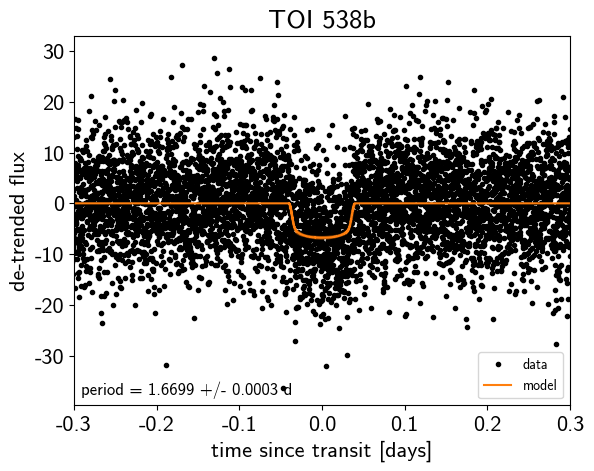

In [10]:
with model:
    light_curves = np.empty((500, len(model.x), len(periods)))
    func = xo.utils.get_theano_function_for_var(model.light_curves)
    for i, sample in enumerate(xo.utils.get_samples_from_trace(
            trace, size=len(light_curves))):
        light_curves[i] = func(*xo.utils.get_args_for_theano_function(sample))

for n, letter in enumerate(letters):
    plt.figure()

    # Compute the GP prediction
    mean_mod = np.median(trace["mean"][:, None])

    # Get the posterior median orbital parameters
    p = np.median(trace["period"][:, n])
    t0 = np.median(trace["t0"][:, n])

    # Compute the median of posterior estimate of the contribution from
    # the other planet. Then we can remove this from the data to plot
    # just the planet we care about.
    inds = np.arange(len(periods)) != n
    others = np.median(1e3*np.sum(light_curves[:, :, inds], axis=-1), axis=0)

    # Plot the folded data
    x_fold = (model.x - t0 + 0.5*p) % p - 0.5*p
    plt.plot(x_fold, model.y - mean_mod - others, ".k", label="data", zorder=-1000)

    # Plot the folded model
    inds = np.argsort(x_fold)
    inds = inds[np.abs(x_fold)[inds] < 0.3]
    pred = 1e3 * light_curves[:, inds, n]
    pred = np.percentile(pred, [16, 50, 84], axis=0)
    plt.plot(x_fold[inds], pred[1], color="C1", label="model")
    art = plt.fill_between(x_fold[inds], pred[0], pred[2], color="C1", alpha=0.5,
                           zorder=1000)
    art.set_edgecolor("none")

    # Annotate the plot with the planet's period
    txt = "period = {0:.4f} +/- {1:.4f} d".format(
        np.mean(trace["period"][:, n]), np.std(trace["period"][:, n]))
    plt.annotate(txt, (0, 0), xycoords="axes fraction",
                 xytext=(5, 5), textcoords="offset points",
                 ha="left", va="bottom", fontsize=12)

    plt.legend(fontsize=10, loc=4)
    plt.xlim(-0.5*p, 0.5*p)
    plt.xlabel("time since transit [days]")
    plt.ylabel("de-trended flux")
    plt.title("TOI {0}{1}".format(toi_num, letter));
    plt.xlim(-0.3, 0.3)

## Posterior constraints

Given the MCMC sampling, we can make some plots summarizing the constraints on the key parameters.
First up, we plot the physical radius of the planet using the stellar radius constraint from the TOI list, and the impact parameter (remember that we're using circular orbits).

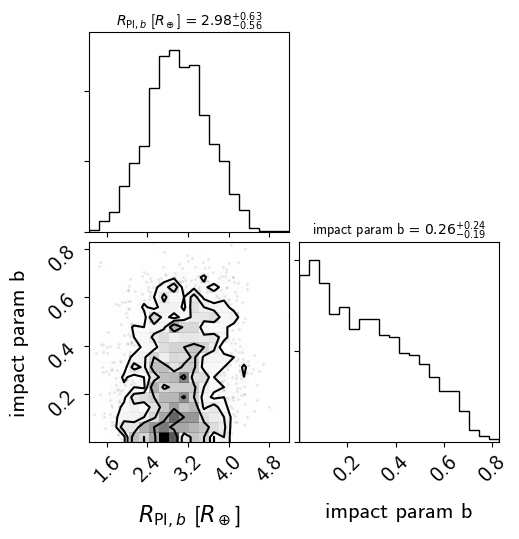

In [11]:
# Convert to Earth radii
r_pl = trace["r_pl"] * 109.07637070600963
samples = np.concatenate((r_pl, trace["b"]), axis=-1)

labels = ["$R_{{\mathrm{{Pl}},{0}}}$ [$R_\oplus$]".format(i) for i in letters]
labels += ["impact param {0}".format(i) for i in letters]

corner.corner(samples, labels=labels,
              show_titles=True, title_kwargs=dict(fontsize=10));

The other most interesting parameters are the period and transit times.

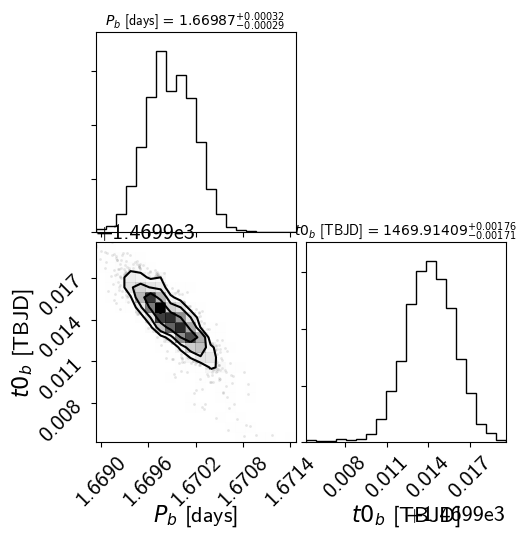

In [12]:
labels = ["$P_{{{0}}}$ [days]".format(i) for i in letters]
labels += ["$t0_{{{0}}}$ [TBJD]".format(i) for i in letters]
samples = np.concatenate((trace["period"], trace["t0"]), axis=-1)
corner.corner(samples, labels=labels,
              show_titles=True, title_fmt=".5f",
              title_kwargs=dict(fontsize=10));

Finally, here are the posterior constraints on the stellar properties.
These won't be exactly the same as the prior because the duration of the transits (and the assumption of circular orbits )

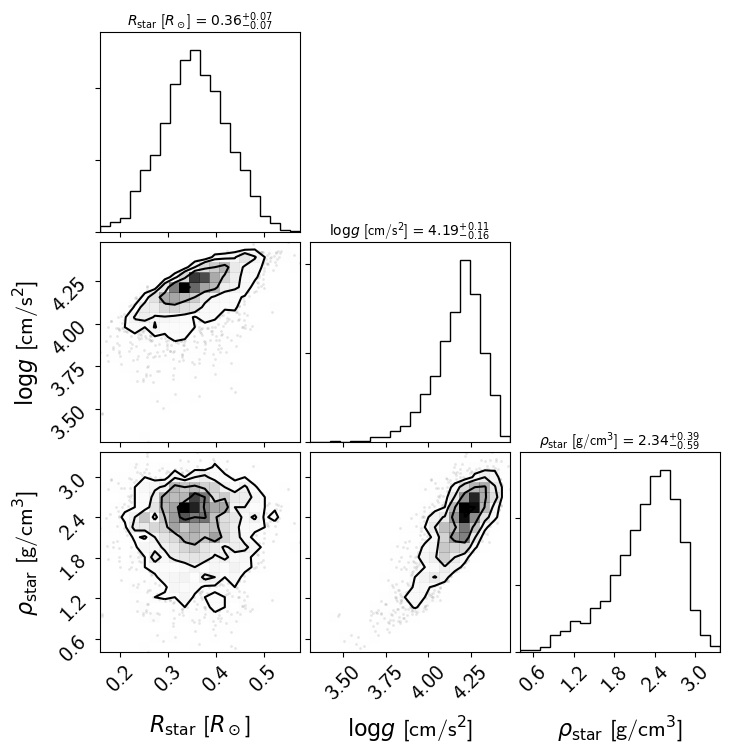

In [13]:
labels = ["$R_\mathrm{star}$ [$R_\odot$]", "$\log g$ [cm/s$^2$]",
          r"$\rho_\mathrm{star}$ [g/cm$^3$]"]
samples = np.vstack((trace["r_star"], trace["logg_star"], trace["rho_star"])).T
corner.corner(samples, labels=labels,
              show_titles=True,
              title_kwargs=dict(fontsize=10));

## Attribution

If you use these results or this code, please consider citing the relevant sources.
First, you can [cite the lightkurve package](https://zenodo.org/record/2611871):

```bibtex
@misc{lightkurve,
  author       = {Geert Barentsen and
                  Christina Hedges and
                  Zé Vinícius and
                  Nicholas Saunders and
                  gully and
                  Oliver Hall and
                  Sheila Sagear and
                  Tom Barclay and
                  KenMighell and
                  Keaton Bell and
                  Johnny Zhang and
                  Emma Turtelboom and
                  Zach Berta-Thompson and
                  Peter Williams and
                  Jose A Lerma III and
                  Guy Davies and
                  Brennan Vincello and
                  Anand Sundaram},
  title        = {KeplerGO/lightkurve: Lightkurve v1.0b30},
  month        = mar,
  year         = 2019,
  doi          = {10.5281/zenodo.2611871},
  url          = {https://doi.org/10.5281/zenodo.2611871}
}
```

You can also [cite the exoplanet project and its dependencies](https://exoplanet.dfm.io/en/stable/tutorials/citation/) using the following acknowledgement:

In [14]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:astropy13, exoplanet:astropy18,
exoplanet:espinoza18, exoplanet:exoplanet, exoplanet:kipping13,
exoplanet:luger18, exoplanet:pymc3, exoplanet:theano}.


and BibTeX entries:

In [15]:
print(bib)


@misc{exoplanet:exoplanet,
  author = {Dan Foreman-Mackey and
            Geert Barentsen and
            Tom Barclay},
   title = {dfm/exoplanet: exoplanet v0.1.5},
   month = mar,
    year = 2019,
     doi = {10.5281/zenodo.2587222},
     url = {https://doi.org/10.5281/zenodo.2587222}
}


@article{exoplanet:pymc3,
    title={Probabilistic programming in Python using PyMC3},
   author={Salvatier, John and Wiecki, Thomas V and Fonnesbeck, Christopher},
  journal={PeerJ Computer Science},
   volume={2},
    pages={e55},
     year={2016},
publisher={PeerJ Inc.}
}


@article{exoplanet:theano,
    title="{Theano: A {Python} framework for fast computation of mathematical
            expressions}",
   author={{Theano Development Team}},
  journal={arXiv e-prints},
   volume={abs/1605.02688},
     year=2016,
    month=may,
      url={http://arxiv.org/abs/1605.02688}
}


@ARTICLE{exoplanet:kipping13,
   author = {{Kipping}, D.~M.},
    title = "{Efficient, uninformative sampling of limb darke

## Environment

This notebook was run with the following conda environment:

In [16]:
!conda env export

name: tessatlas
channels:
  - defaults
dependencies:
  - astropy=3.1.2=py37h7b6447c_0
  - atomicwrites=1.3.0=py37_1
  - attrs=19.1.0=py37_1
  - blas=1.0=mkl
  - ca-certificates=2019.1.23=0
  - certifi=2019.3.9=py37_0
  - cycler=0.10.0=py37_0
  - dbus=1.13.6=h746ee38_0
  - expat=2.2.6=he6710b0_0
  - fontconfig=2.13.0=h9420a91_0
  - freetype=2.9.1=h8a8886c_1
  - glib=2.56.2=hd408876_0
  - gst-plugins-base=1.14.0=hbbd80ab_1
  - gstreamer=1.14.0=hb453b48_1
  - icu=58.2=h9c2bf20_1
  - intel-openmp=2019.3=199
  - jpeg=9b=h024ee3a_2
  - kiwisolver=1.0.1=py37hf484d3e_0
  - libedit=3.1.20181209=hc058e9b_0
  - libffi=3.2.1=hd88cf55_4
  - libgcc-ng=8.2.0=hdf63c60_1
  - libgfortran-ng=7.3.0=hdf63c60_0
  - libpng=1.6.36=hbc83047_0
  - libstdcxx-ng=8.2.0=hdf63c60_1
  - libuuid=1.0.3=h1bed415_2
  - libxcb=1.13=h1bed415_1
  - libxml2=2.9.9=he19cac6_0
  - matplotlib=3.0.3=py37h5429711_0
  - mkl=2019.3=199
  - mkl_fft=1.0.10=py37ha843d7b_0
  - mkl_random=1.0.2=py37hd81dba3_0
  - more-itertools=6.0.0=py3